# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic recommender system (REC) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [34]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [36]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [37]:
# import OFRL modules
import ofrl
from recgym import RECEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead as EpsilonGreedyHead
from ofrl.policy import DiscreteSoftmaxHead as SoftmaxHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler
from ofrl.utils import MinMaxScaler


# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [38]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [39]:
# version
print(ofrl.__version__)

0.0.0


In [40]:
# set random state
random_state = 12345

In [41]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the recommender environment works.

#### RL setup for recommendation
In recommendation, the objective of the RL agent is to maximize reward.

We often formulate this recommendation problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - A vector representing user preference.  The preference changes over time in an episode by the actions presented by the RL agent.
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an item to present to the user.
- `reward`: User engagement signal. Either binary or continuous.


For more about the environmental configuration and its customization, please refer to [examples/quickstart/rec_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_customize_env.ipynb).

In [42]:
# standardized environment
# env = gym.make("RECEnv-v0")
env = RECEnv(random_state=random_state)

In [43]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with a behavior policy $\pi_0$:

$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

where $s_t \in \mathcal{S}$ is the state observed at timestep $t$, $a_t$ is the action chosen by the behavior policy $\pi_0$, and $r_t$ is the reward. 

`SyntheticDataset` has the following arguments:
- `env`: Recommender environment for RL defined in the previous section.
- `max_episode_steps`: Maximum number of timesteps in an episode.

For more about the data collection and visualization, please refer to [examples/quickstart/rec_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_data_collection.ipynb).

In [44]:
# behavior policy
from d3rlpy.algos import DoubleDQN
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer
from d3rlpy.online.explorers import LinearDecayEpsilonGreedy

# model
ddqn = DoubleDQN(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
    use_gpu=torch.cuda.is_available(),
)
# replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)
# explorers
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [45]:
# start training
# skip if there is a pre-trained model
ddqn.fit_online(
    env_,
    buffer,
    explorer=explorer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2023-02-01 19:07.57 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20230201190757
2023-02-01 19:07.57 [debug    ] Building model...
2023-02-01 19:07.57 [debug    ] Model has been built.
2023-02-01 19:07.57 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201190757/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (5,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2023-02-01 19:07.57 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201190757/model_1000.pt
2023-02-01 19:07.57 [info     ] DoubleDQN_online_20230201190757: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.00011556649208068848, 'time_environment_step': 1.693224906921387e-05, 'time_step': 0.00014203453063964844, 'rollout_return': 0.17198368544257783, 'evaluation': 0.3870093620037155} step=1000
2023-02-01 19:07.58 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20230201190757/model_2000.pt
2023-02-01 19:07.58 [info     ] DoubleDQN_online_20230201190757: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.00012041974067687988, 'time_environment_step': 2.132892608642578e-05, 'time_sample_batch': 2.5312185287475586e-05, 'time_algorithm_update': 0.0006275036334991455, 'loss': 0.022820405427366495, 'time_step': 0.0008086445331573486, 'rollout_return': 0.5651582853374645, 'evaluation': 0.49552037003122307} step=2000
2023-02-01 19:07.5

In [46]:
# save model
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [47]:
# reload model
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

2023-02-01 19:09.15 [warning  ] Parameters will be reinitialized.


In [48]:
behavior_policy_01 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.1,
    name="ddqn_eps_0.1",
    random_state=random_state,
)
behavior_policy_03 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_eps_0.3",
    random_state=random_state,
)
behavior_policy_05 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.5,
    name="ddqn_eps_0.5",
    random_state=random_state,
)
behavior_policy_07 = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.7,
    name="ddqn_eps_0.7",
    random_state=random_state,
)
behavior_policies = [behavior_policy_01, behavior_policy_03, behavior_policy_05, behavior_policy_07]

In [49]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    max_episode_steps=env.step_per_episode,
)

In [50]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=10, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policies, 
    n_datasets=10, 
    n_trajectories=10000, 
    obtain_info=False,
    random_state=random_state + 1,
)

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
with open("logs/train_dataset_discrete_ddpn_multi.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddpn_multi.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [52]:
with open("logs/train_dataset_discrete_ddpn_multi.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddpn_multi.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rec_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_discrete_basic.ipynb).

In [53]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import DiscreteCQL as CQL

In [54]:
# evaluation policies
cql_b1 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b2 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)
cql_b3 = CQL(
    encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
)

algorithms = [cql_b1, cql_b2, cql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3"]

In [55]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [56]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=train_logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:41.29 [debug    ] RandomIterator is selected.
2023-02-01 20:41.29 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204129
2023-02-01 20:41.29 [debug    ] Building models...
2023-02-01 20:41.29 [debug    ] Models have been built.
2023-02-01 20:41.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204129/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:41.41 [info     ] DiscreteCQL_20230201204129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.56598711013794e-05, 'time_algorithm_update': 0.0010369600057601929, 'loss': 3.069261775994301, 'time_step': 0.0011793574810028077} step=10000
2023-02-01 20:41.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204129/model_10000.pt
2023-02-01 20:41.41 [debug    ] RandomIterator is selected.
2023-02-01 20:41.41 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204141
2023-02-01 20:41.41 [debug    ] Building models...
2023-02-01 20:41.41 [debug    ] Models have been built.
2023-02-01 20:41.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204141/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_ma

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:41.51 [info     ] DiscreteCQL_20230201204141: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.126445770263672e-05, 'time_algorithm_update': 0.0008861393451690674, 'loss': 2.704738839262724, 'time_step': 0.0010163586854934693} step=10000
2023-02-01 20:41.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204141/model_10000.pt
2023-02-01 20:41.51 [debug    ] RandomIterator is selected.
2023-02-01 20:41.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204151
2023-02-01 20:41.51 [debug    ] Building models...
2023-02-01 20:41.51 [debug    ] Models have been built.
2023-02-01 20:41.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204151/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generate

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.03 [info     ] DiscreteCQL_20230201204151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.346646785736084e-05, 'time_algorithm_update': 0.0010128119230270387, 'loss': 3.3491581357598306, 'time_step': 0.0011470994710922242} step=10000
2023-02-01 20:42.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204151/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:42.03 [debug    ] RandomIterator is selected.
2023-02-01 20:42.03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204203
2023-02-01 20:42.03 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204203/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.15 [info     ] DiscreteCQL_20230201204203: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.467143535614014e-05, 'time_algorithm_update': 0.0010424994468688964, 'loss': 2.0869783573687077, 'time_step': 0.0011785555601119995} step=10000
2023-02-01 20:42.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204203/model_10000.pt
2023-02-01 20:42.15 [debug    ] RandomIterator is selected.
2023-02-01 20:42.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204215
2023-02-01 20:42.15 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204215/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.25 [info     ] DiscreteCQL_20230201204215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.957871913909912e-05, 'time_algorithm_update': 0.0008674880266189575, 'loss': 1.9142222999751568, 'time_step': 0.00099041006565094} step=10000
2023-02-01 20:42.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204215/model_10000.pt
2023-02-01 20:42.25 [debug    ] RandomIterator is selected.
2023-02-01 20:42.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204225
2023-02-01 20:42.25 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204225/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.36 [info     ] DiscreteCQL_20230201204225: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.956529617309571e-05, 'time_algorithm_update': 0.0009399148941040039, 'loss': 2.4300068053245543, 'time_step': 0.0010626380920410157} step=10000
2023-02-01 20:42.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204225/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:42.36 [debug    ] RandomIterator is selected.
2023-02-01 20:42.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204236
2023-02-01 20:42.36 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204236/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.47 [info     ] DiscreteCQL_20230201204236: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.075634002685547e-05, 'time_algorithm_update': 0.0009586142301559449, 'loss': 1.959705115044117, 'time_step': 0.0010837862730026244} step=10000
2023-02-01 20:42.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204236/model_10000.pt
2023-02-01 20:42.47 [debug    ] RandomIterator is selected.
2023-02-01 20:42.47 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204247
2023-02-01 20:42.47 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204247/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:42.57 [info     ] DiscreteCQL_20230201204247: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.13109016418457e-05, 'time_algorithm_update': 0.0008802309513092041, 'loss': 1.8387667546451092, 'time_step': 0.0010097930192947387} step=10000
2023-02-01 20:42.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204247/model_10000.pt
2023-02-01 20:42.57 [debug    ] RandomIterator is selected.
2023-02-01 20:42.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204257
2023-02-01 20:42.57 [warning  ] Skip building models since they're already built.
2023-02-01 20:42.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204257/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:43.09 [info     ] DiscreteCQL_20230201204257: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.281279563903809e-05, 'time_algorithm_update': 0.0010182996034622193, 'loss': 2.1835541412472725, 'time_step': 0.0011488272666931153} step=10000
2023-02-01 20:43.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204257/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:43.09 [debug    ] RandomIterator is selected.
2023-02-01 20:43.09 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204309
2023-02-01 20:43.09 [warning  ] Skip building models since they're already built.
2023-02-01 20:43.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204309/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:43.20 [info     ] DiscreteCQL_20230201204309: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.11667776107788e-05, 'time_algorithm_update': 0.000990610384941101, 'loss': 1.9225386099934578, 'time_step': 0.0011197735548019408} step=10000
2023-02-01 20:43.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204309/model_10000.pt
2023-02-01 20:43.20 [debug    ] RandomIterator is selected.
2023-02-01 20:43.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204320
2023-02-01 20:43.20 [warning  ] Skip building models since they're already built.
2023-02-01 20:43.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204320/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:43.30 [info     ] DiscreteCQL_20230201204320: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.169594764709473e-05, 'time_algorithm_update': 0.0008908234596252441, 'loss': 1.8166801627725362, 'time_step': 0.0010199113368988036} step=10000
2023-02-01 20:43.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204320/model_10000.pt
2023-02-01 20:43.30 [debug    ] RandomIterator is selected.
2023-02-01 20:43.30 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204330
2023-02-01 20:43.30 [warning  ] Skip building models since they're already built.
2023-02-01 20:43.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204330/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:43.42 [info     ] DiscreteCQL_20230201204330: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.130062580108643e-05, 'time_algorithm_update': 0.0009704551696777344, 'loss': 2.095313190025091, 'time_step': 0.001101174235343933} step=10000
2023-02-01 20:43.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204330/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:43.42 [debug    ] RandomIterator is selected.
2023-02-01 20:43.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204342
2023-02-01 20:43.42 [warning  ] Skip building models since they're already built.
2023-02-01 20:43.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204342/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:43.53 [info     ] DiscreteCQL_20230201204342: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.271873950958252e-05, 'time_algorithm_update': 0.0009865719318389893, 'loss': 1.9191097792804241, 'time_step': 0.0011192683458328247} step=10000
2023-02-01 20:43.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204342/model_10000.pt
2023-02-01 20:43.53 [debug    ] RandomIterator is selected.
2023-02-01 20:43.53 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204353
2023-02-01 20:43.53 [warning  ] Skip building models since they're already built.
2023-02-01 20:43.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204353/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:44.04 [info     ] DiscreteCQL_20230201204353: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.208211421966552e-05, 'time_algorithm_update': 0.0009047778606414795, 'loss': 1.8160043433994055, 'time_step': 0.0010349023580551147} step=10000
2023-02-01 20:44.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204353/model_10000.pt
2023-02-01 20:44.04 [debug    ] RandomIterator is selected.
2023-02-01 20:44.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204404
2023-02-01 20:44.04 [warning  ] Skip building models since they're already built.
2023-02-01 20:44.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204404/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:44.15 [info     ] DiscreteCQL_20230201204404: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.16505765914917e-05, 'time_algorithm_update': 0.0009715055465698242, 'loss': 2.0590586381137372, 'time_step': 0.0011025420427322387} step=10000
2023-02-01 20:44.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204404/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:44.15 [debug    ] RandomIterator is selected.
2023-02-01 20:44.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204415
2023-02-01 20:44.15 [warning  ] Skip building models since they're already built.
2023-02-01 20:44.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204415/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:44.27 [info     ] DiscreteCQL_20230201204415: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.518048286437988e-05, 'time_algorithm_update': 0.001033776068687439, 'loss': 1.8880725906193256, 'time_step': 0.0011815176963806153} step=10000
2023-02-01 20:44.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204415/model_10000.pt
2023-02-01 20:44.27 [debug    ] RandomIterator is selected.
2023-02-01 20:44.27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204427
2023-02-01 20:44.27 [warning  ] Skip building models since they're already built.
2023-02-01 20:44.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204427/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:44.38 [info     ] DiscreteCQL_20230201204427: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.51016616821289e-05, 'time_algorithm_update': 0.000947421407699585, 'loss': 1.8129917883247137, 'time_step': 0.0010976616621017456} step=10000
2023-02-01 20:44.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204427/model_10000.pt
2023-02-01 20:44.38 [debug    ] RandomIterator is selected.
2023-02-01 20:44.38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204438
2023-02-01 20:44.38 [warning  ] Skip building models since they're already built.
2023-02-01 20:44.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204438/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:44.49 [info     ] DiscreteCQL_20230201204438: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.006821632385254e-05, 'time_algorithm_update': 0.0009584471464157105, 'loss': 2.0169604022026064, 'time_step': 0.0010828732013702393} step=10000
2023-02-01 20:44.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204438/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:44.49 [debug    ] RandomIterator is selected.
2023-02-01 20:44.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204449
2023-02-01 20:44.49 [warning  ] Skip building models since they're already built.
2023-02-01 20:44.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204449/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.01 [info     ] DiscreteCQL_20230201204449: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.297496795654297e-05, 'time_algorithm_update': 0.0010039244174957274, 'loss': 1.8723256498366594, 'time_step': 0.0011424834489822387} step=10000
2023-02-01 20:45.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204449/model_10000.pt
2023-02-01 20:45.01 [debug    ] RandomIterator is selected.
2023-02-01 20:45.01 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204501
2023-02-01 20:45.01 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204501/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.11 [info     ] DiscreteCQL_20230201204501: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.090516090393067e-05, 'time_algorithm_update': 0.0008843487739562989, 'loss': 1.7809002972066403, 'time_step': 0.0010115576028823852} step=10000
2023-02-01 20:45.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204501/model_10000.pt
2023-02-01 20:45.11 [debug    ] RandomIterator is selected.
2023-02-01 20:45.11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204511
2023-02-01 20:45.11 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204511/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.22 [info     ] DiscreteCQL_20230201204511: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.975252628326417e-05, 'time_algorithm_update': 0.0009582595109939575, 'loss': 1.9922412714600564, 'time_step': 0.0010800775289535522} step=10000
2023-02-01 20:45.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204511/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:45.22 [debug    ] RandomIterator is selected.
2023-02-01 20:45.22 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204522
2023-02-01 20:45.22 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204522/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.33 [info     ] DiscreteCQL_20230201204522: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.853361129760743e-05, 'time_algorithm_update': 0.0009389179944992066, 'loss': 1.8803133068948985, 'time_step': 0.001058659029006958} step=10000
2023-02-01 20:45.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204522/model_10000.pt
2023-02-01 20:45.33 [debug    ] RandomIterator is selected.
2023-02-01 20:45.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204533
2023-02-01 20:45.33 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204533/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.43 [info     ] DiscreteCQL_20230201204533: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.895697116851806e-05, 'time_algorithm_update': 0.0008561177968978882, 'loss': 1.8035767063558101, 'time_step': 0.000977368974685669} step=10000
2023-02-01 20:45.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204533/model_10000.pt
2023-02-01 20:45.43 [debug    ] RandomIterator is selected.
2023-02-01 20:45.43 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204543
2023-02-01 20:45.43 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204543/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:45.54 [info     ] DiscreteCQL_20230201204543: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.078471183776856e-05, 'time_algorithm_update': 0.0009747515678405761, 'loss': 1.9886721415281297, 'time_step': 0.0011006965160369874} step=10000
2023-02-01 20:45.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204543/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:45.54 [debug    ] RandomIterator is selected.
2023-02-01 20:45.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204554
2023-02-01 20:45.54 [warning  ] Skip building models since they're already built.
2023-02-01 20:45.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204554/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.05 [info     ] DiscreteCQL_20230201204554: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.874730587005616e-05, 'time_algorithm_update': 0.0009310106754302979, 'loss': 1.8885223338276147, 'time_step': 0.0010509302377700806} step=10000
2023-02-01 20:46.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204554/model_10000.pt
2023-02-01 20:46.05 [debug    ] RandomIterator is selected.
2023-02-01 20:46.05 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204605
2023-02-01 20:46.05 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204605/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.14 [info     ] DiscreteCQL_20230201204605: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.791155338287354e-05, 'time_algorithm_update': 0.0008437650680541992, 'loss': 1.7997191740065812, 'time_step': 0.0009615008592605591} step=10000
2023-02-01 20:46.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204605/model_10000.pt
2023-02-01 20:46.14 [debug    ] RandomIterator is selected.
2023-02-01 20:46.14 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204614
2023-02-01 20:46.14 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204614/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.25 [info     ] DiscreteCQL_20230201204614: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.824941635131836e-05, 'time_algorithm_update': 0.0009223884344100952, 'loss': 1.9954034060001373, 'time_step': 0.0010412452697753907} step=10000
2023-02-01 20:46.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204614/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:46.25 [debug    ] RandomIterator is selected.
2023-02-01 20:46.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204625
2023-02-01 20:46.25 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204625/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.36 [info     ] DiscreteCQL_20230201204625: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.796963214874268e-05, 'time_algorithm_update': 0.0009258895397186279, 'loss': 1.921098835155368, 'time_step': 0.0010444676160812378} step=10000
2023-02-01 20:46.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204625/model_10000.pt
2023-02-01 20:46.36 [debug    ] RandomIterator is selected.
2023-02-01 20:46.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204636
2023-02-01 20:46.36 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204636/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.45 [info     ] DiscreteCQL_20230201204636: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.751415729522705e-05, 'time_algorithm_update': 0.0008380812644958497, 'loss': 1.836572601866722, 'time_step': 0.0009547953128814697} step=10000
2023-02-01 20:46.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204636/model_10000.pt
2023-02-01 20:46.45 [debug    ] RandomIterator is selected.
2023-02-01 20:46.45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204645
2023-02-01 20:46.45 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204645/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:46.56 [info     ] DiscreteCQL_20230201204645: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.78842306137085e-05, 'time_algorithm_update': 0.0009221764802932739, 'loss': 2.0206161617904903, 'time_step': 0.00104034686088562} step=10000
2023-02-01 20:46.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204645/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:46.56 [debug    ] RandomIterator is selected.
2023-02-01 20:46.56 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204656
2023-02-01 20:46.56 [warning  ] Skip building models since they're already built.
2023-02-01 20:46.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204656/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:47.07 [info     ] DiscreteCQL_20230201204656: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.77164077758789e-05, 'time_algorithm_update': 0.0009295888662338257, 'loss': 3.6913872361660003, 'time_step': 0.0010475187301635742} step=10000
2023-02-01 20:47.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204656/model_10000.pt
2023-02-01 20:47.07 [debug    ] RandomIterator is selected.
2023-02-01 20:47.07 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204707
2023-02-01 20:47.07 [warning  ] Skip building models since they're already built.
2023-02-01 20:47.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204707/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:47.16 [info     ] DiscreteCQL_20230201204707: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.78450345993042e-05, 'time_algorithm_update': 0.0008482447862625122, 'loss': 3.6237074451208113, 'time_step': 0.000966584587097168} step=10000
2023-02-01 20:47.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204707/model_10000.pt
2023-02-01 20:47.16 [debug    ] RandomIterator is selected.
2023-02-01 20:47.16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204716
2023-02-01 20:47.16 [warning  ] Skip building models since they're already built.
2023-02-01 20:47.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204716/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:47.27 [info     ] DiscreteCQL_20230201204716: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.8267822265625e-05, 'time_algorithm_update': 0.0009255610227584839, 'loss': 3.8029103145241736, 'time_step': 0.001044323992729187} step=10000
2023-02-01 20:47.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204716/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:47.27 [debug    ] RandomIterator is selected.
2023-02-01 20:47.27 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204727
2023-02-01 20:47.27 [warning  ] Skip building models since they're already built.
2023-02-01 20:47.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204727/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:47.38 [info     ] DiscreteCQL_20230201204727: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.872198581695557e-05, 'time_algorithm_update': 0.0009471138954162598, 'loss': 3.5817770662784576, 'time_step': 0.0010678938627243042} step=10000
2023-02-01 20:47.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204727/model_10000.pt
2023-02-01 20:47.38 [debug    ] RandomIterator is selected.
2023-02-01 20:47.38 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204738
2023-02-01 20:47.38 [warning  ] Skip building models since they're already built.
2023-02-01 20:47.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204738/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:47.49 [info     ] DiscreteCQL_20230201204738: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.477648258209228e-05, 'time_algorithm_update': 0.0009224082708358765, 'loss': 3.501942898070812, 'time_step': 0.0010656579971313476} step=10000
2023-02-01 20:47.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204738/model_10000.pt
2023-02-01 20:47.49 [debug    ] RandomIterator is selected.
2023-02-01 20:47.49 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204749
2023-02-01 20:47.49 [warning  ] Skip building models since they're already built.
2023-02-01 20:47.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204749/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.00 [info     ] DiscreteCQL_20230201204749: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.005653381347656e-05, 'time_algorithm_update': 0.0009654665470123291, 'loss': 3.6982975049376487, 'time_step': 0.0010895114660263061} step=10000
2023-02-01 20:48.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204749/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:48.00 [debug    ] RandomIterator is selected.
2023-02-01 20:48.00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204800
2023-02-01 20:48.00 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204800/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.11 [info     ] DiscreteCQL_20230201204800: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.809303760528564e-05, 'time_algorithm_update': 0.0009453610420227051, 'loss': 3.618360877239704, 'time_step': 0.0010638283967971801} step=10000
2023-02-01 20:48.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204800/model_10000.pt
2023-02-01 20:48.11 [debug    ] RandomIterator is selected.
2023-02-01 20:48.11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204811
2023-02-01 20:48.11 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204811/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.20 [info     ] DiscreteCQL_20230201204811: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.75032138824463e-05, 'time_algorithm_update': 0.0008477471828460694, 'loss': 3.547209261083603, 'time_step': 0.0009655247211456299} step=10000
2023-02-01 20:48.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204811/model_10000.pt
2023-02-01 20:48.20 [debug    ] RandomIterator is selected.
2023-02-01 20:48.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204820
2023-02-01 20:48.20 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204820/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.31 [info     ] DiscreteCQL_20230201204820: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.762800216674805e-05, 'time_algorithm_update': 0.0009291112661361695, 'loss': 3.723312480401993, 'time_step': 0.0010465795516967774} step=10000
2023-02-01 20:48.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204820/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:48.31 [debug    ] RandomIterator is selected.
2023-02-01 20:48.31 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204831
2023-02-01 20:48.31 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204831/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.42 [info     ] DiscreteCQL_20230201204831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.977682113647462e-05, 'time_algorithm_update': 0.0009544293642044068, 'loss': 3.635590044105053, 'time_step': 0.0010764005422592164} step=10000
2023-02-01 20:48.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204831/model_10000.pt
2023-02-01 20:48.42 [debug    ] RandomIterator is selected.
2023-02-01 20:48.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204842
2023-02-01 20:48.42 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204842/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:48.52 [info     ] DiscreteCQL_20230201204842: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.835570335388184e-05, 'time_algorithm_update': 0.0008472176313400269, 'loss': 3.5624284510850908, 'time_step': 0.000966752815246582} step=10000
2023-02-01 20:48.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204842/model_10000.pt
2023-02-01 20:48.52 [debug    ] RandomIterator is selected.
2023-02-01 20:48.52 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204852
2023-02-01 20:48.52 [warning  ] Skip building models since they're already built.
2023-02-01 20:48.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204852/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.02 [info     ] DiscreteCQL_20230201204852: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.818625926971435e-05, 'time_algorithm_update': 0.0009287446260452271, 'loss': 3.7086163982868197, 'time_step': 0.0010478304624557495} step=10000
2023-02-01 20:49.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204852/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:49.03 [debug    ] RandomIterator is selected.
2023-02-01 20:49.03 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204903
2023-02-01 20:49.03 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204903/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.13 [info     ] DiscreteCQL_20230201204903: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.867458820343018e-05, 'time_algorithm_update': 0.0009448168039321899, 'loss': 3.6658484153985977, 'time_step': 0.001064885425567627} step=10000
2023-02-01 20:49.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204903/model_10000.pt
2023-02-01 20:49.13 [debug    ] RandomIterator is selected.
2023-02-01 20:49.13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204913
2023-02-01 20:49.13 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204913/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.23 [info     ] DiscreteCQL_20230201204913: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.819498538970948e-05, 'time_algorithm_update': 0.0008444715023040772, 'loss': 3.5928892936468126, 'time_step': 0.0009633807897567749} step=10000
2023-02-01 20:49.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204913/model_10000.pt
2023-02-01 20:49.23 [debug    ] RandomIterator is selected.
2023-02-01 20:49.23 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204923
2023-02-01 20:49.23 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204923/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.34 [info     ] DiscreteCQL_20230201204923: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.817138195037842e-05, 'time_algorithm_update': 0.0009265125751495362, 'loss': 3.7530118844628335, 'time_step': 0.0010453301191329957} step=10000
2023-02-01 20:49.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204923/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:49.34 [debug    ] RandomIterator is selected.
2023-02-01 20:49.34 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204934
2023-02-01 20:49.34 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204934/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.45 [info     ] DiscreteCQL_20230201204934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.832151412963867e-05, 'time_algorithm_update': 0.0009333375453948974, 'loss': 3.708873071694374, 'time_step': 0.0010528120517730713} step=10000
2023-02-01 20:49.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204934/model_10000.pt
2023-02-01 20:49.45 [debug    ] RandomIterator is selected.
2023-02-01 20:49.45 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204945
2023-02-01 20:49.45 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204945/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:49.54 [info     ] DiscreteCQL_20230201204945: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.772964000701905e-05, 'time_algorithm_update': 0.0008375394105911254, 'loss': 3.632608785569668, 'time_step': 0.0009550354957580566} step=10000
2023-02-01 20:49.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204945/model_10000.pt
2023-02-01 20:49.54 [debug    ] RandomIterator is selected.
2023-02-01 20:49.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201204954
2023-02-01 20:49.54 [warning  ] Skip building models since they're already built.
2023-02-01 20:49.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204954/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.05 [info     ] DiscreteCQL_20230201204954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.841721534729004e-05, 'time_algorithm_update': 0.0009268363952636718, 'loss': 3.770742700481415, 'time_step': 0.0010462951898574829} step=10000
2023-02-01 20:50.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201204954/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:50.05 [debug    ] RandomIterator is selected.
2023-02-01 20:50.05 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205005
2023-02-01 20:50.05 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205005/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.16 [info     ] DiscreteCQL_20230201205005: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.8394136428833e-05, 'time_algorithm_update': 0.0009317711830139161, 'loss': 3.7726278509378433, 'time_step': 0.0010505519390106202} step=10000
2023-02-01 20:50.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205005/model_10000.pt
2023-02-01 20:50.16 [debug    ] RandomIterator is selected.
2023-02-01 20:50.16 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205016
2023-02-01 20:50.16 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205016/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.25 [info     ] DiscreteCQL_20230201205016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.816263198852538e-05, 'time_algorithm_update': 0.0008390468835830689, 'loss': 3.6955001636505127, 'time_step': 0.0009577970743179322} step=10000
2023-02-01 20:50.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205016/model_10000.pt
2023-02-01 20:50.25 [debug    ] RandomIterator is selected.
2023-02-01 20:50.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205025
2023-02-01 20:50.25 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205025/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'lear

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.36 [info     ] DiscreteCQL_20230201205025: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.789698600769043e-05, 'time_algorithm_update': 0.0009220205307006836, 'loss': 3.821774695932865, 'time_step': 0.0010398495435714721} step=10000
2023-02-01 20:50.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205025/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:50.36 [debug    ] RandomIterator is selected.
2023-02-01 20:50.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205036
2023-02-01 20:50.36 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205036/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.47 [info     ] DiscreteCQL_20230201205036: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.833479404449463e-05, 'time_algorithm_update': 0.0009327779531478882, 'loss': 3.7978231842398644, 'time_step': 0.0010518748760223388} step=10000
2023-02-01 20:50.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205036/model_10000.pt
2023-02-01 20:50.47 [debug    ] RandomIterator is selected.
2023-02-01 20:50.47 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205047
2023-02-01 20:50.47 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205047/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:50.57 [info     ] DiscreteCQL_20230201205047: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.86983585357666e-05, 'time_algorithm_update': 0.0008539492607116699, 'loss': 3.7204368948817255, 'time_step': 0.0009737945079803466} step=10000
2023-02-01 20:50.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205047/model_10000.pt
2023-02-01 20:50.57 [debug    ] RandomIterator is selected.
2023-02-01 20:50.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205057
2023-02-01 20:50.57 [warning  ] Skip building models since they're already built.
2023-02-01 20:50.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205057/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:51.07 [info     ] DiscreteCQL_20230201205057: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.855907440185546e-05, 'time_algorithm_update': 0.0009345639228820801, 'loss': 3.8426366216421126, 'time_step': 0.0010538072347640991} step=10000
2023-02-01 20:51.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205057/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:51.08 [debug    ] RandomIterator is selected.
2023-02-01 20:51.08 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205108
2023-02-01 20:51.08 [warning  ] Skip building models since they're already built.
2023-02-01 20:51.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205108/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:51.18 [info     ] DiscreteCQL_20230201205108: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.812911033630372e-05, 'time_algorithm_update': 0.0009287616729736328, 'loss': 3.8323520597577097, 'time_step': 0.00104725558757782} step=10000
2023-02-01 20:51.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205108/model_10000.pt
2023-02-01 20:51.18 [debug    ] RandomIterator is selected.
2023-02-01 20:51.18 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205118
2023-02-01 20:51.18 [warning  ] Skip building models since they're already built.
2023-02-01 20:51.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205118/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:51.29 [info     ] DiscreteCQL_20230201205118: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.263596057891846e-05, 'time_algorithm_update': 0.000898006534576416, 'loss': 3.775265271103382, 'time_step': 0.001034542155265808} step=10000
2023-02-01 20:51.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205118/model_10000.pt
2023-02-01 20:51.29 [debug    ] RandomIterator is selected.
2023-02-01 20:51.29 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205129
2023-02-01 20:51.29 [warning  ] Skip building models since they're already built.
2023-02-01 20:51.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205129/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:51.39 [info     ] DiscreteCQL_20230201205129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.953082084655762e-05, 'time_algorithm_update': 0.000939343547821045, 'loss': 3.8924493012428285, 'time_step': 0.0010632855653762818} step=10000
2023-02-01 20:51.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205129/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:51.40 [debug    ] RandomIterator is selected.
2023-02-01 20:51.40 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205140
2023-02-01 20:51.40 [warning  ] Skip building models since they're already built.
2023-02-01 20:51.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205140/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:51.51 [info     ] DiscreteCQL_20230201205140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.302377223968506e-05, 'time_algorithm_update': 0.0009922032356262207, 'loss': 3.884739547133446, 'time_step': 0.0011332550048828126} step=10000
2023-02-01 20:51.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205140/model_10000.pt
2023-02-01 20:51.51 [debug    ] RandomIterator is selected.
2023-02-01 20:51.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205151
2023-02-01 20:51.51 [warning  ] Skip building models since they're already built.
2023-02-01 20:51.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205151/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.01 [info     ] DiscreteCQL_20230201205151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.083220481872558e-05, 'time_algorithm_update': 0.0008797525405883789, 'loss': 3.826665947818756, 'time_step': 0.0010042672395706178} step=10000
2023-02-01 20:52.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205151/model_10000.pt
2023-02-01 20:52.01 [debug    ] RandomIterator is selected.
2023-02-01 20:52.01 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205201
2023-02-01 20:52.01 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205201/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.12 [info     ] DiscreteCQL_20230201205201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.900115013122559e-05, 'time_algorithm_update': 0.0009318302154541015, 'loss': 3.9598422062039376, 'time_step': 0.0010518671989440918} step=10000
2023-02-01 20:52.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205201/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:52.12 [debug    ] RandomIterator is selected.
2023-02-01 20:52.12 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205212
2023-02-01 20:52.12 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205212/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.23 [info     ] DiscreteCQL_20230201205212: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.912171840667725e-05, 'time_algorithm_update': 0.0009416906356811524, 'loss': 4.99786655395031, 'time_step': 0.0010619658708572388} step=10000
2023-02-01 20:52.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205212/model_10000.pt
2023-02-01 20:52.23 [debug    ] RandomIterator is selected.
2023-02-01 20:52.23 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205223
2023-02-01 20:52.23 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205223/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.33 [info     ] DiscreteCQL_20230201205223: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.912798881530762e-05, 'time_algorithm_update': 0.0008558765172958374, 'loss': 4.985348073291779, 'time_step': 0.0009758876323699952} step=10000
2023-02-01 20:52.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205223/model_10000.pt
2023-02-01 20:52.33 [debug    ] RandomIterator is selected.
2023-02-01 20:52.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205233
2023-02-01 20:52.33 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205233/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.43 [info     ] DiscreteCQL_20230201205233: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.877608299255371e-05, 'time_algorithm_update': 0.0009285774946212769, 'loss': 5.0233667618751525, 'time_step': 0.0010483009099960328} step=10000
2023-02-01 20:52.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205233/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:52.44 [debug    ] RandomIterator is selected.
2023-02-01 20:52.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205244
2023-02-01 20:52.44 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205244/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:52.54 [info     ] DiscreteCQL_20230201205244: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.873908042907714e-05, 'time_algorithm_update': 0.0009435686349868774, 'loss': 4.9944978931665425, 'time_step': 0.0010625572204589844} step=10000
2023-02-01 20:52.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205244/model_10000.pt
2023-02-01 20:52.54 [debug    ] RandomIterator is selected.
2023-02-01 20:52.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205254
2023-02-01 20:52.54 [warning  ] Skip building models since they're already built.
2023-02-01 20:52.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205254/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.04 [info     ] DiscreteCQL_20230201205254: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.909391880035401e-05, 'time_algorithm_update': 0.0008665011882781983, 'loss': 4.952431939315796, 'time_step': 0.0009869863033294677} step=10000
2023-02-01 20:53.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205254/model_10000.pt
2023-02-01 20:53.04 [debug    ] RandomIterator is selected.
2023-02-01 20:53.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205304
2023-02-01 20:53.04 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205304/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.15 [info     ] DiscreteCQL_20230201205304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.889877319335937e-05, 'time_algorithm_update': 0.0009365163087844848, 'loss': 4.985136741042137, 'time_step': 0.0010563063621520997} step=10000
2023-02-01 20:53.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205304/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:53.15 [debug    ] RandomIterator is selected.
2023-02-01 20:53.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205315
2023-02-01 20:53.15 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205315/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.26 [info     ] DiscreteCQL_20230201205315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.855423450469971e-05, 'time_algorithm_update': 0.000936774754524231, 'loss': 5.0960059277057645, 'time_step': 0.0010565438508987426} step=10000
2023-02-01 20:53.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205315/model_10000.pt
2023-02-01 20:53.26 [debug    ] RandomIterator is selected.
2023-02-01 20:53.26 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205326
2023-02-01 20:53.26 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205326/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.36 [info     ] DiscreteCQL_20230201205326: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.862151622772217e-05, 'time_algorithm_update': 0.0008524710655212403, 'loss': 5.038715556311607, 'time_step': 0.0009720264673233032} step=10000
2023-02-01 20:53.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205326/model_10000.pt
2023-02-01 20:53.36 [debug    ] RandomIterator is selected.
2023-02-01 20:53.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205336
2023-02-01 20:53.36 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205336/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.46 [info     ] DiscreteCQL_20230201205336: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.902687549591064e-05, 'time_algorithm_update': 0.0009384642124176026, 'loss': 5.083583575487137, 'time_step': 0.0010588715314865111} step=10000
2023-02-01 20:53.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205336/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:53.47 [debug    ] RandomIterator is selected.
2023-02-01 20:53.47 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205347
2023-02-01 20:53.47 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205347/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:53.57 [info     ] DiscreteCQL_20230201205347: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.891672611236573e-05, 'time_algorithm_update': 0.0009433018684387207, 'loss': 5.175910326361656, 'time_step': 0.0010632617950439454} step=10000
2023-02-01 20:53.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205347/model_10000.pt
2023-02-01 20:53.57 [debug    ] RandomIterator is selected.
2023-02-01 20:53.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205357
2023-02-01 20:53.57 [warning  ] Skip building models since they're already built.
2023-02-01 20:53.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205357/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:54.07 [info     ] DiscreteCQL_20230201205357: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.944231986999512e-05, 'time_algorithm_update': 0.000870481276512146, 'loss': 5.133120105719566, 'time_step': 0.0009918612480163574} step=10000
2023-02-01 20:54.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205357/model_10000.pt
2023-02-01 20:54.07 [debug    ] RandomIterator is selected.
2023-02-01 20:54.07 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205407
2023-02-01 20:54.07 [warning  ] Skip building models since they're already built.
2023-02-01 20:54.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205407/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:54.39 [info     ] DiscreteCQL_20230201205407: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.992802619934082e-05, 'time_algorithm_update': 0.0030367568016052247, 'loss': 5.160894581365586, 'time_step': 0.003160377025604248} step=10000
2023-02-01 20:54.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205407/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:54.39 [debug    ] RandomIterator is selected.
2023-02-01 20:54.39 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205439
2023-02-01 20:54.39 [warning  ] Skip building models since they're already built.
2023-02-01 20:54.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205439/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:54.50 [info     ] DiscreteCQL_20230201205439: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.897273063659668e-05, 'time_algorithm_update': 0.0009460746526718139, 'loss': 5.274539504742623, 'time_step': 0.001066269826889038} step=10000
2023-02-01 20:54.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205439/model_10000.pt
2023-02-01 20:54.50 [debug    ] RandomIterator is selected.
2023-02-01 20:54.50 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205450
2023-02-01 20:54.50 [warning  ] Skip building models since they're already built.
2023-02-01 20:54.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205450/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.00 [info     ] DiscreteCQL_20230201205450: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.749539375305176e-05, 'time_algorithm_update': 0.0008462756395339966, 'loss': 5.238965754604339, 'time_step': 0.0009633916854858398} step=10000
2023-02-01 20:55.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205450/model_10000.pt
2023-02-01 20:55.00 [debug    ] RandomIterator is selected.
2023-02-01 20:55.00 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205500
2023-02-01 20:55.00 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205500/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.10 [info     ] DiscreteCQL_20230201205500: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.784665584564209e-05, 'time_algorithm_update': 0.0009235934972763062, 'loss': 5.272062800145149, 'time_step': 0.0010412366151809692} step=10000
2023-02-01 20:55.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205500/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:55.11 [debug    ] RandomIterator is selected.
2023-02-01 20:55.11 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205511
2023-02-01 20:55.11 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205511/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.21 [info     ] DiscreteCQL_20230201205511: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.777336597442626e-05, 'time_algorithm_update': 0.0009434828519821167, 'loss': 5.402791571354866, 'time_step': 0.0010613746643066406} step=10000
2023-02-01 20:55.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205511/model_10000.pt
2023-02-01 20:55.21 [debug    ] RandomIterator is selected.
2023-02-01 20:55.21 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205521
2023-02-01 20:55.21 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205521/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.31 [info     ] DiscreteCQL_20230201205521: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.756031513214111e-05, 'time_algorithm_update': 0.0008477035522460938, 'loss': 5.337187550806999, 'time_step': 0.0009651807785034179} step=10000
2023-02-01 20:55.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205521/model_10000.pt
2023-02-01 20:55.31 [debug    ] RandomIterator is selected.
2023-02-01 20:55.31 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205531
2023-02-01 20:55.31 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205531/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.42 [info     ] DiscreteCQL_20230201205531: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.739144325256347e-05, 'time_algorithm_update': 0.0009198418378829956, 'loss': 5.366247300839424, 'time_step': 0.001036940598487854} step=10000
2023-02-01 20:55.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205531/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:55.42 [debug    ] RandomIterator is selected.
2023-02-01 20:55.42 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205542
2023-02-01 20:55.42 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205542/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:55.52 [info     ] DiscreteCQL_20230201205542: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.787042617797851e-05, 'time_algorithm_update': 0.0009267173767089844, 'loss': 5.475681842017174, 'time_step': 0.0010451054811477661} step=10000
2023-02-01 20:55.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205542/model_10000.pt
2023-02-01 20:55.52 [debug    ] RandomIterator is selected.
2023-02-01 20:55.52 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205552
2023-02-01 20:55.52 [warning  ] Skip building models since they're already built.
2023-02-01 20:55.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205552/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.02 [info     ] DiscreteCQL_20230201205552: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.774682998657227e-05, 'time_algorithm_update': 0.000841649317741394, 'loss': 5.4158130691289905, 'time_step': 0.0009597273349761963} step=10000
2023-02-01 20:56.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205552/model_10000.pt
2023-02-01 20:56.02 [debug    ] RandomIterator is selected.
2023-02-01 20:56.02 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205602
2023-02-01 20:56.02 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205602/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.13 [info     ] DiscreteCQL_20230201205602: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.782541275024413e-05, 'time_algorithm_update': 0.0009214984178543091, 'loss': 5.44557268936634, 'time_step': 0.0010395214557647706} step=10000
2023-02-01 20:56.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205602/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:56.13 [debug    ] RandomIterator is selected.
2023-02-01 20:56.13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205613
2023-02-01 20:56.13 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205613/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.24 [info     ] DiscreteCQL_20230201205613: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.797924041748047e-05, 'time_algorithm_update': 0.0009452399253845215, 'loss': 5.573368701434135, 'time_step': 0.0010634621858596801} step=10000
2023-02-01 20:56.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205613/model_10000.pt
2023-02-01 20:56.24 [debug    ] RandomIterator is selected.
2023-02-01 20:56.24 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205624
2023-02-01 20:56.24 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205624/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.33 [info     ] DiscreteCQL_20230201205624: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.817331314086914e-05, 'time_algorithm_update': 0.0008575967788696289, 'loss': 5.505054147458076, 'time_step': 0.0009765910625457765} step=10000
2023-02-01 20:56.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205624/model_10000.pt
2023-02-01 20:56.33 [debug    ] RandomIterator is selected.
2023-02-01 20:56.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205633
2023-02-01 20:56.33 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205633/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.44 [info     ] DiscreteCQL_20230201205633: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.750426292419433e-05, 'time_algorithm_update': 0.0009261964321136475, 'loss': 5.541999723887444, 'time_step': 0.0010434905767440796} step=10000
2023-02-01 20:56.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205633/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:56.44 [debug    ] RandomIterator is selected.
2023-02-01 20:56.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205644
2023-02-01 20:56.44 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205644/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:56.55 [info     ] DiscreteCQL_20230201205644: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.765704154968262e-05, 'time_algorithm_update': 0.0009440935134887695, 'loss': 5.668975588202477, 'time_step': 0.0010637885808944703} step=10000
2023-02-01 20:56.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205644/model_10000.pt
2023-02-01 20:56.55 [debug    ] RandomIterator is selected.
2023-02-01 20:56.55 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205655
2023-02-01 20:56.55 [warning  ] Skip building models since they're already built.
2023-02-01 20:56.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205655/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:57.48 [info     ] DiscreteCQL_20230201205655: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.771652698516846e-05, 'time_algorithm_update': 0.005216297340393066, 'loss': 5.638032796144485, 'time_step': 0.0053353021144866945} step=10000
2023-02-01 20:57.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205655/model_10000.pt
2023-02-01 20:57.48 [debug    ] RandomIterator is selected.
2023-02-01 20:57.48 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205748
2023-02-01 20:57.48 [warning  ] Skip building models since they're already built.
2023-02-01 20:57.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205748/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:57.59 [info     ] DiscreteCQL_20230201205748: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.761987209320068e-05, 'time_algorithm_update': 0.0009206180572509765, 'loss': 5.62677204489708, 'time_step': 0.001038237428665161} step=10000
2023-02-01 20:57.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205748/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:57.59 [debug    ] RandomIterator is selected.
2023-02-01 20:57.59 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205759
2023-02-01 20:57.59 [warning  ] Skip building models since they're already built.
2023-02-01 20:57.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205759/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:58.10 [info     ] DiscreteCQL_20230201205759: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.768090724945068e-05, 'time_algorithm_update': 0.0009380334854125976, 'loss': 5.784686454677582, 'time_step': 0.001055977964401245} step=10000
2023-02-01 20:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205759/model_10000.pt
2023-02-01 20:58.10 [debug    ] RandomIterator is selected.
2023-02-01 20:58.10 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205810
2023-02-01 20:58.10 [warning  ] Skip building models since they're already built.
2023-02-01 20:58.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205810/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:58.20 [info     ] DiscreteCQL_20230201205810: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.831092834472656e-05, 'time_algorithm_update': 0.000854486346244812, 'loss': 5.728299927783012, 'time_step': 0.0009740401268005371} step=10000
2023-02-01 20:58.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205810/model_10000.pt
2023-02-01 20:58.20 [debug    ] RandomIterator is selected.
2023-02-01 20:58.20 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205820
2023-02-01 20:58.20 [warning  ] Skip building models since they're already built.
2023-02-01 20:58.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205820/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:58.31 [info     ] DiscreteCQL_20230201205820: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.983814239501953e-05, 'time_algorithm_update': 0.000964180588722229, 'loss': 5.726132020020485, 'time_step': 0.0010886576652526854} step=10000
2023-02-01 20:58.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205820/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:58.31 [debug    ] RandomIterator is selected.
2023-02-01 20:58.31 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205831
2023-02-01 20:58.31 [warning  ] Skip building models since they're already built.
2023-02-01 20:58.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205831/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:58.41 [info     ] DiscreteCQL_20230201205831: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.765220165252685e-05, 'time_algorithm_update': 0.0009277903079986572, 'loss': 6.222915340137481, 'time_step': 0.0010456947803497315} step=10000
2023-02-01 20:58.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205831/model_10000.pt
2023-02-01 20:58.41 [debug    ] RandomIterator is selected.
2023-02-01 20:58.41 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205841
2023-02-01 20:58.41 [warning  ] Skip building models since they're already built.
2023-02-01 20:58.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205841/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:58.51 [info     ] DiscreteCQL_20230201205841: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.789674758911133e-05, 'time_algorithm_update': 0.0008483718872070313, 'loss': 6.165912391996383, 'time_step': 0.0009671280622482299} step=10000
2023-02-01 20:58.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205841/model_10000.pt
2023-02-01 20:58.51 [debug    ] RandomIterator is selected.
2023-02-01 20:58.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205851
2023-02-01 20:58.51 [warning  ] Skip building models since they're already built.
2023-02-01 20:58.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205851/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.02 [info     ] DiscreteCQL_20230201205851: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.864168643951417e-05, 'time_algorithm_update': 0.0009345778465270996, 'loss': 6.146715789604187, 'time_step': 0.0010543498277664186} step=10000
2023-02-01 20:59.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205851/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:59.02 [debug    ] RandomIterator is selected.
2023-02-01 20:59.02 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205902
2023-02-01 20:59.02 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205902/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.13 [info     ] DiscreteCQL_20230201205902: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.790683269500733e-05, 'time_algorithm_update': 0.0009354237556457519, 'loss': 6.3026056836605076, 'time_step': 0.0010535600662231446} step=10000
2023-02-01 20:59.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205902/model_10000.pt
2023-02-01 20:59.13 [debug    ] RandomIterator is selected.
2023-02-01 20:59.13 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205913
2023-02-01 20:59.13 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205913/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learnin

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.22 [info     ] DiscreteCQL_20230201205913: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.755673885345459e-05, 'time_algorithm_update': 0.0008466139793395996, 'loss': 6.240613218975067, 'time_step': 0.0009645398378372192} step=10000
2023-02-01 20:59.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205913/model_10000.pt
2023-02-01 20:59.22 [debug    ] RandomIterator is selected.
2023-02-01 20:59.22 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205922
2023-02-01 20:59.22 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205922/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.33 [info     ] DiscreteCQL_20230201205922: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.773815155029297e-05, 'time_algorithm_update': 0.0009260646343231202, 'loss': 6.216514522600174, 'time_step': 0.0010442367553710938} step=10000
2023-02-01 20:59.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205922/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 20:59.33 [debug    ] RandomIterator is selected.
2023-02-01 20:59.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205933
2023-02-01 20:59.33 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205933/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.44 [info     ] DiscreteCQL_20230201205933: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.794905662536622e-05, 'time_algorithm_update': 0.0009334554433822632, 'loss': 6.43796084151268, 'time_step': 0.0010524255514144897} step=10000
2023-02-01 20:59.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205933/model_10000.pt
2023-02-01 20:59.44 [debug    ] RandomIterator is selected.
2023-02-01 20:59.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205944
2023-02-01 20:59.44 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205944/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 20:59.54 [info     ] DiscreteCQL_20230201205944: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.766078472137451e-05, 'time_algorithm_update': 0.0008409544229507446, 'loss': 6.351688184928894, 'time_step': 0.0009583613395690918} step=10000
2023-02-01 20:59.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205944/model_10000.pt
2023-02-01 20:59.54 [debug    ] RandomIterator is selected.
2023-02-01 20:59.54 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201205954
2023-02-01 20:59.54 [warning  ] Skip building models since they're already built.
2023-02-01 20:59.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205954/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.04 [info     ] DiscreteCQL_20230201205954: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.742792129516601e-05, 'time_algorithm_update': 0.0009186871290206909, 'loss': 6.309042997312546, 'time_step': 0.0010358827114105224} step=10000
2023-02-01 21:00.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201205954/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:00.04 [debug    ] RandomIterator is selected.
2023-02-01 21:00.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210004
2023-02-01 21:00.04 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210004/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.15 [info     ] DiscreteCQL_20230201210004: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.817469596862793e-05, 'time_algorithm_update': 0.0009390224218368531, 'loss': 6.481408507442475, 'time_step': 0.0010590051174163818} step=10000
2023-02-01 21:00.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210004/model_10000.pt
2023-02-01 21:00.15 [debug    ] RandomIterator is selected.
2023-02-01 21:00.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210015
2023-02-01 21:00.15 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210015/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.25 [info     ] DiscreteCQL_20230201210015: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.875667572021484e-05, 'time_algorithm_update': 0.0008591902732849121, 'loss': 6.451786407852173, 'time_step': 0.0009795783042907714} step=10000
2023-02-01 21:00.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210015/model_10000.pt
2023-02-01 21:00.25 [debug    ] RandomIterator is selected.
2023-02-01 21:00.25 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210025
2023-02-01 21:00.25 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210025/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.36 [info     ] DiscreteCQL_20230201210025: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.912956237792969e-05, 'time_algorithm_update': 0.0009375833034515381, 'loss': 6.400018191194534, 'time_step': 0.0010621894359588624} step=10000
2023-02-01 21:00.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210025/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:00.36 [debug    ] RandomIterator is selected.
2023-02-01 21:00.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210036
2023-02-01 21:00.36 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210036/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.47 [info     ] DiscreteCQL_20230201210036: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.188515663146972e-05, 'time_algorithm_update': 0.000992204189300537, 'loss': 6.583907321786881, 'time_step': 0.0011243584871292115} step=10000
2023-02-01 21:00.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210036/model_10000.pt
2023-02-01 21:00.47 [debug    ] RandomIterator is selected.
2023-02-01 21:00.47 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210047
2023-02-01 21:00.47 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210047/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:00.57 [info     ] DiscreteCQL_20230201210047: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.901943683624267e-05, 'time_algorithm_update': 0.0008582605600357055, 'loss': 6.54125110449791, 'time_step': 0.0009807875394821166} step=10000
2023-02-01 21:00.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210047/model_10000.pt
2023-02-01 21:00.57 [debug    ] RandomIterator is selected.
2023-02-01 21:00.57 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210057
2023-02-01 21:00.57 [warning  ] Skip building models since they're already built.
2023-02-01 21:00.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210057/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:01.08 [info     ] DiscreteCQL_20230201210057: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.040858268737793e-05, 'time_algorithm_update': 0.000980127477645874, 'loss': 6.473941226482391, 'time_step': 0.0011067413568496703} step=10000
2023-02-01 21:01.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210057/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:01.09 [debug    ] RandomIterator is selected.
2023-02-01 21:01.09 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210109
2023-02-01 21:01.09 [warning  ] Skip building models since they're already built.
2023-02-01 21:01.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210109/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:01.19 [info     ] DiscreteCQL_20230201210109: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.863701343536377e-05, 'time_algorithm_update': 0.0009447616577148438, 'loss': 6.696625183057785, 'time_step': 0.0010651408195495606} step=10000
2023-02-01 21:01.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210109/model_10000.pt
2023-02-01 21:01.19 [debug    ] RandomIterator is selected.
2023-02-01 21:01.19 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210119
2023-02-01 21:01.19 [warning  ] Skip building models since they're already built.
2023-02-01 21:01.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210119/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:01.29 [info     ] DiscreteCQL_20230201210119: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.781411170959472e-05, 'time_algorithm_update': 0.0008457727193832398, 'loss': 6.633633171319961, 'time_step': 0.0009642108917236328} step=10000
2023-02-01 21:01.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210119/model_10000.pt
2023-02-01 21:01.29 [debug    ] RandomIterator is selected.
2023-02-01 21:01.29 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210129
2023-02-01 21:01.29 [warning  ] Skip building models since they're already built.
2023-02-01 21:01.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210129/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:01.40 [info     ] DiscreteCQL_20230201210129: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.809906959533691e-05, 'time_algorithm_update': 0.0009257992029190063, 'loss': 6.5693105749130245, 'time_step': 0.001045517349243164} step=10000
2023-02-01 21:01.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210129/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:01.40 [debug    ] RandomIterator is selected.
2023-02-01 21:01.40 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210140
2023-02-01 21:01.40 [warning  ] Skip building models since they're already built.
2023-02-01 21:01.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210140/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:01.51 [info     ] DiscreteCQL_20230201210140: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.286896705627441e-05, 'time_algorithm_update': 0.0009848477363586425, 'loss': 6.787185236644745, 'time_step': 0.0011167108297348023} step=10000
2023-02-01 21:01.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210140/model_10000.pt
2023-02-01 21:01.51 [debug    ] RandomIterator is selected.
2023-02-01 21:01.51 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210151
2023-02-01 21:01.51 [warning  ] Skip building models since they're already built.
2023-02-01 21:01.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210151/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.01 [info     ] DiscreteCQL_20230201210151: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.05449104309082e-05, 'time_algorithm_update': 0.0008763234853744507, 'loss': 6.719569320774078, 'time_step': 0.0010028802394866944} step=10000
2023-02-01 21:02.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210151/model_10000.pt
2023-02-01 21:02.01 [debug    ] RandomIterator is selected.
2023-02-01 21:02.01 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210201
2023-02-01 21:02.01 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210201/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.12 [info     ] DiscreteCQL_20230201210201: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.841983795166015e-05, 'time_algorithm_update': 0.0009309004068374634, 'loss': 6.672856909322738, 'time_step': 0.0010507911920547485} step=10000
2023-02-01 21:02.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210201/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:02.12 [debug    ] RandomIterator is selected.
2023-02-01 21:02.12 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210212
2023-02-01 21:02.12 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210212/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.23 [info     ] DiscreteCQL_20230201210212: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.891908645629883e-05, 'time_algorithm_update': 0.0009423486471176148, 'loss': 6.876289192914963, 'time_step': 0.0010636019945144653} step=10000
2023-02-01 21:02.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210212/model_10000.pt
2023-02-01 21:02.23 [debug    ] RandomIterator is selected.
2023-02-01 21:02.23 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210223
2023-02-01 21:02.23 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210223/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.33 [info     ] DiscreteCQL_20230201210223: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.819009780883789e-05, 'time_algorithm_update': 0.000851972484588623, 'loss': 6.812989737987518, 'time_step': 0.0009719998359680175} step=10000
2023-02-01 21:02.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210223/model_10000.pt
2023-02-01 21:02.33 [debug    ] RandomIterator is selected.
2023-02-01 21:02.33 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210233
2023-02-01 21:02.33 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210233/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learni

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.44 [info     ] DiscreteCQL_20230201210233: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.910758018493653e-05, 'time_algorithm_update': 0.0009443519592285156, 'loss': 6.756002909135819, 'time_step': 0.0010674633502960205} step=10000
2023-02-01 21:02.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210233/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:02.44 [debug    ] RandomIterator is selected.
2023-02-01 21:02.44 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210244
2023-02-01 21:02.44 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210244/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:02.55 [info     ] DiscreteCQL_20230201210244: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.864352226257325e-05, 'time_algorithm_update': 0.0009325177431106568, 'loss': 6.978766250944138, 'time_step': 0.0010534093141555787} step=10000
2023-02-01 21:02.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210244/model_10000.pt
2023-02-01 21:02.55 [debug    ] RandomIterator is selected.
2023-02-01 21:02.55 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210255
2023-02-01 21:02.55 [warning  ] Skip building models since they're already built.
2023-02-01 21:02.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210255/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:03.04 [info     ] DiscreteCQL_20230201210255: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.785171031951905e-05, 'time_algorithm_update': 0.0008432415962219238, 'loss': 6.891783496236801, 'time_step': 0.0009615314960479736} step=10000
2023-02-01 21:03.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210255/model_10000.pt
2023-02-01 21:03.04 [debug    ] RandomIterator is selected.
2023-02-01 21:03.04 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210304
2023-02-01 21:03.04 [warning  ] Skip building models since they're already built.
2023-02-01 21:03.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210304/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:03.15 [info     ] DiscreteCQL_20230201210304: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.856884956359863e-05, 'time_algorithm_update': 0.0009291252374649048, 'loss': 6.808311574459076, 'time_step': 0.001051336932182312} step=10000
2023-02-01 21:03.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210304/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/3 [00:00<?, ?it/s]

2023-02-01 21:03.15 [debug    ] RandomIterator is selected.
2023-02-01 21:03.15 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210315
2023-02-01 21:03.15 [warning  ] Skip building models since they're already built.
2023-02-01 21:03.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210315/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 8000, 'use_gpu': None, 'algorithm': 'Discr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:03.26 [info     ] DiscreteCQL_20230201210315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 7.063171863555908e-05, 'time_algorithm_update': 0.0009670636653900147, 'loss': 7.028997213220596, 'time_step': 0.0010943163633346557} step=10000
2023-02-01 21:03.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210315/model_10000.pt
2023-02-01 21:03.26 [debug    ] RandomIterator is selected.
2023-02-01 21:03.26 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210326
2023-02-01 21:03.26 [warning  ] Skip building models since they're already built.
2023-02-01 21:03.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210326/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [100], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:03.36 [info     ] DiscreteCQL_20230201210326: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.908516883850098e-05, 'time_algorithm_update': 0.0008654001712799073, 'loss': 6.977097873973847, 'time_step': 0.0009865242958068848} step=10000
2023-02-01 21:03.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210326/model_10000.pt
2023-02-01 21:03.36 [debug    ] RandomIterator is selected.
2023-02-01 21:03.36 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20230201210336
2023-02-01 21:03.36 [warning  ] Skip building models since they're already built.
2023-02-01 21:03.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210336/params.json params={'action_scaler': None, 'alpha': 1.0, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [50, 10], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learn

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-02-01 21:03.47 [info     ] DiscreteCQL_20230201210336: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 6.776657104492188e-05, 'time_algorithm_update': 0.0009259219408035279, 'loss': 6.913294574069977, 'time_step': 0.0010446910858154298} step=10000
2023-02-01 21:03.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20230201210336/model_10000.pt


In [57]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [58]:
with open("d3rlpy_logs/multiple_discrete_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [59]:
# policy wrapper
policy_wrappers = {
    "eps_00": (
        EpsilonGreedyHead, {
            "epsilon": 0.0,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_03": (
        EpsilonGreedyHead, {
            "epsilon": 0.3,
            "n_actions": env.action_space.n,
        }
    ),
    "eps_07": (
        EpsilonGreedyHead, {
            "epsilon": 0.7,
            "n_actions": env.action_space.n,
        }
    ),
    "softmax": (
        SoftmaxHead, {
            "tau": 1.0,
            "n_actions": env.action_space.n,
        }
    )
}

In [60]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [61]:
[eval_policy.name for eval_policy in eval_policies[behavior_policies[0].name][0]]

['cql_b1_eps_00',
 'cql_b1_eps_03',
 'cql_b1_eps_07',
 'cql_b1_softmax',
 'cql_b2_eps_00',
 'cql_b2_eps_03',
 'cql_b2_eps_07',
 'cql_b2_softmax',
 'cql_b3_eps_00',
 'cql_b3_eps_03',
 'cql_b3_eps_07',
 'cql_b3_softmax']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [62]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [63]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].min(axis=0),
        maximum=test_logged_dataset.get(behavior_policy_name=behavior_policies[0].name, dataset_id=0)["state"].max(axis=0),
    ),
)

In [64]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[collect input data: behavior_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 21:03.51 [debug    ] RoundIterator is selected.
2023-02-01 21:03.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210351
2023-02-01 21:03.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.51 [debug    ] Building models...
2023-02-01 21:03.51 [debug    ] Models have been built.
2023-02-01 21:03.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210351/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.52 [info     ] DiscreteFQE_20230201210351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.778286933898926e-05, 'time_algorithm_update': 0.00076776123046875, 'loss': 0.027209377007558943, 'time_step': 0.0008740928173065185} step=1000
2023-02-01 21:03.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210351/model_1000.pt
2023-02-01 21:03.52 [debug    ] RoundIterator is selected.
2023-02-01 21:03.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210352
2023-02-01 21:03.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.52 [debug    ] Building models...
2023-02-01 21:03.52 [debug    ] Models have been built.
2023-02-01 21:03.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210352/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.53 [info     ] DiscreteFQE_20230201210352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.644248008728027e-05, 'time_algorithm_update': 0.0007677373886108398, 'loss': 0.022155731977894902, 'time_step': 0.0008725247383117676} step=1000
2023-02-01 21:03.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210352/model_1000.pt
2023-02-01 21:03.53 [debug    ] RoundIterator is selected.
2023-02-01 21:03.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210353
2023-02-01 21:03.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.53 [debug    ] Building models...
2023-02-01 21:03.53 [debug    ] Models have been built.
2023-02-01 21:03.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210353/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.54 [info     ] DiscreteFQE_20230201210353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.792782783508301e-05, 'time_algorithm_update': 0.0007736763954162598, 'loss': 0.02074720882996917, 'time_step': 0.0008811759948730469} step=1000
2023-02-01 21:03.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210353/model_1000.pt
2023-02-01 21:03.54 [debug    ] RoundIterator is selected.
2023-02-01 21:03.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210354
2023-02-01 21:03.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.54 [debug    ] Building models...
2023-02-01 21:03.54 [debug    ] Models have been built.
2023-02-01 21:03.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210354/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.55 [info     ] DiscreteFQE_20230201210354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.777190208435059e-05, 'time_algorithm_update': 0.0007784550189971924, 'loss': 0.022020967793185263, 'time_step': 0.000885892391204834} step=1000
2023-02-01 21:03.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210354/model_1000.pt
2023-02-01 21:03.55 [debug    ] RoundIterator is selected.
2023-02-01 21:03.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210355
2023-02-01 21:03.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.55 [debug    ] Building models...
2023-02-01 21:03.55 [debug    ] Models have been built.
2023-02-01 21:03.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210355/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.56 [info     ] DiscreteFQE_20230201210355: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.672977447509765e-05, 'time_algorithm_update': 0.0007698545455932617, 'loss': 0.023320292765274645, 'time_step': 0.0008753364086151123} step=1000
2023-02-01 21:03.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210355/model_1000.pt
2023-02-01 21:03.56 [debug    ] RoundIterator is selected.
2023-02-01 21:03.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210356
2023-02-01 21:03.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.56 [debug    ] Building models...
2023-02-01 21:03.56 [debug    ] Models have been built.
2023-02-01 21:03.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210356/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.56 [info     ] DiscreteFQE_20230201210356: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.761526107788085e-05, 'time_algorithm_update': 0.00076808762550354, 'loss': 0.023914322076365353, 'time_step': 0.0008753297328948974} step=1000
2023-02-01 21:03.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210356/model_1000.pt
2023-02-01 21:03.56 [debug    ] RoundIterator is selected.
2023-02-01 21:03.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210357
2023-02-01 21:03.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.57 [debug    ] Building models...
2023-02-01 21:03.58 [debug    ] Models have been built.
2023-02-01 21:03.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210357/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.59 [info     ] DiscreteFQE_20230201210357: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.72046947479248e-05, 'time_algorithm_update': 0.0008603250980377198, 'loss': 0.025469238110817968, 'time_step': 0.0009833567142486573} step=1000
2023-02-01 21:03.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210357/model_1000.pt
2023-02-01 21:03.59 [debug    ] RoundIterator is selected.
2023-02-01 21:03.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210359
2023-02-01 21:03.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:03.59 [debug    ] Building models...
2023-02-01 21:03.59 [debug    ] Models have been built.
2023-02-01 21:03.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210359/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:03.59 [info     ] DiscreteFQE_20230201210359: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.605648040771485e-05, 'time_algorithm_update': 0.0007572250366210938, 'loss': 0.024946275944821537, 'time_step': 0.0008609297275543213} step=1000
2023-02-01 21:03.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210359/model_1000.pt
2023-02-01 21:03.59 [debug    ] RoundIterator is selected.
2023-02-01 21:04.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210400
2023-02-01 21:04.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:04.00 [debug    ] Building models...
2023-02-01 21:04.00 [debug    ] Models have been built.
2023-02-01 21:04.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210400/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:04.02 [info     ] DiscreteFQE_20230201210400: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.72194766998291e-05, 'time_algorithm_update': 0.0008855595588684082, 'loss': 0.02240953690605238, 'time_step': 0.0010081074237823487} step=1000
2023-02-01 21:04.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210400/model_1000.pt
2023-02-01 21:04.02 [debug    ] RoundIterator is selected.
2023-02-01 21:04.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210402
2023-02-01 21:04.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:04.02 [debug    ] Building models...
2023-02-01 21:04.02 [debug    ] Models have been built.
2023-02-01 21:04.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210402/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:04.02 [info     ] DiscreteFQE_20230201210402: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.497215270996094e-05, 'time_algorithm_update': 0.0007627317905426025, 'loss': 0.023425092888064682, 'time_step': 0.0008647396564483643} step=1000
2023-02-01 21:04.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210402/model_1000.pt
2023-02-01 21:04.02 [debug    ] RoundIterator is selected.
2023-02-01 21:04.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210403
2023-02-01 21:04.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:04.03 [debug    ] Building models...
2023-02-01 21:04.03 [debug    ] Models have been built.
2023-02-01 21:04.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210403/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:04.04 [info     ] DiscreteFQE_20230201210403: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.018922805786133e-05, 'time_algorithm_update': 0.000826854944229126, 'loss': 0.021912777135614306, 'time_step': 0.0009380595684051514} step=1000
2023-02-01 21:04.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210403/model_1000.pt
2023-02-01 21:04.04 [debug    ] RoundIterator is selected.
2023-02-01 21:04.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201210404
2023-02-01 21:04.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:04.04 [debug    ] Building models...
2023-02-01 21:04.04 [debug    ] Models have been built.
2023-02-01 21:04.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210404/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:04.05 [info     ] DiscreteFQE_20230201210404: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.807159423828125e-05, 'time_algorithm_update': 0.0007645478248596192, 'loss': 0.024413407672196626, 'time_step': 0.0008717482089996338} step=1000
2023-02-01 21:04.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201210404/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 21:26.17 [debug    ] RoundIterator is selected.
2023-02-01 21:26.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212617
2023-02-01 21:26.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.17 [debug    ] Building models...
2023-02-01 21:26.17 [debug    ] Models have been built.
2023-02-01 21:26.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212617/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.18 [info     ] DiscreteFQE_20230201212617: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.727956771850586e-05, 'time_algorithm_update': 0.0008410437107086181, 'loss': 0.02723302418552339, 'time_step': 0.0009485187530517579} step=1000
2023-02-01 21:26.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212617/model_1000.pt
2023-02-01 21:26.18 [debug    ] RoundIterator is selected.
2023-02-01 21:26.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212618
2023-02-01 21:26.18 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.18 [debug    ] Building models...
2023-02-01 21:26.18 [debug    ] Models have been built.
2023-02-01 21:26.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212618/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.19 [info     ] DiscreteFQE_20230201212618: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.678008079528808e-05, 'time_algorithm_update': 0.0007790834903717041, 'loss': 0.022584300990682097, 'time_step': 0.0008847243785858154} step=1000
2023-02-01 21:26.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212618/model_1000.pt
2023-02-01 21:26.19 [debug    ] RoundIterator is selected.
2023-02-01 21:26.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212619
2023-02-01 21:26.19 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.19 [debug    ] Building models...
2023-02-01 21:26.19 [debug    ] Models have been built.
2023-02-01 21:26.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212619/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.20 [info     ] DiscreteFQE_20230201212619: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.765531539916992e-05, 'time_algorithm_update': 0.0007764458656311035, 'loss': 0.02307920222217217, 'time_step': 0.0008839480876922607} step=1000
2023-02-01 21:26.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212619/model_1000.pt
2023-02-01 21:26.20 [debug    ] RoundIterator is selected.
2023-02-01 21:26.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212620
2023-02-01 21:26.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.20 [debug    ] Building models...
2023-02-01 21:26.20 [debug    ] Models have been built.
2023-02-01 21:26.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212620/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.21 [info     ] DiscreteFQE_20230201212620: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.820463180541992e-05, 'time_algorithm_update': 0.0007711505889892578, 'loss': 0.025487336535938085, 'time_step': 0.0008787732124328614} step=1000
2023-02-01 21:26.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212620/model_1000.pt
2023-02-01 21:26.21 [debug    ] RoundIterator is selected.
2023-02-01 21:26.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212621
2023-02-01 21:26.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.21 [debug    ] Building models...
2023-02-01 21:26.21 [debug    ] Models have been built.
2023-02-01 21:26.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212621/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.22 [info     ] DiscreteFQE_20230201212621: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.714533805847169e-05, 'time_algorithm_update': 0.0007659475803375245, 'loss': 0.02445866447268054, 'time_step': 0.0008715755939483642} step=1000
2023-02-01 21:26.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212621/model_1000.pt
2023-02-01 21:26.22 [debug    ] RoundIterator is selected.
2023-02-01 21:26.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212622
2023-02-01 21:26.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.22 [debug    ] Building models...
2023-02-01 21:26.22 [debug    ] Models have been built.
2023-02-01 21:26.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212622/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.23 [info     ] DiscreteFQE_20230201212622: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.621335983276367e-05, 'time_algorithm_update': 0.0007631886005401612, 'loss': 0.027512510867323727, 'time_step': 0.0008674888610839844} step=1000
2023-02-01 21:26.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212622/model_1000.pt
2023-02-01 21:26.23 [debug    ] RoundIterator is selected.
2023-02-01 21:26.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212623
2023-02-01 21:26.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.23 [debug    ] Building models...
2023-02-01 21:26.23 [debug    ] Models have been built.
2023-02-01 21:26.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212623/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.23 [info     ] DiscreteFQE_20230201212623: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.497835159301758e-05, 'time_algorithm_update': 0.0007592039108276367, 'loss': 0.02494486364396289, 'time_step': 0.0008617103099822998} step=1000
2023-02-01 21:26.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212623/model_1000.pt
2023-02-01 21:26.23 [debug    ] RoundIterator is selected.
2023-02-01 21:26.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212624
2023-02-01 21:26.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.24 [debug    ] Building models...
2023-02-01 21:26.24 [debug    ] Models have been built.
2023-02-01 21:26.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212624/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.25 [info     ] DiscreteFQE_20230201212624: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.083057403564454e-05, 'time_algorithm_update': 0.0008113656044006348, 'loss': 0.021653557742247358, 'time_step': 0.0009234495162963867} step=1000
2023-02-01 21:26.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212624/model_1000.pt
2023-02-01 21:26.25 [debug    ] RoundIterator is selected.
2023-02-01 21:26.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212625
2023-02-01 21:26.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.25 [debug    ] Building models...
2023-02-01 21:26.25 [debug    ] Models have been built.
2023-02-01 21:26.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212625/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.26 [info     ] DiscreteFQE_20230201212625: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.868695259094238e-05, 'time_algorithm_update': 0.0007991080284118653, 'loss': 0.025670874923467635, 'time_step': 0.0009085829257965088} step=1000
2023-02-01 21:26.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212625/model_1000.pt
2023-02-01 21:26.26 [debug    ] RoundIterator is selected.
2023-02-01 21:26.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212626
2023-02-01 21:26.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.26 [debug    ] Building models...
2023-02-01 21:26.26 [debug    ] Models have been built.
2023-02-01 21:26.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212626/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.27 [info     ] DiscreteFQE_20230201212626: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.637834548950195e-05, 'time_algorithm_update': 0.0007738125324249268, 'loss': 0.024404669304378332, 'time_step': 0.000878481388092041} step=1000
2023-02-01 21:26.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212626/model_1000.pt
2023-02-01 21:26.27 [debug    ] RoundIterator is selected.
2023-02-01 21:26.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212627
2023-02-01 21:26.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.27 [debug    ] Building models...
2023-02-01 21:26.27 [debug    ] Models have been built.
2023-02-01 21:26.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212627/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.28 [info     ] DiscreteFQE_20230201212627: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.517218589782715e-05, 'time_algorithm_update': 0.0007623095512390137, 'loss': 0.023014026040676983, 'time_step': 0.0008643364906311035} step=1000
2023-02-01 21:26.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212627/model_1000.pt
2023-02-01 21:26.28 [debug    ] RoundIterator is selected.
2023-02-01 21:26.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201212628
2023-02-01 21:26.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:26.28 [debug    ] Building models...
2023-02-01 21:26.28 [debug    ] Models have been built.
2023-02-01 21:26.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212628/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:26.29 [info     ] DiscreteFQE_20230201212628: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.554483413696289e-05, 'time_algorithm_update': 0.0007629978656768799, 'loss': 0.03111087146308273, 'time_step': 0.0008668866157531738} step=1000
2023-02-01 21:26.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201212628/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 21:43.58 [debug    ] RoundIterator is selected.
2023-02-01 21:43.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214358
2023-02-01 21:43.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:43.58 [debug    ] Building models...
2023-02-01 21:43.58 [debug    ] Models have been built.
2023-02-01 21:43.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214358/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:43.59 [info     ] DiscreteFQE_20230201214358: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.674026489257813e-05, 'time_algorithm_update': 0.0008075029850006104, 'loss': 0.022282433775253595, 'time_step': 0.000911430835723877} step=1000
2023-02-01 21:43.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214358/model_1000.pt
2023-02-01 21:43.59 [debug    ] RoundIterator is selected.
2023-02-01 21:43.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214359
2023-02-01 21:43.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:43.59 [debug    ] Building models...
2023-02-01 21:43.59 [debug    ] Models have been built.
2023-02-01 21:43.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214359/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.00 [info     ] DiscreteFQE_20230201214359: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.674026489257813e-05, 'time_algorithm_update': 0.0007847545146942138, 'loss': 0.022759556508623064, 'time_step': 0.0008912780284881592} step=1000
2023-02-01 21:44.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214359/model_1000.pt
2023-02-01 21:44.00 [debug    ] RoundIterator is selected.
2023-02-01 21:44.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214400
2023-02-01 21:44.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.00 [debug    ] Building models...
2023-02-01 21:44.00 [debug    ] Models have been built.
2023-02-01 21:44.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214400/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.00 [info     ] DiscreteFQE_20230201214400: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.685756683349609e-05, 'time_algorithm_update': 0.0007909181118011475, 'loss': 0.026252465882338583, 'time_step': 0.0008972039222717286} step=1000
2023-02-01 21:44.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214400/model_1000.pt
2023-02-01 21:44.00 [debug    ] RoundIterator is selected.
2023-02-01 21:44.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214401
2023-02-01 21:44.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.01 [debug    ] Building models...
2023-02-01 21:44.01 [debug    ] Models have been built.
2023-02-01 21:44.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214401/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.02 [info     ] DiscreteFQE_20230201214401: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.572484016418457e-05, 'time_algorithm_update': 0.0007821075916290283, 'loss': 0.025324302035849542, 'time_step': 0.0008864412307739258} step=1000
2023-02-01 21:44.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214401/model_1000.pt
2023-02-01 21:44.02 [debug    ] RoundIterator is selected.
2023-02-01 21:44.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214402
2023-02-01 21:44.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.02 [debug    ] Building models...
2023-02-01 21:44.02 [debug    ] Models have been built.
2023-02-01 21:44.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214402/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.03 [info     ] DiscreteFQE_20230201214402: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.666707038879394e-05, 'time_algorithm_update': 0.000772026538848877, 'loss': 0.02835491094691679, 'time_step': 0.0008778805732727051} step=1000
2023-02-01 21:44.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214402/model_1000.pt
2023-02-01 21:44.03 [debug    ] RoundIterator is selected.
2023-02-01 21:44.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214403
2023-02-01 21:44.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.03 [debug    ] Building models...
2023-02-01 21:44.03 [debug    ] Models have been built.
2023-02-01 21:44.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214403/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.04 [info     ] DiscreteFQE_20230201214403: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.903242111206054e-05, 'time_algorithm_update': 0.0007991416454315185, 'loss': 0.028894777125678957, 'time_step': 0.0009089674949645996} step=1000
2023-02-01 21:44.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214403/model_1000.pt
2023-02-01 21:44.04 [debug    ] RoundIterator is selected.
2023-02-01 21:44.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214404
2023-02-01 21:44.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.04 [debug    ] Building models...
2023-02-01 21:44.04 [debug    ] Models have been built.
2023-02-01 21:44.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214404/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.05 [info     ] DiscreteFQE_20230201214404: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.496023178100586e-05, 'time_algorithm_update': 0.0007663636207580567, 'loss': 0.02379932411480695, 'time_step': 0.0008690347671508789} step=1000
2023-02-01 21:44.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214404/model_1000.pt
2023-02-01 21:44.05 [debug    ] RoundIterator is selected.
2023-02-01 21:44.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214405
2023-02-01 21:44.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.05 [debug    ] Building models...
2023-02-01 21:44.05 [debug    ] Models have been built.
2023-02-01 21:44.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214405/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.06 [info     ] DiscreteFQE_20230201214405: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.655596733093261e-05, 'time_algorithm_update': 0.0007789411544799805, 'loss': 0.022988218577113, 'time_step': 0.0008849091529846191} step=1000
2023-02-01 21:44.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214405/model_1000.pt
2023-02-01 21:44.06 [debug    ] RoundIterator is selected.
2023-02-01 21:44.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214406
2023-02-01 21:44.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.06 [debug    ] Building models...
2023-02-01 21:44.06 [debug    ] Models have been built.
2023-02-01 21:44.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214406/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.07 [info     ] DiscreteFQE_20230201214406: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.509279251098633e-05, 'time_algorithm_update': 0.0007723293304443359, 'loss': 0.02653371235821396, 'time_step': 0.0008753633499145508} step=1000
2023-02-01 21:44.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214406/model_1000.pt
2023-02-01 21:44.07 [debug    ] RoundIterator is selected.
2023-02-01 21:44.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214407
2023-02-01 21:44.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.07 [debug    ] Building models...
2023-02-01 21:44.07 [debug    ] Models have been built.
2023-02-01 21:44.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214407/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.08 [info     ] DiscreteFQE_20230201214407: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.567048072814941e-05, 'time_algorithm_update': 0.0007711789608001709, 'loss': 0.02713911816617474, 'time_step': 0.0008750534057617187} step=1000
2023-02-01 21:44.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214407/model_1000.pt
2023-02-01 21:44.08 [debug    ] RoundIterator is selected.
2023-02-01 21:44.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214408
2023-02-01 21:44.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.08 [debug    ] Building models...
2023-02-01 21:44.08 [debug    ] Models have been built.
2023-02-01 21:44.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214408/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.09 [info     ] DiscreteFQE_20230201214408: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.495760917663574e-05, 'time_algorithm_update': 0.0007668359279632568, 'loss': 0.02784416127204895, 'time_step': 0.0008694908618927002} step=1000
2023-02-01 21:44.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214408/model_1000.pt
2023-02-01 21:44.09 [debug    ] RoundIterator is selected.
2023-02-01 21:44.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201214409
2023-02-01 21:44.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 21:44.09 [debug    ] Building models...
2023-02-01 21:44.09 [debug    ] Models have been built.
2023-02-01 21:44.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214409/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 21:44.10 [info     ] DiscreteFQE_20230201214409: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.524585723876953e-05, 'time_algorithm_update': 0.0007681341171264648, 'loss': 0.024459986557252705, 'time_step': 0.0008709611892700195} step=1000
2023-02-01 21:44.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201214409/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 22:02.05 [debug    ] RoundIterator is selected.
2023-02-01 22:02.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220205
2023-02-01 22:02.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.05 [debug    ] Building models...
2023-02-01 22:02.05 [debug    ] Models have been built.
2023-02-01 22:02.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220205/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.06 [info     ] DiscreteFQE_20230201220205: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.27178955078125e-05, 'time_algorithm_update': 0.0009437255859375, 'loss': 0.01927389380801469, 'time_step': 0.0010577738285064697} step=1000
2023-02-01 22:02.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220205/model_1000.pt
2023-02-01 22:02.06 [debug    ] RoundIterator is selected.
2023-02-01 22:02.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220206
2023-02-01 22:02.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.06 [debug    ] Building models...
2023-02-01 22:02.06 [debug    ] Models have been built.
2023-02-01 22:02.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220206/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.07 [info     ] DiscreteFQE_20230201220206: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.243489265441895e-05, 'time_algorithm_update': 0.0008309102058410645, 'loss': 0.02289618396759033, 'time_step': 0.0009452774524688721} step=1000
2023-02-01 22:02.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220206/model_1000.pt
2023-02-01 22:02.07 [debug    ] RoundIterator is selected.
2023-02-01 22:02.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220207
2023-02-01 22:02.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.07 [debug    ] Building models...
2023-02-01 22:02.07 [debug    ] Models have been built.
2023-02-01 22:02.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220207/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.08 [info     ] DiscreteFQE_20230201220207: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.784891128540039e-05, 'time_algorithm_update': 0.0007765564918518066, 'loss': 0.02613623336236924, 'time_step': 0.0008835594654083252} step=1000
2023-02-01 22:02.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220207/model_1000.pt
2023-02-01 22:02.08 [debug    ] RoundIterator is selected.
2023-02-01 22:02.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220208
2023-02-01 22:02.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.08 [debug    ] Building models...
2023-02-01 22:02.08 [debug    ] Models have been built.
2023-02-01 22:02.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220208/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.09 [info     ] DiscreteFQE_20230201220208: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.744479179382324e-05, 'time_algorithm_update': 0.0007774465084075928, 'loss': 0.025055278450250625, 'time_step': 0.0008845176696777344} step=1000
2023-02-01 22:02.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220208/model_1000.pt
2023-02-01 22:02.09 [debug    ] RoundIterator is selected.
2023-02-01 22:02.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220209
2023-02-01 22:02.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.09 [debug    ] Building models...
2023-02-01 22:02.09 [debug    ] Models have been built.
2023-02-01 22:02.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220209/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.10 [info     ] DiscreteFQE_20230201220209: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.724547386169433e-05, 'time_algorithm_update': 0.0007639741897583008, 'loss': 0.024465274759102613, 'time_step': 0.0008703114986419678} step=1000
2023-02-01 22:02.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220209/model_1000.pt
2023-02-01 22:02.10 [debug    ] RoundIterator is selected.
2023-02-01 22:02.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220210
2023-02-01 22:02.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.10 [debug    ] Building models...
2023-02-01 22:02.10 [debug    ] Models have been built.
2023-02-01 22:02.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220210/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.11 [info     ] DiscreteFQE_20230201220210: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.75456428527832e-05, 'time_algorithm_update': 0.0007642638683319091, 'loss': 0.026028011952526867, 'time_step': 0.0008703460693359375} step=1000
2023-02-01 22:02.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220210/model_1000.pt
2023-02-01 22:02.11 [debug    ] RoundIterator is selected.
2023-02-01 22:02.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220211
2023-02-01 22:02.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.11 [debug    ] Building models...
2023-02-01 22:02.11 [debug    ] Models have been built.
2023-02-01 22:02.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220211/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.12 [info     ] DiscreteFQE_20230201220211: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.76200294494629e-05, 'time_algorithm_update': 0.0007731702327728272, 'loss': 0.018226084481459112, 'time_step': 0.0008795692920684815} step=1000
2023-02-01 22:02.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220211/model_1000.pt
2023-02-01 22:02.12 [debug    ] RoundIterator is selected.
2023-02-01 22:02.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220212
2023-02-01 22:02.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.12 [debug    ] Building models...
2023-02-01 22:02.12 [debug    ] Models have been built.
2023-02-01 22:02.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220212/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.13 [info     ] DiscreteFQE_20230201220212: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.820701599121094e-05, 'time_algorithm_update': 0.0007722182273864746, 'loss': 0.025673376947641373, 'time_step': 0.0008796427249908447} step=1000
2023-02-01 22:02.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220212/model_1000.pt
2023-02-01 22:02.13 [debug    ] RoundIterator is selected.
2023-02-01 22:02.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220213
2023-02-01 22:02.13 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.13 [debug    ] Building models...
2023-02-01 22:02.13 [debug    ] Models have been built.
2023-02-01 22:02.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220213/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.14 [info     ] DiscreteFQE_20230201220213: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.79876708984375e-05, 'time_algorithm_update': 0.0007834835052490235, 'loss': 0.0227303040670231, 'time_step': 0.0008911416530609131} step=1000
2023-02-01 22:02.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220213/model_1000.pt
2023-02-01 22:02.14 [debug    ] RoundIterator is selected.
2023-02-01 22:02.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220214
2023-02-01 22:02.14 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.14 [debug    ] Building models...
2023-02-01 22:02.14 [debug    ] Models have been built.
2023-02-01 22:02.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220214/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.14 [info     ] DiscreteFQE_20230201220214: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.708263397216797e-05, 'time_algorithm_update': 0.0007618570327758789, 'loss': 0.02798258390976116, 'time_step': 0.0008675825595855713} step=1000
2023-02-01 22:02.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220214/model_1000.pt
2023-02-01 22:02.14 [debug    ] RoundIterator is selected.
2023-02-01 22:02.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220215
2023-02-01 22:02.15 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.15 [debug    ] Building models...
2023-02-01 22:02.15 [debug    ] Models have been built.
2023-02-01 22:02.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220215/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.16 [info     ] DiscreteFQE_20230201220215: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.863140106201171e-05, 'time_algorithm_update': 0.0007751483917236328, 'loss': 0.023222403869964183, 'time_step': 0.0008834421634674073} step=1000
2023-02-01 22:02.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220215/model_1000.pt
2023-02-01 22:02.16 [debug    ] RoundIterator is selected.
2023-02-01 22:02.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201220216
2023-02-01 22:02.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:02.16 [debug    ] Building models...
2023-02-01 22:02.16 [debug    ] Models have been built.
2023-02-01 22:02.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220216/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:02.17 [info     ] DiscreteFQE_20230201220216: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.74691104888916e-05, 'time_algorithm_update': 0.0007685728073120118, 'loss': 0.018986081389244645, 'time_step': 0.0008733325004577637} step=1000
2023-02-01 22:02.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201220216/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 22:20.34 [debug    ] RoundIterator is selected.
2023-02-01 22:20.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222034
2023-02-01 22:20.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.34 [debug    ] Building models...
2023-02-01 22:20.34 [debug    ] Models have been built.
2023-02-01 22:20.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222034/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.35 [info     ] DiscreteFQE_20230201222034: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.106637001037598e-05, 'time_algorithm_update': 0.0008288538455963135, 'loss': 0.029999209040775895, 'time_step': 0.0009420042037963868} step=1000
2023-02-01 22:20.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222034/model_1000.pt
2023-02-01 22:20.35 [debug    ] RoundIterator is selected.
2023-02-01 22:20.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222035
2023-02-01 22:20.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.35 [debug    ] Building models...
2023-02-01 22:20.35 [debug    ] Models have been built.
2023-02-01 22:20.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222035/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.36 [info     ] DiscreteFQE_20230201222035: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.838892936706542e-05, 'time_algorithm_update': 0.0007828514575958252, 'loss': 0.021269484964665027, 'time_step': 0.000890890121459961} step=1000
2023-02-01 22:20.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222035/model_1000.pt
2023-02-01 22:20.36 [debug    ] RoundIterator is selected.
2023-02-01 22:20.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222036
2023-02-01 22:20.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.36 [debug    ] Building models...
2023-02-01 22:20.36 [debug    ] Models have been built.
2023-02-01 22:20.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222036/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.37 [info     ] DiscreteFQE_20230201222036: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.634758949279786e-05, 'time_algorithm_update': 0.0007774107456207276, 'loss': 0.02111570060858503, 'time_step': 0.0008820867538452148} step=1000
2023-02-01 22:20.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222036/model_1000.pt
2023-02-01 22:20.37 [debug    ] RoundIterator is selected.
2023-02-01 22:20.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222037
2023-02-01 22:20.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.37 [debug    ] Building models...
2023-02-01 22:20.37 [debug    ] Models have been built.
2023-02-01 22:20.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222037/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.38 [info     ] DiscreteFQE_20230201222037: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.565093040466309e-05, 'time_algorithm_update': 0.0007747166156768799, 'loss': 0.019558988792821766, 'time_step': 0.0008780007362365722} step=1000
2023-02-01 22:20.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222037/model_1000.pt
2023-02-01 22:20.38 [debug    ] RoundIterator is selected.
2023-02-01 22:20.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222038
2023-02-01 22:20.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.38 [debug    ] Building models...
2023-02-01 22:20.38 [debug    ] Models have been built.
2023-02-01 22:20.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222038/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.39 [info     ] DiscreteFQE_20230201222038: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.173155784606934e-05, 'time_algorithm_update': 0.0008865203857421874, 'loss': 0.02168200826505199, 'time_step': 0.001001204490661621} step=1000
2023-02-01 22:20.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222038/model_1000.pt
2023-02-01 22:20.39 [debug    ] RoundIterator is selected.
2023-02-01 22:20.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222039
2023-02-01 22:20.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.39 [debug    ] Building models...
2023-02-01 22:20.39 [debug    ] Models have been built.
2023-02-01 22:20.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222039/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.40 [info     ] DiscreteFQE_20230201222039: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.748699188232422e-05, 'time_algorithm_update': 0.0007776663303375244, 'loss': 0.02098118928121403, 'time_step': 0.0008847808837890625} step=1000
2023-02-01 22:20.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222039/model_1000.pt
2023-02-01 22:20.40 [debug    ] RoundIterator is selected.
2023-02-01 22:20.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222040
2023-02-01 22:20.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.40 [debug    ] Building models...
2023-02-01 22:20.40 [debug    ] Models have been built.
2023-02-01 22:20.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222040/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.41 [info     ] DiscreteFQE_20230201222040: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.966256141662598e-05, 'time_algorithm_update': 0.0008197293281555176, 'loss': 0.022988795368466527, 'time_step': 0.0009311656951904297} step=1000
2023-02-01 22:20.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222040/model_1000.pt
2023-02-01 22:20.41 [debug    ] RoundIterator is selected.
2023-02-01 22:20.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222041
2023-02-01 22:20.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.41 [debug    ] Building models...
2023-02-01 22:20.41 [debug    ] Models have been built.
2023-02-01 22:20.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222041/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.42 [info     ] DiscreteFQE_20230201222041: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.000635147094727e-05, 'time_algorithm_update': 0.000907735824584961, 'loss': 0.023989929780364037, 'time_step': 0.0010414152145385742} step=1000
2023-02-01 22:20.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222041/model_1000.pt
2023-02-01 22:20.42 [debug    ] RoundIterator is selected.
2023-02-01 22:20.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222042
2023-02-01 22:20.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.42 [debug    ] Building models...
2023-02-01 22:20.42 [debug    ] Models have been built.
2023-02-01 22:20.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222042/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.43 [info     ] DiscreteFQE_20230201222042: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.822393417358399e-05, 'time_algorithm_update': 0.0009130861759185791, 'loss': 0.023800469223409892, 'time_step': 0.0010374186038970947} step=1000
2023-02-01 22:20.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222042/model_1000.pt
2023-02-01 22:20.43 [debug    ] RoundIterator is selected.
2023-02-01 22:20.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222043
2023-02-01 22:20.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.43 [debug    ] Building models...
2023-02-01 22:20.43 [debug    ] Models have been built.
2023-02-01 22:20.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222043/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.44 [info     ] DiscreteFQE_20230201222043: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.610154151916504e-05, 'time_algorithm_update': 0.0007738478183746338, 'loss': 0.02876846254430711, 'time_step': 0.0008792788982391358} step=1000
2023-02-01 22:20.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222043/model_1000.pt
2023-02-01 22:20.44 [debug    ] RoundIterator is selected.
2023-02-01 22:20.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222044
2023-02-01 22:20.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.44 [debug    ] Building models...
2023-02-01 22:20.44 [debug    ] Models have been built.
2023-02-01 22:20.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222044/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.45 [info     ] DiscreteFQE_20230201222044: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.518815994262696e-05, 'time_algorithm_update': 0.0007662627696990966, 'loss': 0.02795732739660889, 'time_step': 0.000868812084197998} step=1000
2023-02-01 22:20.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222044/model_1000.pt
2023-02-01 22:20.45 [debug    ] RoundIterator is selected.
2023-02-01 22:20.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201222045
2023-02-01 22:20.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:20.45 [debug    ] Building models...
2023-02-01 22:20.45 [debug    ] Models have been built.
2023-02-01 22:20.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222045/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:20.46 [info     ] DiscreteFQE_20230201222045: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.897305488586426e-05, 'time_algorithm_update': 0.0008022062778472901, 'loss': 0.025289047009311616, 'time_step': 0.0009118068218231201} step=1000
2023-02-01 22:20.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201222045/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 22:39.00 [debug    ] RoundIterator is selected.
2023-02-01 22:39.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223900
2023-02-01 22:39.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.00 [debug    ] Building models...
2023-02-01 22:39.00 [debug    ] Models have been built.
2023-02-01 22:39.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223900/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.01 [info     ] DiscreteFQE_20230201223900: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.209705352783203e-05, 'time_algorithm_update': 0.0008497238159179688, 'loss': 0.01845867657288909, 'time_step': 0.0009624357223510742} step=1000
2023-02-01 22:39.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223900/model_1000.pt
2023-02-01 22:39.01 [debug    ] RoundIterator is selected.
2023-02-01 22:39.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223901
2023-02-01 22:39.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.01 [debug    ] Building models...
2023-02-01 22:39.01 [debug    ] Models have been built.
2023-02-01 22:39.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223901/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.02 [info     ] DiscreteFQE_20230201223901: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.897782325744629e-05, 'time_algorithm_update': 0.0007876753807067871, 'loss': 0.025603599233552814, 'time_step': 0.0008964583873748779} step=1000
2023-02-01 22:39.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223901/model_1000.pt
2023-02-01 22:39.02 [debug    ] RoundIterator is selected.
2023-02-01 22:39.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223902
2023-02-01 22:39.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.02 [debug    ] Building models...
2023-02-01 22:39.02 [debug    ] Models have been built.
2023-02-01 22:39.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223902/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.03 [info     ] DiscreteFQE_20230201223902: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.22756290435791e-05, 'time_algorithm_update': 0.0007986843585968018, 'loss': 0.021623456188477577, 'time_step': 0.0009136779308319092} step=1000
2023-02-01 22:39.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223902/model_1000.pt
2023-02-01 22:39.03 [debug    ] RoundIterator is selected.
2023-02-01 22:39.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223903
2023-02-01 22:39.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.03 [debug    ] Building models...
2023-02-01 22:39.03 [debug    ] Models have been built.
2023-02-01 22:39.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223903/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.04 [info     ] DiscreteFQE_20230201223903: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.253668785095215e-05, 'time_algorithm_update': 0.000912151575088501, 'loss': 0.026020633446052672, 'time_step': 0.0010486204624176026} step=1000
2023-02-01 22:39.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223903/model_1000.pt
2023-02-01 22:39.04 [debug    ] RoundIterator is selected.
2023-02-01 22:39.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223904
2023-02-01 22:39.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.04 [debug    ] Building models...
2023-02-01 22:39.04 [debug    ] Models have been built.
2023-02-01 22:39.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223904/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.05 [info     ] DiscreteFQE_20230201223904: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.861327171325683e-05, 'time_algorithm_update': 0.0008891160488128662, 'loss': 0.021624870366882532, 'time_step': 0.0010198090076446533} step=1000
2023-02-01 22:39.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223904/model_1000.pt
2023-02-01 22:39.05 [debug    ] RoundIterator is selected.
2023-02-01 22:39.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223905
2023-02-01 22:39.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.05 [debug    ] Building models...
2023-02-01 22:39.05 [debug    ] Models have been built.
2023-02-01 22:39.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223905/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.06 [info     ] DiscreteFQE_20230201223905: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.34977626800537e-05, 'time_algorithm_update': 0.0008383524417877197, 'loss': 0.02389605524064973, 'time_step': 0.0009546735286712646} step=1000
2023-02-01 22:39.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223905/model_1000.pt
2023-02-01 22:39.06 [debug    ] RoundIterator is selected.
2023-02-01 22:39.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223906
2023-02-01 22:39.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.06 [debug    ] Building models...
2023-02-01 22:39.06 [debug    ] Models have been built.
2023-02-01 22:39.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223906/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.07 [info     ] DiscreteFQE_20230201223906: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.980751991271973e-05, 'time_algorithm_update': 0.0008007543087005615, 'loss': 0.02472504789289087, 'time_step': 0.0009120666980743409} step=1000
2023-02-01 22:39.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223906/model_1000.pt
2023-02-01 22:39.07 [debug    ] RoundIterator is selected.
2023-02-01 22:39.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223907
2023-02-01 22:39.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.07 [debug    ] Building models...
2023-02-01 22:39.07 [debug    ] Models have been built.
2023-02-01 22:39.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223907/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.08 [info     ] DiscreteFQE_20230201223907: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.814311981201171e-05, 'time_algorithm_update': 0.000768345594406128, 'loss': 0.025648478044196964, 'time_step': 0.0008755769729614258} step=1000
2023-02-01 22:39.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223907/model_1000.pt
2023-02-01 22:39.08 [debug    ] RoundIterator is selected.
2023-02-01 22:39.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223908
2023-02-01 22:39.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.08 [debug    ] Building models...
2023-02-01 22:39.08 [debug    ] Models have been built.
2023-02-01 22:39.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223908/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.09 [info     ] DiscreteFQE_20230201223908: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.877063751220703e-05, 'time_algorithm_update': 0.000774489164352417, 'loss': 0.029456078799441458, 'time_step': 0.0008825905323028565} step=1000
2023-02-01 22:39.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223908/model_1000.pt
2023-02-01 22:39.09 [debug    ] RoundIterator is selected.
2023-02-01 22:39.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223909
2023-02-01 22:39.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.09 [debug    ] Building models...
2023-02-01 22:39.09 [debug    ] Models have been built.
2023-02-01 22:39.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223909/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.10 [info     ] DiscreteFQE_20230201223909: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.24577808380127e-05, 'time_algorithm_update': 0.0008005778789520264, 'loss': 0.022819121165666728, 'time_step': 0.0009150881767272949} step=1000
2023-02-01 22:39.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223909/model_1000.pt
2023-02-01 22:39.10 [debug    ] RoundIterator is selected.
2023-02-01 22:39.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223910
2023-02-01 22:39.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.10 [debug    ] Building models...
2023-02-01 22:39.10 [debug    ] Models have been built.
2023-02-01 22:39.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223910/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.11 [info     ] DiscreteFQE_20230201223910: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.56633186340332e-05, 'time_algorithm_update': 0.0008654825687408448, 'loss': 0.02654871774930507, 'time_step': 0.0009861810207366943} step=1000
2023-02-01 22:39.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223910/model_1000.pt
2023-02-01 22:39.11 [debug    ] RoundIterator is selected.
2023-02-01 22:39.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201223911
2023-02-01 22:39.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:39.11 [debug    ] Building models...
2023-02-01 22:39.11 [debug    ] Models have been built.
2023-02-01 22:39.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223911/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:39.12 [info     ] DiscreteFQE_20230201223911: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.824872970581055e-05, 'time_algorithm_update': 0.0008816142082214355, 'loss': 0.021572989953681825, 'time_step': 0.001007028341293335} step=1000
2023-02-01 22:39.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201223911/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-01 22:57.28 [debug    ] RoundIterator is selected.
2023-02-01 22:57.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225728
2023-02-01 22:57.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.28 [debug    ] Building models...
2023-02-01 22:57.28 [debug    ] Models have been built.
2023-02-01 22:57.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225728/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.29 [info     ] DiscreteFQE_20230201225728: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.824349403381348e-05, 'time_algorithm_update': 0.0008104336261749267, 'loss': 0.021712121807038784, 'time_step': 0.0009169449806213379} step=1000
2023-02-01 22:57.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225728/model_1000.pt
2023-02-01 22:57.29 [debug    ] RoundIterator is selected.
2023-02-01 22:57.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225729
2023-02-01 22:57.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.29 [debug    ] Building models...
2023-02-01 22:57.29 [debug    ] Models have been built.
2023-02-01 22:57.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225729/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.30 [info     ] DiscreteFQE_20230201225729: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.867741584777832e-05, 'time_algorithm_update': 0.0007935688495635986, 'loss': 0.01841466445894912, 'time_step': 0.0009011027812957763} step=1000
2023-02-01 22:57.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225729/model_1000.pt
2023-02-01 22:57.30 [debug    ] RoundIterator is selected.
2023-02-01 22:57.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225730
2023-02-01 22:57.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.30 [debug    ] Building models...
2023-02-01 22:57.30 [debug    ] Models have been built.
2023-02-01 22:57.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225730/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.31 [info     ] DiscreteFQE_20230201225730: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.110785484313964e-05, 'time_algorithm_update': 0.0008238101005554199, 'loss': 0.02375406342698261, 'time_step': 0.0009388556480407715} step=1000
2023-02-01 22:57.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225730/model_1000.pt
2023-02-01 22:57.31 [debug    ] RoundIterator is selected.
2023-02-01 22:57.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225731
2023-02-01 22:57.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.31 [debug    ] Building models...
2023-02-01 22:57.31 [debug    ] Models have been built.
2023-02-01 22:57.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225731/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.32 [info     ] DiscreteFQE_20230201225731: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.126759529113769e-05, 'time_algorithm_update': 0.0008338420391082764, 'loss': 0.03136026555113494, 'time_step': 0.0009469316005706787} step=1000
2023-02-01 22:57.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225731/model_1000.pt
2023-02-01 22:57.32 [debug    ] RoundIterator is selected.
2023-02-01 22:57.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225732
2023-02-01 22:57.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.32 [debug    ] Building models...
2023-02-01 22:57.32 [debug    ] Models have been built.
2023-02-01 22:57.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225732/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.33 [info     ] DiscreteFQE_20230201225732: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.87045955657959e-05, 'time_algorithm_update': 0.0008729071617126464, 'loss': 0.02300212995149195, 'time_step': 0.0009814465045928954} step=1000
2023-02-01 22:57.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225732/model_1000.pt
2023-02-01 22:57.33 [debug    ] RoundIterator is selected.
2023-02-01 22:57.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225733
2023-02-01 22:57.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.33 [debug    ] Building models...
2023-02-01 22:57.33 [debug    ] Models have been built.
2023-02-01 22:57.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225733/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.33 [info     ] DiscreteFQE_20230201225733: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.724952697753906e-05, 'time_algorithm_update': 0.0007689473628997803, 'loss': 0.02457476505311206, 'time_step': 0.0008744275569915771} step=1000
2023-02-01 22:57.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225733/model_1000.pt
2023-02-01 22:57.33 [debug    ] RoundIterator is selected.
2023-02-01 22:57.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225734
2023-02-01 22:57.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.34 [debug    ] Building models...
2023-02-01 22:57.34 [debug    ] Models have been built.
2023-02-01 22:57.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225734/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.35 [info     ] DiscreteFQE_20230201225734: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.777023315429688e-05, 'time_algorithm_update': 0.0007759699821472168, 'loss': 0.02507105274219066, 'time_step': 0.0008832077980041504} step=1000
2023-02-01 22:57.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225734/model_1000.pt
2023-02-01 22:57.35 [debug    ] RoundIterator is selected.
2023-02-01 22:57.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225735
2023-02-01 22:57.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.35 [debug    ] Building models...
2023-02-01 22:57.35 [debug    ] Models have been built.
2023-02-01 22:57.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225735/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.36 [info     ] DiscreteFQE_20230201225735: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.761454582214355e-05, 'time_algorithm_update': 0.0007703511714935303, 'loss': 0.02965131860226393, 'time_step': 0.0008770630359649658} step=1000
2023-02-01 22:57.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225735/model_1000.pt
2023-02-01 22:57.36 [debug    ] RoundIterator is selected.
2023-02-01 22:57.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225736
2023-02-01 22:57.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.36 [debug    ] Building models...
2023-02-01 22:57.36 [debug    ] Models have been built.
2023-02-01 22:57.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225736/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.37 [info     ] DiscreteFQE_20230201225736: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.777810096740723e-05, 'time_algorithm_update': 0.0007787907123565674, 'loss': 0.023063681926578282, 'time_step': 0.0008848714828491211} step=1000
2023-02-01 22:57.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225736/model_1000.pt
2023-02-01 22:57.37 [debug    ] RoundIterator is selected.
2023-02-01 22:57.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225737
2023-02-01 22:57.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.37 [debug    ] Building models...
2023-02-01 22:57.37 [debug    ] Models have been built.
2023-02-01 22:57.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225737/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.38 [info     ] DiscreteFQE_20230201225737: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.66608715057373e-05, 'time_algorithm_update': 0.0007714226245880127, 'loss': 0.027373995189554988, 'time_step': 0.0008765623569488525} step=1000
2023-02-01 22:57.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225737/model_1000.pt
2023-02-01 22:57.38 [debug    ] RoundIterator is selected.
2023-02-01 22:57.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225738
2023-02-01 22:57.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.38 [debug    ] Building models...
2023-02-01 22:57.38 [debug    ] Models have been built.
2023-02-01 22:57.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225738/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.39 [info     ] DiscreteFQE_20230201225738: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.774066925048828e-05, 'time_algorithm_update': 0.0007766611576080322, 'loss': 0.02215790790412575, 'time_step': 0.0008822834491729736} step=1000
2023-02-01 22:57.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225738/model_1000.pt
2023-02-01 22:57.39 [debug    ] RoundIterator is selected.
2023-02-01 22:57.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230201225739
2023-02-01 22:57.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-01 22:57.39 [debug    ] Building models...
2023-02-01 22:57.39 [debug    ] Models have been built.
2023-02-01 22:57.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225739/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-01 22:57.40 [info     ] DiscreteFQE_20230201225739: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.64005184173584e-05, 'time_algorithm_update': 0.0007691214084625244, 'loss': 0.026552373269107192, 'time_step': 0.0008731415271759033} step=1000
2023-02-01 22:57.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230201225739/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 14:02.35 [debug    ] RoundIterator is selected.
2023-02-02 14:02.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140235
2023-02-02 14:02.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.35 [debug    ] Building models...
2023-02-02 14:02.35 [debug    ] Models have been built.
2023-02-02 14:02.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140235/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.36 [info     ] DiscreteFQE_20230202140235: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.339977264404296e-05, 'time_algorithm_update': 0.0009256458282470703, 'loss': 0.02336761509347707, 'time_step': 0.001046736478805542} step=1000
2023-02-02 14:02.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140235/model_1000.pt
2023-02-02 14:02.36 [debug    ] RoundIterator is selected.
2023-02-02 14:02.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140236
2023-02-02 14:02.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.36 [debug    ] Building models...
2023-02-02 14:02.36 [debug    ] Models have been built.
2023-02-02 14:02.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140236/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.37 [info     ] DiscreteFQE_20230202140236: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.788443565368652e-05, 'time_algorithm_update': 0.0008040173053741455, 'loss': 0.024048880270682277, 'time_step': 0.0009112296104431153} step=1000
2023-02-02 14:02.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140236/model_1000.pt
2023-02-02 14:02.37 [debug    ] RoundIterator is selected.
2023-02-02 14:02.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140237
2023-02-02 14:02.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.37 [debug    ] Building models...
2023-02-02 14:02.37 [debug    ] Models have been built.
2023-02-02 14:02.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140237/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.38 [info     ] DiscreteFQE_20230202140237: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.488465309143066e-05, 'time_algorithm_update': 0.0007691910266876221, 'loss': 0.019556004549842326, 'time_step': 0.0008718955516815185} step=1000
2023-02-02 14:02.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140237/model_1000.pt
2023-02-02 14:02.38 [debug    ] RoundIterator is selected.
2023-02-02 14:02.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140238
2023-02-02 14:02.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.38 [debug    ] Building models...
2023-02-02 14:02.38 [debug    ] Models have been built.
2023-02-02 14:02.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140238/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.39 [info     ] DiscreteFQE_20230202140238: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.471489906311035e-05, 'time_algorithm_update': 0.0007649455070495606, 'loss': 0.02308321313560009, 'time_step': 0.0008665111064910889} step=1000
2023-02-02 14:02.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140238/model_1000.pt
2023-02-02 14:02.39 [debug    ] RoundIterator is selected.
2023-02-02 14:02.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140239
2023-02-02 14:02.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.39 [debug    ] Building models...
2023-02-02 14:02.39 [debug    ] Models have been built.
2023-02-02 14:02.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140239/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.40 [info     ] DiscreteFQE_20230202140239: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.477188110351562e-05, 'time_algorithm_update': 0.000755953311920166, 'loss': 0.019581430970225484, 'time_step': 0.0008577308654785156} step=1000
2023-02-02 14:02.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140239/model_1000.pt
2023-02-02 14:02.40 [debug    ] RoundIterator is selected.
2023-02-02 14:02.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140240
2023-02-02 14:02.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.40 [debug    ] Building models...
2023-02-02 14:02.40 [debug    ] Models have been built.
2023-02-02 14:02.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140240/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.41 [info     ] DiscreteFQE_20230202140240: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.463979721069336e-05, 'time_algorithm_update': 0.0007546660900115967, 'loss': 0.028558777391910553, 'time_step': 0.0008568596839904785} step=1000
2023-02-02 14:02.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140240/model_1000.pt
2023-02-02 14:02.41 [debug    ] RoundIterator is selected.
2023-02-02 14:02.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140241
2023-02-02 14:02.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.41 [debug    ] Building models...
2023-02-02 14:02.41 [debug    ] Models have been built.
2023-02-02 14:02.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140241/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.41 [info     ] DiscreteFQE_20230202140241: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.453036308288574e-05, 'time_algorithm_update': 0.0007541580200195313, 'loss': 0.02763358957413584, 'time_step': 0.0008570208549499512} step=1000
2023-02-02 14:02.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140241/model_1000.pt
2023-02-02 14:02.41 [debug    ] RoundIterator is selected.
2023-02-02 14:02.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140242
2023-02-02 14:02.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.42 [debug    ] Building models...
2023-02-02 14:02.42 [debug    ] Models have been built.
2023-02-02 14:02.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140242/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.42 [info     ] DiscreteFQE_20230202140242: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.423019409179687e-05, 'time_algorithm_update': 0.0007528281211853028, 'loss': 0.01909343331074342, 'time_step': 0.0008538522720336914} step=1000
2023-02-02 14:02.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140242/model_1000.pt
2023-02-02 14:02.42 [debug    ] RoundIterator is selected.
2023-02-02 14:02.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140243
2023-02-02 14:02.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.43 [debug    ] Building models...
2023-02-02 14:02.43 [debug    ] Models have been built.
2023-02-02 14:02.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140243/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.44 [info     ] DiscreteFQE_20230202140243: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.059000968933106e-05, 'time_algorithm_update': 0.0008170990943908691, 'loss': 0.03198853988945484, 'time_step': 0.0009301962852478027} step=1000
2023-02-02 14:02.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140243/model_1000.pt
2023-02-02 14:02.44 [debug    ] RoundIterator is selected.
2023-02-02 14:02.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140244
2023-02-02 14:02.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.44 [debug    ] Building models...
2023-02-02 14:02.44 [debug    ] Models have been built.
2023-02-02 14:02.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140244/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.45 [info     ] DiscreteFQE_20230202140244: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.384586334228516e-05, 'time_algorithm_update': 0.0007591204643249512, 'loss': 0.025364274139516054, 'time_step': 0.0008602104187011719} step=1000
2023-02-02 14:02.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140244/model_1000.pt
2023-02-02 14:02.45 [debug    ] RoundIterator is selected.
2023-02-02 14:02.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140245
2023-02-02 14:02.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.45 [debug    ] Building models...
2023-02-02 14:02.45 [debug    ] Models have been built.
2023-02-02 14:02.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140245/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.46 [info     ] DiscreteFQE_20230202140245: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.681989669799805e-05, 'time_algorithm_update': 0.0007919330596923829, 'loss': 0.024608187357895075, 'time_step': 0.0008984749317169189} step=1000
2023-02-02 14:02.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140245/model_1000.pt
2023-02-02 14:02.46 [debug    ] RoundIterator is selected.
2023-02-02 14:02.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202140246
2023-02-02 14:02.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:02.46 [debug    ] Building models...
2023-02-02 14:02.46 [debug    ] Models have been built.
2023-02-02 14:02.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140246/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:02.47 [info     ] DiscreteFQE_20230202140246: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.44633674621582e-05, 'time_algorithm_update': 0.0007614829540252686, 'loss': 0.024247328157536687, 'time_step': 0.0008632121086120606} step=1000
2023-02-02 14:02.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202140246/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 14:21.38 [debug    ] RoundIterator is selected.
2023-02-02 14:21.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142138
2023-02-02 14:21.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.38 [debug    ] Building models...
2023-02-02 14:21.38 [debug    ] Models have been built.
2023-02-02 14:21.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142138/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.39 [info     ] DiscreteFQE_20230202142138: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.131526947021485e-05, 'time_algorithm_update': 0.0010138266086578368, 'loss': 0.02211028263811022, 'time_step': 0.0011435837745666503} step=1000
2023-02-02 14:21.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142138/model_1000.pt
2023-02-02 14:21.40 [debug    ] RoundIterator is selected.
2023-02-02 14:21.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142140
2023-02-02 14:21.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.40 [debug    ] Building models...
2023-02-02 14:21.40 [debug    ] Models have been built.
2023-02-02 14:21.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142140/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.41 [info     ] DiscreteFQE_20230202142140: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.309197425842285e-05, 'time_algorithm_update': 0.0009138202667236328, 'loss': 0.023680510254576802, 'time_step': 0.0010305233001708985} step=1000
2023-02-02 14:21.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142140/model_1000.pt
2023-02-02 14:21.41 [debug    ] RoundIterator is selected.
2023-02-02 14:21.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142141
2023-02-02 14:21.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.41 [debug    ] Building models...
2023-02-02 14:21.41 [debug    ] Models have been built.
2023-02-02 14:21.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142141/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.41 [info     ] DiscreteFQE_20230202142141: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.731389999389649e-05, 'time_algorithm_update': 0.0007763993740081787, 'loss': 0.024401099690701814, 'time_step': 0.0008823838233947754} step=1000
2023-02-02 14:21.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142141/model_1000.pt
2023-02-02 14:21.41 [debug    ] RoundIterator is selected.
2023-02-02 14:21.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142142
2023-02-02 14:21.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.42 [debug    ] Building models...
2023-02-02 14:21.42 [debug    ] Models have been built.
2023-02-02 14:21.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142142/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.43 [info     ] DiscreteFQE_20230202142142: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.046770095825195e-05, 'time_algorithm_update': 0.0008182384967803955, 'loss': 0.025966380634810774, 'time_step': 0.000930366039276123} step=1000
2023-02-02 14:21.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142142/model_1000.pt
2023-02-02 14:21.43 [debug    ] RoundIterator is selected.
2023-02-02 14:21.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142143
2023-02-02 14:21.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.43 [debug    ] Building models...
2023-02-02 14:21.43 [debug    ] Models have been built.
2023-02-02 14:21.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142143/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.44 [info     ] DiscreteFQE_20230202142143: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.697033882141113e-05, 'time_algorithm_update': 0.0007659995555877686, 'loss': 0.02629780902294442, 'time_step': 0.0008724291324615479} step=1000
2023-02-02 14:21.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142143/model_1000.pt
2023-02-02 14:21.44 [debug    ] RoundIterator is selected.
2023-02-02 14:21.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142144
2023-02-02 14:21.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.44 [debug    ] Building models...
2023-02-02 14:21.44 [debug    ] Models have been built.
2023-02-02 14:21.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142144/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.45 [info     ] DiscreteFQE_20230202142144: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.654023170471192e-05, 'time_algorithm_update': 0.0007591450214385986, 'loss': 0.0247141643576324, 'time_step': 0.0008637783527374268} step=1000
2023-02-02 14:21.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142144/model_1000.pt
2023-02-02 14:21.45 [debug    ] RoundIterator is selected.
2023-02-02 14:21.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142145
2023-02-02 14:21.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.45 [debug    ] Building models...
2023-02-02 14:21.45 [debug    ] Models have been built.
2023-02-02 14:21.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142145/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.46 [info     ] DiscreteFQE_20230202142145: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.721734046936035e-05, 'time_algorithm_update': 0.0007689180374145508, 'loss': 0.025490849173627792, 'time_step': 0.0008748276233673096} step=1000
2023-02-02 14:21.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142145/model_1000.pt
2023-02-02 14:21.46 [debug    ] RoundIterator is selected.
2023-02-02 14:21.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142146
2023-02-02 14:21.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.46 [debug    ] Building models...
2023-02-02 14:21.46 [debug    ] Models have been built.
2023-02-02 14:21.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142146/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.47 [info     ] DiscreteFQE_20230202142146: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.758784294128418e-05, 'time_algorithm_update': 0.0007714860439300538, 'loss': 0.022437621848192067, 'time_step': 0.0008774380683898926} step=1000
2023-02-02 14:21.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142146/model_1000.pt
2023-02-02 14:21.47 [debug    ] RoundIterator is selected.
2023-02-02 14:21.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142147
2023-02-02 14:21.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.47 [debug    ] Building models...
2023-02-02 14:21.47 [debug    ] Models have been built.
2023-02-02 14:21.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142147/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.48 [info     ] DiscreteFQE_20230202142147: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.792234420776367e-05, 'time_algorithm_update': 0.0007932314872741699, 'loss': 0.023183052874635905, 'time_step': 0.0008999538421630859} step=1000
2023-02-02 14:21.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142147/model_1000.pt
2023-02-02 14:21.48 [debug    ] RoundIterator is selected.
2023-02-02 14:21.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142148
2023-02-02 14:21.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.48 [debug    ] Building models...
2023-02-02 14:21.48 [debug    ] Models have been built.
2023-02-02 14:21.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142148/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.49 [info     ] DiscreteFQE_20230202142148: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.685041427612305e-05, 'time_algorithm_update': 0.0007671995162963867, 'loss': 0.02380954637704417, 'time_step': 0.0008719260692596436} step=1000
2023-02-02 14:21.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142148/model_1000.pt
2023-02-02 14:21.49 [debug    ] RoundIterator is selected.
2023-02-02 14:21.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142149
2023-02-02 14:21.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.49 [debug    ] Building models...
2023-02-02 14:21.49 [debug    ] Models have been built.
2023-02-02 14:21.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142149/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.50 [info     ] DiscreteFQE_20230202142149: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.662510871887207e-05, 'time_algorithm_update': 0.0007635819911956787, 'loss': 0.028255850306712092, 'time_step': 0.0008680536746978759} step=1000
2023-02-02 14:21.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142149/model_1000.pt
2023-02-02 14:21.50 [debug    ] RoundIterator is selected.
2023-02-02 14:21.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202142150
2023-02-02 14:21.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:21.50 [debug    ] Building models...
2023-02-02 14:21.50 [debug    ] Models have been built.
2023-02-02 14:21.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142150/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:21.51 [info     ] DiscreteFQE_20230202142150: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.776546478271485e-05, 'time_algorithm_update': 0.0007725784778594971, 'loss': 0.026977800064254553, 'time_step': 0.0008794875144958497} step=1000
2023-02-02 14:21.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202142150/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 14:42.13 [debug    ] RoundIterator is selected.
2023-02-02 14:42.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144213
2023-02-02 14:42.13 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.13 [debug    ] Building models...
2023-02-02 14:42.13 [debug    ] Models have been built.
2023-02-02 14:42.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144213/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.14 [info     ] DiscreteFQE_20230202144213: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.296942710876465e-05, 'time_algorithm_update': 0.0008815336227416992, 'loss': 0.02913879965618253, 'time_step': 0.0009980895519256592} step=1000
2023-02-02 14:42.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144213/model_1000.pt
2023-02-02 14:42.14 [debug    ] RoundIterator is selected.
2023-02-02 14:42.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144214
2023-02-02 14:42.14 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.14 [debug    ] Building models...
2023-02-02 14:42.14 [debug    ] Models have been built.
2023-02-02 14:42.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144214/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.15 [info     ] DiscreteFQE_20230202144214: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.984447479248047e-05, 'time_algorithm_update': 0.0008324596881866455, 'loss': 0.027945355578325688, 'time_step': 0.0009457657337188721} step=1000
2023-02-02 14:42.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144214/model_1000.pt
2023-02-02 14:42.15 [debug    ] RoundIterator is selected.
2023-02-02 14:42.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144215
2023-02-02 14:42.15 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.15 [debug    ] Building models...
2023-02-02 14:42.15 [debug    ] Models have been built.
2023-02-02 14:42.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144215/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.16 [info     ] DiscreteFQE_20230202144215: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.806730270385742e-05, 'time_algorithm_update': 0.0007738029956817627, 'loss': 0.022859340604860334, 'time_step': 0.0008811483383178711} step=1000
2023-02-02 14:42.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144215/model_1000.pt
2023-02-02 14:42.16 [debug    ] RoundIterator is selected.
2023-02-02 14:42.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144216
2023-02-02 14:42.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.16 [debug    ] Building models...
2023-02-02 14:42.16 [debug    ] Models have been built.
2023-02-02 14:42.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144216/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.17 [info     ] DiscreteFQE_20230202144216: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.834124565124511e-05, 'time_algorithm_update': 0.000779719352722168, 'loss': 0.029707054352387786, 'time_step': 0.0008871891498565674} step=1000
2023-02-02 14:42.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144216/model_1000.pt
2023-02-02 14:42.17 [debug    ] RoundIterator is selected.
2023-02-02 14:42.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144217
2023-02-02 14:42.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.17 [debug    ] Building models...
2023-02-02 14:42.17 [debug    ] Models have been built.
2023-02-02 14:42.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144217/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.18 [info     ] DiscreteFQE_20230202144217: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.761120796203613e-05, 'time_algorithm_update': 0.0007726194858551026, 'loss': 0.023300003482960165, 'time_step': 0.000878913164138794} step=1000
2023-02-02 14:42.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144217/model_1000.pt
2023-02-02 14:42.18 [debug    ] RoundIterator is selected.
2023-02-02 14:42.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144218
2023-02-02 14:42.18 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.18 [debug    ] Building models...
2023-02-02 14:42.18 [debug    ] Models have been built.
2023-02-02 14:42.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144218/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.18 [info     ] DiscreteFQE_20230202144218: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.865619659423828e-05, 'time_algorithm_update': 0.0007767746448516846, 'loss': 0.02476495458977297, 'time_step': 0.0008850431442260742} step=1000
2023-02-02 14:42.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144218/model_1000.pt
2023-02-02 14:42.18 [debug    ] RoundIterator is selected.
2023-02-02 14:42.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144219
2023-02-02 14:42.19 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.19 [debug    ] Building models...
2023-02-02 14:42.19 [debug    ] Models have been built.
2023-02-02 14:42.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144219/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.20 [info     ] DiscreteFQE_20230202144219: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.588075637817382e-05, 'time_algorithm_update': 0.0008599936962127685, 'loss': 0.0237431824747473, 'time_step': 0.0009811325073242187} step=1000
2023-02-02 14:42.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144219/model_1000.pt
2023-02-02 14:42.20 [debug    ] RoundIterator is selected.
2023-02-02 14:42.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144220
2023-02-02 14:42.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.20 [debug    ] Building models...
2023-02-02 14:42.20 [debug    ] Models have been built.
2023-02-02 14:42.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144220/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.21 [info     ] DiscreteFQE_20230202144220: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.703232765197753e-05, 'time_algorithm_update': 0.0007658543586730957, 'loss': 0.02166771589964628, 'time_step': 0.0008704938888549805} step=1000
2023-02-02 14:42.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144220/model_1000.pt
2023-02-02 14:42.21 [debug    ] RoundIterator is selected.
2023-02-02 14:42.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144221
2023-02-02 14:42.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.21 [debug    ] Building models...
2023-02-02 14:42.21 [debug    ] Models have been built.
2023-02-02 14:42.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144221/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.22 [info     ] DiscreteFQE_20230202144221: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.642126083374023e-05, 'time_algorithm_update': 0.0007743780612945556, 'loss': 0.01993200627621263, 'time_step': 0.0008775088787078858} step=1000
2023-02-02 14:42.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144221/model_1000.pt
2023-02-02 14:42.22 [debug    ] RoundIterator is selected.
2023-02-02 14:42.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144222
2023-02-02 14:42.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.22 [debug    ] Building models...
2023-02-02 14:42.22 [debug    ] Models have been built.
2023-02-02 14:42.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144222/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.23 [info     ] DiscreteFQE_20230202144222: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.848739624023437e-05, 'time_algorithm_update': 0.0007768499851226806, 'loss': 0.03195431424397975, 'time_step': 0.0008850173950195313} step=1000
2023-02-02 14:42.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144222/model_1000.pt
2023-02-02 14:42.23 [debug    ] RoundIterator is selected.
2023-02-02 14:42.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144223
2023-02-02 14:42.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.23 [debug    ] Building models...
2023-02-02 14:42.23 [debug    ] Models have been built.
2023-02-02 14:42.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144223/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.24 [info     ] DiscreteFQE_20230202144223: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.163118362426758e-05, 'time_algorithm_update': 0.0008156070709228516, 'loss': 0.020803895086981355, 'time_step': 0.0009292349815368653} step=1000
2023-02-02 14:42.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144223/model_1000.pt
2023-02-02 14:42.24 [debug    ] RoundIterator is selected.
2023-02-02 14:42.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202144224
2023-02-02 14:42.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 14:42.24 [debug    ] Building models...
2023-02-02 14:42.24 [debug    ] Models have been built.
2023-02-02 14:42.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144224/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 14:42.25 [info     ] DiscreteFQE_20230202144224: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.192539215087891e-05, 'time_algorithm_update': 0.0008359367847442626, 'loss': 0.0216596791241318, 'time_step': 0.0009484140872955322} step=1000
2023-02-02 14:42.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202144224/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1']


[collect input data: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 15:01.00 [debug    ] RoundIterator is selected.
2023-02-02 15:01.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150100
2023-02-02 15:01.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.00 [debug    ] Building models...
2023-02-02 15:01.00 [debug    ] Models have been built.
2023-02-02 15:01.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150100/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.01 [info     ] DiscreteFQE_20230202150100: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.853078842163086e-05, 'time_algorithm_update': 0.000848583459854126, 'loss': 0.020954449394717814, 'time_step': 0.0009563193321228027} step=1000
2023-02-02 15:01.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150100/model_1000.pt
2023-02-02 15:01.01 [debug    ] RoundIterator is selected.
2023-02-02 15:01.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150101
2023-02-02 15:01.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.01 [debug    ] Building models...
2023-02-02 15:01.01 [debug    ] Models have been built.
2023-02-02 15:01.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150101/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.02 [info     ] DiscreteFQE_20230202150101: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.612419128417969e-05, 'time_algorithm_update': 0.0007655262947082519, 'loss': 0.022098379781935365, 'time_step': 0.0008686661720275878} step=1000
2023-02-02 15:01.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150101/model_1000.pt
2023-02-02 15:01.02 [debug    ] RoundIterator is selected.
2023-02-02 15:01.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150102
2023-02-02 15:01.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.02 [debug    ] Building models...
2023-02-02 15:01.02 [debug    ] Models have been built.
2023-02-02 15:01.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150102/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.03 [info     ] DiscreteFQE_20230202150102: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.694411277770996e-05, 'time_algorithm_update': 0.000769160509109497, 'loss': 0.030508170162327587, 'time_step': 0.0008745458126068115} step=1000
2023-02-02 15:01.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150102/model_1000.pt
2023-02-02 15:01.03 [debug    ] RoundIterator is selected.
2023-02-02 15:01.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150103
2023-02-02 15:01.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.03 [debug    ] Building models...
2023-02-02 15:01.03 [debug    ] Models have been built.
2023-02-02 15:01.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150103/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.04 [info     ] DiscreteFQE_20230202150103: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.569599151611329e-05, 'time_algorithm_update': 0.0007656667232513427, 'loss': 0.022097939984872937, 'time_step': 0.0008673937320709228} step=1000
2023-02-02 15:01.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150103/model_1000.pt
2023-02-02 15:01.04 [debug    ] RoundIterator is selected.
2023-02-02 15:01.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150104
2023-02-02 15:01.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.04 [debug    ] Building models...
2023-02-02 15:01.04 [debug    ] Models have been built.
2023-02-02 15:01.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150104/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.05 [info     ] DiscreteFQE_20230202150104: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.855868339538575e-05, 'time_algorithm_update': 0.0007858481407165527, 'loss': 0.021921317270025612, 'time_step': 0.0008925859928131104} step=1000
2023-02-02 15:01.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150104/model_1000.pt
2023-02-02 15:01.05 [debug    ] RoundIterator is selected.
2023-02-02 15:01.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150105
2023-02-02 15:01.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.05 [debug    ] Building models...
2023-02-02 15:01.05 [debug    ] Models have been built.
2023-02-02 15:01.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150105/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.06 [info     ] DiscreteFQE_20230202150105: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.434749603271485e-05, 'time_algorithm_update': 0.0007528567314147949, 'loss': 0.01947736491449177, 'time_step': 0.0008520946502685547} step=1000
2023-02-02 15:01.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150105/model_1000.pt
2023-02-02 15:01.06 [debug    ] RoundIterator is selected.
2023-02-02 15:01.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150106
2023-02-02 15:01.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.06 [debug    ] Building models...
2023-02-02 15:01.06 [debug    ] Models have been built.
2023-02-02 15:01.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150106/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.07 [info     ] DiscreteFQE_20230202150106: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.650589942932129e-05, 'time_algorithm_update': 0.0007631735801696777, 'loss': 0.020887761782389134, 'time_step': 0.0008665893077850342} step=1000
2023-02-02 15:01.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150106/model_1000.pt
2023-02-02 15:01.07 [debug    ] RoundIterator is selected.
2023-02-02 15:01.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150107
2023-02-02 15:01.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.07 [debug    ] Building models...
2023-02-02 15:01.07 [debug    ] Models have been built.
2023-02-02 15:01.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150107/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.08 [info     ] DiscreteFQE_20230202150107: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.588720321655273e-05, 'time_algorithm_update': 0.000760538101196289, 'loss': 0.022913053222000598, 'time_step': 0.0008626713752746582} step=1000
2023-02-02 15:01.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150107/model_1000.pt
2023-02-02 15:01.08 [debug    ] RoundIterator is selected.
2023-02-02 15:01.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150108
2023-02-02 15:01.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.08 [debug    ] Building models...
2023-02-02 15:01.08 [debug    ] Models have been built.
2023-02-02 15:01.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150108/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.08 [info     ] DiscreteFQE_20230202150108: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.678318023681641e-05, 'time_algorithm_update': 0.0007658946514129639, 'loss': 0.031600526424124836, 'time_step': 0.0008713448047637939} step=1000
2023-02-02 15:01.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150108/model_1000.pt
2023-02-02 15:01.08 [debug    ] RoundIterator is selected.
2023-02-02 15:01.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150109
2023-02-02 15:01.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.09 [debug    ] Building models...
2023-02-02 15:01.10 [debug    ] Models have been built.
2023-02-02 15:01.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150109/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.10 [info     ] DiscreteFQE_20230202150109: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.66756534576416e-05, 'time_algorithm_update': 0.0007723839282989502, 'loss': 0.02344185210298747, 'time_step': 0.0008767681121826171} step=1000
2023-02-02 15:01.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150109/model_1000.pt
2023-02-02 15:01.10 [debug    ] RoundIterator is selected.
2023-02-02 15:01.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150110
2023-02-02 15:01.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.10 [debug    ] Building models...
2023-02-02 15:01.10 [debug    ] Models have been built.
2023-02-02 15:01.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150110/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.11 [info     ] DiscreteFQE_20230202150110: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.871270179748535e-05, 'time_algorithm_update': 0.0007890880107879639, 'loss': 0.024108972965739668, 'time_step': 0.0008977162837982178} step=1000
2023-02-02 15:01.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150110/model_1000.pt
2023-02-02 15:01.11 [debug    ] RoundIterator is selected.
2023-02-02 15:01.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202150111
2023-02-02 15:01.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:01.11 [debug    ] Building models...
2023-02-02 15:01.11 [debug    ] Models have been built.
2023-02-02 15:01.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150111/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:01.12 [info     ] DiscreteFQE_20230202150111: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.480239868164063e-05, 'time_algorithm_update': 0.0007624120712280273, 'loss': 0.02234711088333279, 'time_step': 0.0008625679016113281} step=1000
2023-02-02 15:01.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202150111/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 15:18.31 [debug    ] RoundIterator is selected.
2023-02-02 15:18.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151831
2023-02-02 15:18.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.31 [debug    ] Building models...
2023-02-02 15:18.31 [debug    ] Models have been built.
2023-02-02 15:18.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151831/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.32 [info     ] DiscreteFQE_20230202151831: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.001303672790527e-05, 'time_algorithm_update': 0.0008700120449066162, 'loss': 0.021226786284707488, 'time_step': 0.0009782376289367675} step=1000
2023-02-02 15:18.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151831/model_1000.pt
2023-02-02 15:18.32 [debug    ] RoundIterator is selected.
2023-02-02 15:18.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151832
2023-02-02 15:18.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.32 [debug    ] Building models...
2023-02-02 15:18.32 [debug    ] Models have been built.
2023-02-02 15:18.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151832/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.33 [info     ] DiscreteFQE_20230202151832: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.61415958404541e-05, 'time_algorithm_update': 0.0007731482982635498, 'loss': 0.029911750459112228, 'time_step': 0.0008778033256530761} step=1000
2023-02-02 15:18.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151832/model_1000.pt
2023-02-02 15:18.33 [debug    ] RoundIterator is selected.
2023-02-02 15:18.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151833
2023-02-02 15:18.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.33 [debug    ] Building models...
2023-02-02 15:18.33 [debug    ] Models have been built.
2023-02-02 15:18.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151833/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.34 [info     ] DiscreteFQE_20230202151833: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.542610168457032e-05, 'time_algorithm_update': 0.0007728266716003417, 'loss': 0.026884474040940402, 'time_step': 0.0008759758472442627} step=1000
2023-02-02 15:18.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151833/model_1000.pt
2023-02-02 15:18.34 [debug    ] RoundIterator is selected.
2023-02-02 15:18.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151834
2023-02-02 15:18.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.34 [debug    ] Building models...
2023-02-02 15:18.34 [debug    ] Models have been built.
2023-02-02 15:18.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151834/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.35 [info     ] DiscreteFQE_20230202151834: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.859945297241211e-05, 'time_algorithm_update': 0.0008305211067199707, 'loss': 0.02634715843712911, 'time_step': 0.0009395787715911865} step=1000
2023-02-02 15:18.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151834/model_1000.pt
2023-02-02 15:18.35 [debug    ] RoundIterator is selected.
2023-02-02 15:18.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151835
2023-02-02 15:18.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.35 [debug    ] Building models...
2023-02-02 15:18.35 [debug    ] Models have been built.
2023-02-02 15:18.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151835/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.35 [info     ] DiscreteFQE_20230202151835: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.571959495544434e-05, 'time_algorithm_update': 0.0007603850364685059, 'loss': 0.025979369564913212, 'time_step': 0.0008639543056488037} step=1000
2023-02-02 15:18.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151835/model_1000.pt
2023-02-02 15:18.35 [debug    ] RoundIterator is selected.
2023-02-02 15:18.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151836
2023-02-02 15:18.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.36 [debug    ] Building models...
2023-02-02 15:18.36 [debug    ] Models have been built.
2023-02-02 15:18.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151836/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.37 [info     ] DiscreteFQE_20230202151836: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.546806335449219e-05, 'time_algorithm_update': 0.0007586245536804199, 'loss': 0.022330398485064507, 'time_step': 0.0008617630004882813} step=1000
2023-02-02 15:18.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151836/model_1000.pt
2023-02-02 15:18.37 [debug    ] RoundIterator is selected.
2023-02-02 15:18.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151837
2023-02-02 15:18.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.37 [debug    ] Building models...
2023-02-02 15:18.37 [debug    ] Models have been built.
2023-02-02 15:18.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151837/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.38 [info     ] DiscreteFQE_20230202151837: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.498407363891601e-05, 'time_algorithm_update': 0.0007559459209442138, 'loss': 0.030209555632434784, 'time_step': 0.0008585970401763916} step=1000
2023-02-02 15:18.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151837/model_1000.pt
2023-02-02 15:18.38 [debug    ] RoundIterator is selected.
2023-02-02 15:18.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151838
2023-02-02 15:18.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.38 [debug    ] Building models...
2023-02-02 15:18.38 [debug    ] Models have been built.
2023-02-02 15:18.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151838/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.39 [info     ] DiscreteFQE_20230202151838: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.377290725708008e-05, 'time_algorithm_update': 0.000753795862197876, 'loss': 0.02108569359499961, 'time_step': 0.0008530983924865723} step=1000
2023-02-02 15:18.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151838/model_1000.pt
2023-02-02 15:18.39 [debug    ] RoundIterator is selected.
2023-02-02 15:18.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151839
2023-02-02 15:18.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.39 [debug    ] Building models...
2023-02-02 15:18.39 [debug    ] Models have been built.
2023-02-02 15:18.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151839/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.40 [info     ] DiscreteFQE_20230202151839: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.580804824829101e-05, 'time_algorithm_update': 0.0007709705829620361, 'loss': 0.025769743426237255, 'time_step': 0.0008746976852416992} step=1000
2023-02-02 15:18.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151839/model_1000.pt
2023-02-02 15:18.40 [debug    ] RoundIterator is selected.
2023-02-02 15:18.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151840
2023-02-02 15:18.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.40 [debug    ] Building models...
2023-02-02 15:18.40 [debug    ] Models have been built.
2023-02-02 15:18.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151840/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.41 [info     ] DiscreteFQE_20230202151840: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.815027236938477e-05, 'time_algorithm_update': 0.0007999343872070313, 'loss': 0.030557031091302634, 'time_step': 0.0009070472717285156} step=1000
2023-02-02 15:18.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151840/model_1000.pt
2023-02-02 15:18.41 [debug    ] RoundIterator is selected.
2023-02-02 15:18.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151841
2023-02-02 15:18.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.41 [debug    ] Building models...
2023-02-02 15:18.41 [debug    ] Models have been built.
2023-02-02 15:18.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151841/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.42 [info     ] DiscreteFQE_20230202151841: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.468891143798827e-05, 'time_algorithm_update': 0.0007563183307647705, 'loss': 0.026519640720449388, 'time_step': 0.0008577139377593994} step=1000
2023-02-02 15:18.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151841/model_1000.pt
2023-02-02 15:18.42 [debug    ] RoundIterator is selected.
2023-02-02 15:18.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202151842
2023-02-02 15:18.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:18.42 [debug    ] Building models...
2023-02-02 15:18.42 [debug    ] Models have been built.
2023-02-02 15:18.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151842/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:18.43 [info     ] DiscreteFQE_20230202151842: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.495975494384766e-05, 'time_algorithm_update': 0.000762868881225586, 'loss': 0.027104944005608558, 'time_step': 0.0008651971817016602} step=1000
2023-02-02 15:18.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202151842/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 15:42.31 [debug    ] RoundIterator is selected.
2023-02-02 15:42.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154231
2023-02-02 15:42.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.31 [debug    ] Building models...
2023-02-02 15:42.31 [debug    ] Models have been built.
2023-02-02 15:42.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154231/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.32 [info     ] DiscreteFQE_20230202154231: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.030176162719727e-05, 'time_algorithm_update': 0.0008280463218688965, 'loss': 0.02727389789931476, 'time_step': 0.0009398119449615478} step=1000
2023-02-02 15:42.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154231/model_1000.pt
2023-02-02 15:42.32 [debug    ] RoundIterator is selected.
2023-02-02 15:42.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154232
2023-02-02 15:42.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.32 [debug    ] Building models...
2023-02-02 15:42.32 [debug    ] Models have been built.
2023-02-02 15:42.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154232/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.33 [info     ] DiscreteFQE_20230202154232: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.853388786315918e-05, 'time_algorithm_update': 0.0007777538299560547, 'loss': 0.021646756717003883, 'time_step': 0.0008851726055145264} step=1000
2023-02-02 15:42.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154232/model_1000.pt
2023-02-02 15:42.33 [debug    ] RoundIterator is selected.
2023-02-02 15:42.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154233
2023-02-02 15:42.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.33 [debug    ] Building models...
2023-02-02 15:42.33 [debug    ] Models have been built.
2023-02-02 15:42.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154233/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.33 [info     ] DiscreteFQE_20230202154233: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.881879806518554e-05, 'time_algorithm_update': 0.0007922964096069336, 'loss': 0.02407515002042055, 'time_step': 0.0009004549980163575} step=1000
2023-02-02 15:42.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154233/model_1000.pt
2023-02-02 15:42.33 [debug    ] RoundIterator is selected.
2023-02-02 15:42.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154234
2023-02-02 15:42.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.35 [debug    ] Building models...
2023-02-02 15:42.35 [debug    ] Models have been built.
2023-02-02 15:42.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154234/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.35 [info     ] DiscreteFQE_20230202154234: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.740116119384766e-05, 'time_algorithm_update': 0.0007827250957489014, 'loss': 0.02069690086878836, 'time_step': 0.0008870420455932617} step=1000
2023-02-02 15:42.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154234/model_1000.pt
2023-02-02 15:42.35 [debug    ] RoundIterator is selected.
2023-02-02 15:42.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154235
2023-02-02 15:42.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.35 [debug    ] Building models...
2023-02-02 15:42.35 [debug    ] Models have been built.
2023-02-02 15:42.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154235/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.36 [info     ] DiscreteFQE_20230202154235: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.532405853271485e-05, 'time_algorithm_update': 0.0007614619731903076, 'loss': 0.022555787032470107, 'time_step': 0.0008636796474456787} step=1000
2023-02-02 15:42.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154235/model_1000.pt
2023-02-02 15:42.36 [debug    ] RoundIterator is selected.
2023-02-02 15:42.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154236
2023-02-02 15:42.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.36 [debug    ] Building models...
2023-02-02 15:42.36 [debug    ] Models have been built.
2023-02-02 15:42.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154236/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.37 [info     ] DiscreteFQE_20230202154236: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.674288749694824e-05, 'time_algorithm_update': 0.0007655949592590332, 'loss': 0.02350451904023066, 'time_step': 0.0008701474666595459} step=1000
2023-02-02 15:42.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154236/model_1000.pt
2023-02-02 15:42.37 [debug    ] RoundIterator is selected.
2023-02-02 15:42.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154237
2023-02-02 15:42.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.37 [debug    ] Building models...
2023-02-02 15:42.37 [debug    ] Models have been built.
2023-02-02 15:42.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154237/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.38 [info     ] DiscreteFQE_20230202154237: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.675480842590332e-05, 'time_algorithm_update': 0.0007699878215789795, 'loss': 0.022431700327433645, 'time_step': 0.0008749127388000488} step=1000
2023-02-02 15:42.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154237/model_1000.pt
2023-02-02 15:42.38 [debug    ] RoundIterator is selected.
2023-02-02 15:42.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154238
2023-02-02 15:42.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.38 [debug    ] Building models...
2023-02-02 15:42.38 [debug    ] Models have been built.
2023-02-02 15:42.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154238/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.39 [info     ] DiscreteFQE_20230202154238: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.862305641174317e-05, 'time_algorithm_update': 0.0007913634777069092, 'loss': 0.019273998730350284, 'time_step': 0.0008989284038543701} step=1000
2023-02-02 15:42.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154238/model_1000.pt
2023-02-02 15:42.39 [debug    ] RoundIterator is selected.
2023-02-02 15:42.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154239
2023-02-02 15:42.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.39 [debug    ] Building models...
2023-02-02 15:42.39 [debug    ] Models have been built.
2023-02-02 15:42.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154239/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.40 [info     ] DiscreteFQE_20230202154239: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.57308006286621e-05, 'time_algorithm_update': 0.0007662546634674073, 'loss': 0.023080652318429203, 'time_step': 0.0008695826530456543} step=1000
2023-02-02 15:42.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154239/model_1000.pt
2023-02-02 15:42.40 [debug    ] RoundIterator is selected.
2023-02-02 15:42.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154240
2023-02-02 15:42.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.40 [debug    ] Building models...
2023-02-02 15:42.40 [debug    ] Models have been built.
2023-02-02 15:42.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154240/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.41 [info     ] DiscreteFQE_20230202154240: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.68282413482666e-05, 'time_algorithm_update': 0.0007762250900268555, 'loss': 0.021602511636912822, 'time_step': 0.0008805005550384521} step=1000
2023-02-02 15:42.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154240/model_1000.pt
2023-02-02 15:42.41 [debug    ] RoundIterator is selected.
2023-02-02 15:42.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154241
2023-02-02 15:42.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.41 [debug    ] Building models...
2023-02-02 15:42.41 [debug    ] Models have been built.
2023-02-02 15:42.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154241/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.42 [info     ] DiscreteFQE_20230202154241: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.640457153320312e-05, 'time_algorithm_update': 0.0007686498165130615, 'loss': 0.029171816087327898, 'time_step': 0.0008732283115386963} step=1000
2023-02-02 15:42.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154241/model_1000.pt
2023-02-02 15:42.42 [debug    ] RoundIterator is selected.
2023-02-02 15:42.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202154242
2023-02-02 15:42.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 15:42.42 [debug    ] Building models...
2023-02-02 15:42.42 [debug    ] Models have been built.
2023-02-02 15:42.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154242/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 15:42.43 [info     ] DiscreteFQE_20230202154242: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.690024375915527e-05, 'time_algorithm_update': 0.00076763916015625, 'loss': 0.022782041150610895, 'time_step': 0.00087241530418396} step=1000
2023-02-02 15:42.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202154242/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 16:01.16 [debug    ] RoundIterator is selected.
2023-02-02 16:01.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160116
2023-02-02 16:01.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.16 [debug    ] Building models...
2023-02-02 16:01.16 [debug    ] Models have been built.
2023-02-02 16:01.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160116/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.17 [info     ] DiscreteFQE_20230202160116: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.167505264282226e-05, 'time_algorithm_update': 0.0008517820835113525, 'loss': 0.022754724715836346, 'time_step': 0.0009642889499664307} step=1000
2023-02-02 16:01.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160116/model_1000.pt
2023-02-02 16:01.17 [debug    ] RoundIterator is selected.
2023-02-02 16:01.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160117
2023-02-02 16:01.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.17 [debug    ] Building models...
2023-02-02 16:01.17 [debug    ] Models have been built.
2023-02-02 16:01.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160117/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.18 [info     ] DiscreteFQE_20230202160117: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.018040657043457e-05, 'time_algorithm_update': 0.0008316113948822021, 'loss': 0.03240769458375871, 'time_step': 0.0009433186054229736} step=1000
2023-02-02 16:01.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160117/model_1000.pt
2023-02-02 16:01.18 [debug    ] RoundIterator is selected.
2023-02-02 16:01.18 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160118
2023-02-02 16:01.18 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.18 [debug    ] Building models...
2023-02-02 16:01.18 [debug    ] Models have been built.
2023-02-02 16:01.18 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160118/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.19 [info     ] DiscreteFQE_20230202160118: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.683205604553223e-05, 'time_algorithm_update': 0.000774831771850586, 'loss': 0.024845727725885808, 'time_step': 0.0008801274299621582} step=1000
2023-02-02 16:01.19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160118/model_1000.pt
2023-02-02 16:01.19 [debug    ] RoundIterator is selected.
2023-02-02 16:01.19 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160119
2023-02-02 16:01.19 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.19 [debug    ] Building models...
2023-02-02 16:01.19 [debug    ] Models have been built.
2023-02-02 16:01.19 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160119/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.20 [info     ] DiscreteFQE_20230202160119: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.592034339904785e-05, 'time_algorithm_update': 0.0007636435031890869, 'loss': 0.026044185870327054, 'time_step': 0.0008663711547851563} step=1000
2023-02-02 16:01.20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160119/model_1000.pt
2023-02-02 16:01.20 [debug    ] RoundIterator is selected.
2023-02-02 16:01.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160120
2023-02-02 16:01.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.20 [debug    ] Building models...
2023-02-02 16:01.20 [debug    ] Models have been built.
2023-02-02 16:01.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160120/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.21 [info     ] DiscreteFQE_20230202160120: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.92689323425293e-05, 'time_algorithm_update': 0.0007830917835235596, 'loss': 0.03534915109910071, 'time_step': 0.000893427848815918} step=1000
2023-02-02 16:01.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160120/model_1000.pt
2023-02-02 16:01.21 [debug    ] RoundIterator is selected.
2023-02-02 16:01.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160121
2023-02-02 16:01.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.21 [debug    ] Building models...
2023-02-02 16:01.21 [debug    ] Models have been built.
2023-02-02 16:01.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160121/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.22 [info     ] DiscreteFQE_20230202160121: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.628154754638671e-05, 'time_algorithm_update': 0.0007639670372009277, 'loss': 0.022795688540674746, 'time_step': 0.0008683748245239258} step=1000
2023-02-02 16:01.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160121/model_1000.pt
2023-02-02 16:01.22 [debug    ] RoundIterator is selected.
2023-02-02 16:01.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160122
2023-02-02 16:01.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.22 [debug    ] Building models...
2023-02-02 16:01.22 [debug    ] Models have been built.
2023-02-02 16:01.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160122/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.23 [info     ] DiscreteFQE_20230202160122: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.683849334716797e-05, 'time_algorithm_update': 0.000769183874130249, 'loss': 0.02369035171251744, 'time_step': 0.0008744502067565918} step=1000
2023-02-02 16:01.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160122/model_1000.pt
2023-02-02 16:01.23 [debug    ] RoundIterator is selected.
2023-02-02 16:01.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160123
2023-02-02 16:01.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.23 [debug    ] Building models...
2023-02-02 16:01.23 [debug    ] Models have been built.
2023-02-02 16:01.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160123/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.24 [info     ] DiscreteFQE_20230202160123: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.604050636291504e-05, 'time_algorithm_update': 0.0007616205215454101, 'loss': 0.022895090215373785, 'time_step': 0.0008656072616577148} step=1000
2023-02-02 16:01.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160123/model_1000.pt
2023-02-02 16:01.24 [debug    ] RoundIterator is selected.
2023-02-02 16:01.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160124
2023-02-02 16:01.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.24 [debug    ] Building models...
2023-02-02 16:01.24 [debug    ] Models have been built.
2023-02-02 16:01.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160124/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.25 [info     ] DiscreteFQE_20230202160124: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.573270797729493e-05, 'time_algorithm_update': 0.0007606260776519775, 'loss': 0.026707583224400876, 'time_step': 0.0008633151054382324} step=1000
2023-02-02 16:01.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160124/model_1000.pt
2023-02-02 16:01.25 [debug    ] RoundIterator is selected.
2023-02-02 16:01.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160125
2023-02-02 16:01.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.25 [debug    ] Building models...
2023-02-02 16:01.25 [debug    ] Models have been built.
2023-02-02 16:01.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160125/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.26 [info     ] DiscreteFQE_20230202160125: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.798290252685547e-05, 'time_algorithm_update': 0.0007733016014099121, 'loss': 0.02698068017885089, 'time_step': 0.0008802835941314698} step=1000
2023-02-02 16:01.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160125/model_1000.pt
2023-02-02 16:01.26 [debug    ] RoundIterator is selected.
2023-02-02 16:01.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160126
2023-02-02 16:01.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.26 [debug    ] Building models...
2023-02-02 16:01.26 [debug    ] Models have been built.
2023-02-02 16:01.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160126/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.27 [info     ] DiscreteFQE_20230202160126: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.887339591979981e-05, 'time_algorithm_update': 0.0007913064956665039, 'loss': 0.023522461061831562, 'time_step': 0.0009002432823181152} step=1000
2023-02-02 16:01.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160126/model_1000.pt
2023-02-02 16:01.27 [debug    ] RoundIterator is selected.
2023-02-02 16:01.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202160127
2023-02-02 16:01.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:01.27 [debug    ] Building models...
2023-02-02 16:01.27 [debug    ] Models have been built.
2023-02-02 16:01.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160127/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:01.27 [info     ] DiscreteFQE_20230202160127: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.582712173461913e-05, 'time_algorithm_update': 0.0007607321739196778, 'loss': 0.02239846791047603, 'time_step': 0.0008635249137878418} step=1000
2023-02-02 16:01.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202160127/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 16:19.47 [debug    ] RoundIterator is selected.
2023-02-02 16:19.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161947
2023-02-02 16:19.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.47 [debug    ] Building models...
2023-02-02 16:19.47 [debug    ] Models have been built.
2023-02-02 16:19.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161947/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.48 [info     ] DiscreteFQE_20230202161947: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.745981216430664e-05, 'time_algorithm_update': 0.0008445377349853516, 'loss': 0.024506548382341863, 'time_step': 0.00094944429397583} step=1000
2023-02-02 16:19.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161947/model_1000.pt
2023-02-02 16:19.48 [debug    ] RoundIterator is selected.
2023-02-02 16:19.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161948
2023-02-02 16:19.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.48 [debug    ] Building models...
2023-02-02 16:19.48 [debug    ] Models have been built.
2023-02-02 16:19.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161948/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.49 [info     ] DiscreteFQE_20230202161948: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.639122009277344e-05, 'time_algorithm_update': 0.0007770574092864991, 'loss': 0.021819743431173266, 'time_step': 0.0008811821937561035} step=1000
2023-02-02 16:19.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161948/model_1000.pt
2023-02-02 16:19.49 [debug    ] RoundIterator is selected.
2023-02-02 16:19.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161949
2023-02-02 16:19.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.49 [debug    ] Building models...
2023-02-02 16:19.49 [debug    ] Models have been built.
2023-02-02 16:19.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161949/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.50 [info     ] DiscreteFQE_20230202161949: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.545399665832519e-05, 'time_algorithm_update': 0.0007721412181854248, 'loss': 0.022177591386251153, 'time_step': 0.0008738498687744141} step=1000
2023-02-02 16:19.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161949/model_1000.pt
2023-02-02 16:19.50 [debug    ] RoundIterator is selected.
2023-02-02 16:19.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161950
2023-02-02 16:19.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.50 [debug    ] Building models...
2023-02-02 16:19.50 [debug    ] Models have been built.
2023-02-02 16:19.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161950/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.51 [info     ] DiscreteFQE_20230202161950: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.474230766296387e-05, 'time_algorithm_update': 0.0009219608306884765, 'loss': 0.0266581366090104, 'time_step': 0.0010512073040008544} step=1000
2023-02-02 16:19.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161950/model_1000.pt
2023-02-02 16:19.51 [debug    ] RoundIterator is selected.
2023-02-02 16:19.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161951
2023-02-02 16:19.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.51 [debug    ] Building models...
2023-02-02 16:19.51 [debug    ] Models have been built.
2023-02-02 16:19.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161951/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.52 [info     ] DiscreteFQE_20230202161951: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.964301109313965e-05, 'time_algorithm_update': 0.0008224775791168213, 'loss': 0.022807850613258778, 'time_step': 0.0009324707984924316} step=1000
2023-02-02 16:19.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161951/model_1000.pt
2023-02-02 16:19.52 [debug    ] RoundIterator is selected.
2023-02-02 16:19.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161952
2023-02-02 16:19.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.52 [debug    ] Building models...
2023-02-02 16:19.52 [debug    ] Models have been built.
2023-02-02 16:19.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161952/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.53 [info     ] DiscreteFQE_20230202161952: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.742023468017578e-05, 'time_algorithm_update': 0.0007772517204284668, 'loss': 0.03326067433692515, 'time_step': 0.0008841123580932617} step=1000
2023-02-02 16:19.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161952/model_1000.pt
2023-02-02 16:19.53 [debug    ] RoundIterator is selected.
2023-02-02 16:19.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161953
2023-02-02 16:19.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.53 [debug    ] Building models...
2023-02-02 16:19.53 [debug    ] Models have been built.
2023-02-02 16:19.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161953/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.54 [info     ] DiscreteFQE_20230202161953: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.490086555480957e-05, 'time_algorithm_update': 0.0007593839168548584, 'loss': 0.021367358104325832, 'time_step': 0.0008602986335754394} step=1000
2023-02-02 16:19.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161953/model_1000.pt
2023-02-02 16:19.54 [debug    ] RoundIterator is selected.
2023-02-02 16:19.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161954
2023-02-02 16:19.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.54 [debug    ] Building models...
2023-02-02 16:19.54 [debug    ] Models have been built.
2023-02-02 16:19.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161954/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.55 [info     ] DiscreteFQE_20230202161954: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.64765739440918e-05, 'time_algorithm_update': 0.000774890661239624, 'loss': 0.02473674028646201, 'time_step': 0.0008800904750823975} step=1000
2023-02-02 16:19.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161954/model_1000.pt
2023-02-02 16:19.55 [debug    ] RoundIterator is selected.
2023-02-02 16:19.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161955
2023-02-02 16:19.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.55 [debug    ] Building models...
2023-02-02 16:19.55 [debug    ] Models have been built.
2023-02-02 16:19.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161955/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.56 [info     ] DiscreteFQE_20230202161955: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.834696769714355e-05, 'time_algorithm_update': 0.0007929072380065918, 'loss': 0.02671391613362357, 'time_step': 0.0009017629623413086} step=1000
2023-02-02 16:19.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161955/model_1000.pt
2023-02-02 16:19.56 [debug    ] RoundIterator is selected.
2023-02-02 16:19.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161956
2023-02-02 16:19.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.56 [debug    ] Building models...
2023-02-02 16:19.56 [debug    ] Models have been built.
2023-02-02 16:19.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161956/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.56 [info     ] DiscreteFQE_20230202161956: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.627248764038087e-05, 'time_algorithm_update': 0.0007641069889068603, 'loss': 0.03333778645750135, 'time_step': 0.0008688185214996338} step=1000
2023-02-02 16:19.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161956/model_1000.pt
2023-02-02 16:19.56 [debug    ] RoundIterator is selected.
2023-02-02 16:19.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161957
2023-02-02 16:19.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.57 [debug    ] Building models...
2023-02-02 16:19.57 [debug    ] Models have been built.
2023-02-02 16:19.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161957/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.58 [info     ] DiscreteFQE_20230202161957: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.598495483398438e-05, 'time_algorithm_update': 0.0007675163745880127, 'loss': 0.02549630740378052, 'time_step': 0.0008714754581451416} step=1000
2023-02-02 16:19.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161957/model_1000.pt
2023-02-02 16:19.58 [debug    ] RoundIterator is selected.
2023-02-02 16:19.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202161958
2023-02-02 16:19.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:19.58 [debug    ] Building models...
2023-02-02 16:19.58 [debug    ] Models have been built.
2023-02-02 16:19.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161958/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:19.59 [info     ] DiscreteFQE_20230202161958: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.63721466064453e-05, 'time_algorithm_update': 0.0007623467445373535, 'loss': 0.02632369827013463, 'time_step': 0.0008665964603424072} step=1000
2023-02-02 16:19.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202161958/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 16:38.28 [debug    ] RoundIterator is selected.
2023-02-02 16:38.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163828
2023-02-02 16:38.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.28 [debug    ] Building models...
2023-02-02 16:38.28 [debug    ] Models have been built.
2023-02-02 16:38.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163828/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.29 [info     ] DiscreteFQE_20230202163828: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.839727401733399e-05, 'time_algorithm_update': 0.0008464818000793457, 'loss': 0.022242919203825293, 'time_step': 0.0009535629749298095} step=1000
2023-02-02 16:38.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163828/model_1000.pt
2023-02-02 16:38.29 [debug    ] RoundIterator is selected.
2023-02-02 16:38.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163829
2023-02-02 16:38.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.29 [debug    ] Building models...
2023-02-02 16:38.29 [debug    ] Models have been built.
2023-02-02 16:38.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163829/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.30 [info     ] DiscreteFQE_20230202163829: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.735562324523925e-05, 'time_algorithm_update': 0.0007678160667419434, 'loss': 0.02465783242881298, 'time_step': 0.0008734381198883057} step=1000
2023-02-02 16:38.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163829/model_1000.pt
2023-02-02 16:38.30 [debug    ] RoundIterator is selected.
2023-02-02 16:38.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163830
2023-02-02 16:38.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.30 [debug    ] Building models...
2023-02-02 16:38.30 [debug    ] Models have been built.
2023-02-02 16:38.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163830/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.31 [info     ] DiscreteFQE_20230202163830: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.722115516662598e-05, 'time_algorithm_update': 0.000769651174545288, 'loss': 0.018716294067911803, 'time_step': 0.0008744626045227051} step=1000
2023-02-02 16:38.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163830/model_1000.pt
2023-02-02 16:38.31 [debug    ] RoundIterator is selected.
2023-02-02 16:38.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163831
2023-02-02 16:38.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.31 [debug    ] Building models...
2023-02-02 16:38.31 [debug    ] Models have been built.
2023-02-02 16:38.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163831/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.32 [info     ] DiscreteFQE_20230202163831: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.849383354187011e-05, 'time_algorithm_update': 0.0007685518264770508, 'loss': 0.027612917229067533, 'time_step': 0.0008769965171813965} step=1000
2023-02-02 16:38.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163831/model_1000.pt
2023-02-02 16:38.32 [debug    ] RoundIterator is selected.
2023-02-02 16:38.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163832
2023-02-02 16:38.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.32 [debug    ] Building models...
2023-02-02 16:38.32 [debug    ] Models have been built.
2023-02-02 16:38.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163832/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.33 [info     ] DiscreteFQE_20230202163832: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.648301124572754e-05, 'time_algorithm_update': 0.0007598457336425781, 'loss': 0.02098323575174436, 'time_step': 0.0008639547824859619} step=1000
2023-02-02 16:38.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163832/model_1000.pt
2023-02-02 16:38.33 [debug    ] RoundIterator is selected.
2023-02-02 16:38.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163833
2023-02-02 16:38.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.33 [debug    ] Building models...
2023-02-02 16:38.33 [debug    ] Models have been built.
2023-02-02 16:38.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163833/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.34 [info     ] DiscreteFQE_20230202163833: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.732725143432617e-05, 'time_algorithm_update': 0.0007598772048950195, 'loss': 0.0282891619685106, 'time_step': 0.0008660840988159179} step=1000
2023-02-02 16:38.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163833/model_1000.pt
2023-02-02 16:38.34 [debug    ] RoundIterator is selected.
2023-02-02 16:38.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163834
2023-02-02 16:38.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.34 [debug    ] Building models...
2023-02-02 16:38.34 [debug    ] Models have been built.
2023-02-02 16:38.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163834/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.35 [info     ] DiscreteFQE_20230202163834: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.792305946350098e-05, 'time_algorithm_update': 0.0007945146560668946, 'loss': 0.023249445465393363, 'time_step': 0.0009006457328796386} step=1000
2023-02-02 16:38.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163834/model_1000.pt
2023-02-02 16:38.35 [debug    ] RoundIterator is selected.
2023-02-02 16:38.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163835
2023-02-02 16:38.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.35 [debug    ] Building models...
2023-02-02 16:38.35 [debug    ] Models have been built.
2023-02-02 16:38.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163835/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.35 [info     ] DiscreteFQE_20230202163835: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.666254043579101e-05, 'time_algorithm_update': 0.0007596819400787353, 'loss': 0.0226756049990654, 'time_step': 0.000864483118057251} step=1000
2023-02-02 16:38.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163835/model_1000.pt
2023-02-02 16:38.35 [debug    ] RoundIterator is selected.
2023-02-02 16:38.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163836
2023-02-02 16:38.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.36 [debug    ] Building models...
2023-02-02 16:38.36 [debug    ] Models have been built.
2023-02-02 16:38.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163836/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.37 [info     ] DiscreteFQE_20230202163836: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.767581939697265e-05, 'time_algorithm_update': 0.0007780933380126953, 'loss': 0.025176754207350313, 'time_step': 0.000883702278137207} step=1000
2023-02-02 16:38.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163836/model_1000.pt
2023-02-02 16:38.37 [debug    ] RoundIterator is selected.
2023-02-02 16:38.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163837
2023-02-02 16:38.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.37 [debug    ] Building models...
2023-02-02 16:38.37 [debug    ] Models have been built.
2023-02-02 16:38.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163837/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.38 [info     ] DiscreteFQE_20230202163837: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.677412033081055e-05, 'time_algorithm_update': 0.0007866666316986083, 'loss': 0.024028466819785536, 'time_step': 0.0008920338153839111} step=1000
2023-02-02 16:38.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163837/model_1000.pt
2023-02-02 16:38.38 [debug    ] RoundIterator is selected.
2023-02-02 16:38.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163838
2023-02-02 16:38.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.38 [debug    ] Building models...
2023-02-02 16:38.38 [debug    ] Models have been built.
2023-02-02 16:38.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163838/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.39 [info     ] DiscreteFQE_20230202163838: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.659769058227539e-05, 'time_algorithm_update': 0.0007725062370300293, 'loss': 0.01853262519463897, 'time_step': 0.0008766803741455078} step=1000
2023-02-02 16:38.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163838/model_1000.pt
2023-02-02 16:38.39 [debug    ] RoundIterator is selected.
2023-02-02 16:38.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202163839
2023-02-02 16:38.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:38.39 [debug    ] Building models...
2023-02-02 16:38.39 [debug    ] Models have been built.
2023-02-02 16:38.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163839/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:38.40 [info     ] DiscreteFQE_20230202163839: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.602858543395996e-05, 'time_algorithm_update': 0.0007630083560943604, 'loss': 0.0242961207088083, 'time_step': 0.0008667092323303223} step=1000
2023-02-02 16:38.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202163839/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 16:56.55 [debug    ] RoundIterator is selected.
2023-02-02 16:56.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165655
2023-02-02 16:56.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:56.55 [debug    ] Building models...
2023-02-02 16:56.55 [debug    ] Models have been built.
2023-02-02 16:56.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165655/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:56.56 [info     ] DiscreteFQE_20230202165655: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.216309547424317e-05, 'time_algorithm_update': 0.0008591771125793457, 'loss': 0.024786432417109608, 'time_step': 0.0009734749794006348} step=1000
2023-02-02 16:56.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165655/model_1000.pt
2023-02-02 16:56.56 [debug    ] RoundIterator is selected.
2023-02-02 16:56.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165656
2023-02-02 16:56.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:56.56 [debug    ] Building models...
2023-02-02 16:56.56 [debug    ] Models have been built.
2023-02-02 16:56.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165656/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:56.57 [info     ] DiscreteFQE_20230202165656: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.082771301269532e-05, 'time_algorithm_update': 0.0007923769950866699, 'loss': 0.024950485524721445, 'time_step': 0.0009051773548126221} step=1000
2023-02-02 16:56.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165656/model_1000.pt
2023-02-02 16:56.57 [debug    ] RoundIterator is selected.
2023-02-02 16:56.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165657
2023-02-02 16:56.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:56.57 [debug    ] Building models...
2023-02-02 16:56.57 [debug    ] Models have been built.
2023-02-02 16:56.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165657/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:56.58 [info     ] DiscreteFQE_20230202165657: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.045029640197754e-05, 'time_algorithm_update': 0.0007874572277069092, 'loss': 0.02451834145374596, 'time_step': 0.0008987770080566407} step=1000
2023-02-02 16:56.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165657/model_1000.pt
2023-02-02 16:56.58 [debug    ] RoundIterator is selected.
2023-02-02 16:56.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165658
2023-02-02 16:56.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:56.58 [debug    ] Building models...
2023-02-02 16:56.58 [debug    ] Models have been built.
2023-02-02 16:56.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165658/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:56.59 [info     ] DiscreteFQE_20230202165658: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.873296737670899e-05, 'time_algorithm_update': 0.0007753067016601562, 'loss': 0.023346723230555654, 'time_step': 0.0008831732273101807} step=1000
2023-02-02 16:56.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165658/model_1000.pt
2023-02-02 16:56.59 [debug    ] RoundIterator is selected.
2023-02-02 16:56.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165659
2023-02-02 16:56.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:56.59 [debug    ] Building models...
2023-02-02 16:56.59 [debug    ] Models have been built.
2023-02-02 16:56.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165659/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.00 [info     ] DiscreteFQE_20230202165659: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.990646362304687e-05, 'time_algorithm_update': 0.0007828056812286377, 'loss': 0.027646077518351377, 'time_step': 0.000893479585647583} step=1000
2023-02-02 16:57.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165659/model_1000.pt
2023-02-02 16:57.00 [debug    ] RoundIterator is selected.
2023-02-02 16:57.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165700
2023-02-02 16:57.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.00 [debug    ] Building models...
2023-02-02 16:57.00 [debug    ] Models have been built.
2023-02-02 16:57.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165700/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.01 [info     ] DiscreteFQE_20230202165700: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.958889007568359e-05, 'time_algorithm_update': 0.000776817798614502, 'loss': 0.022073886333499104, 'time_step': 0.0008869459629058838} step=1000
2023-02-02 16:57.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165700/model_1000.pt
2023-02-02 16:57.01 [debug    ] RoundIterator is selected.
2023-02-02 16:57.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165701
2023-02-02 16:57.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.01 [debug    ] Building models...
2023-02-02 16:57.01 [debug    ] Models have been built.
2023-02-02 16:57.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165701/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.02 [info     ] DiscreteFQE_20230202165701: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.043360710144043e-05, 'time_algorithm_update': 0.0007899277210235596, 'loss': 0.02132051118835807, 'time_step': 0.0009000580310821534} step=1000
2023-02-02 16:57.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165701/model_1000.pt
2023-02-02 16:57.02 [debug    ] RoundIterator is selected.
2023-02-02 16:57.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165702
2023-02-02 16:57.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.02 [debug    ] Building models...
2023-02-02 16:57.02 [debug    ] Models have been built.
2023-02-02 16:57.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165702/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.03 [info     ] DiscreteFQE_20230202165702: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.982349395751952e-05, 'time_algorithm_update': 0.0007727701663970948, 'loss': 0.02529777463991195, 'time_step': 0.0008828411102294922} step=1000
2023-02-02 16:57.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165702/model_1000.pt
2023-02-02 16:57.03 [debug    ] RoundIterator is selected.
2023-02-02 16:57.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165703
2023-02-02 16:57.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.03 [debug    ] Building models...
2023-02-02 16:57.03 [debug    ] Models have been built.
2023-02-02 16:57.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165703/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.04 [info     ] DiscreteFQE_20230202165703: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.937192916870118e-05, 'time_algorithm_update': 0.0007786118984222412, 'loss': 0.02322068250877783, 'time_step': 0.0008874447345733643} step=1000
2023-02-02 16:57.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165703/model_1000.pt
2023-02-02 16:57.04 [debug    ] RoundIterator is selected.
2023-02-02 16:57.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165704
2023-02-02 16:57.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.04 [debug    ] Building models...
2023-02-02 16:57.04 [debug    ] Models have been built.
2023-02-02 16:57.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165704/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.05 [info     ] DiscreteFQE_20230202165704: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.025527000427246e-05, 'time_algorithm_update': 0.0007892389297485352, 'loss': 0.03045874525792897, 'time_step': 0.0009018533229827881} step=1000
2023-02-02 16:57.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165704/model_1000.pt
2023-02-02 16:57.05 [debug    ] RoundIterator is selected.
2023-02-02 16:57.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165705
2023-02-02 16:57.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.05 [debug    ] Building models...
2023-02-02 16:57.05 [debug    ] Models have been built.
2023-02-02 16:57.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165705/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.05 [info     ] DiscreteFQE_20230202165705: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.885646820068359e-05, 'time_algorithm_update': 0.0007760968208312989, 'loss': 0.023654679509811104, 'time_step': 0.0008851115703582764} step=1000
2023-02-02 16:57.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165705/model_1000.pt
2023-02-02 16:57.05 [debug    ] RoundIterator is selected.
2023-02-02 16:57.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202165706
2023-02-02 16:57.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 16:57.06 [debug    ] Building models...
2023-02-02 16:57.06 [debug    ] Models have been built.
2023-02-02 16:57.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165706/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 16:57.07 [info     ] DiscreteFQE_20230202165706: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.841133117675782e-05, 'time_algorithm_update': 0.0008903050422668457, 'loss': 0.02454429533146322, 'time_step': 0.0010150325298309325} step=1000
2023-02-02 16:57.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202165706/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 17:14.47 [debug    ] RoundIterator is selected.
2023-02-02 17:14.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171447
2023-02-02 17:14.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.47 [debug    ] Building models...
2023-02-02 17:14.47 [debug    ] Models have been built.
2023-02-02 17:14.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171447/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.48 [info     ] DiscreteFQE_20230202171447: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.700227737426758e-05, 'time_algorithm_update': 0.0010325794219970704, 'loss': 0.024796097402460873, 'time_step': 0.0011564328670501708} step=1000
2023-02-02 17:14.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171447/model_1000.pt
2023-02-02 17:14.48 [debug    ] RoundIterator is selected.
2023-02-02 17:14.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171448
2023-02-02 17:14.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.48 [debug    ] Building models...
2023-02-02 17:14.48 [debug    ] Models have been built.
2023-02-02 17:14.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171448/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.49 [info     ] DiscreteFQE_20230202171448: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.76467227935791e-05, 'time_algorithm_update': 0.0008581218719482422, 'loss': 0.021203002276830377, 'time_step': 0.0009784748554229736} step=1000
2023-02-02 17:14.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171448/model_1000.pt
2023-02-02 17:14.49 [debug    ] RoundIterator is selected.
2023-02-02 17:14.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171449
2023-02-02 17:14.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.49 [debug    ] Building models...
2023-02-02 17:14.49 [debug    ] Models have been built.
2023-02-02 17:14.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171449/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.50 [info     ] DiscreteFQE_20230202171449: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.770943641662598e-05, 'time_algorithm_update': 0.0007977826595306397, 'loss': 0.020208066034596413, 'time_step': 0.000903439998626709} step=1000
2023-02-02 17:14.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171449/model_1000.pt
2023-02-02 17:14.50 [debug    ] RoundIterator is selected.
2023-02-02 17:14.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171450
2023-02-02 17:14.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.50 [debug    ] Building models...
2023-02-02 17:14.50 [debug    ] Models have been built.
2023-02-02 17:14.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171450/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.51 [info     ] DiscreteFQE_20230202171450: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.779026031494141e-05, 'time_algorithm_update': 0.000781872272491455, 'loss': 0.024581325372681023, 'time_step': 0.0008882420063018798} step=1000
2023-02-02 17:14.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171450/model_1000.pt
2023-02-02 17:14.51 [debug    ] RoundIterator is selected.
2023-02-02 17:14.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171451
2023-02-02 17:14.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.51 [debug    ] Building models...
2023-02-02 17:14.51 [debug    ] Models have been built.
2023-02-02 17:14.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171451/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.52 [info     ] DiscreteFQE_20230202171451: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.87043571472168e-05, 'time_algorithm_update': 0.0008131392002105713, 'loss': 0.020941444410942495, 'time_step': 0.0009215383529663086} step=1000
2023-02-02 17:14.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171451/model_1000.pt
2023-02-02 17:14.52 [debug    ] RoundIterator is selected.
2023-02-02 17:14.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171452
2023-02-02 17:14.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.52 [debug    ] Building models...
2023-02-02 17:14.52 [debug    ] Models have been built.
2023-02-02 17:14.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171452/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.53 [info     ] DiscreteFQE_20230202171452: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.67970085144043e-05, 'time_algorithm_update': 0.0007716643810272216, 'loss': 0.021789789828006178, 'time_step': 0.0008761658668518066} step=1000
2023-02-02 17:14.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171452/model_1000.pt
2023-02-02 17:14.53 [debug    ] RoundIterator is selected.
2023-02-02 17:14.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171453
2023-02-02 17:14.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.53 [debug    ] Building models...
2023-02-02 17:14.53 [debug    ] Models have been built.
2023-02-02 17:14.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171453/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.54 [info     ] DiscreteFQE_20230202171453: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.717514038085938e-05, 'time_algorithm_update': 0.0007777624130249023, 'loss': 0.025009226188994944, 'time_step': 0.0008838560581207276} step=1000
2023-02-02 17:14.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171453/model_1000.pt
2023-02-02 17:14.54 [debug    ] RoundIterator is selected.
2023-02-02 17:14.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171454
2023-02-02 17:14.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.54 [debug    ] Building models...
2023-02-02 17:14.54 [debug    ] Models have been built.
2023-02-02 17:14.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171454/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.55 [info     ] DiscreteFQE_20230202171454: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.63087272644043e-05, 'time_algorithm_update': 0.0007735579013824462, 'loss': 0.01976580281648785, 'time_step': 0.0008767540454864502} step=1000
2023-02-02 17:14.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171454/model_1000.pt
2023-02-02 17:14.55 [debug    ] RoundIterator is selected.
2023-02-02 17:14.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171455
2023-02-02 17:14.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.55 [debug    ] Building models...
2023-02-02 17:14.55 [debug    ] Models have been built.
2023-02-02 17:14.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171455/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.56 [info     ] DiscreteFQE_20230202171455: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.849431037902832e-05, 'time_algorithm_update': 0.0007810165882110595, 'loss': 0.029609469884075226, 'time_step': 0.0008910131454467773} step=1000
2023-02-02 17:14.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171455/model_1000.pt
2023-02-02 17:14.56 [debug    ] RoundIterator is selected.
2023-02-02 17:14.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171456
2023-02-02 17:14.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.56 [debug    ] Building models...
2023-02-02 17:14.56 [debug    ] Models have been built.
2023-02-02 17:14.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171456/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.57 [info     ] DiscreteFQE_20230202171456: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.701420783996582e-05, 'time_algorithm_update': 0.0007821891307830811, 'loss': 0.027364651796408, 'time_step': 0.0008873600959777832} step=1000
2023-02-02 17:14.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171456/model_1000.pt
2023-02-02 17:14.57 [debug    ] RoundIterator is selected.
2023-02-02 17:14.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171457
2023-02-02 17:14.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.57 [debug    ] Building models...
2023-02-02 17:14.57 [debug    ] Models have been built.
2023-02-02 17:14.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171457/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.58 [info     ] DiscreteFQE_20230202171457: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.947540283203125e-05, 'time_algorithm_update': 0.000803093433380127, 'loss': 0.02489661213150248, 'time_step': 0.0009128515720367432} step=1000
2023-02-02 17:14.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171457/model_1000.pt
2023-02-02 17:14.58 [debug    ] RoundIterator is selected.
2023-02-02 17:14.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202171458
2023-02-02 17:14.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:14.58 [debug    ] Building models...
2023-02-02 17:14.58 [debug    ] Models have been built.
2023-02-02 17:14.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171458/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:14.59 [info     ] DiscreteFQE_20230202171458: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.63237476348877e-05, 'time_algorithm_update': 0.0007732954025268555, 'loss': 0.030032776354812087, 'time_step': 0.0008781819343566895} step=1000
2023-02-02 17:14.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202171458/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 17:34.32 [debug    ] RoundIterator is selected.
2023-02-02 17:34.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173432
2023-02-02 17:34.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.32 [debug    ] Building models...
2023-02-02 17:34.32 [debug    ] Models have been built.
2023-02-02 17:34.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173432/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.33 [info     ] DiscreteFQE_20230202173432: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.896065711975098e-05, 'time_algorithm_update': 0.0008423075675964355, 'loss': 0.02654036579653621, 'time_step': 0.0009506263732910156} step=1000
2023-02-02 17:34.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173432/model_1000.pt
2023-02-02 17:34.33 [debug    ] RoundIterator is selected.
2023-02-02 17:34.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173433
2023-02-02 17:34.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.33 [debug    ] Building models...
2023-02-02 17:34.33 [debug    ] Models have been built.
2023-02-02 17:34.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173433/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.34 [info     ] DiscreteFQE_20230202173433: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.678723335266114e-05, 'time_algorithm_update': 0.0007691760063171386, 'loss': 0.023446664301212877, 'time_step': 0.0008744618892669678} step=1000
2023-02-02 17:34.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173433/model_1000.pt
2023-02-02 17:34.34 [debug    ] RoundIterator is selected.
2023-02-02 17:34.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173434
2023-02-02 17:34.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.34 [debug    ] Building models...
2023-02-02 17:34.34 [debug    ] Models have been built.
2023-02-02 17:34.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173434/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.35 [info     ] DiscreteFQE_20230202173434: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.58063793182373e-05, 'time_algorithm_update': 0.0007656898498535156, 'loss': 0.02299197699781507, 'time_step': 0.0008689208030700684} step=1000
2023-02-02 17:34.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173434/model_1000.pt
2023-02-02 17:34.35 [debug    ] RoundIterator is selected.
2023-02-02 17:34.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173435
2023-02-02 17:34.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.35 [debug    ] Building models...
2023-02-02 17:34.35 [debug    ] Models have been built.
2023-02-02 17:34.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173435/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.36 [info     ] DiscreteFQE_20230202173435: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.586908340454102e-05, 'time_algorithm_update': 0.0007610795497894287, 'loss': 0.02285506172478199, 'time_step': 0.0008630766868591308} step=1000
2023-02-02 17:34.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173435/model_1000.pt
2023-02-02 17:34.36 [debug    ] RoundIterator is selected.
2023-02-02 17:34.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173436
2023-02-02 17:34.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.36 [debug    ] Building models...
2023-02-02 17:34.36 [debug    ] Models have been built.
2023-02-02 17:34.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173436/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.37 [info     ] DiscreteFQE_20230202173436: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.512497901916503e-05, 'time_algorithm_update': 0.0007583611011505127, 'loss': 0.019268902733922004, 'time_step': 0.0008587708473205566} step=1000
2023-02-02 17:34.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173436/model_1000.pt
2023-02-02 17:34.37 [debug    ] RoundIterator is selected.
2023-02-02 17:34.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173437
2023-02-02 17:34.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.37 [debug    ] Building models...
2023-02-02 17:34.37 [debug    ] Models have been built.
2023-02-02 17:34.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173437/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.38 [info     ] DiscreteFQE_20230202173437: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.906746864318847e-05, 'time_algorithm_update': 0.0008156497478485108, 'loss': 0.021958932022564114, 'time_step': 0.0009244682788848877} step=1000
2023-02-02 17:34.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173437/model_1000.pt
2023-02-02 17:34.38 [debug    ] RoundIterator is selected.
2023-02-02 17:34.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173438
2023-02-02 17:34.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.38 [debug    ] Building models...
2023-02-02 17:34.38 [debug    ] Models have been built.
2023-02-02 17:34.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173438/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.39 [info     ] DiscreteFQE_20230202173438: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.603978157043457e-05, 'time_algorithm_update': 0.0008767137527465821, 'loss': 0.029729478316381574, 'time_step': 0.0009976210594177246} step=1000
2023-02-02 17:34.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173438/model_1000.pt
2023-02-02 17:34.39 [debug    ] RoundIterator is selected.
2023-02-02 17:34.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173439
2023-02-02 17:34.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.39 [debug    ] Building models...
2023-02-02 17:34.39 [debug    ] Models have been built.
2023-02-02 17:34.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173439/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.40 [info     ] DiscreteFQE_20230202173439: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.614970207214355e-05, 'time_algorithm_update': 0.0007641556262969971, 'loss': 0.02858386546559632, 'time_step': 0.0008680651187896729} step=1000
2023-02-02 17:34.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173439/model_1000.pt
2023-02-02 17:34.40 [debug    ] RoundIterator is selected.
2023-02-02 17:34.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173440
2023-02-02 17:34.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.40 [debug    ] Building models...
2023-02-02 17:34.40 [debug    ] Models have been built.
2023-02-02 17:34.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173440/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.41 [info     ] DiscreteFQE_20230202173440: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.94985294342041e-05, 'time_algorithm_update': 0.0008114180564880371, 'loss': 0.02901643296238035, 'time_step': 0.0009226889610290527} step=1000
2023-02-02 17:34.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173440/model_1000.pt
2023-02-02 17:34.41 [debug    ] RoundIterator is selected.
2023-02-02 17:34.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173441
2023-02-02 17:34.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.41 [debug    ] Building models...
2023-02-02 17:34.41 [debug    ] Models have been built.
2023-02-02 17:34.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173441/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.42 [info     ] DiscreteFQE_20230202173441: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.621169090270995e-05, 'time_algorithm_update': 0.000764228105545044, 'loss': 0.025345146622508766, 'time_step': 0.0008680484294891357} step=1000
2023-02-02 17:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173441/model_1000.pt
2023-02-02 17:34.42 [debug    ] RoundIterator is selected.
2023-02-02 17:34.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173442
2023-02-02 17:34.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.42 [debug    ] Building models...
2023-02-02 17:34.42 [debug    ] Models have been built.
2023-02-02 17:34.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173442/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.43 [info     ] DiscreteFQE_20230202173442: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.655549049377441e-05, 'time_algorithm_update': 0.0007804691791534424, 'loss': 0.021894567848183215, 'time_step': 0.0008845086097717285} step=1000
2023-02-02 17:34.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173442/model_1000.pt
2023-02-02 17:34.43 [debug    ] RoundIterator is selected.
2023-02-02 17:34.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202173443
2023-02-02 17:34.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:34.43 [debug    ] Building models...
2023-02-02 17:34.43 [debug    ] Models have been built.
2023-02-02 17:34.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173443/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:34.43 [info     ] DiscreteFQE_20230202173443: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.629609107971192e-05, 'time_algorithm_update': 0.0007644305229187011, 'loss': 0.02640008700825274, 'time_step': 0.0008691468238830566} step=1000
2023-02-02 17:34.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202173443/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 17:52.22 [debug    ] RoundIterator is selected.
2023-02-02 17:52.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175222
2023-02-02 17:52.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.22 [debug    ] Building models...
2023-02-02 17:52.22 [debug    ] Models have been built.
2023-02-02 17:52.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175222/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.23 [info     ] DiscreteFQE_20230202175222: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.860898017883301e-05, 'time_algorithm_update': 0.0009371905326843262, 'loss': 0.030278437563218175, 'time_step': 0.001061683177947998} step=1000
2023-02-02 17:52.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175222/model_1000.pt
2023-02-02 17:52.23 [debug    ] RoundIterator is selected.
2023-02-02 17:52.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175223
2023-02-02 17:52.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.23 [debug    ] Building models...
2023-02-02 17:52.23 [debug    ] Models have been built.
2023-02-02 17:52.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175223/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.24 [info     ] DiscreteFQE_20230202175223: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.947540283203125e-05, 'time_algorithm_update': 0.0008060731887817383, 'loss': 0.023040069888345897, 'time_step': 0.0009150850772857666} step=1000
2023-02-02 17:52.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175223/model_1000.pt
2023-02-02 17:52.24 [debug    ] RoundIterator is selected.
2023-02-02 17:52.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175224
2023-02-02 17:52.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.24 [debug    ] Building models...
2023-02-02 17:52.24 [debug    ] Models have been built.
2023-02-02 17:52.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175224/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.25 [info     ] DiscreteFQE_20230202175224: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.490800857543945e-05, 'time_algorithm_update': 0.0008817100524902343, 'loss': 0.02124466722179204, 'time_step': 0.0010011913776397706} step=1000
2023-02-02 17:52.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175224/model_1000.pt
2023-02-02 17:52.25 [debug    ] RoundIterator is selected.
2023-02-02 17:52.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175225
2023-02-02 17:52.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.25 [debug    ] Building models...
2023-02-02 17:52.25 [debug    ] Models have been built.
2023-02-02 17:52.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175225/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.26 [info     ] DiscreteFQE_20230202175225: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.170294761657715e-05, 'time_algorithm_update': 0.0008086998462677002, 'loss': 0.025352994387969376, 'time_step': 0.0009228651523590088} step=1000
2023-02-02 17:52.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175225/model_1000.pt
2023-02-02 17:52.26 [debug    ] RoundIterator is selected.
2023-02-02 17:52.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175226
2023-02-02 17:52.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.26 [debug    ] Building models...
2023-02-02 17:52.26 [debug    ] Models have been built.
2023-02-02 17:52.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175226/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.27 [info     ] DiscreteFQE_20230202175226: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.726526260375977e-05, 'time_algorithm_update': 0.0007823989391326905, 'loss': 0.024486415444873275, 'time_step': 0.0008887038230895996} step=1000
2023-02-02 17:52.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175226/model_1000.pt
2023-02-02 17:52.27 [debug    ] RoundIterator is selected.
2023-02-02 17:52.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175227
2023-02-02 17:52.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.27 [debug    ] Building models...
2023-02-02 17:52.27 [debug    ] Models have been built.
2023-02-02 17:52.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175227/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.28 [info     ] DiscreteFQE_20230202175227: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.982182502746583e-05, 'time_algorithm_update': 0.0008168766498565673, 'loss': 0.02269944186601788, 'time_step': 0.0009270939826965332} step=1000
2023-02-02 17:52.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175227/model_1000.pt
2023-02-02 17:52.28 [debug    ] RoundIterator is selected.
2023-02-02 17:52.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175228
2023-02-02 17:52.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.28 [debug    ] Building models...
2023-02-02 17:52.28 [debug    ] Models have been built.
2023-02-02 17:52.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175228/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.29 [info     ] DiscreteFQE_20230202175228: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.587218284606933e-05, 'time_algorithm_update': 0.0007731883525848389, 'loss': 0.022232166038826107, 'time_step': 0.0008763444423675538} step=1000
2023-02-02 17:52.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175228/model_1000.pt
2023-02-02 17:52.29 [debug    ] RoundIterator is selected.
2023-02-02 17:52.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175229
2023-02-02 17:52.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.29 [debug    ] Building models...
2023-02-02 17:52.29 [debug    ] Models have been built.
2023-02-02 17:52.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175229/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.30 [info     ] DiscreteFQE_20230202175229: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.83071517944336e-05, 'time_algorithm_update': 0.000786221981048584, 'loss': 0.024068906791508197, 'time_step': 0.0008932576179504395} step=1000
2023-02-02 17:52.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175229/model_1000.pt
2023-02-02 17:52.30 [debug    ] RoundIterator is selected.
2023-02-02 17:52.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175230
2023-02-02 17:52.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.30 [debug    ] Building models...
2023-02-02 17:52.30 [debug    ] Models have been built.
2023-02-02 17:52.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175230/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.31 [info     ] DiscreteFQE_20230202175230: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.705020904541016e-05, 'time_algorithm_update': 0.0007676157951354981, 'loss': 0.026069775433279575, 'time_step': 0.0008730123043060303} step=1000
2023-02-02 17:52.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175230/model_1000.pt
2023-02-02 17:52.31 [debug    ] RoundIterator is selected.
2023-02-02 17:52.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175231
2023-02-02 17:52.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.31 [debug    ] Building models...
2023-02-02 17:52.31 [debug    ] Models have been built.
2023-02-02 17:52.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175231/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.31 [info     ] DiscreteFQE_20230202175231: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.619786262512207e-05, 'time_algorithm_update': 0.0007722465991973876, 'loss': 0.01988909940235317, 'time_step': 0.0008749163150787353} step=1000
2023-02-02 17:52.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175231/model_1000.pt
2023-02-02 17:52.31 [debug    ] RoundIterator is selected.
2023-02-02 17:52.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175232
2023-02-02 17:52.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.32 [debug    ] Building models...
2023-02-02 17:52.32 [debug    ] Models have been built.
2023-02-02 17:52.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175232/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.33 [info     ] DiscreteFQE_20230202175232: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.026719093322754e-05, 'time_algorithm_update': 0.0008215649127960205, 'loss': 0.025381696993950754, 'time_step': 0.0009326753616333008} step=1000
2023-02-02 17:52.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175232/model_1000.pt
2023-02-02 17:52.33 [debug    ] RoundIterator is selected.
2023-02-02 17:52.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202175233
2023-02-02 17:52.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 17:52.33 [debug    ] Building models...
2023-02-02 17:52.33 [debug    ] Models have been built.
2023-02-02 17:52.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175233/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 17:52.34 [info     ] DiscreteFQE_20230202175233: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.667875289916992e-05, 'time_algorithm_update': 0.0007799816131591797, 'loss': 0.029939065005630254, 'time_step': 0.0008851892948150635} step=1000
2023-02-02 17:52.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202175233/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3']


[collect input data: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 18:11.03 [debug    ] RoundIterator is selected.
2023-02-02 18:11.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181103
2023-02-02 18:11.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.03 [debug    ] Building models...
2023-02-02 18:11.03 [debug    ] Models have been built.
2023-02-02 18:11.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181103/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.04 [info     ] DiscreteFQE_20230202181103: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.243823051452637e-05, 'time_algorithm_update': 0.0008651375770568848, 'loss': 0.020395069615915418, 'time_step': 0.000979661464691162} step=1000
2023-02-02 18:11.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181103/model_1000.pt
2023-02-02 18:11.04 [debug    ] RoundIterator is selected.
2023-02-02 18:11.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181104
2023-02-02 18:11.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.04 [debug    ] Building models...
2023-02-02 18:11.04 [debug    ] Models have been built.
2023-02-02 18:11.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181104/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.05 [info     ] DiscreteFQE_20230202181104: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.742404937744141e-05, 'time_algorithm_update': 0.0007829465866088868, 'loss': 0.01851629721559584, 'time_step': 0.0008867292404174805} step=1000
2023-02-02 18:11.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181104/model_1000.pt
2023-02-02 18:11.05 [debug    ] RoundIterator is selected.
2023-02-02 18:11.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181105
2023-02-02 18:11.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.05 [debug    ] Building models...
2023-02-02 18:11.05 [debug    ] Models have been built.
2023-02-02 18:11.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181105/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.06 [info     ] DiscreteFQE_20230202181105: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.51650333404541e-05, 'time_algorithm_update': 0.0007734386920928955, 'loss': 0.014967331207357347, 'time_step': 0.0008731901645660401} step=1000
2023-02-02 18:11.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181105/model_1000.pt
2023-02-02 18:11.06 [debug    ] RoundIterator is selected.
2023-02-02 18:11.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181106
2023-02-02 18:11.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.06 [debug    ] Building models...
2023-02-02 18:11.06 [debug    ] Models have been built.
2023-02-02 18:11.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181106/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.07 [info     ] DiscreteFQE_20230202181106: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.803225517272949e-05, 'time_algorithm_update': 0.0007850341796875, 'loss': 0.02106378579046577, 'time_step': 0.000891597032546997} step=1000
2023-02-02 18:11.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181106/model_1000.pt
2023-02-02 18:11.07 [debug    ] RoundIterator is selected.
2023-02-02 18:11.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181107
2023-02-02 18:11.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.07 [debug    ] Building models...
2023-02-02 18:11.07 [debug    ] Models have been built.
2023-02-02 18:11.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181107/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.08 [info     ] DiscreteFQE_20230202181107: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.732892036437988e-05, 'time_algorithm_update': 0.0007731180191040039, 'loss': 0.02255438509117812, 'time_step': 0.0008784682750701905} step=1000
2023-02-02 18:11.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181107/model_1000.pt
2023-02-02 18:11.08 [debug    ] RoundIterator is selected.
2023-02-02 18:11.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181108
2023-02-02 18:11.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.08 [debug    ] Building models...
2023-02-02 18:11.08 [debug    ] Models have been built.
2023-02-02 18:11.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181108/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.09 [info     ] DiscreteFQE_20230202181108: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.791495323181152e-05, 'time_algorithm_update': 0.0007717230319976806, 'loss': 0.0181008728784509, 'time_step': 0.0008781809806823731} step=1000
2023-02-02 18:11.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181108/model_1000.pt
2023-02-02 18:11.09 [debug    ] RoundIterator is selected.
2023-02-02 18:11.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181109
2023-02-02 18:11.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.09 [debug    ] Building models...
2023-02-02 18:11.09 [debug    ] Models have been built.
2023-02-02 18:11.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181109/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.10 [info     ] DiscreteFQE_20230202181109: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.864928245544434e-05, 'time_algorithm_update': 0.0007764372825622559, 'loss': 0.024020927047356963, 'time_step': 0.0008847954273223877} step=1000
2023-02-02 18:11.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181109/model_1000.pt
2023-02-02 18:11.10 [debug    ] RoundIterator is selected.
2023-02-02 18:11.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181110
2023-02-02 18:11.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.10 [debug    ] Building models...
2023-02-02 18:11.10 [debug    ] Models have been built.
2023-02-02 18:11.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181110/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.11 [info     ] DiscreteFQE_20230202181110: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.524204254150391e-05, 'time_algorithm_update': 0.0007662394046783447, 'loss': 0.02033753456361592, 'time_step': 0.000866734504699707} step=1000
2023-02-02 18:11.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181110/model_1000.pt
2023-02-02 18:11.11 [debug    ] RoundIterator is selected.
2023-02-02 18:11.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181111
2023-02-02 18:11.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.11 [debug    ] Building models...
2023-02-02 18:11.11 [debug    ] Models have been built.
2023-02-02 18:11.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181111/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.11 [info     ] DiscreteFQE_20230202181111: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.914042472839356e-05, 'time_algorithm_update': 0.0007886319160461426, 'loss': 0.02221994105912745, 'time_step': 0.0008958971500396728} step=1000
2023-02-02 18:11.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181111/model_1000.pt
2023-02-02 18:11.11 [debug    ] RoundIterator is selected.
2023-02-02 18:11.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181112
2023-02-02 18:11.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.12 [debug    ] Building models...
2023-02-02 18:11.12 [debug    ] Models have been built.
2023-02-02 18:11.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181112/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.13 [info     ] DiscreteFQE_20230202181112: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.150386810302734e-05, 'time_algorithm_update': 0.0008175909519195556, 'loss': 0.022147261623758824, 'time_step': 0.0009299771785736084} step=1000
2023-02-02 18:11.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181112/model_1000.pt
2023-02-02 18:11.13 [debug    ] RoundIterator is selected.
2023-02-02 18:11.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181113
2023-02-02 18:11.13 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.13 [debug    ] Building models...
2023-02-02 18:11.13 [debug    ] Models have been built.
2023-02-02 18:11.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181113/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.14 [info     ] DiscreteFQE_20230202181113: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.824325561523437e-05, 'time_algorithm_update': 0.0007748799324035644, 'loss': 0.019095877224579453, 'time_step': 0.0008812997341156006} step=1000
2023-02-02 18:11.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181113/model_1000.pt
2023-02-02 18:11.14 [debug    ] RoundIterator is selected.
2023-02-02 18:11.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202181114
2023-02-02 18:11.14 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:11.14 [debug    ] Building models...
2023-02-02 18:11.14 [debug    ] Models have been built.
2023-02-02 18:11.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181114/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:11.15 [info     ] DiscreteFQE_20230202181114: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.780718803405761e-05, 'time_algorithm_update': 0.000775294303894043, 'loss': 0.02082061929628253, 'time_step': 0.0008809771537780761} step=1000
2023-02-02 18:11.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202181114/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 18:31.25 [debug    ] RoundIterator is selected.
2023-02-02 18:31.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183125
2023-02-02 18:31.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.25 [debug    ] Building models...
2023-02-02 18:31.25 [debug    ] Models have been built.
2023-02-02 18:31.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183125/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.26 [info     ] DiscreteFQE_20230202183125: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.001494407653809e-05, 'time_algorithm_update': 0.0008580384254455566, 'loss': 0.020155706743709742, 'time_step': 0.0009675121307373047} step=1000
2023-02-02 18:31.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183125/model_1000.pt
2023-02-02 18:31.26 [debug    ] RoundIterator is selected.
2023-02-02 18:31.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183126
2023-02-02 18:31.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.26 [debug    ] Building models...
2023-02-02 18:31.26 [debug    ] Models have been built.
2023-02-02 18:31.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183126/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.27 [info     ] DiscreteFQE_20230202183126: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.863068580627441e-05, 'time_algorithm_update': 0.0007849740982055664, 'loss': 0.019381593191064896, 'time_step': 0.0008916459083557129} step=1000
2023-02-02 18:31.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183126/model_1000.pt
2023-02-02 18:31.27 [debug    ] RoundIterator is selected.
2023-02-02 18:31.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183127
2023-02-02 18:31.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.27 [debug    ] Building models...
2023-02-02 18:31.27 [debug    ] Models have been built.
2023-02-02 18:31.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183127/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.28 [info     ] DiscreteFQE_20230202183127: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.94672966003418e-05, 'time_algorithm_update': 0.0007863590717315673, 'loss': 0.022437893041409553, 'time_step': 0.0008952627182006836} step=1000
2023-02-02 18:31.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183127/model_1000.pt
2023-02-02 18:31.28 [debug    ] RoundIterator is selected.
2023-02-02 18:31.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183128
2023-02-02 18:31.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.28 [debug    ] Building models...
2023-02-02 18:31.28 [debug    ] Models have been built.
2023-02-02 18:31.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183128/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.29 [info     ] DiscreteFQE_20230202183128: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.889461517333985e-05, 'time_algorithm_update': 0.0007792611122131348, 'loss': 0.020724720533005895, 'time_step': 0.0008865532875061036} step=1000
2023-02-02 18:31.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183128/model_1000.pt
2023-02-02 18:31.29 [debug    ] RoundIterator is selected.
2023-02-02 18:31.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183129
2023-02-02 18:31.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.29 [debug    ] Building models...
2023-02-02 18:31.29 [debug    ] Models have been built.
2023-02-02 18:31.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183129/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.29 [info     ] DiscreteFQE_20230202183129: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.117532730102539e-05, 'time_algorithm_update': 0.0007915685176849366, 'loss': 0.029878011525608598, 'time_step': 0.0009050192832946777} step=1000
2023-02-02 18:31.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183129/model_1000.pt
2023-02-02 18:31.29 [debug    ] RoundIterator is selected.
2023-02-02 18:31.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183130
2023-02-02 18:31.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.30 [debug    ] Building models...
2023-02-02 18:31.30 [debug    ] Models have been built.
2023-02-02 18:31.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183130/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.32 [info     ] DiscreteFQE_20230202183130: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.79444980621338e-05, 'time_algorithm_update': 0.0009993207454681396, 'loss': 0.02158453067112714, 'time_step': 0.0011388044357299805} step=1000
2023-02-02 18:31.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183130/model_1000.pt
2023-02-02 18:31.32 [debug    ] RoundIterator is selected.
2023-02-02 18:31.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183132
2023-02-02 18:31.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.32 [debug    ] Building models...
2023-02-02 18:31.32 [debug    ] Models have been built.
2023-02-02 18:31.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183132/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.33 [info     ] DiscreteFQE_20230202183132: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.198356628417968e-05, 'time_algorithm_update': 0.0008120796680450439, 'loss': 0.021462470117025078, 'time_step': 0.0009258503913879394} step=1000
2023-02-02 18:31.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183132/model_1000.pt
2023-02-02 18:31.33 [debug    ] RoundIterator is selected.
2023-02-02 18:31.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183133
2023-02-02 18:31.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.33 [debug    ] Building models...
2023-02-02 18:31.33 [debug    ] Models have been built.
2023-02-02 18:31.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183133/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.34 [info     ] DiscreteFQE_20230202183133: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.626891136169433e-05, 'time_algorithm_update': 0.0007669386863708496, 'loss': 0.024743194120936094, 'time_step': 0.0008710856437683105} step=1000
2023-02-02 18:31.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183133/model_1000.pt
2023-02-02 18:31.34 [debug    ] RoundIterator is selected.
2023-02-02 18:31.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183134
2023-02-02 18:31.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.34 [debug    ] Building models...
2023-02-02 18:31.34 [debug    ] Models have been built.
2023-02-02 18:31.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183134/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.34 [info     ] DiscreteFQE_20230202183134: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.551455497741699e-05, 'time_algorithm_update': 0.0007630958557128906, 'loss': 0.02032163006067276, 'time_step': 0.0008650217056274415} step=1000
2023-02-02 18:31.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183134/model_1000.pt
2023-02-02 18:31.34 [debug    ] RoundIterator is selected.
2023-02-02 18:31.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183135
2023-02-02 18:31.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.35 [debug    ] Building models...
2023-02-02 18:31.35 [debug    ] Models have been built.
2023-02-02 18:31.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183135/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.36 [info     ] DiscreteFQE_20230202183135: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.053088188171387e-05, 'time_algorithm_update': 0.000806229829788208, 'loss': 0.02391741662286222, 'time_step': 0.0009176921844482422} step=1000
2023-02-02 18:31.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183135/model_1000.pt
2023-02-02 18:31.36 [debug    ] RoundIterator is selected.
2023-02-02 18:31.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183136
2023-02-02 18:31.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.36 [debug    ] Building models...
2023-02-02 18:31.36 [debug    ] Models have been built.
2023-02-02 18:31.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183136/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.37 [info     ] DiscreteFQE_20230202183136: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.328723907470703e-05, 'time_algorithm_update': 0.000865217924118042, 'loss': 0.026992018228396773, 'time_step': 0.0009808211326599121} step=1000
2023-02-02 18:31.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183136/model_1000.pt
2023-02-02 18:31.37 [debug    ] RoundIterator is selected.
2023-02-02 18:31.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202183137
2023-02-02 18:31.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:31.37 [debug    ] Building models...
2023-02-02 18:31.37 [debug    ] Models have been built.
2023-02-02 18:31.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183137/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:31.38 [info     ] DiscreteFQE_20230202183137: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.022618293762207e-05, 'time_algorithm_update': 0.0008249080181121826, 'loss': 0.021580063144210727, 'time_step': 0.0009351613521575928} step=1000
2023-02-02 18:31.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202183137/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 18:49.01 [debug    ] RoundIterator is selected.
2023-02-02 18:49.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184901
2023-02-02 18:49.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.01 [debug    ] Building models...
2023-02-02 18:49.01 [debug    ] Models have been built.
2023-02-02 18:49.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184901/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.02 [info     ] DiscreteFQE_20230202184901: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.129286766052246e-05, 'time_algorithm_update': 0.0008922457695007324, 'loss': 0.031025792573578657, 'time_step': 0.0010066766738891602} step=1000
2023-02-02 18:49.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184901/model_1000.pt
2023-02-02 18:49.02 [debug    ] RoundIterator is selected.
2023-02-02 18:49.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184902
2023-02-02 18:49.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.02 [debug    ] Building models...
2023-02-02 18:49.02 [debug    ] Models have been built.
2023-02-02 18:49.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184902/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.03 [info     ] DiscreteFQE_20230202184902: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.427072525024414e-05, 'time_algorithm_update': 0.0007595632076263428, 'loss': 0.021244506260380148, 'time_step': 0.0008583283424377442} step=1000
2023-02-02 18:49.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184902/model_1000.pt
2023-02-02 18:49.03 [debug    ] RoundIterator is selected.
2023-02-02 18:49.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184903
2023-02-02 18:49.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.03 [debug    ] Building models...
2023-02-02 18:49.03 [debug    ] Models have been built.
2023-02-02 18:49.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184903/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.04 [info     ] DiscreteFQE_20230202184903: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.437968254089356e-05, 'time_algorithm_update': 0.0007631783485412598, 'loss': 0.018455816426314414, 'time_step': 0.0008622863292694091} step=1000
2023-02-02 18:49.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184903/model_1000.pt
2023-02-02 18:49.04 [debug    ] RoundIterator is selected.
2023-02-02 18:49.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184904
2023-02-02 18:49.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.04 [debug    ] Building models...
2023-02-02 18:49.04 [debug    ] Models have been built.
2023-02-02 18:49.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184904/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.05 [info     ] DiscreteFQE_20230202184904: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.47690200805664e-05, 'time_algorithm_update': 0.0007616209983825683, 'loss': 0.020051183581352234, 'time_step': 0.0008613145351409912} step=1000
2023-02-02 18:49.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184904/model_1000.pt
2023-02-02 18:49.05 [debug    ] RoundIterator is selected.
2023-02-02 18:49.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184905
2023-02-02 18:49.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.05 [debug    ] Building models...
2023-02-02 18:49.05 [debug    ] Models have been built.
2023-02-02 18:49.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184905/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.06 [info     ] DiscreteFQE_20230202184905: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.55319595336914e-05, 'time_algorithm_update': 0.000767369270324707, 'loss': 0.02594834953919053, 'time_step': 0.0008707530498504639} step=1000
2023-02-02 18:49.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184905/model_1000.pt
2023-02-02 18:49.06 [debug    ] RoundIterator is selected.
2023-02-02 18:49.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184906
2023-02-02 18:49.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.06 [debug    ] Building models...
2023-02-02 18:49.06 [debug    ] Models have been built.
2023-02-02 18:49.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184906/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.07 [info     ] DiscreteFQE_20230202184906: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.554221153259277e-05, 'time_algorithm_update': 0.0007662439346313477, 'loss': 0.021526426373049617, 'time_step': 0.0008693296909332276} step=1000
2023-02-02 18:49.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184906/model_1000.pt
2023-02-02 18:49.07 [debug    ] RoundIterator is selected.
2023-02-02 18:49.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184907
2023-02-02 18:49.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.07 [debug    ] Building models...
2023-02-02 18:49.07 [debug    ] Models have been built.
2023-02-02 18:49.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184907/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.08 [info     ] DiscreteFQE_20230202184907: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.740592956542968e-05, 'time_algorithm_update': 0.0007725832462310791, 'loss': 0.02599370640423149, 'time_step': 0.0008776595592498779} step=1000
2023-02-02 18:49.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184907/model_1000.pt
2023-02-02 18:49.08 [debug    ] RoundIterator is selected.
2023-02-02 18:49.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184908
2023-02-02 18:49.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.08 [debug    ] Building models...
2023-02-02 18:49.08 [debug    ] Models have been built.
2023-02-02 18:49.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184908/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.09 [info     ] DiscreteFQE_20230202184908: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.518434524536133e-05, 'time_algorithm_update': 0.0007623629570007324, 'loss': 0.025108135546557605, 'time_step': 0.0008643946647644043} step=1000
2023-02-02 18:49.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184908/model_1000.pt
2023-02-02 18:49.09 [debug    ] RoundIterator is selected.
2023-02-02 18:49.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184909
2023-02-02 18:49.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.09 [debug    ] Building models...
2023-02-02 18:49.09 [debug    ] Models have been built.
2023-02-02 18:49.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184909/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.09 [info     ] DiscreteFQE_20230202184909: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.523632049560547e-05, 'time_algorithm_update': 0.00076444411277771, 'loss': 0.021612844212912024, 'time_step': 0.0008658599853515625} step=1000
2023-02-02 18:49.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184909/model_1000.pt
2023-02-02 18:49.09 [debug    ] RoundIterator is selected.
2023-02-02 18:49.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184910
2023-02-02 18:49.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.10 [debug    ] Building models...
2023-02-02 18:49.10 [debug    ] Models have been built.
2023-02-02 18:49.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184910/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.11 [info     ] DiscreteFQE_20230202184910: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.937526702880859e-05, 'time_algorithm_update': 0.0008101186752319336, 'loss': 0.026976434897631407, 'time_step': 0.0009185101985931396} step=1000
2023-02-02 18:49.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184910/model_1000.pt
2023-02-02 18:49.11 [debug    ] RoundIterator is selected.
2023-02-02 18:49.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184911
2023-02-02 18:49.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.11 [debug    ] Building models...
2023-02-02 18:49.11 [debug    ] Models have been built.
2023-02-02 18:49.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184911/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.12 [info     ] DiscreteFQE_20230202184911: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.761979103088378e-05, 'time_algorithm_update': 0.0007879774570465087, 'loss': 0.02589816206227988, 'time_step': 0.0008951790332794189} step=1000
2023-02-02 18:49.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184911/model_1000.pt
2023-02-02 18:49.12 [debug    ] RoundIterator is selected.
2023-02-02 18:49.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202184912
2023-02-02 18:49.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 18:49.12 [debug    ] Building models...
2023-02-02 18:49.12 [debug    ] Models have been built.
2023-02-02 18:49.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184912/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 18:49.13 [info     ] DiscreteFQE_20230202184912: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.451391220092773e-05, 'time_algorithm_update': 0.000763059139251709, 'loss': 0.021091896049678326, 'time_step': 0.0008639061450958252} step=1000
2023-02-02 18:49.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202184912/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 19:07.26 [debug    ] RoundIterator is selected.
2023-02-02 19:07.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190726
2023-02-02 19:07.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.26 [debug    ] Building models...
2023-02-02 19:07.26 [debug    ] Models have been built.
2023-02-02 19:07.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190726/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.27 [info     ] DiscreteFQE_20230202190726: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.879495620727539e-05, 'time_algorithm_update': 0.0008406691551208496, 'loss': 0.026944550786167382, 'time_step': 0.0009486083984375} step=1000
2023-02-02 19:07.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190726/model_1000.pt
2023-02-02 19:07.27 [debug    ] RoundIterator is selected.
2023-02-02 19:07.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190727
2023-02-02 19:07.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.27 [debug    ] Building models...
2023-02-02 19:07.27 [debug    ] Models have been built.
2023-02-02 19:07.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190727/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.28 [info     ] DiscreteFQE_20230202190727: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.680821418762207e-05, 'time_algorithm_update': 0.0007853572368621826, 'loss': 0.022584954741410913, 'time_step': 0.0008895888328552246} step=1000
2023-02-02 19:07.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190727/model_1000.pt
2023-02-02 19:07.28 [debug    ] RoundIterator is selected.
2023-02-02 19:07.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190728
2023-02-02 19:07.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.28 [debug    ] Building models...
2023-02-02 19:07.28 [debug    ] Models have been built.
2023-02-02 19:07.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190728/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.29 [info     ] DiscreteFQE_20230202190728: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.693934440612793e-05, 'time_algorithm_update': 0.000779850959777832, 'loss': 0.030651253847405316, 'time_step': 0.0008855888843536377} step=1000
2023-02-02 19:07.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190728/model_1000.pt
2023-02-02 19:07.29 [debug    ] RoundIterator is selected.
2023-02-02 19:07.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190729
2023-02-02 19:07.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.29 [debug    ] Building models...
2023-02-02 19:07.29 [debug    ] Models have been built.
2023-02-02 19:07.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190729/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.30 [info     ] DiscreteFQE_20230202190729: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.538104057312012e-05, 'time_algorithm_update': 0.0007634124755859375, 'loss': 0.020019839599728584, 'time_step': 0.000865180492401123} step=1000
2023-02-02 19:07.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190729/model_1000.pt
2023-02-02 19:07.30 [debug    ] RoundIterator is selected.
2023-02-02 19:07.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190730
2023-02-02 19:07.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.30 [debug    ] Building models...
2023-02-02 19:07.30 [debug    ] Models have been built.
2023-02-02 19:07.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190730/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.31 [info     ] DiscreteFQE_20230202190730: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.390689849853516e-05, 'time_algorithm_update': 0.0007526423931121827, 'loss': 0.019744534258730708, 'time_step': 0.0008520238399505615} step=1000
2023-02-02 19:07.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190730/model_1000.pt
2023-02-02 19:07.31 [debug    ] RoundIterator is selected.
2023-02-02 19:07.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190731
2023-02-02 19:07.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.31 [debug    ] Building models...
2023-02-02 19:07.31 [debug    ] Models have been built.
2023-02-02 19:07.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190731/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.31 [info     ] DiscreteFQE_20230202190731: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.560467720031738e-05, 'time_algorithm_update': 0.0007804441452026367, 'loss': 0.021500471292994917, 'time_step': 0.0008827686309814453} step=1000
2023-02-02 19:07.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190731/model_1000.pt
2023-02-02 19:07.31 [debug    ] RoundIterator is selected.
2023-02-02 19:07.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190732
2023-02-02 19:07.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.32 [debug    ] Building models...
2023-02-02 19:07.32 [debug    ] Models have been built.
2023-02-02 19:07.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190732/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.33 [info     ] DiscreteFQE_20230202190732: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.522082328796387e-05, 'time_algorithm_update': 0.0007728092670440674, 'loss': 0.017179478234611453, 'time_step': 0.0008738181591033936} step=1000
2023-02-02 19:07.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190732/model_1000.pt
2023-02-02 19:07.33 [debug    ] RoundIterator is selected.
2023-02-02 19:07.33 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190733
2023-02-02 19:07.33 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.33 [debug    ] Building models...
2023-02-02 19:07.33 [debug    ] Models have been built.
2023-02-02 19:07.33 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190733/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.34 [info     ] DiscreteFQE_20230202190733: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.654547691345215e-05, 'time_algorithm_update': 0.0008027691841125488, 'loss': 0.021691450230777263, 'time_step': 0.0009076578617095947} step=1000
2023-02-02 19:07.34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190733/model_1000.pt
2023-02-02 19:07.34 [debug    ] RoundIterator is selected.
2023-02-02 19:07.34 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190734
2023-02-02 19:07.34 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.34 [debug    ] Building models...
2023-02-02 19:07.34 [debug    ] Models have been built.
2023-02-02 19:07.34 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190734/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.35 [info     ] DiscreteFQE_20230202190734: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.508206367492675e-05, 'time_algorithm_update': 0.0007699768543243408, 'loss': 0.025559163111262023, 'time_step': 0.0008726513385772705} step=1000
2023-02-02 19:07.35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190734/model_1000.pt
2023-02-02 19:07.35 [debug    ] RoundIterator is selected.
2023-02-02 19:07.35 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190735
2023-02-02 19:07.35 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.35 [debug    ] Building models...
2023-02-02 19:07.35 [debug    ] Models have been built.
2023-02-02 19:07.35 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190735/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.36 [info     ] DiscreteFQE_20230202190735: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.346773147583008e-05, 'time_algorithm_update': 0.000759843111038208, 'loss': 0.01876243528816849, 'time_step': 0.0008579449653625488} step=1000
2023-02-02 19:07.36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190735/model_1000.pt
2023-02-02 19:07.36 [debug    ] RoundIterator is selected.
2023-02-02 19:07.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190736
2023-02-02 19:07.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.36 [debug    ] Building models...
2023-02-02 19:07.36 [debug    ] Models have been built.
2023-02-02 19:07.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190736/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.37 [info     ] DiscreteFQE_20230202190736: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.364606857299805e-05, 'time_algorithm_update': 0.0007567856311798095, 'loss': 0.0204136634580791, 'time_step': 0.000854417085647583} step=1000
2023-02-02 19:07.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190736/model_1000.pt
2023-02-02 19:07.37 [debug    ] RoundIterator is selected.
2023-02-02 19:07.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202190737
2023-02-02 19:07.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 19:07.37 [debug    ] Building models...
2023-02-02 19:07.37 [debug    ] Models have been built.
2023-02-02 19:07.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190737/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 19:07.38 [info     ] DiscreteFQE_20230202190737: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.671594619750976e-05, 'time_algorithm_update': 0.0008047411441802979, 'loss': 0.019531196899712087, 'time_step': 0.0009097659587860108} step=1000
2023-02-02 19:07.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202190737/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [17:50<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 20:40.00 [debug    ] RoundIterator is selected.
2023-02-02 20:40.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204000
2023-02-02 20:40.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.00 [debug    ] Building models...
2023-02-02 20:40.00 [debug    ] Models have been built.
2023-02-02 20:40.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204000/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.01 [info     ] DiscreteFQE_20230202204000: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.12087059020996e-05, 'time_algorithm_update': 0.0008539402484893799, 'loss': 0.022225915904156863, 'time_step': 0.0009670674800872803} step=1000
2023-02-02 20:40.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204000/model_1000.pt
2023-02-02 20:40.01 [debug    ] RoundIterator is selected.
2023-02-02 20:40.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204001
2023-02-02 20:40.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.01 [debug    ] Building models...
2023-02-02 20:40.01 [debug    ] Models have been built.
2023-02-02 20:40.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204001/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.02 [info     ] DiscreteFQE_20230202204001: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.541966438293458e-05, 'time_algorithm_update': 0.0007687859535217285, 'loss': 0.0247314237235114, 'time_step': 0.000870992660522461} step=1000
2023-02-02 20:40.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204001/model_1000.pt
2023-02-02 20:40.02 [debug    ] RoundIterator is selected.
2023-02-02 20:40.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204002
2023-02-02 20:40.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.02 [debug    ] Building models...
2023-02-02 20:40.02 [debug    ] Models have been built.
2023-02-02 20:40.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204002/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.03 [info     ] DiscreteFQE_20230202204002: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.592105865478515e-05, 'time_algorithm_update': 0.0007665164470672608, 'loss': 0.033243352275341746, 'time_step': 0.0008702569007873535} step=1000
2023-02-02 20:40.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204002/model_1000.pt
2023-02-02 20:40.03 [debug    ] RoundIterator is selected.
2023-02-02 20:40.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204003
2023-02-02 20:40.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.03 [debug    ] Building models...
2023-02-02 20:40.03 [debug    ] Models have been built.
2023-02-02 20:40.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204003/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.04 [info     ] DiscreteFQE_20230202204003: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.784342765808106e-05, 'time_algorithm_update': 0.0007676076889038086, 'loss': 0.023495708799920977, 'time_step': 0.0008724186420440673} step=1000
2023-02-02 20:40.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204003/model_1000.pt
2023-02-02 20:40.04 [debug    ] RoundIterator is selected.
2023-02-02 20:40.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204004
2023-02-02 20:40.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.04 [debug    ] Building models...
2023-02-02 20:40.04 [debug    ] Models have been built.
2023-02-02 20:40.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204004/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.05 [info     ] DiscreteFQE_20230202204004: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.399177551269531e-05, 'time_algorithm_update': 0.0007496707439422608, 'loss': 0.021726378020830453, 'time_step': 0.0008490846157073975} step=1000
2023-02-02 20:40.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204004/model_1000.pt
2023-02-02 20:40.05 [debug    ] RoundIterator is selected.
2023-02-02 20:40.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204005
2023-02-02 20:40.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.05 [debug    ] Building models...
2023-02-02 20:40.05 [debug    ] Models have been built.
2023-02-02 20:40.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204005/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.06 [info     ] DiscreteFQE_20230202204005: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.49821662902832e-05, 'time_algorithm_update': 0.000756824254989624, 'loss': 0.020506508144550024, 'time_step': 0.000858156442642212} step=1000
2023-02-02 20:40.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204005/model_1000.pt
2023-02-02 20:40.06 [debug    ] RoundIterator is selected.
2023-02-02 20:40.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204006
2023-02-02 20:40.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.06 [debug    ] Building models...
2023-02-02 20:40.06 [debug    ] Models have been built.
2023-02-02 20:40.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204006/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.07 [info     ] DiscreteFQE_20230202204006: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.904720306396484e-05, 'time_algorithm_update': 0.0007988476753234864, 'loss': 0.02198946652933955, 'time_step': 0.0009074230194091796} step=1000
2023-02-02 20:40.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204006/model_1000.pt
2023-02-02 20:40.07 [debug    ] RoundIterator is selected.
2023-02-02 20:40.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204007
2023-02-02 20:40.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.07 [debug    ] Building models...
2023-02-02 20:40.07 [debug    ] Models have been built.
2023-02-02 20:40.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204007/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.07 [info     ] DiscreteFQE_20230202204007: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.463979721069336e-05, 'time_algorithm_update': 0.0007449913024902343, 'loss': 0.02280503242649138, 'time_step': 0.0008456888198852539} step=1000
2023-02-02 20:40.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204007/model_1000.pt
2023-02-02 20:40.07 [debug    ] RoundIterator is selected.
2023-02-02 20:40.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204008
2023-02-02 20:40.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.08 [debug    ] Building models...
2023-02-02 20:40.08 [debug    ] Models have been built.
2023-02-02 20:40.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204008/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.09 [info     ] DiscreteFQE_20230202204008: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.455420494079589e-05, 'time_algorithm_update': 0.0007601609230041504, 'loss': 0.022462524458765985, 'time_step': 0.0008605310916900635} step=1000
2023-02-02 20:40.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204008/model_1000.pt
2023-02-02 20:40.09 [debug    ] RoundIterator is selected.
2023-02-02 20:40.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204009
2023-02-02 20:40.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.09 [debug    ] Building models...
2023-02-02 20:40.09 [debug    ] Models have been built.
2023-02-02 20:40.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204009/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.10 [info     ] DiscreteFQE_20230202204009: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.452774047851562e-05, 'time_algorithm_update': 0.0007594687938690186, 'loss': 0.030636512986384333, 'time_step': 0.0008609166145324707} step=1000
2023-02-02 20:40.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204009/model_1000.pt
2023-02-02 20:40.10 [debug    ] RoundIterator is selected.
2023-02-02 20:40.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204010
2023-02-02 20:40.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.10 [debug    ] Building models...
2023-02-02 20:40.10 [debug    ] Models have been built.
2023-02-02 20:40.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204010/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.11 [info     ] DiscreteFQE_20230202204010: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.871961593627929e-05, 'time_algorithm_update': 0.0008016743659973144, 'loss': 0.02217377498932183, 'time_step': 0.0009099440574645996} step=1000
2023-02-02 20:40.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204010/model_1000.pt
2023-02-02 20:40.11 [debug    ] RoundIterator is selected.
2023-02-02 20:40.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202204011
2023-02-02 20:40.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:40.11 [debug    ] Building models...
2023-02-02 20:40.11 [debug    ] Models have been built.
2023-02-02 20:40.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204011/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:40.12 [info     ] DiscreteFQE_20230202204011: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.422566413879394e-05, 'time_algorithm_update': 0.0007598357200622559, 'loss': 0.019471701707225293, 'time_step': 0.0008590648174285889} step=1000
2023-02-02 20:40.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202204011/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 20:58.06 [debug    ] RoundIterator is selected.
2023-02-02 20:58.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205806
2023-02-02 20:58.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.06 [debug    ] Building models...
2023-02-02 20:58.06 [debug    ] Models have been built.
2023-02-02 20:58.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205806/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.07 [info     ] DiscreteFQE_20230202205806: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.144307136535644e-05, 'time_algorithm_update': 0.0008464910984039306, 'loss': 0.023585730672813953, 'time_step': 0.0009582750797271729} step=1000
2023-02-02 20:58.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205806/model_1000.pt
2023-02-02 20:58.07 [debug    ] RoundIterator is selected.
2023-02-02 20:58.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205807
2023-02-02 20:58.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.07 [debug    ] Building models...
2023-02-02 20:58.07 [debug    ] Models have been built.
2023-02-02 20:58.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205807/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.08 [info     ] DiscreteFQE_20230202205807: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.697629928588868e-05, 'time_algorithm_update': 0.0007753140926361083, 'loss': 0.02188731045369059, 'time_step': 0.0008793201446533203} step=1000
2023-02-02 20:58.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205807/model_1000.pt
2023-02-02 20:58.08 [debug    ] RoundIterator is selected.
2023-02-02 20:58.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205808
2023-02-02 20:58.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.08 [debug    ] Building models...
2023-02-02 20:58.08 [debug    ] Models have been built.
2023-02-02 20:58.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205808/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.09 [info     ] DiscreteFQE_20230202205808: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.789087295532226e-05, 'time_algorithm_update': 0.0007798202037811279, 'loss': 0.024978103324770927, 'time_step': 0.0008862969875335693} step=1000
2023-02-02 20:58.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205808/model_1000.pt
2023-02-02 20:58.09 [debug    ] RoundIterator is selected.
2023-02-02 20:58.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205809
2023-02-02 20:58.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.09 [debug    ] Building models...
2023-02-02 20:58.09 [debug    ] Models have been built.
2023-02-02 20:58.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205809/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.10 [info     ] DiscreteFQE_20230202205809: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.813048362731933e-05, 'time_algorithm_update': 0.0007784364223480224, 'loss': 0.026325414225459098, 'time_step': 0.0008856604099273681} step=1000
2023-02-02 20:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205809/model_1000.pt
2023-02-02 20:58.10 [debug    ] RoundIterator is selected.
2023-02-02 20:58.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205810
2023-02-02 20:58.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.10 [debug    ] Building models...
2023-02-02 20:58.10 [debug    ] Models have been built.
2023-02-02 20:58.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205810/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.10 [info     ] DiscreteFQE_20230202205810: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.658815383911132e-05, 'time_algorithm_update': 0.0007650008201599122, 'loss': 0.02454279622528702, 'time_step': 0.0008692724704742431} step=1000
2023-02-02 20:58.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205810/model_1000.pt
2023-02-02 20:58.10 [debug    ] RoundIterator is selected.
2023-02-02 20:58.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205811
2023-02-02 20:58.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.11 [debug    ] Building models...
2023-02-02 20:58.12 [debug    ] Models have been built.
2023-02-02 20:58.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205811/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.12 [info     ] DiscreteFQE_20230202205811: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.921791076660156e-05, 'time_algorithm_update': 0.0007743055820465087, 'loss': 0.024515929776243867, 'time_step': 0.0008828034400939942} step=1000
2023-02-02 20:58.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205811/model_1000.pt
2023-02-02 20:58.12 [debug    ] RoundIterator is selected.
2023-02-02 20:58.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205812
2023-02-02 20:58.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.12 [debug    ] Building models...
2023-02-02 20:58.12 [debug    ] Models have been built.
2023-02-02 20:58.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205812/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.13 [info     ] DiscreteFQE_20230202205812: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.092260360717773e-05, 'time_algorithm_update': 0.0008070511817932129, 'loss': 0.0208327471986413, 'time_step': 0.0009186980724334717} step=1000
2023-02-02 20:58.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205812/model_1000.pt
2023-02-02 20:58.13 [debug    ] RoundIterator is selected.
2023-02-02 20:58.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205813
2023-02-02 20:58.13 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.13 [debug    ] Building models...
2023-02-02 20:58.13 [debug    ] Models have been built.
2023-02-02 20:58.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205813/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.14 [info     ] DiscreteFQE_20230202205813: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.173751831054687e-05, 'time_algorithm_update': 0.0007987902164459229, 'loss': 0.024279530623927712, 'time_step': 0.0009106054306030274} step=1000
2023-02-02 20:58.14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205813/model_1000.pt
2023-02-02 20:58.14 [debug    ] RoundIterator is selected.
2023-02-02 20:58.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205814
2023-02-02 20:58.14 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.14 [debug    ] Building models...
2023-02-02 20:58.14 [debug    ] Models have been built.
2023-02-02 20:58.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205814/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.15 [info     ] DiscreteFQE_20230202205814: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.657432556152343e-05, 'time_algorithm_update': 0.0007708384990692138, 'loss': 0.022413629946298898, 'time_step': 0.0008738081455230712} step=1000
2023-02-02 20:58.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205814/model_1000.pt
2023-02-02 20:58.15 [debug    ] RoundIterator is selected.
2023-02-02 20:58.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205815
2023-02-02 20:58.15 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.15 [debug    ] Building models...
2023-02-02 20:58.15 [debug    ] Models have been built.
2023-02-02 20:58.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205815/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.16 [info     ] DiscreteFQE_20230202205815: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.873010635375977e-05, 'time_algorithm_update': 0.0007745296955108642, 'loss': 0.026075770030729473, 'time_step': 0.0008822412490844726} step=1000
2023-02-02 20:58.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205815/model_1000.pt
2023-02-02 20:58.16 [debug    ] RoundIterator is selected.
2023-02-02 20:58.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205816
2023-02-02 20:58.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.16 [debug    ] Building models...
2023-02-02 20:58.16 [debug    ] Models have been built.
2023-02-02 20:58.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205816/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.17 [info     ] DiscreteFQE_20230202205816: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.642984390258789e-05, 'time_algorithm_update': 0.0007697858810424804, 'loss': 0.021184856730978936, 'time_step': 0.0008736155033111572} step=1000
2023-02-02 20:58.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205816/model_1000.pt
2023-02-02 20:58.17 [debug    ] RoundIterator is selected.
2023-02-02 20:58.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202205817
2023-02-02 20:58.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 20:58.17 [debug    ] Building models...
2023-02-02 20:58.17 [debug    ] Models have been built.
2023-02-02 20:58.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205817/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 20:58.18 [info     ] DiscreteFQE_20230202205817: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.661104202270507e-05, 'time_algorithm_update': 0.0007690200805664062, 'loss': 0.022198398426175117, 'time_step': 0.000872934341430664} step=1000
2023-02-02 20:58.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202205817/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 21:16.56 [debug    ] RoundIterator is selected.
2023-02-02 21:16.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211656
2023-02-02 21:16.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:16.56 [debug    ] Building models...
2023-02-02 21:16.56 [debug    ] Models have been built.
2023-02-02 21:16.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211656/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:16.57 [info     ] DiscreteFQE_20230202211656: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.057737350463867e-05, 'time_algorithm_update': 0.0008429055213928223, 'loss': 0.021839642166160047, 'time_step': 0.0009519789218902588} step=1000
2023-02-02 21:16.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211656/model_1000.pt
2023-02-02 21:16.57 [debug    ] RoundIterator is selected.
2023-02-02 21:16.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211657
2023-02-02 21:16.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:16.57 [debug    ] Building models...
2023-02-02 21:16.57 [debug    ] Models have been built.
2023-02-02 21:16.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211657/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:16.58 [info     ] DiscreteFQE_20230202211657: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.889676094055175e-05, 'time_algorithm_update': 0.0007792015075683594, 'loss': 0.023723837356083095, 'time_step': 0.0008854732513427734} step=1000
2023-02-02 21:16.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211657/model_1000.pt
2023-02-02 21:16.58 [debug    ] RoundIterator is selected.
2023-02-02 21:16.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211658
2023-02-02 21:16.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:16.58 [debug    ] Building models...
2023-02-02 21:16.58 [debug    ] Models have been built.
2023-02-02 21:16.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211658/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:16.59 [info     ] DiscreteFQE_20230202211658: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.025431632995605e-05, 'time_algorithm_update': 0.0007823843955993652, 'loss': 0.024470274564810098, 'time_step': 0.0008929157257080078} step=1000
2023-02-02 21:16.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211658/model_1000.pt
2023-02-02 21:16.59 [debug    ] RoundIterator is selected.
2023-02-02 21:16.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211659
2023-02-02 21:16.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:16.59 [debug    ] Building models...
2023-02-02 21:16.59 [debug    ] Models have been built.
2023-02-02 21:16.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211659/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.00 [info     ] DiscreteFQE_20230202211659: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.680606842041016e-05, 'time_algorithm_update': 0.0007657065391540528, 'loss': 0.02147787554375827, 'time_step': 0.0008680155277252197} step=1000
2023-02-02 21:17.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211659/model_1000.pt
2023-02-02 21:17.00 [debug    ] RoundIterator is selected.
2023-02-02 21:17.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211700
2023-02-02 21:17.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.00 [debug    ] Building models...
2023-02-02 21:17.00 [debug    ] Models have been built.
2023-02-02 21:17.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211700/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.01 [info     ] DiscreteFQE_20230202211700: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.030295372009277e-05, 'time_algorithm_update': 0.0007803375720977783, 'loss': 0.023692169528454543, 'time_step': 0.000891284704208374} step=1000
2023-02-02 21:17.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211700/model_1000.pt
2023-02-02 21:17.01 [debug    ] RoundIterator is selected.
2023-02-02 21:17.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211701
2023-02-02 21:17.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.01 [debug    ] Building models...
2023-02-02 21:17.01 [debug    ] Models have been built.
2023-02-02 21:17.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211701/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.02 [info     ] DiscreteFQE_20230202211701: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.012723922729492e-05, 'time_algorithm_update': 0.0007715330123901367, 'loss': 0.024629039818421006, 'time_step': 0.0008799352645874023} step=1000
2023-02-02 21:17.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211701/model_1000.pt
2023-02-02 21:17.02 [debug    ] RoundIterator is selected.
2023-02-02 21:17.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211702
2023-02-02 21:17.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.02 [debug    ] Building models...
2023-02-02 21:17.02 [debug    ] Models have been built.
2023-02-02 21:17.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211702/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.03 [info     ] DiscreteFQE_20230202211702: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.247137069702149e-05, 'time_algorithm_update': 0.0007908787727355957, 'loss': 0.025398604860529302, 'time_step': 0.0009040684700012207} step=1000
2023-02-02 21:17.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211702/model_1000.pt
2023-02-02 21:17.03 [debug    ] RoundIterator is selected.
2023-02-02 21:17.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211703
2023-02-02 21:17.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.03 [debug    ] Building models...
2023-02-02 21:17.03 [debug    ] Models have been built.
2023-02-02 21:17.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211703/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.03 [info     ] DiscreteFQE_20230202211703: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.932209968566895e-05, 'time_algorithm_update': 0.0007714607715606689, 'loss': 0.026203244312666355, 'time_step': 0.0008789079189300537} step=1000
2023-02-02 21:17.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211703/model_1000.pt
2023-02-02 21:17.03 [debug    ] RoundIterator is selected.
2023-02-02 21:17.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211704
2023-02-02 21:17.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.04 [debug    ] Building models...
2023-02-02 21:17.04 [debug    ] Models have been built.
2023-02-02 21:17.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211704/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.05 [info     ] DiscreteFQE_20230202211704: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.940101623535156e-05, 'time_algorithm_update': 0.0007831189632415772, 'loss': 0.02643651499506086, 'time_step': 0.0008915629386901855} step=1000
2023-02-02 21:17.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211704/model_1000.pt
2023-02-02 21:17.05 [debug    ] RoundIterator is selected.
2023-02-02 21:17.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211705
2023-02-02 21:17.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.05 [debug    ] Building models...
2023-02-02 21:17.05 [debug    ] Models have been built.
2023-02-02 21:17.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211705/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.06 [info     ] DiscreteFQE_20230202211705: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.909035682678222e-05, 'time_algorithm_update': 0.000773484468460083, 'loss': 0.02872872214857489, 'time_step': 0.0008806531429290771} step=1000
2023-02-02 21:17.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211705/model_1000.pt
2023-02-02 21:17.06 [debug    ] RoundIterator is selected.
2023-02-02 21:17.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211706
2023-02-02 21:17.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.06 [debug    ] Building models...
2023-02-02 21:17.06 [debug    ] Models have been built.
2023-02-02 21:17.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211706/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.07 [info     ] DiscreteFQE_20230202211706: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.765078544616699e-05, 'time_algorithm_update': 0.000765059471130371, 'loss': 0.019305859782733022, 'time_step': 0.0008684499263763428} step=1000
2023-02-02 21:17.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211706/model_1000.pt
2023-02-02 21:17.07 [debug    ] RoundIterator is selected.
2023-02-02 21:17.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202211707
2023-02-02 21:17.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:17.07 [debug    ] Building models...
2023-02-02 21:17.07 [debug    ] Models have been built.
2023-02-02 21:17.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211707/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:17.08 [info     ] DiscreteFQE_20230202211707: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.041739463806153e-05, 'time_algorithm_update': 0.0007876777648925782, 'loss': 0.028076515266671778, 'time_step': 0.0008982930183410644} step=1000
2023-02-02 21:17.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202211707/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 21:34.37 [debug    ] RoundIterator is selected.
2023-02-02 21:34.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213437
2023-02-02 21:34.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.37 [debug    ] Building models...
2023-02-02 21:34.37 [debug    ] Models have been built.
2023-02-02 21:34.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213437/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.38 [info     ] DiscreteFQE_20230202213437: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.94382095336914e-05, 'time_algorithm_update': 0.0008292868137359619, 'loss': 0.029529425647109746, 'time_step': 0.0009373621940612793} step=1000
2023-02-02 21:34.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213437/model_1000.pt
2023-02-02 21:34.38 [debug    ] RoundIterator is selected.
2023-02-02 21:34.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213438
2023-02-02 21:34.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.38 [debug    ] Building models...
2023-02-02 21:34.38 [debug    ] Models have been built.
2023-02-02 21:34.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213438/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.38 [info     ] DiscreteFQE_20230202213438: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.84752368927002e-05, 'time_algorithm_update': 0.0007717087268829346, 'loss': 0.022155161328613757, 'time_step': 0.0008768529891967773} step=1000
2023-02-02 21:34.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213438/model_1000.pt
2023-02-02 21:34.38 [debug    ] RoundIterator is selected.
2023-02-02 21:34.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213439
2023-02-02 21:34.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.39 [debug    ] Building models...
2023-02-02 21:34.39 [debug    ] Models have been built.
2023-02-02 21:34.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213439/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.40 [info     ] DiscreteFQE_20230202213439: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.188867568969727e-05, 'time_algorithm_update': 0.0007973809242248535, 'loss': 0.019773226006887853, 'time_step': 0.0009088461399078369} step=1000
2023-02-02 21:34.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213439/model_1000.pt
2023-02-02 21:34.40 [debug    ] RoundIterator is selected.
2023-02-02 21:34.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213440
2023-02-02 21:34.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.40 [debug    ] Building models...
2023-02-02 21:34.40 [debug    ] Models have been built.
2023-02-02 21:34.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213440/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.41 [info     ] DiscreteFQE_20230202213440: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.01868438720703e-05, 'time_algorithm_update': 0.0007854757308959961, 'loss': 0.025229657084681095, 'time_step': 0.0008959286212921143} step=1000
2023-02-02 21:34.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213440/model_1000.pt
2023-02-02 21:34.41 [debug    ] RoundIterator is selected.
2023-02-02 21:34.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213441
2023-02-02 21:34.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.41 [debug    ] Building models...
2023-02-02 21:34.41 [debug    ] Models have been built.
2023-02-02 21:34.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213441/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.42 [info     ] DiscreteFQE_20230202213441: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.78944492340088e-05, 'time_algorithm_update': 0.000764876365661621, 'loss': 0.02383024781383574, 'time_step': 0.0008706786632537842} step=1000
2023-02-02 21:34.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213441/model_1000.pt
2023-02-02 21:34.42 [debug    ] RoundIterator is selected.
2023-02-02 21:34.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213442
2023-02-02 21:34.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.42 [debug    ] Building models...
2023-02-02 21:34.42 [debug    ] Models have been built.
2023-02-02 21:34.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213442/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.43 [info     ] DiscreteFQE_20230202213442: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.800269126892089e-05, 'time_algorithm_update': 0.0007737274169921875, 'loss': 0.022292147582396865, 'time_step': 0.0008800489902496338} step=1000
2023-02-02 21:34.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213442/model_1000.pt
2023-02-02 21:34.43 [debug    ] RoundIterator is selected.
2023-02-02 21:34.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213443
2023-02-02 21:34.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.43 [debug    ] Building models...
2023-02-02 21:34.43 [debug    ] Models have been built.
2023-02-02 21:34.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213443/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.44 [info     ] DiscreteFQE_20230202213443: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.134198188781738e-05, 'time_algorithm_update': 0.0008164219856262207, 'loss': 0.0218746034540236, 'time_step': 0.0009271106719970703} step=1000
2023-02-02 21:34.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213443/model_1000.pt
2023-02-02 21:34.44 [debug    ] RoundIterator is selected.
2023-02-02 21:34.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213444
2023-02-02 21:34.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.44 [debug    ] Building models...
2023-02-02 21:34.44 [debug    ] Models have been built.
2023-02-02 21:34.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213444/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.45 [info     ] DiscreteFQE_20230202213444: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.799816131591797e-05, 'time_algorithm_update': 0.0007663421630859375, 'loss': 0.021759666550904513, 'time_step': 0.0008711278438568115} step=1000
2023-02-02 21:34.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213444/model_1000.pt
2023-02-02 21:34.45 [debug    ] RoundIterator is selected.
2023-02-02 21:34.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213445
2023-02-02 21:34.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.45 [debug    ] Building models...
2023-02-02 21:34.45 [debug    ] Models have been built.
2023-02-02 21:34.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213445/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.46 [info     ] DiscreteFQE_20230202213445: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.044719696044922e-05, 'time_algorithm_update': 0.0007736747264862061, 'loss': 0.025271427382715046, 'time_step': 0.0008844523429870605} step=1000
2023-02-02 21:34.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213445/model_1000.pt
2023-02-02 21:34.46 [debug    ] RoundIterator is selected.
2023-02-02 21:34.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213446
2023-02-02 21:34.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.46 [debug    ] Building models...
2023-02-02 21:34.46 [debug    ] Models have been built.
2023-02-02 21:34.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213446/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.47 [info     ] DiscreteFQE_20230202213446: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.152151107788086e-05, 'time_algorithm_update': 0.0007820303440093994, 'loss': 0.021960855699144303, 'time_step': 0.0008933644294738769} step=1000
2023-02-02 21:34.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213446/model_1000.pt
2023-02-02 21:34.47 [debug    ] RoundIterator is selected.
2023-02-02 21:34.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213447
2023-02-02 21:34.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.47 [debug    ] Building models...
2023-02-02 21:34.47 [debug    ] Models have been built.
2023-02-02 21:34.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213447/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.48 [info     ] DiscreteFQE_20230202213447: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.720160484313965e-05, 'time_algorithm_update': 0.0007721903324127197, 'loss': 0.01654001452960074, 'time_step': 0.0008744604587554932} step=1000
2023-02-02 21:34.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213447/model_1000.pt
2023-02-02 21:34.48 [debug    ] RoundIterator is selected.
2023-02-02 21:34.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202213448
2023-02-02 21:34.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:34.48 [debug    ] Building models...
2023-02-02 21:34.48 [debug    ] Models have been built.
2023-02-02 21:34.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213448/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:34.49 [info     ] DiscreteFQE_20230202213448: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.168673515319825e-05, 'time_algorithm_update': 0.0008313610553741456, 'loss': 0.025640507853589952, 'time_step': 0.0009448490142822265} step=1000
2023-02-02 21:34.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202213448/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 21:53.43 [debug    ] RoundIterator is selected.
2023-02-02 21:53.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215343
2023-02-02 21:53.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.43 [debug    ] Building models...
2023-02-02 21:53.43 [debug    ] Models have been built.
2023-02-02 21:53.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215343/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.44 [info     ] DiscreteFQE_20230202215343: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.646583557128906e-05, 'time_algorithm_update': 0.0009574673175811768, 'loss': 0.030021048460155724, 'time_step': 0.001082444190979004} step=1000
2023-02-02 21:53.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215343/model_1000.pt
2023-02-02 21:53.44 [debug    ] RoundIterator is selected.
2023-02-02 21:53.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215344
2023-02-02 21:53.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.44 [debug    ] Building models...
2023-02-02 21:53.44 [debug    ] Models have been built.
2023-02-02 21:53.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215344/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.45 [info     ] DiscreteFQE_20230202215344: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.933592796325684e-05, 'time_algorithm_update': 0.0008103702068328857, 'loss': 0.0254532056087628, 'time_step': 0.0009196970462799072} step=1000
2023-02-02 21:53.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215344/model_1000.pt
2023-02-02 21:53.45 [debug    ] RoundIterator is selected.
2023-02-02 21:53.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215345
2023-02-02 21:53.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.45 [debug    ] Building models...
2023-02-02 21:53.45 [debug    ] Models have been built.
2023-02-02 21:53.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215345/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.46 [info     ] DiscreteFQE_20230202215345: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.822299003601074e-05, 'time_algorithm_update': 0.0007828423976898193, 'loss': 0.01961589841078967, 'time_step': 0.0008892366886138916} step=1000
2023-02-02 21:53.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215345/model_1000.pt
2023-02-02 21:53.46 [debug    ] RoundIterator is selected.
2023-02-02 21:53.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215346
2023-02-02 21:53.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.46 [debug    ] Building models...
2023-02-02 21:53.46 [debug    ] Models have been built.
2023-02-02 21:53.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215346/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.47 [info     ] DiscreteFQE_20230202215346: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.254003524780273e-05, 'time_algorithm_update': 0.0008276946544647217, 'loss': 0.020678958205506207, 'time_step': 0.0009425344467163086} step=1000
2023-02-02 21:53.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215346/model_1000.pt
2023-02-02 21:53.47 [debug    ] RoundIterator is selected.
2023-02-02 21:53.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215347
2023-02-02 21:53.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.47 [debug    ] Building models...
2023-02-02 21:53.47 [debug    ] Models have been built.
2023-02-02 21:53.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215347/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.48 [info     ] DiscreteFQE_20230202215347: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.796406745910644e-05, 'time_algorithm_update': 0.0007713463306427002, 'loss': 0.022862017238046973, 'time_step': 0.0008782565593719483} step=1000
2023-02-02 21:53.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215347/model_1000.pt
2023-02-02 21:53.48 [debug    ] RoundIterator is selected.
2023-02-02 21:53.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215348
2023-02-02 21:53.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.48 [debug    ] Building models...
2023-02-02 21:53.48 [debug    ] Models have been built.
2023-02-02 21:53.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215348/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.49 [info     ] DiscreteFQE_20230202215348: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.076190948486328e-05, 'time_algorithm_update': 0.0008140854835510254, 'loss': 0.02352727290056646, 'time_step': 0.0009271039962768555} step=1000
2023-02-02 21:53.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215348/model_1000.pt
2023-02-02 21:53.49 [debug    ] RoundIterator is selected.
2023-02-02 21:53.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215349
2023-02-02 21:53.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.49 [debug    ] Building models...
2023-02-02 21:53.49 [debug    ] Models have been built.
2023-02-02 21:53.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215349/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.49 [info     ] DiscreteFQE_20230202215349: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.587051391601562e-05, 'time_algorithm_update': 0.0007690448760986329, 'loss': 0.022967720989137887, 'time_step': 0.000872976541519165} step=1000
2023-02-02 21:53.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215349/model_1000.pt
2023-02-02 21:53.49 [debug    ] RoundIterator is selected.
2023-02-02 21:53.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215350
2023-02-02 21:53.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.50 [debug    ] Building models...
2023-02-02 21:53.50 [debug    ] Models have been built.
2023-02-02 21:53.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215350/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.51 [info     ] DiscreteFQE_20230202215350: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.842516899108887e-05, 'time_algorithm_update': 0.0007790141105651856, 'loss': 0.021506079054437577, 'time_step': 0.0008864090442657471} step=1000
2023-02-02 21:53.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215350/model_1000.pt
2023-02-02 21:53.51 [debug    ] RoundIterator is selected.
2023-02-02 21:53.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215351
2023-02-02 21:53.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.51 [debug    ] Building models...
2023-02-02 21:53.51 [debug    ] Models have been built.
2023-02-02 21:53.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215351/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.52 [info     ] DiscreteFQE_20230202215351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.62784481048584e-05, 'time_algorithm_update': 0.0007695672512054443, 'loss': 0.02206954420451075, 'time_step': 0.0008732521533966064} step=1000
2023-02-02 21:53.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215351/model_1000.pt
2023-02-02 21:53.52 [debug    ] RoundIterator is selected.
2023-02-02 21:53.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215352
2023-02-02 21:53.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.52 [debug    ] Building models...
2023-02-02 21:53.52 [debug    ] Models have been built.
2023-02-02 21:53.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215352/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.53 [info     ] DiscreteFQE_20230202215352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.825326919555664e-05, 'time_algorithm_update': 0.0007988913059234619, 'loss': 0.01878713692072779, 'time_step': 0.0009042856693267823} step=1000
2023-02-02 21:53.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215352/model_1000.pt
2023-02-02 21:53.53 [debug    ] RoundIterator is selected.
2023-02-02 21:53.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215353
2023-02-02 21:53.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.53 [debug    ] Building models...
2023-02-02 21:53.53 [debug    ] Models have been built.
2023-02-02 21:53.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215353/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.54 [info     ] DiscreteFQE_20230202215353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.121252059936523e-05, 'time_algorithm_update': 0.0007942085266113281, 'loss': 0.021255725377239288, 'time_step': 0.000907951831817627} step=1000
2023-02-02 21:53.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215353/model_1000.pt
2023-02-02 21:53.54 [debug    ] RoundIterator is selected.
2023-02-02 21:53.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202215354
2023-02-02 21:53.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 21:53.54 [debug    ] Building models...
2023-02-02 21:53.54 [debug    ] Models have been built.
2023-02-02 21:53.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215354/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 21:53.55 [info     ] DiscreteFQE_20230202215354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.330416679382325e-05, 'time_algorithm_update': 0.0008212170600891114, 'loss': 0.027407396419905125, 'time_step': 0.0009392399787902832} step=1000
2023-02-02 21:53.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202215354/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 22:22.50 [debug    ] RoundIterator is selected.
2023-02-02 22:22.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222250
2023-02-02 22:22.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.50 [debug    ] Building models...
2023-02-02 22:22.50 [debug    ] Models have been built.
2023-02-02 22:22.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222250/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.51 [info     ] DiscreteFQE_20230202222250: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.678936958312989e-05, 'time_algorithm_update': 0.0009500517845153809, 'loss': 0.023980040760710836, 'time_step': 0.0010766134262084961} step=1000
2023-02-02 22:22.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222250/model_1000.pt
2023-02-02 22:22.51 [debug    ] RoundIterator is selected.
2023-02-02 22:22.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222251
2023-02-02 22:22.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.51 [debug    ] Building models...
2023-02-02 22:22.51 [debug    ] Models have been built.
2023-02-02 22:22.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222251/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.52 [info     ] DiscreteFQE_20230202222251: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.623552322387695e-05, 'time_algorithm_update': 0.0008920643329620361, 'loss': 0.024942799507640303, 'time_step': 0.001014927625656128} step=1000
2023-02-02 22:22.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222251/model_1000.pt
2023-02-02 22:22.52 [debug    ] RoundIterator is selected.
2023-02-02 22:22.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222252
2023-02-02 22:22.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.52 [debug    ] Building models...
2023-02-02 22:22.52 [debug    ] Models have been built.
2023-02-02 22:22.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222252/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.53 [info     ] DiscreteFQE_20230202222252: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.799291610717773e-05, 'time_algorithm_update': 0.0007808425426483154, 'loss': 0.017302328413352372, 'time_step': 0.0008857934474945068} step=1000
2023-02-02 22:22.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222252/model_1000.pt
2023-02-02 22:22.53 [debug    ] RoundIterator is selected.
2023-02-02 22:22.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222253
2023-02-02 22:22.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.53 [debug    ] Building models...
2023-02-02 22:22.53 [debug    ] Models have been built.
2023-02-02 22:22.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222253/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.54 [info     ] DiscreteFQE_20230202222253: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.898068428039551e-05, 'time_algorithm_update': 0.0007845895290374755, 'loss': 0.02493505384027958, 'time_step': 0.0008933045864105225} step=1000
2023-02-02 22:22.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222253/model_1000.pt
2023-02-02 22:22.54 [debug    ] RoundIterator is selected.
2023-02-02 22:22.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222254
2023-02-02 22:22.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.54 [debug    ] Building models...
2023-02-02 22:22.54 [debug    ] Models have been built.
2023-02-02 22:22.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222254/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.55 [info     ] DiscreteFQE_20230202222254: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.81862735748291e-05, 'time_algorithm_update': 0.0007762441635131836, 'loss': 0.02178903146740049, 'time_step': 0.0008831124305725097} step=1000
2023-02-02 22:22.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222254/model_1000.pt
2023-02-02 22:22.55 [debug    ] RoundIterator is selected.
2023-02-02 22:22.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222255
2023-02-02 22:22.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.55 [debug    ] Building models...
2023-02-02 22:22.55 [debug    ] Models have been built.
2023-02-02 22:22.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222255/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.56 [info     ] DiscreteFQE_20230202222255: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.870650291442872e-05, 'time_algorithm_update': 0.0007771170139312744, 'loss': 0.023200165771879257, 'time_step': 0.0008844578266143799} step=1000
2023-02-02 22:22.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222255/model_1000.pt
2023-02-02 22:22.56 [debug    ] RoundIterator is selected.
2023-02-02 22:22.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222256
2023-02-02 22:22.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.56 [debug    ] Building models...
2023-02-02 22:22.56 [debug    ] Models have been built.
2023-02-02 22:22.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222256/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.57 [info     ] DiscreteFQE_20230202222256: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.884359359741211e-05, 'time_algorithm_update': 0.0007784512042999268, 'loss': 0.019549935354385525, 'time_step': 0.0008864319324493409} step=1000
2023-02-02 22:22.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222256/model_1000.pt
2023-02-02 22:22.57 [debug    ] RoundIterator is selected.
2023-02-02 22:22.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222257
2023-02-02 22:22.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.57 [debug    ] Building models...
2023-02-02 22:22.57 [debug    ] Models have been built.
2023-02-02 22:22.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222257/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.58 [info     ] DiscreteFQE_20230202222257: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.879400253295898e-05, 'time_algorithm_update': 0.0007826874256134034, 'loss': 0.020187733995728194, 'time_step': 0.0008908276557922363} step=1000
2023-02-02 22:22.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222257/model_1000.pt
2023-02-02 22:22.58 [debug    ] RoundIterator is selected.
2023-02-02 22:22.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222258
2023-02-02 22:22.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.58 [debug    ] Building models...
2023-02-02 22:22.58 [debug    ] Models have been built.
2023-02-02 22:22.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222258/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:22.58 [info     ] DiscreteFQE_20230202222258: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.769465446472168e-05, 'time_algorithm_update': 0.0007788653373718261, 'loss': 0.020955451660789548, 'time_step': 0.0008841443061828613} step=1000
2023-02-02 22:22.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222258/model_1000.pt
2023-02-02 22:22.58 [debug    ] RoundIterator is selected.
2023-02-02 22:22.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222259
2023-02-02 22:22.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:22.59 [debug    ] Building models...
2023-02-02 22:22.59 [debug    ] Models have been built.
2023-02-02 22:22.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222259/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:23.00 [info     ] DiscreteFQE_20230202222259: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.349156379699708e-05, 'time_algorithm_update': 0.0008187770843505859, 'loss': 0.027384565216489135, 'time_step': 0.0009357876777648926} step=1000
2023-02-02 22:23.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222259/model_1000.pt
2023-02-02 22:23.00 [debug    ] RoundIterator is selected.
2023-02-02 22:23.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222300
2023-02-02 22:23.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:23.00 [debug    ] Building models...
2023-02-02 22:23.00 [debug    ] Models have been built.
2023-02-02 22:23.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222300/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:23.01 [info     ] DiscreteFQE_20230202222300: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.095788955688477e-05, 'time_algorithm_update': 0.000806039571762085, 'loss': 0.023466110116802157, 'time_step': 0.0009174189567565918} step=1000
2023-02-02 22:23.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222300/model_1000.pt
2023-02-02 22:23.01 [debug    ] RoundIterator is selected.
2023-02-02 22:23.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202222301
2023-02-02 22:23.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:23.01 [debug    ] Building models...
2023-02-02 22:23.01 [debug    ] Models have been built.
2023-02-02 22:23.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222301/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:23.02 [info     ] DiscreteFQE_20230202222301: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.87508487701416e-05, 'time_algorithm_update': 0.0007812752723693848, 'loss': 0.024511763592250647, 'time_step': 0.0008887495994567871} step=1000
2023-02-02 22:23.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202222301/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:01<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3', 'ddqn_eps_0.5']


[collect input data: dataset_id]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 22:55.53 [debug    ] RoundIterator is selected.
2023-02-02 22:55.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225553
2023-02-02 22:55.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.53 [debug    ] Building models...
2023-02-02 22:55.53 [debug    ] Models have been built.
2023-02-02 22:55.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225553/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.54 [info     ] DiscreteFQE_20230202225553: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.208656311035156e-05, 'time_algorithm_update': 0.0009438891410827637, 'loss': 0.022228336594998836, 'time_step': 0.001055527925491333} step=1000
2023-02-02 22:55.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225553/model_1000.pt
2023-02-02 22:55.54 [debug    ] RoundIterator is selected.
2023-02-02 22:55.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225554
2023-02-02 22:55.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.54 [debug    ] Building models...
2023-02-02 22:55.54 [debug    ] Models have been built.
2023-02-02 22:55.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225554/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.55 [info     ] DiscreteFQE_20230202225554: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.760834693908691e-05, 'time_algorithm_update': 0.000813955545425415, 'loss': 0.01797595008742064, 'time_step': 0.0009165732860565186} step=1000
2023-02-02 22:55.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225554/model_1000.pt
2023-02-02 22:55.55 [debug    ] RoundIterator is selected.
2023-02-02 22:55.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225555
2023-02-02 22:55.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.55 [debug    ] Building models...
2023-02-02 22:55.55 [debug    ] Models have been built.
2023-02-02 22:55.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225555/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.56 [info     ] DiscreteFQE_20230202225555: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.544088363647462e-05, 'time_algorithm_update': 0.0007715370655059815, 'loss': 0.01684845178760588, 'time_step': 0.0008705124855041504} step=1000
2023-02-02 22:55.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225555/model_1000.pt
2023-02-02 22:55.56 [debug    ] RoundIterator is selected.
2023-02-02 22:55.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225556
2023-02-02 22:55.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.56 [debug    ] Building models...
2023-02-02 22:55.56 [debug    ] Models have been built.
2023-02-02 22:55.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225556/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.57 [info     ] DiscreteFQE_20230202225556: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.593059539794922e-05, 'time_algorithm_update': 0.0007714078426361083, 'loss': 0.01787416952289641, 'time_step': 0.000873483657836914} step=1000
2023-02-02 22:55.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225556/model_1000.pt
2023-02-02 22:55.57 [debug    ] RoundIterator is selected.
2023-02-02 22:55.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225557
2023-02-02 22:55.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.57 [debug    ] Building models...
2023-02-02 22:55.57 [debug    ] Models have been built.
2023-02-02 22:55.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225557/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.58 [info     ] DiscreteFQE_20230202225557: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.275342941284179e-05, 'time_algorithm_update': 0.0007514977455139161, 'loss': 0.01658462071791291, 'time_step': 0.0008461625576019287} step=1000
2023-02-02 22:55.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225557/model_1000.pt
2023-02-02 22:55.58 [debug    ] RoundIterator is selected.
2023-02-02 22:55.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225558
2023-02-02 22:55.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.58 [debug    ] Building models...
2023-02-02 22:55.58 [debug    ] Models have been built.
2023-02-02 22:55.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225558/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:55.59 [info     ] DiscreteFQE_20230202225558: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.361912727355957e-05, 'time_algorithm_update': 0.0007505271434783935, 'loss': 0.021347114089876412, 'time_step': 0.0008485801219940185} step=1000
2023-02-02 22:55.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225558/model_1000.pt
2023-02-02 22:55.59 [debug    ] RoundIterator is selected.
2023-02-02 22:55.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225559
2023-02-02 22:55.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:55.59 [debug    ] Building models...
2023-02-02 22:55.59 [debug    ] Models have been built.
2023-02-02 22:55.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225559/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.00 [info     ] DiscreteFQE_20230202225559: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.475090026855469e-05, 'time_algorithm_update': 0.0007593235969543457, 'loss': 0.020012040878646074, 'time_step': 0.0008593928813934326} step=1000
2023-02-02 22:56.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225559/model_1000.pt
2023-02-02 22:56.00 [debug    ] RoundIterator is selected.
2023-02-02 22:56.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225600
2023-02-02 22:56.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:56.00 [debug    ] Building models...
2023-02-02 22:56.00 [debug    ] Models have been built.
2023-02-02 22:56.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225600/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.01 [info     ] DiscreteFQE_20230202225600: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.283711433410644e-05, 'time_algorithm_update': 0.0007525548934936523, 'loss': 0.015708557334728538, 'time_step': 0.0008491597175598145} step=1000
2023-02-02 22:56.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225600/model_1000.pt
2023-02-02 22:56.01 [debug    ] RoundIterator is selected.
2023-02-02 22:56.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225601
2023-02-02 22:56.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:56.01 [debug    ] Building models...
2023-02-02 22:56.01 [debug    ] Models have been built.
2023-02-02 22:56.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225601/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.02 [info     ] DiscreteFQE_20230202225601: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.494401931762696e-05, 'time_algorithm_update': 0.0007605867385864258, 'loss': 0.028742761437781154, 'time_step': 0.0008617637157440185} step=1000
2023-02-02 22:56.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225601/model_1000.pt
2023-02-02 22:56.02 [debug    ] RoundIterator is selected.
2023-02-02 22:56.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225602
2023-02-02 22:56.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:56.02 [debug    ] Building models...
2023-02-02 22:56.02 [debug    ] Models have been built.
2023-02-02 22:56.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225602/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.02 [info     ] DiscreteFQE_20230202225602: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.333946228027344e-05, 'time_algorithm_update': 0.0007554075717926026, 'loss': 0.017545228193514048, 'time_step': 0.0008517765998840332} step=1000
2023-02-02 22:56.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225602/model_1000.pt
2023-02-02 22:56.02 [debug    ] RoundIterator is selected.
2023-02-02 22:56.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225603
2023-02-02 22:56.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:56.03 [debug    ] Building models...
2023-02-02 22:56.03 [debug    ] Models have been built.
2023-02-02 22:56.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225603/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.04 [info     ] DiscreteFQE_20230202225603: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.467985153198243e-05, 'time_algorithm_update': 0.0007672524452209473, 'loss': 0.01875470015127212, 'time_step': 0.0008668639659881592} step=1000
2023-02-02 22:56.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225603/model_1000.pt
2023-02-02 22:56.04 [debug    ] RoundIterator is selected.
2023-02-02 22:56.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202225604
2023-02-02 22:56.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 22:56.04 [debug    ] Building models...
2023-02-02 22:56.04 [debug    ] Models have been built.
2023-02-02 22:56.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225604/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 22:56.05 [info     ] DiscreteFQE_20230202225604: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.603049278259277e-05, 'time_algorithm_update': 0.0007876803874969483, 'loss': 0.014649766738060862, 'time_step': 0.0008907830715179444} step=1000
2023-02-02 22:56.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202225604/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 23:16.05 [debug    ] RoundIterator is selected.
2023-02-02 23:16.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231605
2023-02-02 23:16.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.05 [debug    ] Building models...
2023-02-02 23:16.05 [debug    ] Models have been built.
2023-02-02 23:16.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231605/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.06 [info     ] DiscreteFQE_20230202231605: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.242749214172363e-05, 'time_algorithm_update': 0.001061924934387207, 'loss': 0.018427289561368524, 'time_step': 0.00119528865814209} step=1000
2023-02-02 23:16.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231605/model_1000.pt
2023-02-02 23:16.06 [debug    ] RoundIterator is selected.
2023-02-02 23:16.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231606
2023-02-02 23:16.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.06 [debug    ] Building models...
2023-02-02 23:16.06 [debug    ] Models have been built.
2023-02-02 23:16.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231606/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.08 [info     ] DiscreteFQE_20230202231606: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.555864334106446e-05, 'time_algorithm_update': 0.0010545814037322997, 'loss': 0.0168038900597021, 'time_step': 0.0011941115856170653} step=1000
2023-02-02 23:16.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231606/model_1000.pt
2023-02-02 23:16.08 [debug    ] RoundIterator is selected.
2023-02-02 23:16.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231608
2023-02-02 23:16.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.08 [debug    ] Building models...
2023-02-02 23:16.08 [debug    ] Models have been built.
2023-02-02 23:16.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231608/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.09 [info     ] DiscreteFQE_20230202231608: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.74168872833252e-05, 'time_algorithm_update': 0.000925600528717041, 'loss': 0.018605329291895033, 'time_step': 0.0010487339496612548} step=1000
2023-02-02 23:16.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231608/model_1000.pt
2023-02-02 23:16.09 [debug    ] RoundIterator is selected.
2023-02-02 23:16.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231609
2023-02-02 23:16.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.09 [debug    ] Building models...
2023-02-02 23:16.09 [debug    ] Models have been built.
2023-02-02 23:16.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231609/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.10 [info     ] DiscreteFQE_20230202231609: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.23066234588623e-05, 'time_algorithm_update': 0.0008107163906097412, 'loss': 0.02031289552897215, 'time_step': 0.0009228017330169678} step=1000
2023-02-02 23:16.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231609/model_1000.pt
2023-02-02 23:16.10 [debug    ] RoundIterator is selected.
2023-02-02 23:16.10 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231610
2023-02-02 23:16.10 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.10 [debug    ] Building models...
2023-02-02 23:16.10 [debug    ] Models have been built.
2023-02-02 23:16.10 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231610/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.11 [info     ] DiscreteFQE_20230202231610: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.238410949707031e-05, 'time_algorithm_update': 0.000801206111907959, 'loss': 0.018336309325881303, 'time_step': 0.0009138600826263428} step=1000
2023-02-02 23:16.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231610/model_1000.pt
2023-02-02 23:16.11 [debug    ] RoundIterator is selected.
2023-02-02 23:16.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231611
2023-02-02 23:16.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.11 [debug    ] Building models...
2023-02-02 23:16.11 [debug    ] Models have been built.
2023-02-02 23:16.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231611/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.12 [info     ] DiscreteFQE_20230202231611: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.796764373779296e-05, 'time_algorithm_update': 0.0007755615711212158, 'loss': 0.018487346718087792, 'time_step': 0.0008809397220611572} step=1000
2023-02-02 23:16.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231611/model_1000.pt
2023-02-02 23:16.12 [debug    ] RoundIterator is selected.
2023-02-02 23:16.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231612
2023-02-02 23:16.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.12 [debug    ] Building models...
2023-02-02 23:16.12 [debug    ] Models have been built.
2023-02-02 23:16.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231612/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.12 [info     ] DiscreteFQE_20230202231612: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.65085220336914e-05, 'time_algorithm_update': 0.0007658531665802002, 'loss': 0.01608366525731981, 'time_step': 0.0008675284385681152} step=1000
2023-02-02 23:16.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231612/model_1000.pt
2023-02-02 23:16.13 [debug    ] RoundIterator is selected.
2023-02-02 23:16.13 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231613
2023-02-02 23:16.13 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.13 [debug    ] Building models...
2023-02-02 23:16.13 [debug    ] Models have been built.
2023-02-02 23:16.13 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231613/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.13 [info     ] DiscreteFQE_20230202231613: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.694411277770996e-05, 'time_algorithm_update': 0.0007719104290008545, 'loss': 0.02212682849727571, 'time_step': 0.0008751258850097656} step=1000
2023-02-02 23:16.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231613/model_1000.pt
2023-02-02 23:16.13 [debug    ] RoundIterator is selected.
2023-02-02 23:16.14 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231614
2023-02-02 23:16.14 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.14 [debug    ] Building models...
2023-02-02 23:16.14 [debug    ] Models have been built.
2023-02-02 23:16.14 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231614/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.15 [info     ] DiscreteFQE_20230202231614: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.40442180633545e-05, 'time_algorithm_update': 0.0008302526473999023, 'loss': 0.015307107606437057, 'time_step': 0.0009477167129516602} step=1000
2023-02-02 23:16.15 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231614/model_1000.pt
2023-02-02 23:16.15 [debug    ] RoundIterator is selected.
2023-02-02 23:16.15 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231615
2023-02-02 23:16.15 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.15 [debug    ] Building models...
2023-02-02 23:16.15 [debug    ] Models have been built.
2023-02-02 23:16.15 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231615/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.16 [info     ] DiscreteFQE_20230202231615: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.652305603027344e-05, 'time_algorithm_update': 0.000832789421081543, 'loss': 0.024155510956421496, 'time_step': 0.0009572384357452393} step=1000
2023-02-02 23:16.16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231615/model_1000.pt
2023-02-02 23:16.16 [debug    ] RoundIterator is selected.
2023-02-02 23:16.16 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231616
2023-02-02 23:16.16 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.16 [debug    ] Building models...
2023-02-02 23:16.16 [debug    ] Models have been built.
2023-02-02 23:16.16 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231616/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.17 [info     ] DiscreteFQE_20230202231616: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.314609527587891e-05, 'time_algorithm_update': 0.0008172059059143067, 'loss': 0.023035355563275517, 'time_step': 0.0009312853813171387} step=1000
2023-02-02 23:16.17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231616/model_1000.pt
2023-02-02 23:16.17 [debug    ] RoundIterator is selected.
2023-02-02 23:16.17 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202231617
2023-02-02 23:16.17 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:16.17 [debug    ] Building models...
2023-02-02 23:16.17 [debug    ] Models have been built.
2023-02-02 23:16.17 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231617/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:16.18 [info     ] DiscreteFQE_20230202231617: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.153461456298828e-05, 'time_algorithm_update': 0.0008942267894744873, 'loss': 0.018562927999533713, 'time_step': 0.0010257203578948975} step=1000
2023-02-02 23:16.18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202231617/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 23:35.41 [debug    ] RoundIterator is selected.
2023-02-02 23:35.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233541
2023-02-02 23:35.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.41 [debug    ] Building models...
2023-02-02 23:35.41 [debug    ] Models have been built.
2023-02-02 23:35.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233541/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.42 [info     ] DiscreteFQE_20230202233541: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.545780181884765e-05, 'time_algorithm_update': 0.0008558230400085449, 'loss': 0.0138967105881311, 'time_step': 0.0009740166664123535} step=1000
2023-02-02 23:35.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233541/model_1000.pt
2023-02-02 23:35.42 [debug    ] RoundIterator is selected.
2023-02-02 23:35.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233542
2023-02-02 23:35.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.42 [debug    ] Building models...
2023-02-02 23:35.42 [debug    ] Models have been built.
2023-02-02 23:35.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233542/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.43 [info     ] DiscreteFQE_20230202233542: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.381080627441407e-05, 'time_algorithm_update': 0.000815859317779541, 'loss': 0.016017189530655743, 'time_step': 0.0009342591762542725} step=1000
2023-02-02 23:35.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233542/model_1000.pt
2023-02-02 23:35.43 [debug    ] RoundIterator is selected.
2023-02-02 23:35.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233543
2023-02-02 23:35.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.43 [debug    ] Building models...
2023-02-02 23:35.43 [debug    ] Models have been built.
2023-02-02 23:35.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233543/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.44 [info     ] DiscreteFQE_20230202233543: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.765007019042968e-05, 'time_algorithm_update': 0.0007817220687866211, 'loss': 0.019224249431863426, 'time_step': 0.0008865318298339844} step=1000
2023-02-02 23:35.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233543/model_1000.pt
2023-02-02 23:35.44 [debug    ] RoundIterator is selected.
2023-02-02 23:35.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233544
2023-02-02 23:35.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.44 [debug    ] Building models...
2023-02-02 23:35.44 [debug    ] Models have been built.
2023-02-02 23:35.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233544/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.45 [info     ] DiscreteFQE_20230202233544: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.65697956085205e-05, 'time_algorithm_update': 0.0007738933563232422, 'loss': 0.02002665955759585, 'time_step': 0.0008774397373199462} step=1000
2023-02-02 23:35.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233544/model_1000.pt
2023-02-02 23:35.45 [debug    ] RoundIterator is selected.
2023-02-02 23:35.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233545
2023-02-02 23:35.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.45 [debug    ] Building models...
2023-02-02 23:35.45 [debug    ] Models have been built.
2023-02-02 23:35.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233545/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.46 [info     ] DiscreteFQE_20230202233545: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.454036712646485e-05, 'time_algorithm_update': 0.0008128314018249512, 'loss': 0.017822001446969805, 'time_step': 0.0009293460845947266} step=1000
2023-02-02 23:35.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233545/model_1000.pt
2023-02-02 23:35.46 [debug    ] RoundIterator is selected.
2023-02-02 23:35.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233546
2023-02-02 23:35.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.46 [debug    ] Building models...
2023-02-02 23:35.46 [debug    ] Models have been built.
2023-02-02 23:35.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233546/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.47 [info     ] DiscreteFQE_20230202233546: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.079957008361817e-05, 'time_algorithm_update': 0.0008947973251342774, 'loss': 0.020587440134957433, 'time_step': 0.0010206499099731446} step=1000
2023-02-02 23:35.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233546/model_1000.pt
2023-02-02 23:35.47 [debug    ] RoundIterator is selected.
2023-02-02 23:35.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233547
2023-02-02 23:35.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.47 [debug    ] Building models...
2023-02-02 23:35.47 [debug    ] Models have been built.
2023-02-02 23:35.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233547/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.48 [info     ] DiscreteFQE_20230202233547: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.947110176086426e-05, 'time_algorithm_update': 0.0009150178432464599, 'loss': 0.015849928325042128, 'time_step': 0.0010378162860870362} step=1000
2023-02-02 23:35.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233547/model_1000.pt
2023-02-02 23:35.48 [debug    ] RoundIterator is selected.
2023-02-02 23:35.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233548
2023-02-02 23:35.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.48 [debug    ] Building models...
2023-02-02 23:35.48 [debug    ] Models have been built.
2023-02-02 23:35.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233548/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.49 [info     ] DiscreteFQE_20230202233548: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.189702033996581e-05, 'time_algorithm_update': 0.0008191661834716797, 'loss': 0.01677908242540434, 'time_step': 0.0009300806522369385} step=1000
2023-02-02 23:35.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233548/model_1000.pt
2023-02-02 23:35.49 [debug    ] RoundIterator is selected.
2023-02-02 23:35.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233549
2023-02-02 23:35.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.49 [debug    ] Building models...
2023-02-02 23:35.49 [debug    ] Models have been built.
2023-02-02 23:35.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233549/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.50 [info     ] DiscreteFQE_20230202233549: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.600927352905273e-05, 'time_algorithm_update': 0.0007671763896942139, 'loss': 0.013452978272922337, 'time_step': 0.0008684537410736084} step=1000
2023-02-02 23:35.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233549/model_1000.pt
2023-02-02 23:35.50 [debug    ] RoundIterator is selected.
2023-02-02 23:35.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233550
2023-02-02 23:35.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.50 [debug    ] Building models...
2023-02-02 23:35.50 [debug    ] Models have been built.
2023-02-02 23:35.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233550/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.51 [info     ] DiscreteFQE_20230202233550: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.842063903808594e-05, 'time_algorithm_update': 0.0007784607410430908, 'loss': 0.01698624015506357, 'time_step': 0.0008839397430419922} step=1000
2023-02-02 23:35.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233550/model_1000.pt
2023-02-02 23:35.51 [debug    ] RoundIterator is selected.
2023-02-02 23:35.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233551
2023-02-02 23:35.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.51 [debug    ] Building models...
2023-02-02 23:35.51 [debug    ] Models have been built.
2023-02-02 23:35.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233551/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.52 [info     ] DiscreteFQE_20230202233551: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.355927467346192e-05, 'time_algorithm_update': 0.000801560640335083, 'loss': 0.0163400918263942, 'time_step': 0.0009175550937652588} step=1000
2023-02-02 23:35.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233551/model_1000.pt
2023-02-02 23:35.52 [debug    ] RoundIterator is selected.
2023-02-02 23:35.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202233552
2023-02-02 23:35.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:35.52 [debug    ] Building models...
2023-02-02 23:35.52 [debug    ] Models have been built.
2023-02-02 23:35.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233552/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:35.53 [info     ] DiscreteFQE_20230202233552: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.480310440063477e-05, 'time_algorithm_update': 0.0008252859115600586, 'loss': 0.01371080094203353, 'time_step': 0.0009429221153259277} step=1000
2023-02-02 23:35.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202233552/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-02 23:53.43 [debug    ] RoundIterator is selected.
2023-02-02 23:53.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235343
2023-02-02 23:53.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.43 [debug    ] Building models...
2023-02-02 23:53.44 [debug    ] Models have been built.
2023-02-02 23:53.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235343/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.45 [info     ] DiscreteFQE_20230202235343: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.498024940490722e-05, 'time_algorithm_update': 0.0009156494140625, 'loss': 0.018189164531417192, 'time_step': 0.0010346333980560303} step=1000
2023-02-02 23:53.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235343/model_1000.pt
2023-02-02 23:53.45 [debug    ] RoundIterator is selected.
2023-02-02 23:53.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235345
2023-02-02 23:53.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.45 [debug    ] Building models...
2023-02-02 23:53.45 [debug    ] Models have been built.
2023-02-02 23:53.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235345/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.46 [info     ] DiscreteFQE_20230202235345: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.920096397399903e-05, 'time_algorithm_update': 0.0010099048614501953, 'loss': 0.016656054249964653, 'time_step': 0.0011584029197692872} step=1000
2023-02-02 23:53.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235345/model_1000.pt
2023-02-02 23:53.46 [debug    ] RoundIterator is selected.
2023-02-02 23:53.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235346
2023-02-02 23:53.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.46 [debug    ] Building models...
2023-02-02 23:53.46 [debug    ] Models have been built.
2023-02-02 23:53.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235346/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.47 [info     ] DiscreteFQE_20230202235346: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.04901123046875e-05, 'time_algorithm_update': 0.0007926757335662842, 'loss': 0.017116455312818288, 'time_step': 0.0009023392200469971} step=1000
2023-02-02 23:53.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235346/model_1000.pt
2023-02-02 23:53.47 [debug    ] RoundIterator is selected.
2023-02-02 23:53.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235347
2023-02-02 23:53.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.47 [debug    ] Building models...
2023-02-02 23:53.47 [debug    ] Models have been built.
2023-02-02 23:53.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235347/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.48 [info     ] DiscreteFQE_20230202235347: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.893204689025879e-05, 'time_algorithm_update': 0.0007795596122741699, 'loss': 0.020315707196481524, 'time_step': 0.0008873345851898194} step=1000
2023-02-02 23:53.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235347/model_1000.pt
2023-02-02 23:53.48 [debug    ] RoundIterator is selected.
2023-02-02 23:53.48 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235348
2023-02-02 23:53.48 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.48 [debug    ] Building models...
2023-02-02 23:53.48 [debug    ] Models have been built.
2023-02-02 23:53.48 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235348/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.49 [info     ] DiscreteFQE_20230202235348: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.891583442687989e-05, 'time_algorithm_update': 0.0007760598659515381, 'loss': 0.01583083031512797, 'time_step': 0.0008826780319213867} step=1000
2023-02-02 23:53.49 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235348/model_1000.pt
2023-02-02 23:53.49 [debug    ] RoundIterator is selected.
2023-02-02 23:53.49 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235349
2023-02-02 23:53.49 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.49 [debug    ] Building models...
2023-02-02 23:53.49 [debug    ] Models have been built.
2023-02-02 23:53.49 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235349/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.50 [info     ] DiscreteFQE_20230202235349: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.062171936035156e-05, 'time_algorithm_update': 0.0007789602279663086, 'loss': 0.020981129506602882, 'time_step': 0.0008895316123962402} step=1000
2023-02-02 23:53.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235349/model_1000.pt
2023-02-02 23:53.50 [debug    ] RoundIterator is selected.
2023-02-02 23:53.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235350
2023-02-02 23:53.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.50 [debug    ] Building models...
2023-02-02 23:53.50 [debug    ] Models have been built.
2023-02-02 23:53.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235350/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.50 [info     ] DiscreteFQE_20230202235350: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.193755149841308e-05, 'time_algorithm_update': 0.0007953171730041504, 'loss': 0.017501713781617582, 'time_step': 0.000908026933670044} step=1000
2023-02-02 23:53.50 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235350/model_1000.pt
2023-02-02 23:53.50 [debug    ] RoundIterator is selected.
2023-02-02 23:53.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235351
2023-02-02 23:53.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.51 [debug    ] Building models...
2023-02-02 23:53.51 [debug    ] Models have been built.
2023-02-02 23:53.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235351/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.53 [info     ] DiscreteFQE_20230202235351: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.1064453125e-05, 'time_algorithm_update': 0.0009152743816375732, 'loss': 0.021757553395815192, 'time_step': 0.001039600133895874} step=1000
2023-02-02 23:53.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235351/model_1000.pt
2023-02-02 23:53.53 [debug    ] RoundIterator is selected.
2023-02-02 23:53.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235353
2023-02-02 23:53.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.53 [debug    ] Building models...
2023-02-02 23:53.53 [debug    ] Models have been built.
2023-02-02 23:53.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235353/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.54 [info     ] DiscreteFQE_20230202235353: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.908964157104492e-05, 'time_algorithm_update': 0.0008336470127105713, 'loss': 0.017515820190310477, 'time_step': 0.0009420375823974609} step=1000
2023-02-02 23:53.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235353/model_1000.pt
2023-02-02 23:53.54 [debug    ] RoundIterator is selected.
2023-02-02 23:53.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235354
2023-02-02 23:53.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.54 [debug    ] Building models...
2023-02-02 23:53.54 [debug    ] Models have been built.
2023-02-02 23:53.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235354/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.54 [info     ] DiscreteFQE_20230202235354: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.874584197998047e-05, 'time_algorithm_update': 0.0007843406200408935, 'loss': 0.01909482060559094, 'time_step': 0.0008919687271118164} step=1000
2023-02-02 23:53.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235354/model_1000.pt
2023-02-02 23:53.54 [debug    ] RoundIterator is selected.
2023-02-02 23:53.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235355
2023-02-02 23:53.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.55 [debug    ] Building models...
2023-02-02 23:53.55 [debug    ] Models have been built.
2023-02-02 23:53.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235355/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.57 [info     ] DiscreteFQE_20230202235355: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.903098106384277e-05, 'time_algorithm_update': 0.0008851034641265869, 'loss': 0.020765897657722236, 'time_step': 0.0010142457485198975} step=1000
2023-02-02 23:53.57 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235355/model_1000.pt
2023-02-02 23:53.57 [debug    ] RoundIterator is selected.
2023-02-02 23:53.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230202235357
2023-02-02 23:53.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-02 23:53.57 [debug    ] Building models...
2023-02-02 23:53.57 [debug    ] Models have been built.
2023-02-02 23:53.57 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235357/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-02 23:53.58 [info     ] DiscreteFQE_20230202235357: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.630442619323731e-05, 'time_algorithm_update': 0.0008633341789245605, 'loss': 0.012841355270240455, 'time_step': 0.0009849562644958496} step=1000
2023-02-02 23:53.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230202235357/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 09:03.20 [debug    ] RoundIterator is selected.
2023-02-03 09:03.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090320
2023-02-03 09:03.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.20 [debug    ] Building models...
2023-02-03 09:03.20 [debug    ] Models have been built.
2023-02-03 09:03.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090320/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.21 [info     ] DiscreteFQE_20230203090320: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001075897216796875, 'time_algorithm_update': 0.001219531536102295, 'loss': 0.01785747604817152, 'time_step': 0.001373537302017212} step=1000
2023-02-03 09:03.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090320/model_1000.pt
2023-02-03 09:03.21 [debug    ] RoundIterator is selected.
2023-02-03 09:03.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090321
2023-02-03 09:03.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.21 [debug    ] Building models...
2023-02-03 09:03.21 [debug    ] Models have been built.
2023-02-03 09:03.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090321/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.22 [info     ] DiscreteFQE_20230203090321: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.094810485839844e-05, 'time_algorithm_update': 0.0009356074333190918, 'loss': 0.022173049229197203, 'time_step': 0.001062195062637329} step=1000
2023-02-03 09:03.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090321/model_1000.pt
2023-02-03 09:03.22 [debug    ] RoundIterator is selected.
2023-02-03 09:03.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090322
2023-02-03 09:03.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.22 [debug    ] Building models...
2023-02-03 09:03.22 [debug    ] Models have been built.
2023-02-03 09:03.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090322/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.23 [info     ] DiscreteFQE_20230203090322: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.942984580993652e-05, 'time_algorithm_update': 0.0009883332252502441, 'loss': 0.015173400009516627, 'time_step': 0.0011284356117248536} step=1000
2023-02-03 09:03.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090322/model_1000.pt
2023-02-03 09:03.23 [debug    ] RoundIterator is selected.
2023-02-03 09:03.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090323
2023-02-03 09:03.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.23 [debug    ] Building models...
2023-02-03 09:03.23 [debug    ] Models have been built.
2023-02-03 09:03.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090323/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.25 [info     ] DiscreteFQE_20230203090323: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.394001960754394e-05, 'time_algorithm_update': 0.0009371669292449951, 'loss': 0.016412964401766657, 'time_step': 0.0010688865184783935} step=1000
2023-02-03 09:03.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090323/model_1000.pt
2023-02-03 09:03.25 [debug    ] RoundIterator is selected.
2023-02-03 09:03.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090325
2023-02-03 09:03.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.25 [debug    ] Building models...
2023-02-03 09:03.25 [debug    ] Models have been built.
2023-02-03 09:03.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090325/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.26 [info     ] DiscreteFQE_20230203090325: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.978199958801269e-05, 'time_algorithm_update': 0.0008873887062072754, 'loss': 0.016647686009295285, 'time_step': 0.0010090298652648926} step=1000
2023-02-03 09:03.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090325/model_1000.pt
2023-02-03 09:03.26 [debug    ] RoundIterator is selected.
2023-02-03 09:03.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090326
2023-02-03 09:03.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.26 [debug    ] Building models...
2023-02-03 09:03.26 [debug    ] Models have been built.
2023-02-03 09:03.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090326/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.27 [info     ] DiscreteFQE_20230203090326: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.58757495880127e-05, 'time_algorithm_update': 0.0008644521236419678, 'loss': 0.015093129636719823, 'time_step': 0.0009805600643157959} step=1000
2023-02-03 09:03.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090326/model_1000.pt
2023-02-03 09:03.27 [debug    ] RoundIterator is selected.
2023-02-03 09:03.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090327
2023-02-03 09:03.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.27 [debug    ] Building models...
2023-02-03 09:03.27 [debug    ] Models have been built.
2023-02-03 09:03.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090327/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.28 [info     ] DiscreteFQE_20230203090327: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.732390403747558e-05, 'time_algorithm_update': 0.0008621346950531005, 'loss': 0.01968212825898081, 'time_step': 0.0009813749790191651} step=1000
2023-02-03 09:03.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090327/model_1000.pt
2023-02-03 09:03.28 [debug    ] RoundIterator is selected.
2023-02-03 09:03.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090328
2023-02-03 09:03.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.28 [debug    ] Building models...
2023-02-03 09:03.28 [debug    ] Models have been built.
2023-02-03 09:03.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090328/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.29 [info     ] DiscreteFQE_20230203090328: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.490490913391114e-05, 'time_algorithm_update': 0.0008491759300231934, 'loss': 0.018497483441606163, 'time_step': 0.0009641928672790527} step=1000
2023-02-03 09:03.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090328/model_1000.pt
2023-02-03 09:03.29 [debug    ] RoundIterator is selected.
2023-02-03 09:03.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090329
2023-02-03 09:03.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.29 [debug    ] Building models...
2023-02-03 09:03.29 [debug    ] Models have been built.
2023-02-03 09:03.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090329/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.30 [info     ] DiscreteFQE_20230203090329: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00010584735870361329, 'time_algorithm_update': 0.0011252896785736083, 'loss': 0.02176107447128743, 'time_step': 0.001279242753982544} step=1000
2023-02-03 09:03.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090329/model_1000.pt
2023-02-03 09:03.30 [debug    ] RoundIterator is selected.
2023-02-03 09:03.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090330
2023-02-03 09:03.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.30 [debug    ] Building models...
2023-02-03 09:03.30 [debug    ] Models have been built.
2023-02-03 09:03.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090330/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.31 [info     ] DiscreteFQE_20230203090330: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001009378433227539, 'time_algorithm_update': 0.0010564603805541992, 'loss': 0.01623874367401004, 'time_step': 0.0012029709815979004} step=1000
2023-02-03 09:03.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090330/model_1000.pt
2023-02-03 09:03.31 [debug    ] RoundIterator is selected.
2023-02-03 09:03.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090331
2023-02-03 09:03.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.31 [debug    ] Building models...
2023-02-03 09:03.31 [debug    ] Models have been built.
2023-02-03 09:03.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090331/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.32 [info     ] DiscreteFQE_20230203090331: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.079146385192871e-05, 'time_algorithm_update': 0.0009192502498626708, 'loss': 0.018737852174788714, 'time_step': 0.0010456807613372803} step=1000
2023-02-03 09:03.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090331/model_1000.pt
2023-02-03 09:03.32 [debug    ] RoundIterator is selected.
2023-02-03 09:03.32 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203090332
2023-02-03 09:03.32 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:03.32 [debug    ] Building models...
2023-02-03 09:03.32 [debug    ] Models have been built.
2023-02-03 09:03.32 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090332/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:03.33 [info     ] DiscreteFQE_20230203090332: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.405089378356934e-05, 'time_algorithm_update': 0.0008828530311584473, 'loss': 0.02007446737959981, 'time_step': 0.0009949054718017577} step=1000
2023-02-03 09:03.33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203090332/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 09:25.00 [debug    ] RoundIterator is selected.
2023-02-03 09:25.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092500
2023-02-03 09:25.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.00 [debug    ] Building models...
2023-02-03 09:25.00 [debug    ] Models have been built.
2023-02-03 09:25.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092500/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.01 [info     ] DiscreteFQE_20230203092500: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.29107666015625e-05, 'time_algorithm_update': 0.000966717004776001, 'loss': 0.014884941697586328, 'time_step': 0.0010955429077148437} step=1000
2023-02-03 09:25.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092500/model_1000.pt
2023-02-03 09:25.01 [debug    ] RoundIterator is selected.
2023-02-03 09:25.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092501
2023-02-03 09:25.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.01 [debug    ] Building models...
2023-02-03 09:25.01 [debug    ] Models have been built.
2023-02-03 09:25.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092501/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.02 [info     ] DiscreteFQE_20230203092501: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.211230278015136e-05, 'time_algorithm_update': 0.0009761888980865478, 'loss': 0.024166922953911124, 'time_step': 0.001103755235671997} step=1000
2023-02-03 09:25.02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092501/model_1000.pt
2023-02-03 09:25.02 [debug    ] RoundIterator is selected.
2023-02-03 09:25.02 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092502
2023-02-03 09:25.02 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.02 [debug    ] Building models...
2023-02-03 09:25.02 [debug    ] Models have been built.
2023-02-03 09:25.02 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092502/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.03 [info     ] DiscreteFQE_20230203092502: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.445858955383301e-05, 'time_algorithm_update': 0.0008604815006256104, 'loss': 0.01733525452017784, 'time_step': 0.0009744205474853516} step=1000
2023-02-03 09:25.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092502/model_1000.pt
2023-02-03 09:25.03 [debug    ] RoundIterator is selected.
2023-02-03 09:25.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092503
2023-02-03 09:25.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.03 [debug    ] Building models...
2023-02-03 09:25.03 [debug    ] Models have been built.
2023-02-03 09:25.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092503/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.04 [info     ] DiscreteFQE_20230203092503: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.535575866699218e-05, 'time_algorithm_update': 0.0008622069358825684, 'loss': 0.021041850652545692, 'time_step': 0.000978579044342041} step=1000
2023-02-03 09:25.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092503/model_1000.pt
2023-02-03 09:25.04 [debug    ] RoundIterator is selected.
2023-02-03 09:25.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092504
2023-02-03 09:25.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.04 [debug    ] Building models...
2023-02-03 09:25.04 [debug    ] Models have been built.
2023-02-03 09:25.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092504/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.05 [info     ] DiscreteFQE_20230203092504: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.58907699584961e-05, 'time_algorithm_update': 0.000855745792388916, 'loss': 0.020308833439834417, 'time_step': 0.000972440242767334} step=1000
2023-02-03 09:25.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092504/model_1000.pt
2023-02-03 09:25.05 [debug    ] RoundIterator is selected.
2023-02-03 09:25.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092505
2023-02-03 09:25.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.05 [debug    ] Building models...
2023-02-03 09:25.05 [debug    ] Models have been built.
2023-02-03 09:25.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092505/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.06 [info     ] DiscreteFQE_20230203092505: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.803796768188476e-05, 'time_algorithm_update': 0.0008997349739074707, 'loss': 0.021393715113401414, 'time_step': 0.0010205361843109132} step=1000
2023-02-03 09:25.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092505/model_1000.pt
2023-02-03 09:25.06 [debug    ] RoundIterator is selected.
2023-02-03 09:25.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092506
2023-02-03 09:25.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.06 [debug    ] Building models...
2023-02-03 09:25.06 [debug    ] Models have been built.
2023-02-03 09:25.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092506/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.07 [info     ] DiscreteFQE_20230203092506: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.441351890563965e-05, 'time_algorithm_update': 0.0009979991912841797, 'loss': 0.014389637898188085, 'time_step': 0.001127180576324463} step=1000
2023-02-03 09:25.07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092506/model_1000.pt
2023-02-03 09:25.07 [debug    ] RoundIterator is selected.
2023-02-03 09:25.07 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092507
2023-02-03 09:25.07 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.07 [debug    ] Building models...
2023-02-03 09:25.07 [debug    ] Models have been built.
2023-02-03 09:25.07 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092507/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.08 [info     ] DiscreteFQE_20230203092507: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.385252952575683e-05, 'time_algorithm_update': 0.0008473308086395264, 'loss': 0.017640487358905374, 'time_step': 0.000959805965423584} step=1000
2023-02-03 09:25.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092507/model_1000.pt
2023-02-03 09:25.08 [debug    ] RoundIterator is selected.
2023-02-03 09:25.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092508
2023-02-03 09:25.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.08 [debug    ] Building models...
2023-02-03 09:25.08 [debug    ] Models have been built.
2023-02-03 09:25.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092508/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.09 [info     ] DiscreteFQE_20230203092508: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.491969108581542e-05, 'time_algorithm_update': 0.0008535544872283936, 'loss': 0.016864611972123383, 'time_step': 0.0009695122241973877} step=1000
2023-02-03 09:25.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092508/model_1000.pt
2023-02-03 09:25.09 [debug    ] RoundIterator is selected.
2023-02-03 09:25.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092509
2023-02-03 09:25.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.09 [debug    ] Building models...
2023-02-03 09:25.09 [debug    ] Models have been built.
2023-02-03 09:25.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092509/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.11 [info     ] DiscreteFQE_20230203092509: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.17983055114746e-05, 'time_algorithm_update': 0.0009377374649047851, 'loss': 0.020982705696485936, 'time_step': 0.0010655715465545655} step=1000
2023-02-03 09:25.11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092509/model_1000.pt
2023-02-03 09:25.11 [debug    ] RoundIterator is selected.
2023-02-03 09:25.11 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092511
2023-02-03 09:25.11 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.11 [debug    ] Building models...
2023-02-03 09:25.11 [debug    ] Models have been built.
2023-02-03 09:25.11 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092511/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.12 [info     ] DiscreteFQE_20230203092511: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.277772903442382e-05, 'time_algorithm_update': 0.0009693722724914551, 'loss': 0.01770388294942677, 'time_step': 0.00109763765335083} step=1000
2023-02-03 09:25.12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092511/model_1000.pt
2023-02-03 09:25.12 [debug    ] RoundIterator is selected.
2023-02-03 09:25.12 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203092512
2023-02-03 09:25.12 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 09:25.12 [debug    ] Building models...
2023-02-03 09:25.12 [debug    ] Models have been built.
2023-02-03 09:25.12 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092512/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 09:25.13 [info     ] DiscreteFQE_20230203092512: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.385920524597168e-05, 'time_algorithm_update': 0.000853780746459961, 'loss': 0.019738562831655145, 'time_step': 0.000966717004776001} step=1000
2023-02-03 09:25.13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203092512/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 10:48.50 [debug    ] RoundIterator is selected.
2023-02-03 10:48.50 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104850
2023-02-03 10:48.50 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.50 [debug    ] Building models...
2023-02-03 10:48.50 [debug    ] Models have been built.
2023-02-03 10:48.50 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104850/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.51 [info     ] DiscreteFQE_20230203104850: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.485651016235351e-05, 'time_algorithm_update': 0.0008906092643737793, 'loss': 0.017793754077516495, 'time_step': 0.0010058012008666993} step=1000
2023-02-03 10:48.51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104850/model_1000.pt
2023-02-03 10:48.51 [debug    ] RoundIterator is selected.
2023-02-03 10:48.51 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104851
2023-02-03 10:48.51 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.51 [debug    ] Building models...
2023-02-03 10:48.51 [debug    ] Models have been built.
2023-02-03 10:48.51 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104851/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.52 [info     ] DiscreteFQE_20230203104851: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.57243537902832e-05, 'time_algorithm_update': 0.0008646142482757568, 'loss': 0.016437979565933347, 'time_step': 0.0009833714962005616} step=1000
2023-02-03 10:48.52 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104851/model_1000.pt
2023-02-03 10:48.52 [debug    ] RoundIterator is selected.
2023-02-03 10:48.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104852
2023-02-03 10:48.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.52 [debug    ] Building models...
2023-02-03 10:48.52 [debug    ] Models have been built.
2023-02-03 10:48.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104852/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.54 [info     ] DiscreteFQE_20230203104852: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.836054801940918e-05, 'time_algorithm_update': 0.0008739123344421387, 'loss': 0.02005516021605581, 'time_step': 0.0009978399276733398} step=1000
2023-02-03 10:48.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104852/model_1000.pt
2023-02-03 10:48.54 [debug    ] RoundIterator is selected.
2023-02-03 10:48.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104854
2023-02-03 10:48.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.54 [debug    ] Building models...
2023-02-03 10:48.54 [debug    ] Models have been built.
2023-02-03 10:48.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104854/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.55 [info     ] DiscreteFQE_20230203104854: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.120678901672363e-05, 'time_algorithm_update': 0.0009329688549041749, 'loss': 0.020092323426157237, 'time_step': 0.001060725212097168} step=1000
2023-02-03 10:48.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104854/model_1000.pt
2023-02-03 10:48.55 [debug    ] RoundIterator is selected.
2023-02-03 10:48.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104855
2023-02-03 10:48.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.55 [debug    ] Building models...
2023-02-03 10:48.55 [debug    ] Models have been built.
2023-02-03 10:48.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104855/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.56 [info     ] DiscreteFQE_20230203104855: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.132410049438477e-05, 'time_algorithm_update': 0.0008091089725494384, 'loss': 0.01622519767470658, 'time_step': 0.0009205653667449951} step=1000
2023-02-03 10:48.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104855/model_1000.pt
2023-02-03 10:48.56 [debug    ] RoundIterator is selected.
2023-02-03 10:48.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104856
2023-02-03 10:48.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.56 [debug    ] Building models...
2023-02-03 10:48.56 [debug    ] Models have been built.
2023-02-03 10:48.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104856/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.56 [info     ] DiscreteFQE_20230203104856: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.712483406066895e-05, 'time_algorithm_update': 0.0007655272483825683, 'loss': 0.016732430702075363, 'time_step': 0.0008687174320220947} step=1000
2023-02-03 10:48.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104856/model_1000.pt
2023-02-03 10:48.56 [debug    ] RoundIterator is selected.
2023-02-03 10:48.57 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104857
2023-02-03 10:48.57 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.57 [debug    ] Building models...
2023-02-03 10:48.57 [debug    ] Models have been built.
2023-02-03 10:48.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104857/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.58 [info     ] DiscreteFQE_20230203104857: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.896208763122558e-05, 'time_algorithm_update': 0.0007863540649414063, 'loss': 0.020186348024755715, 'time_step': 0.0008946404457092285} step=1000
2023-02-03 10:48.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104857/model_1000.pt
2023-02-03 10:48.58 [debug    ] RoundIterator is selected.
2023-02-03 10:48.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104858
2023-02-03 10:48.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.58 [debug    ] Building models...
2023-02-03 10:48.58 [debug    ] Models have been built.
2023-02-03 10:48.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104858/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:48.59 [info     ] DiscreteFQE_20230203104858: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.137774467468261e-05, 'time_algorithm_update': 0.0008245148658752442, 'loss': 0.020444670951925217, 'time_step': 0.0009348878860473633} step=1000
2023-02-03 10:48.59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104858/model_1000.pt
2023-02-03 10:48.59 [debug    ] RoundIterator is selected.
2023-02-03 10:48.59 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104859
2023-02-03 10:48.59 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:48.59 [debug    ] Building models...
2023-02-03 10:48.59 [debug    ] Models have been built.
2023-02-03 10:48.59 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104859/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:49.00 [info     ] DiscreteFQE_20230203104859: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.213400840759277e-05, 'time_algorithm_update': 0.000826899528503418, 'loss': 0.016198127356823532, 'time_step': 0.0009414618015289307} step=1000
2023-02-03 10:49.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104859/model_1000.pt
2023-02-03 10:49.00 [debug    ] RoundIterator is selected.
2023-02-03 10:49.00 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104900
2023-02-03 10:49.00 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:49.00 [debug    ] Building models...
2023-02-03 10:49.00 [debug    ] Models have been built.
2023-02-03 10:49.00 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104900/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:49.01 [info     ] DiscreteFQE_20230203104900: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 7.901167869567871e-05, 'time_algorithm_update': 0.000800044059753418, 'loss': 0.018064913009293377, 'time_step': 0.0009075107574462891} step=1000
2023-02-03 10:49.01 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104900/model_1000.pt
2023-02-03 10:49.01 [debug    ] RoundIterator is selected.
2023-02-03 10:49.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104901
2023-02-03 10:49.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:49.01 [debug    ] Building models...
2023-02-03 10:49.01 [debug    ] Models have been built.
2023-02-03 10:49.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104901/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:49.03 [info     ] DiscreteFQE_20230203104901: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.137034416198731e-05, 'time_algorithm_update': 0.0010568768978118897, 'loss': 0.020818257088772954, 'time_step': 0.0011830000877380371} step=1000
2023-02-03 10:49.03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104901/model_1000.pt
2023-02-03 10:49.03 [debug    ] RoundIterator is selected.
2023-02-03 10:49.03 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203104903
2023-02-03 10:49.03 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 10:49.03 [debug    ] Building models...
2023-02-03 10:49.03 [debug    ] Models have been built.
2023-02-03 10:49.03 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104903/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 10:49.04 [info     ] DiscreteFQE_20230203104903: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.585214614868163e-05, 'time_algorithm_update': 0.0008839929103851319, 'loss': 0.013573879150673747, 'time_step': 0.0010028460025787353} step=1000
2023-02-03 10:49.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203104903/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 11:08.20 [debug    ] RoundIterator is selected.
2023-02-03 11:08.20 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110820
2023-02-03 11:08.20 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.20 [debug    ] Building models...
2023-02-03 11:08.20 [debug    ] Models have been built.
2023-02-03 11:08.20 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110820/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.21 [info     ] DiscreteFQE_20230203110820: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.173822402954102e-05, 'time_algorithm_update': 0.001091991424560547, 'loss': 0.017229612017981708, 'time_step': 0.0012217860221862794} step=1000
2023-02-03 11:08.21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110820/model_1000.pt
2023-02-03 11:08.21 [debug    ] RoundIterator is selected.
2023-02-03 11:08.21 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110821
2023-02-03 11:08.21 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.21 [debug    ] Building models...
2023-02-03 11:08.21 [debug    ] Models have been built.
2023-02-03 11:08.21 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110821/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.22 [info     ] DiscreteFQE_20230203110821: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.016656875610351e-05, 'time_algorithm_update': 0.0009500551223754883, 'loss': 0.020533487667329608, 'time_step': 0.0010768487453460694} step=1000
2023-02-03 11:08.22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110821/model_1000.pt
2023-02-03 11:08.22 [debug    ] RoundIterator is selected.
2023-02-03 11:08.22 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110822
2023-02-03 11:08.22 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.22 [debug    ] Building models...
2023-02-03 11:08.22 [debug    ] Models have been built.
2023-02-03 11:08.22 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110822/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.23 [info     ] DiscreteFQE_20230203110822: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.306622505187988e-05, 'time_algorithm_update': 0.0008556454181671143, 'loss': 0.014478385001420974, 'time_step': 0.0009700520038604737} step=1000
2023-02-03 11:08.23 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110822/model_1000.pt
2023-02-03 11:08.23 [debug    ] RoundIterator is selected.
2023-02-03 11:08.23 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110823
2023-02-03 11:08.23 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.23 [debug    ] Building models...
2023-02-03 11:08.23 [debug    ] Models have been built.
2023-02-03 11:08.23 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110823/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.24 [info     ] DiscreteFQE_20230203110823: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.26108455657959e-05, 'time_algorithm_update': 0.0008646140098571778, 'loss': 0.01660577894281596, 'time_step': 0.000977931261062622} step=1000
2023-02-03 11:08.24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110823/model_1000.pt
2023-02-03 11:08.24 [debug    ] RoundIterator is selected.
2023-02-03 11:08.24 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110824
2023-02-03 11:08.24 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.24 [debug    ] Building models...
2023-02-03 11:08.24 [debug    ] Models have been built.
2023-02-03 11:08.24 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110824/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropou

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.25 [info     ] DiscreteFQE_20230203110824: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.213496208190919e-05, 'time_algorithm_update': 0.0008513228893280029, 'loss': 0.015996145121753215, 'time_step': 0.0009653120040893554} step=1000
2023-02-03 11:08.25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110824/model_1000.pt
2023-02-03 11:08.25 [debug    ] RoundIterator is selected.
2023-02-03 11:08.25 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110825
2023-02-03 11:08.25 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.25 [debug    ] Building models...
2023-02-03 11:08.25 [debug    ] Models have been built.
2023-02-03 11:08.25 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110825/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.26 [info     ] DiscreteFQE_20230203110825: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.47783088684082e-05, 'time_algorithm_update': 0.0008867850303649902, 'loss': 0.016759924540296196, 'time_step': 0.0010025653839111329} step=1000
2023-02-03 11:08.26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110825/model_1000.pt
2023-02-03 11:08.26 [debug    ] RoundIterator is selected.
2023-02-03 11:08.26 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110826
2023-02-03 11:08.26 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.26 [debug    ] Building models...
2023-02-03 11:08.26 [debug    ] Models have been built.
2023-02-03 11:08.26 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110826/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.27 [info     ] DiscreteFQE_20230203110826: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.272123336791993e-05, 'time_algorithm_update': 0.0008420162200927734, 'loss': 0.017910375023260712, 'time_step': 0.0009564259052276612} step=1000
2023-02-03 11:08.27 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110826/model_1000.pt
2023-02-03 11:08.27 [debug    ] RoundIterator is selected.
2023-02-03 11:08.27 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110827
2023-02-03 11:08.27 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.27 [debug    ] Building models...
2023-02-03 11:08.27 [debug    ] Models have been built.
2023-02-03 11:08.27 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110827/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.28 [info     ] DiscreteFQE_20230203110827: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.269309997558593e-05, 'time_algorithm_update': 0.0008517465591430664, 'loss': 0.01972634061053395, 'time_step': 0.0009643406867980957} step=1000
2023-02-03 11:08.28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110827/model_1000.pt
2023-02-03 11:08.28 [debug    ] RoundIterator is selected.
2023-02-03 11:08.28 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110828
2023-02-03 11:08.28 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.28 [debug    ] Building models...
2023-02-03 11:08.28 [debug    ] Models have been built.
2023-02-03 11:08.28 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110828/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.29 [info     ] DiscreteFQE_20230203110828: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.116292953491212e-05, 'time_algorithm_update': 0.0008410656452178955, 'loss': 0.01851987249031663, 'time_step': 0.0009511582851409912} step=1000
2023-02-03 11:08.29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110828/model_1000.pt
2023-02-03 11:08.29 [debug    ] RoundIterator is selected.
2023-02-03 11:08.29 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110829
2023-02-03 11:08.29 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.29 [debug    ] Building models...
2023-02-03 11:08.29 [debug    ] Models have been built.
2023-02-03 11:08.29 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110829/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.30 [info     ] DiscreteFQE_20230203110829: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.620667457580566e-05, 'time_algorithm_update': 0.0009038050174713135, 'loss': 0.021994014945812525, 'time_step': 0.0010242440700531006} step=1000
2023-02-03 11:08.30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110829/model_1000.pt
2023-02-03 11:08.30 [debug    ] RoundIterator is selected.
2023-02-03 11:08.30 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110830
2023-02-03 11:08.30 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.30 [debug    ] Building models...
2023-02-03 11:08.30 [debug    ] Models have been built.
2023-02-03 11:08.30 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110830/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.31 [info     ] DiscreteFQE_20230203110830: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.269500732421875e-05, 'time_algorithm_update': 0.0008608219623565674, 'loss': 0.021276768076233566, 'time_step': 0.0009776785373687743} step=1000
2023-02-03 11:08.31 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110830/model_1000.pt
2023-02-03 11:08.31 [debug    ] RoundIterator is selected.
2023-02-03 11:08.31 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203110831
2023-02-03 11:08.31 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:08.31 [debug    ] Building models...
2023-02-03 11:08.31 [debug    ] Models have been built.
2023-02-03 11:08.31 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110831/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:08.32 [info     ] DiscreteFQE_20230203110831: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.194136619567871e-05, 'time_algorithm_update': 0.0008554368019104004, 'loss': 0.020810388897545634, 'time_step': 0.0009679584503173828} step=1000
2023-02-03 11:08.32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203110831/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 11:27.52 [debug    ] RoundIterator is selected.
2023-02-03 11:27.52 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112752
2023-02-03 11:27.52 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.52 [debug    ] Building models...
2023-02-03 11:27.52 [debug    ] Models have been built.
2023-02-03 11:27.52 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112752/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:27.53 [info     ] DiscreteFQE_20230203112752: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.648752212524414e-05, 'time_algorithm_update': 0.0011066615581512452, 'loss': 0.01425990537647158, 'time_step': 0.001249445676803589} step=1000
2023-02-03 11:27.53 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112752/model_1000.pt
2023-02-03 11:27.53 [debug    ] RoundIterator is selected.
2023-02-03 11:27.53 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112753
2023-02-03 11:27.53 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.53 [debug    ] Building models...
2023-02-03 11:27.53 [debug    ] Models have been built.
2023-02-03 11:27.53 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112753/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:27.54 [info     ] DiscreteFQE_20230203112753: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.31093692779541e-05, 'time_algorithm_update': 0.0009461345672607422, 'loss': 0.01741434856504202, 'time_step': 0.0010804080963134767} step=1000
2023-02-03 11:27.54 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112753/model_1000.pt
2023-02-03 11:27.54 [debug    ] RoundIterator is selected.
2023-02-03 11:27.54 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112754
2023-02-03 11:27.54 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.54 [debug    ] Building models...
2023-02-03 11:27.54 [debug    ] Models have been built.
2023-02-03 11:27.54 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112754/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:27.55 [info     ] DiscreteFQE_20230203112754: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.713053703308105e-05, 'time_algorithm_update': 0.0010437190532684327, 'loss': 0.019270244049839676, 'time_step': 0.001180561065673828} step=1000
2023-02-03 11:27.55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112754/model_1000.pt
2023-02-03 11:27.55 [debug    ] RoundIterator is selected.
2023-02-03 11:27.55 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112755
2023-02-03 11:27.55 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.55 [debug    ] Building models...
2023-02-03 11:27.55 [debug    ] Models have been built.
2023-02-03 11:27.55 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112755/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:27.56 [info     ] DiscreteFQE_20230203112755: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.761835098266601e-05, 'time_algorithm_update': 0.0008804080486297608, 'loss': 0.01815618628077209, 'time_step': 0.001003202199935913} step=1000
2023-02-03 11:27.56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112755/model_1000.pt
2023-02-03 11:27.56 [debug    ] RoundIterator is selected.
2023-02-03 11:27.56 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112756
2023-02-03 11:27.56 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.56 [debug    ] Building models...
2023-02-03 11:27.56 [debug    ] Models have been built.
2023-02-03 11:27.56 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112756/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:27.58 [info     ] DiscreteFQE_20230203112756: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00012591028213500976, 'time_algorithm_update': 0.001326780080795288, 'loss': 0.016481372009497137, 'time_step': 0.0015046842098236084} step=1000
2023-02-03 11:27.58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112756/model_1000.pt
2023-02-03 11:27.58 [debug    ] RoundIterator is selected.
2023-02-03 11:27.58 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112758
2023-02-03 11:27.58 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:27.58 [debug    ] Building models...
2023-02-03 11:27.58 [debug    ] Models have been built.
2023-02-03 11:27.58 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112758/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.00 [info     ] DiscreteFQE_20230203112758: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00017179059982299805, 'time_algorithm_update': 0.0023591041564941405, 'loss': 0.01856455224659294, 'time_step': 0.0026416501998901367} step=1000
2023-02-03 11:28.00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112758/model_1000.pt
2023-02-03 11:28.01 [debug    ] RoundIterator is selected.
2023-02-03 11:28.01 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112801
2023-02-03 11:28.01 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.01 [debug    ] Building models...
2023-02-03 11:28.01 [debug    ] Models have been built.
2023-02-03 11:28.01 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112801/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.04 [info     ] DiscreteFQE_20230203112801: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0003039586544036865, 'time_algorithm_update': 0.0032834935188293455, 'loss': 0.01800854602176696, 'time_step': 0.003715295076370239} step=1000
2023-02-03 11:28.04 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112801/model_1000.pt
2023-02-03 11:28.04 [debug    ] RoundIterator is selected.
2023-02-03 11:28.04 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112804
2023-02-03 11:28.04 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.04 [debug    ] Building models...
2023-02-03 11:28.04 [debug    ] Models have been built.
2023-02-03 11:28.04 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112804/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropo

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.05 [info     ] DiscreteFQE_20230203112804: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.100270271301269e-05, 'time_algorithm_update': 0.0009379372596740723, 'loss': 0.019279932870529592, 'time_step': 0.001066920280456543} step=1000
2023-02-03 11:28.05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112804/model_1000.pt
2023-02-03 11:28.05 [debug    ] RoundIterator is selected.
2023-02-03 11:28.05 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112805
2023-02-03 11:28.05 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.05 [debug    ] Building models...
2023-02-03 11:28.05 [debug    ] Models have been built.
2023-02-03 11:28.05 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112805/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.06 [info     ] DiscreteFQE_20230203112805: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.449935913085937e-05, 'time_algorithm_update': 0.0008635571002960206, 'loss': 0.019234493501484394, 'time_step': 0.0009788429737091063} step=1000
2023-02-03 11:28.06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112805/model_1000.pt
2023-02-03 11:28.06 [debug    ] RoundIterator is selected.
2023-02-03 11:28.06 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112806
2023-02-03 11:28.06 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.06 [debug    ] Building models...
2023-02-03 11:28.06 [debug    ] Models have been built.
2023-02-03 11:28.06 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112806/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.08 [info     ] DiscreteFQE_20230203112806: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.584022521972657e-05, 'time_algorithm_update': 0.0008760058879852295, 'loss': 0.01688341164588928, 'time_step': 0.0009950618743896484} step=1000
2023-02-03 11:28.08 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112806/model_1000.pt
2023-02-03 11:28.08 [debug    ] RoundIterator is selected.
2023-02-03 11:28.08 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112808
2023-02-03 11:28.08 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.08 [debug    ] Building models...
2023-02-03 11:28.08 [debug    ] Models have been built.
2023-02-03 11:28.08 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112808/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.09 [info     ] DiscreteFQE_20230203112808: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0001053009033203125, 'time_algorithm_update': 0.0011637048721313476, 'loss': 0.01922016838006675, 'time_step': 0.0013213958740234376} step=1000
2023-02-03 11:28.09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112808/model_1000.pt
2023-02-03 11:28.09 [debug    ] RoundIterator is selected.
2023-02-03 11:28.09 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203112809
2023-02-03 11:28.09 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:28.09 [debug    ] Building models...
2023-02-03 11:28.09 [debug    ] Models have been built.
2023-02-03 11:28.09 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112809/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:28.10 [info     ] DiscreteFQE_20230203112809: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.848427772521972e-05, 'time_algorithm_update': 0.0010520451068878173, 'loss': 0.020986488821916283, 'time_step': 0.0011960022449493408} step=1000
2023-02-03 11:28.10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203112809/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-03 11:47.36 [debug    ] RoundIterator is selected.
2023-02-03 11:47.36 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114736
2023-02-03 11:47.36 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.36 [debug    ] Building models...
2023-02-03 11:47.36 [debug    ] Models have been built.
2023-02-03 11:47.36 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114736/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.37 [info     ] DiscreteFQE_20230203114736: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.810186386108399e-05, 'time_algorithm_update': 0.0009787390232086181, 'loss': 0.018969269138760864, 'time_step': 0.001100531816482544} step=1000
2023-02-03 11:47.37 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114736/model_1000.pt
2023-02-03 11:47.37 [debug    ] RoundIterator is selected.
2023-02-03 11:47.37 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114737
2023-02-03 11:47.37 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.37 [debug    ] Building models...
2023-02-03 11:47.37 [debug    ] Models have been built.
2023-02-03 11:47.37 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114737/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.38 [info     ] DiscreteFQE_20230203114737: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.157943725585938e-05, 'time_algorithm_update': 0.0009808611869812011, 'loss': 0.017795581466984005, 'time_step': 0.0011113643646240234} step=1000
2023-02-03 11:47.38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114737/model_1000.pt
2023-02-03 11:47.38 [debug    ] RoundIterator is selected.
2023-02-03 11:47.38 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114738
2023-02-03 11:47.38 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.38 [debug    ] Building models...
2023-02-03 11:47.38 [debug    ] Models have been built.
2023-02-03 11:47.38 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114738/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.39 [info     ] DiscreteFQE_20230203114738: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.034085273742675e-05, 'time_algorithm_update': 0.0009399991035461425, 'loss': 0.013192265032790602, 'time_step': 0.0010685672760009765} step=1000
2023-02-03 11:47.39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114738/model_1000.pt
2023-02-03 11:47.39 [debug    ] RoundIterator is selected.
2023-02-03 11:47.39 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114739
2023-02-03 11:47.39 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.39 [debug    ] Building models...
2023-02-03 11:47.39 [debug    ] Models have been built.
2023-02-03 11:47.39 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114739/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.40 [info     ] DiscreteFQE_20230203114739: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.76779556274414e-05, 'time_algorithm_update': 0.0008708119392395019, 'loss': 0.019653068934567273, 'time_step': 0.0009906420707702637} step=1000
2023-02-03 11:47.40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114739/model_1000.pt
2023-02-03 11:47.40 [debug    ] RoundIterator is selected.
2023-02-03 11:47.40 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114740
2023-02-03 11:47.40 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.40 [debug    ] Building models...
2023-02-03 11:47.40 [debug    ] Models have been built.
2023-02-03 11:47.40 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114740/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.41 [info     ] DiscreteFQE_20230203114740: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.558750152587891e-05, 'time_algorithm_update': 0.0008704214096069336, 'loss': 0.01504541605617851, 'time_step': 0.0009874904155731201} step=1000
2023-02-03 11:47.41 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114740/model_1000.pt
2023-02-03 11:47.41 [debug    ] RoundIterator is selected.
2023-02-03 11:47.41 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114741
2023-02-03 11:47.41 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.41 [debug    ] Building models...
2023-02-03 11:47.41 [debug    ] Models have been built.
2023-02-03 11:47.41 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114741/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.42 [info     ] DiscreteFQE_20230203114741: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.581280708312989e-05, 'time_algorithm_update': 0.0008576090335845947, 'loss': 0.015842555490322412, 'time_step': 0.0009776551723480224} step=1000
2023-02-03 11:47.42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114741/model_1000.pt
2023-02-03 11:47.42 [debug    ] RoundIterator is selected.
2023-02-03 11:47.42 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114742
2023-02-03 11:47.42 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.42 [debug    ] Building models...
2023-02-03 11:47.42 [debug    ] Models have been built.
2023-02-03 11:47.42 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114742/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.43 [info     ] DiscreteFQE_20230203114742: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.416652679443359e-05, 'time_algorithm_update': 0.0008580660820007324, 'loss': 0.017177465168759228, 'time_step': 0.0009741420745849609} step=1000
2023-02-03 11:47.43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114742/model_1000.pt
2023-02-03 11:47.43 [debug    ] RoundIterator is selected.
2023-02-03 11:47.43 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114743
2023-02-03 11:47.43 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.43 [debug    ] Building models...
2023-02-03 11:47.43 [debug    ] Models have been built.
2023-02-03 11:47.43 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114743/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.44 [info     ] DiscreteFQE_20230203114743: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.489108085632325e-05, 'time_algorithm_update': 0.0008515253067016602, 'loss': 0.018058610442094506, 'time_step': 0.0009700441360473632} step=1000
2023-02-03 11:47.44 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114743/model_1000.pt
2023-02-03 11:47.44 [debug    ] RoundIterator is selected.
2023-02-03 11:47.44 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114744
2023-02-03 11:47.44 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.44 [debug    ] Building models...
2023-02-03 11:47.44 [debug    ] Models have been built.
2023-02-03 11:47.44 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114744/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.45 [info     ] DiscreteFQE_20230203114744: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.425140380859374e-05, 'time_algorithm_update': 0.0008468046188354492, 'loss': 0.017756095736287534, 'time_step': 0.0009662487506866455} step=1000
2023-02-03 11:47.45 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114744/model_1000.pt
2023-02-03 11:47.45 [debug    ] RoundIterator is selected.
2023-02-03 11:47.45 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114745
2023-02-03 11:47.45 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.45 [debug    ] Building models...
2023-02-03 11:47.45 [debug    ] Models have been built.
2023-02-03 11:47.45 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114745/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dro

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.46 [info     ] DiscreteFQE_20230203114745: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.190608024597168e-05, 'time_algorithm_update': 0.0008534653186798096, 'loss': 0.01741884045675397, 'time_step': 0.0009643456935882568} step=1000
2023-02-03 11:47.46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114745/model_1000.pt
2023-02-03 11:47.46 [debug    ] RoundIterator is selected.
2023-02-03 11:47.46 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114746
2023-02-03 11:47.46 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.46 [debug    ] Building models...
2023-02-03 11:47.46 [debug    ] Models have been built.
2023-02-03 11:47.46 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114746/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.47 [info     ] DiscreteFQE_20230203114746: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 8.484864234924316e-05, 'time_algorithm_update': 0.0008662264347076416, 'loss': 0.017087693314999344, 'time_step': 0.000982881784439087} step=1000
2023-02-03 11:47.47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114746/model_1000.pt
2023-02-03 11:47.47 [debug    ] RoundIterator is selected.
2023-02-03 11:47.47 [info     ] Directory is created at d3rlpy_logs/DiscreteFQE_20230203114747
2023-02-03 11:47.47 [debug    ] Fitting scaler...              scaler=min_max
2023-02-03 11:47.47 [debug    ] Building models...
2023-02-03 11:47.47 [debug    ] Models have been built.
2023-02-03 11:47.47 [info     ] Parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114747/params.json params={'action_scaler': None, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'drop

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-02-03 11:47.48 [info     ] DiscreteFQE_20230203114747: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 9.296417236328125e-05, 'time_algorithm_update': 0.0009193785190582275, 'loss': 0.01762519131274894, 'time_step': 0.0010510690212249755} step=1000
2023-02-03 11:47.48 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteFQE_20230203114747/model_1000.pt


[collect input data: eval_policy]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['ddqn_eps_0.1', 'ddqn_eps_0.3', 'ddqn_eps_0.5', 'ddqn_eps_0.7']


In [65]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [66]:
with open("logs/ope_input_dict_discrete_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [67]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import DiscreteDirectMethod as DM
from ofrl.ope import DiscreteTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import DiscretePerDecisionImportanceSampling as PDIS
from ofrl.ope import DiscreteDoublyRobust as DR
from ofrl.ope import DiscreteSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import DiscreteSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import DiscreteSelfNormalizedDoublyRobust as SNDR

In [68]:
ope = BasicOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [69]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict["ddqn_eps_0.3"][0]

{'cql_b1_eps_00':            policy_value  relative_policy_value
 on_policy      1.665286               1.000000
 dm             0.724312               0.434947
 tis            0.809444               0.486069
 pdis           1.212525               0.728118
 dr             1.620632               0.973185
 sntis          1.692469               1.016323
 snpdis         1.716295               1.030630
 sndr           1.710095               1.026908,
 'cql_b1_eps_03':            policy_value  relative_policy_value
 on_policy      1.140017               1.000000
 dm             0.724878               0.635848
 tis            0.794301               0.696745
 pdis           0.902056               0.791266
 dr             1.144972               1.004346
 sntis          1.156268               1.014255
 snpdis         1.167251               1.023889
 sndr           1.171089               1.027256,
 'cql_b1_eps_07':            policy_value  relative_policy_value
 on_policy      0.442090           

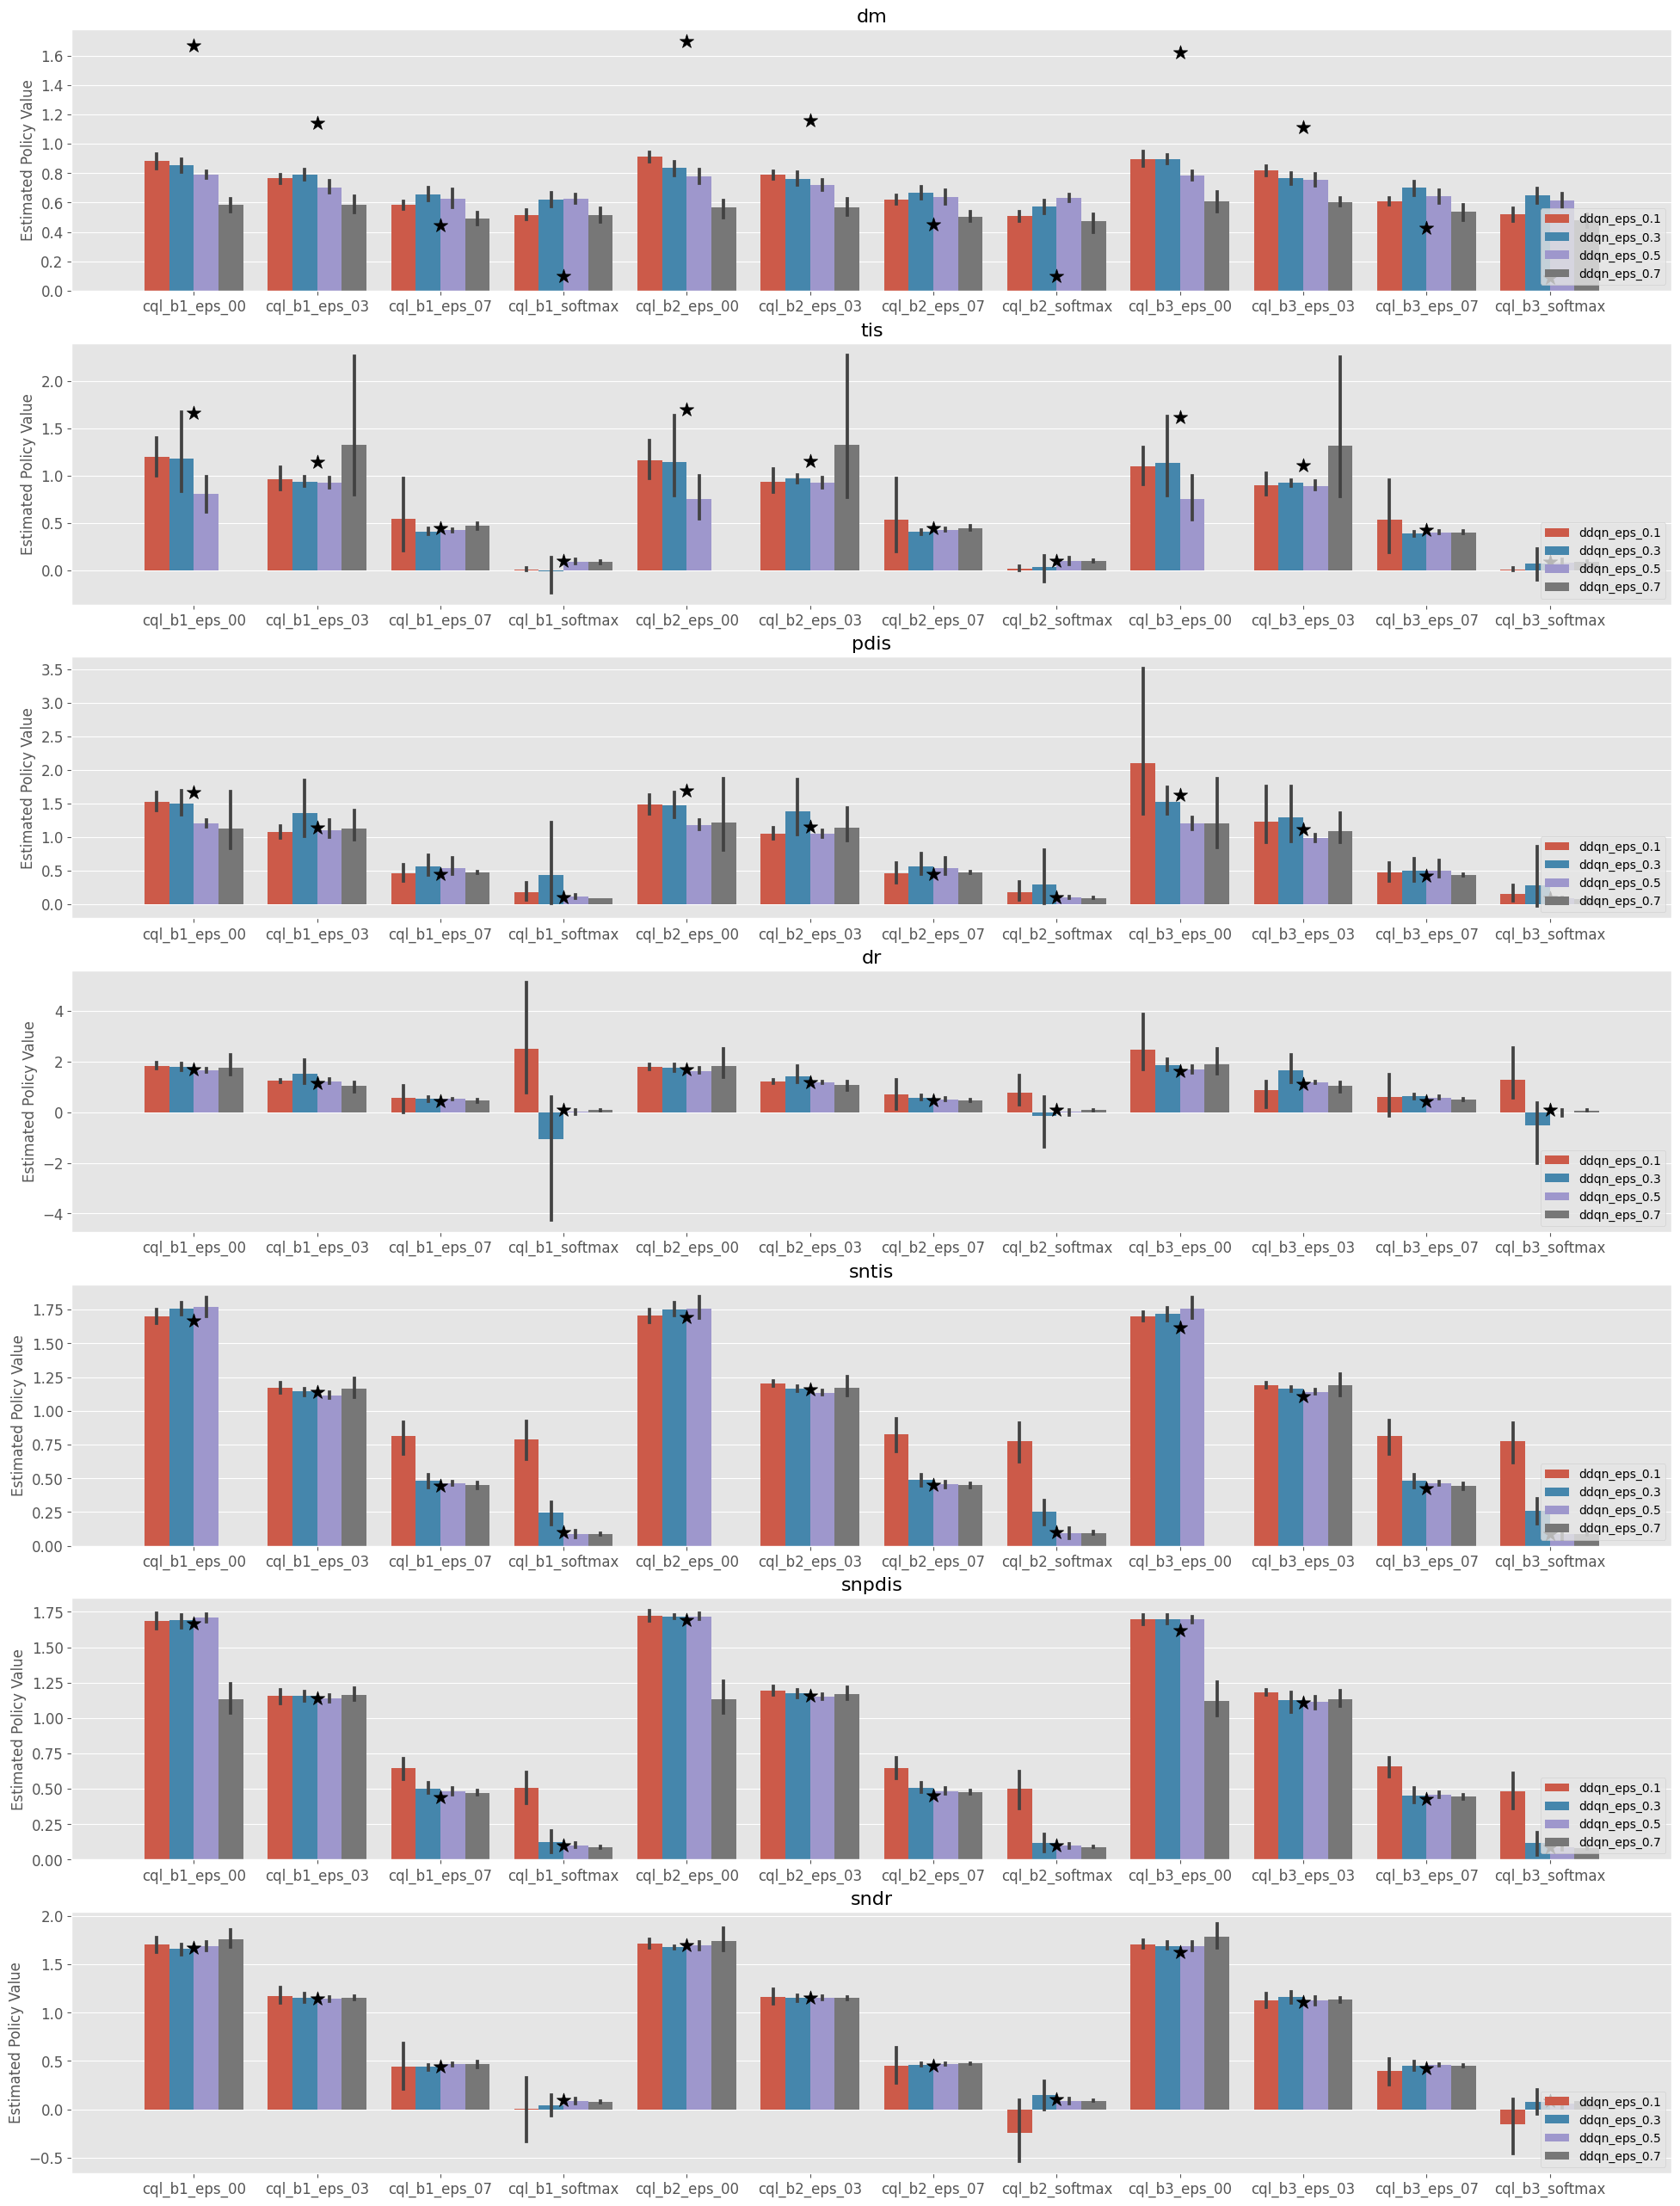

In [70]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

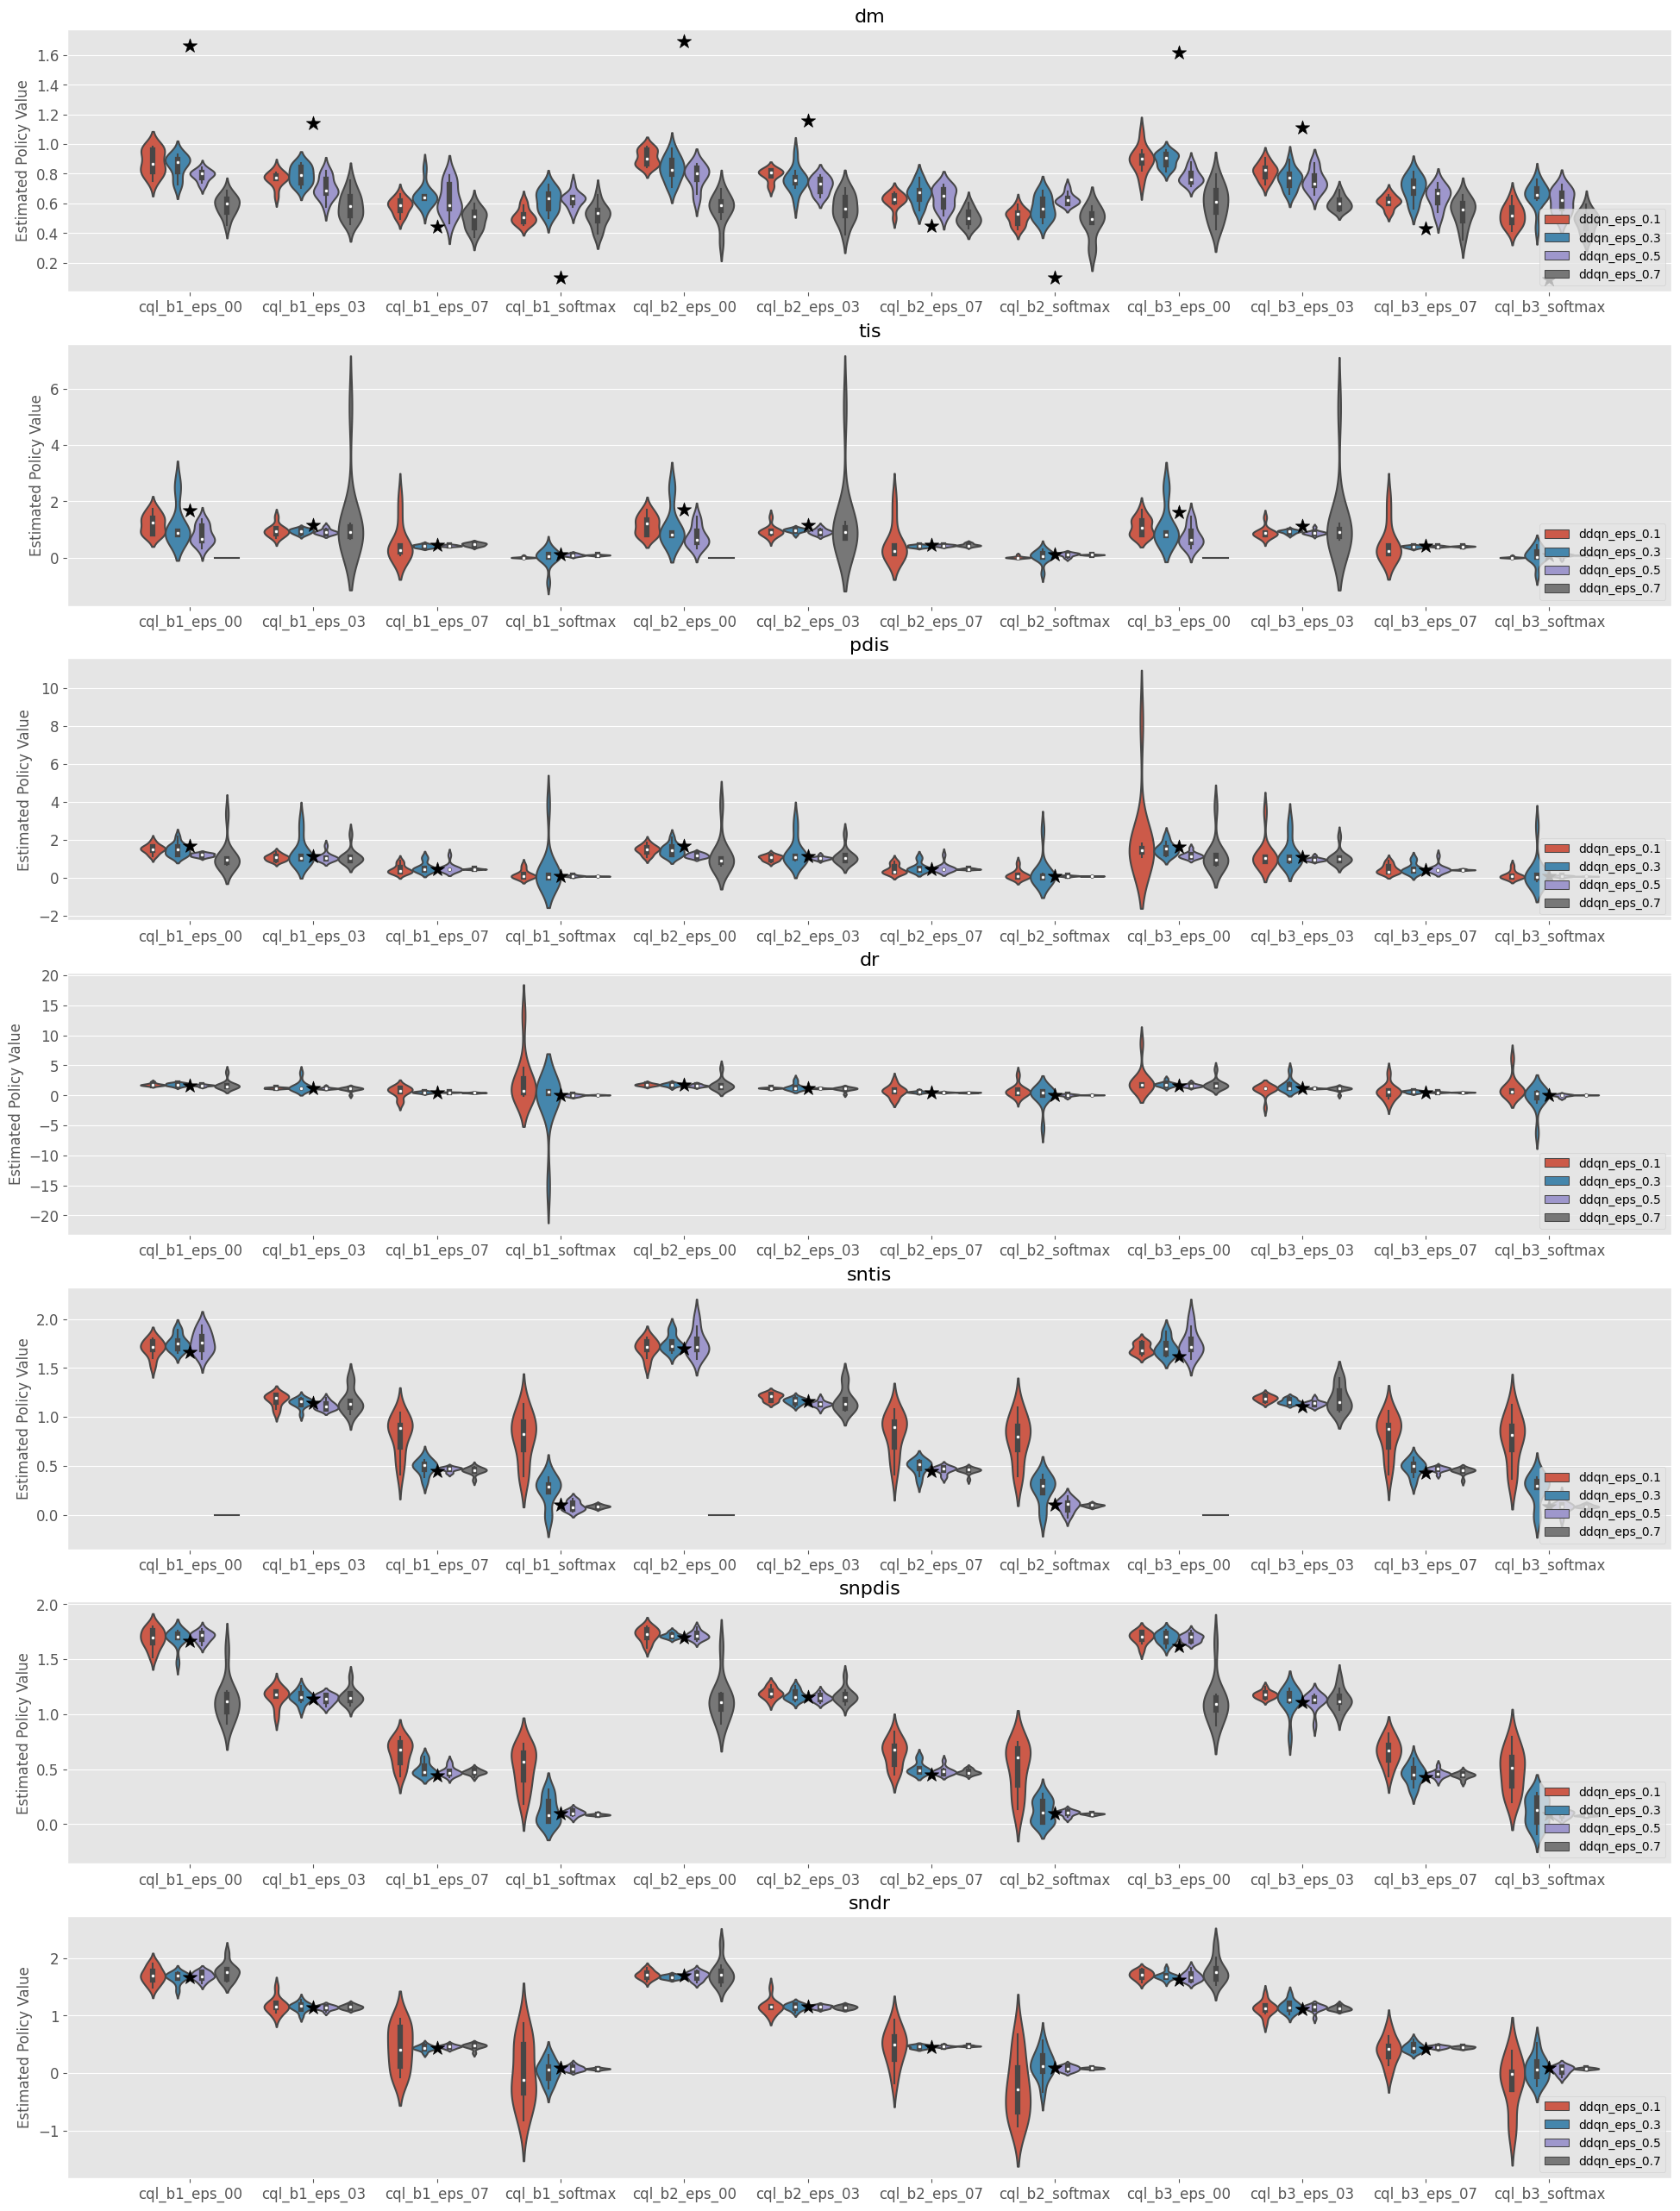

In [71]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
)

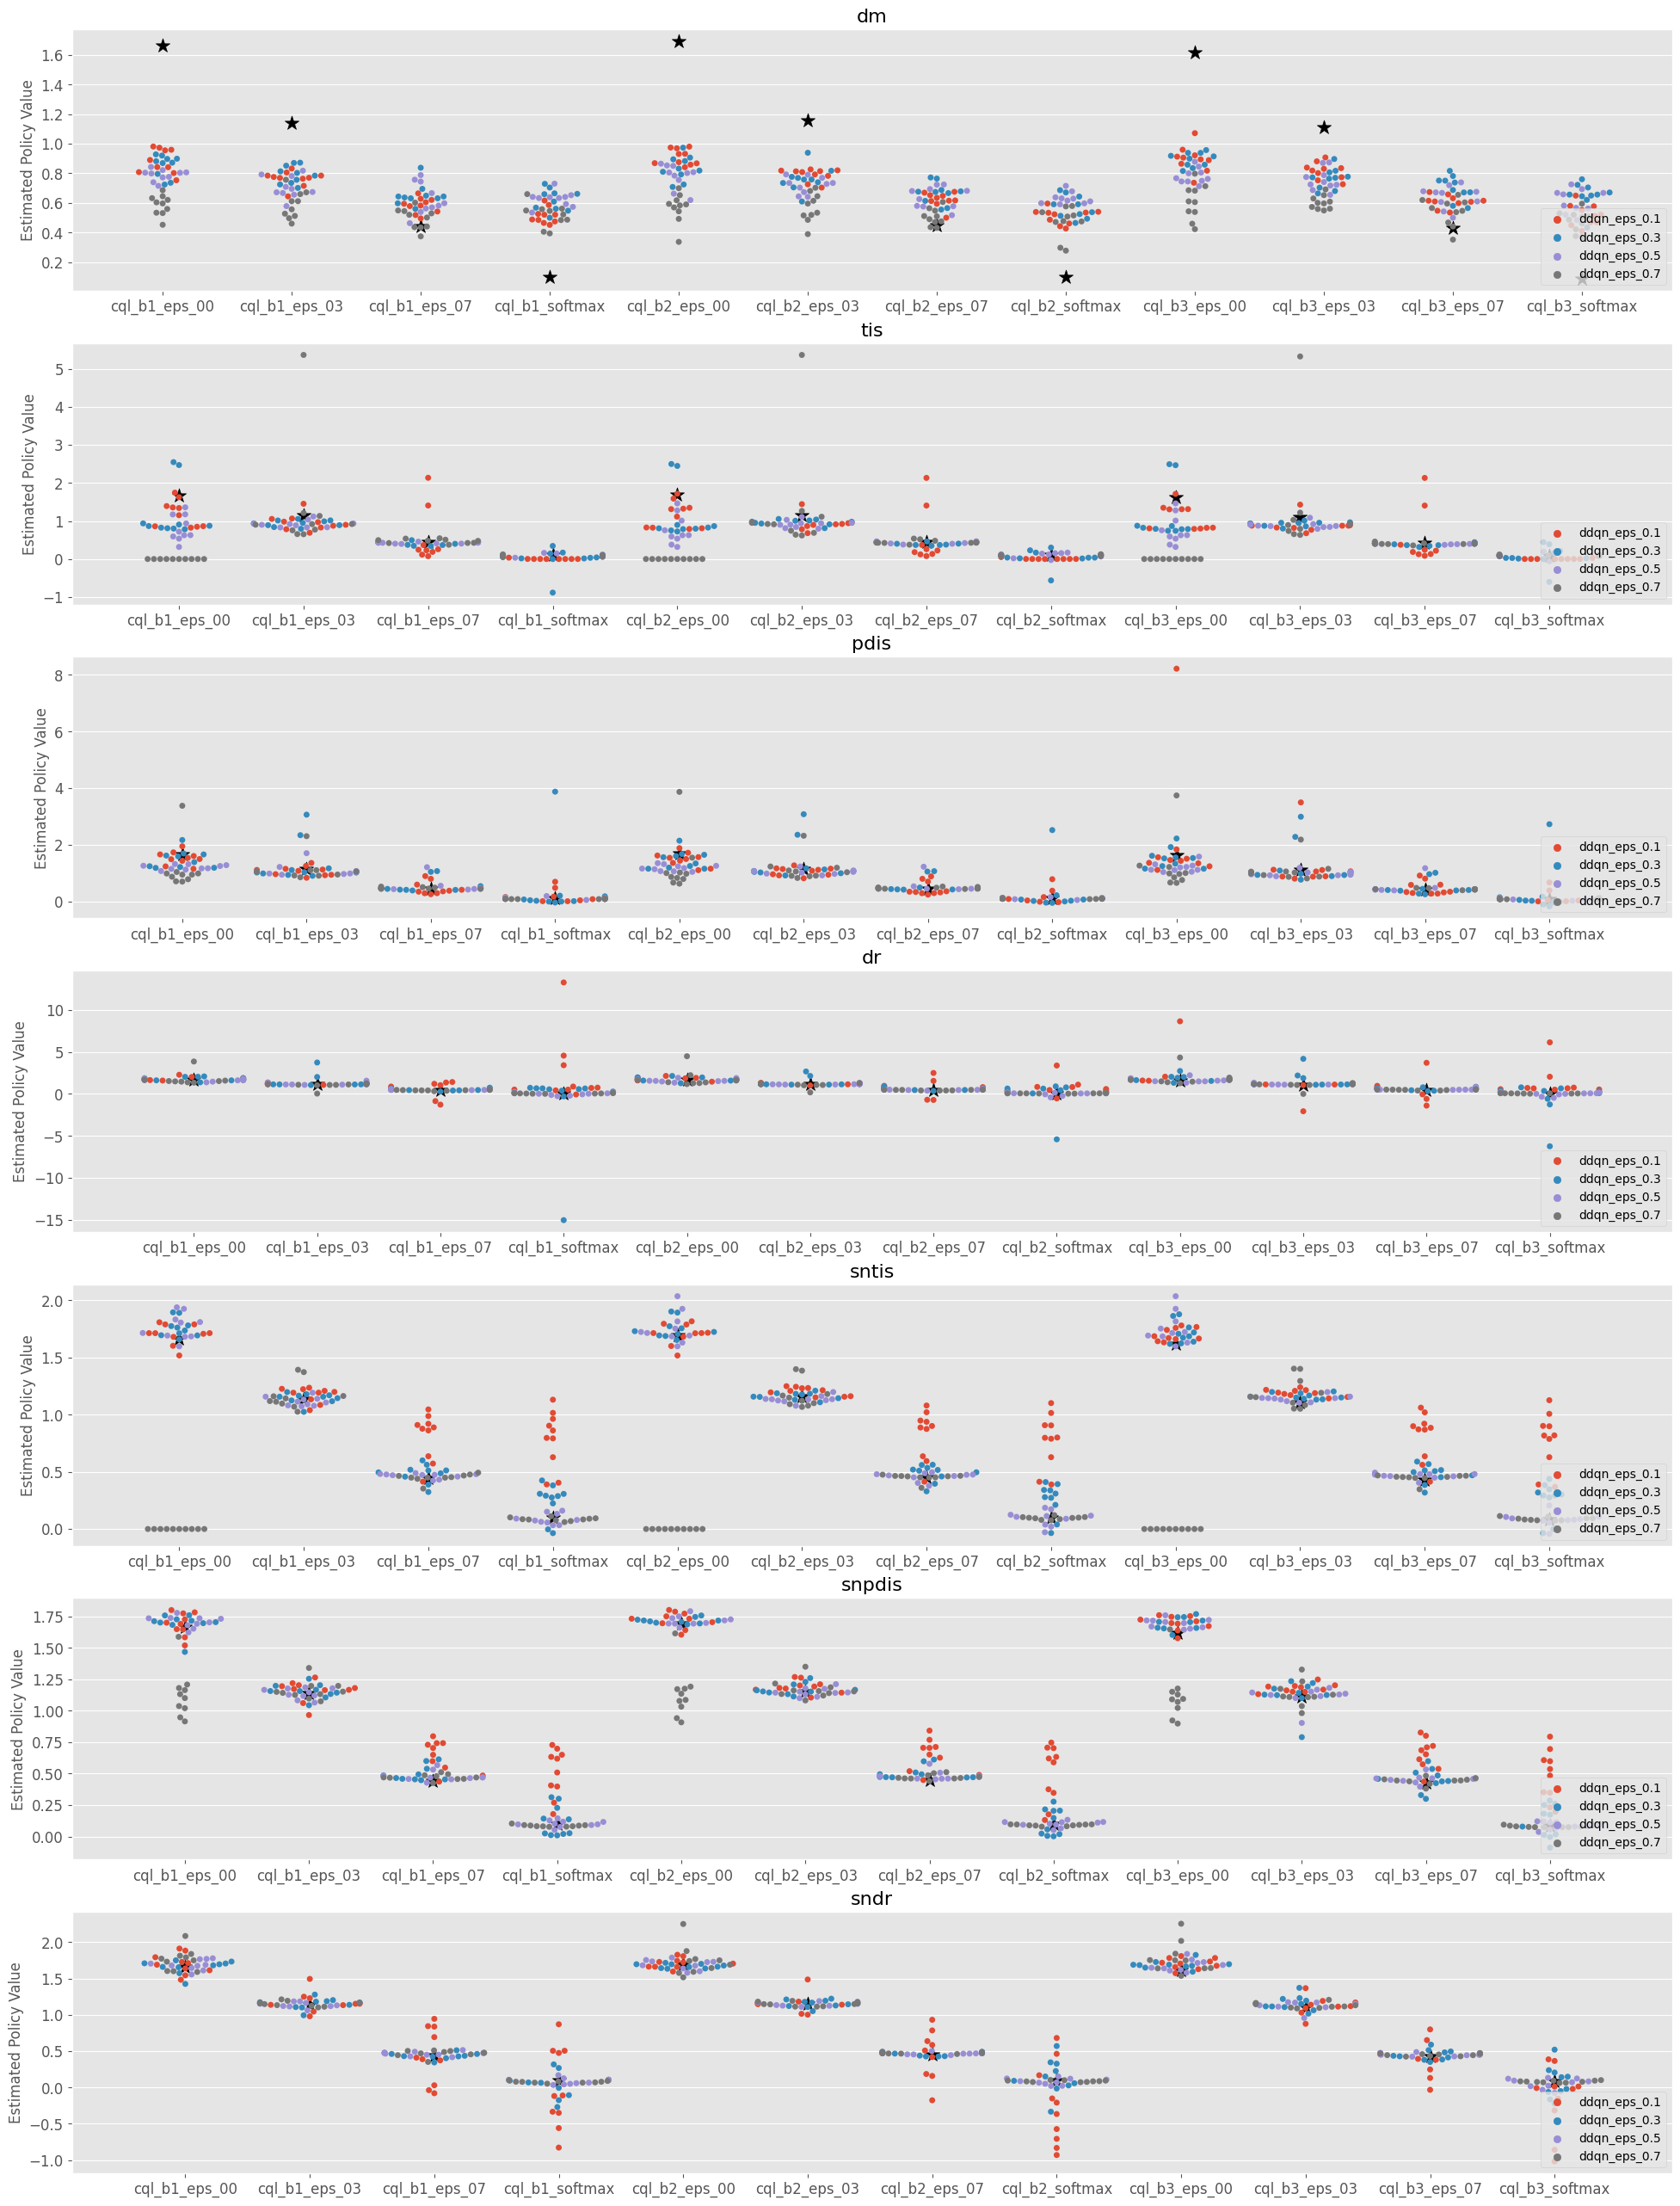

In [72]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [73]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import DiscreteCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import DiscreteCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import DiscreteCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [74]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

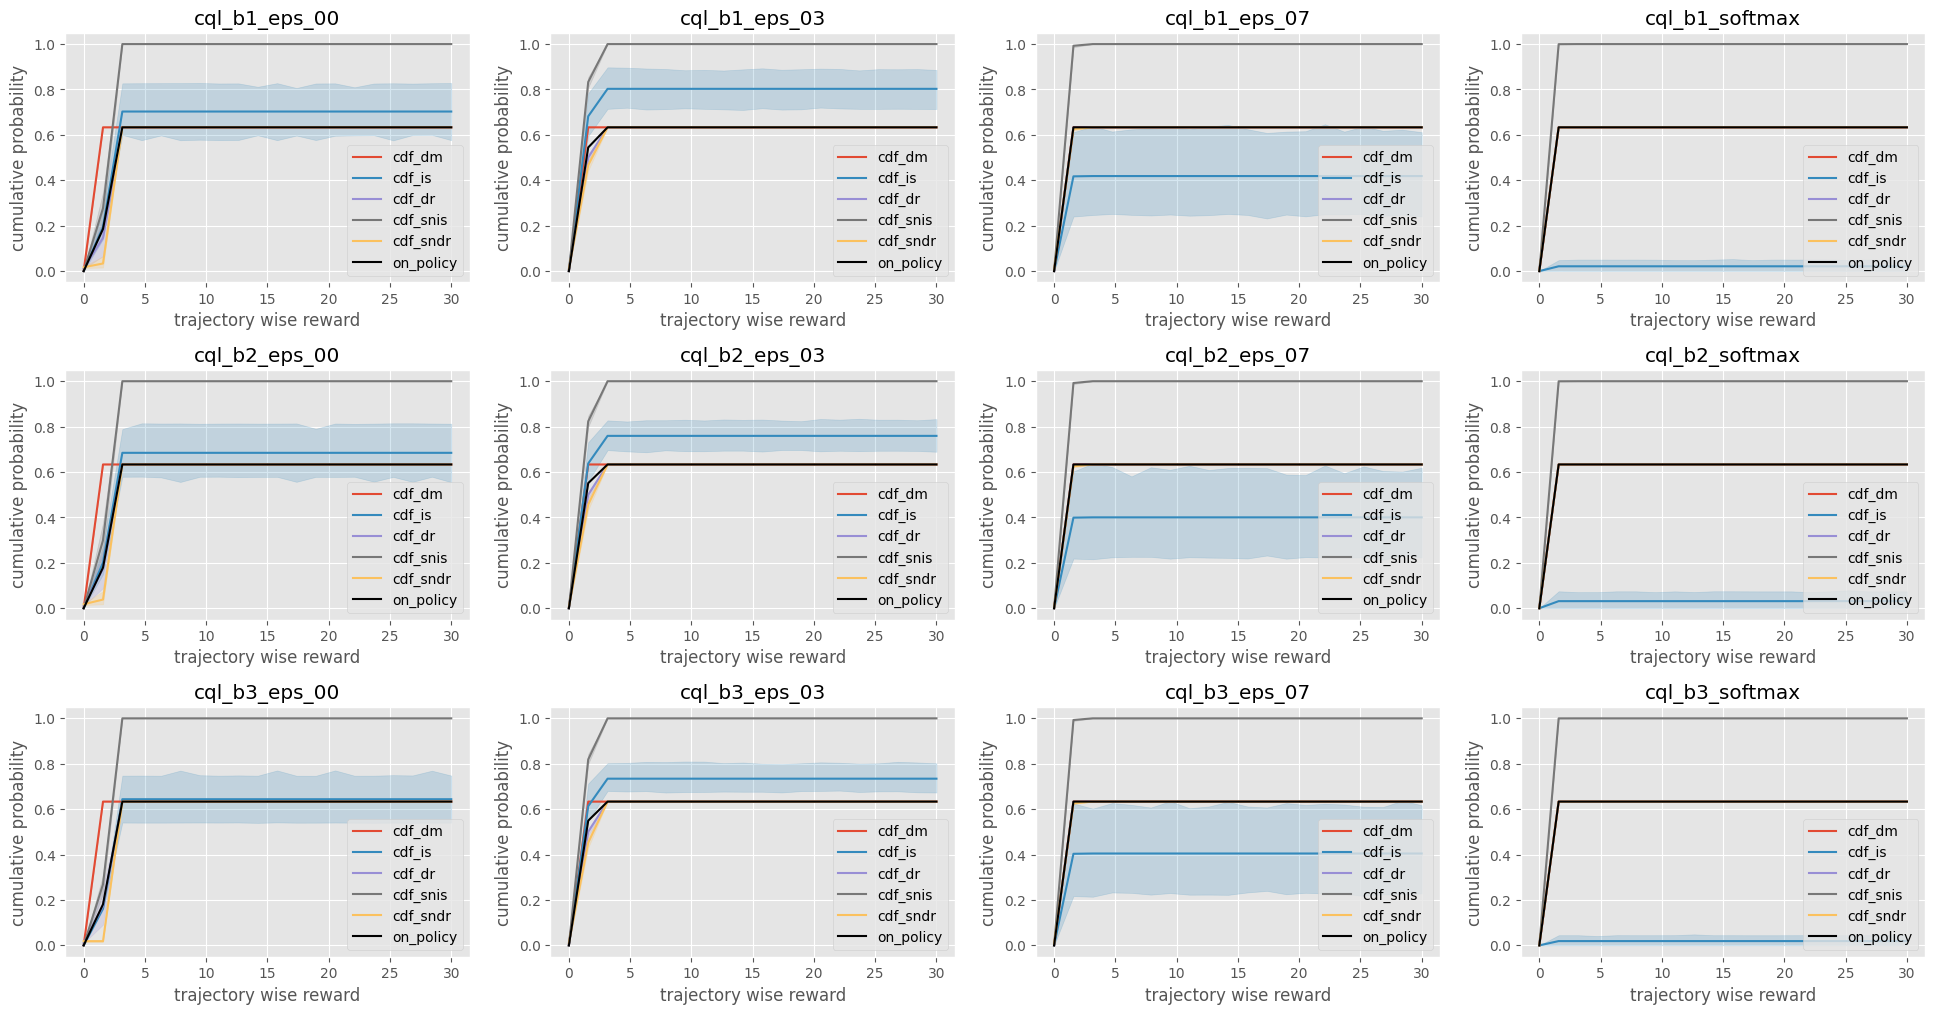

In [75]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="ci_hue",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
    n_cols=4,
)

KeyError: 'y'

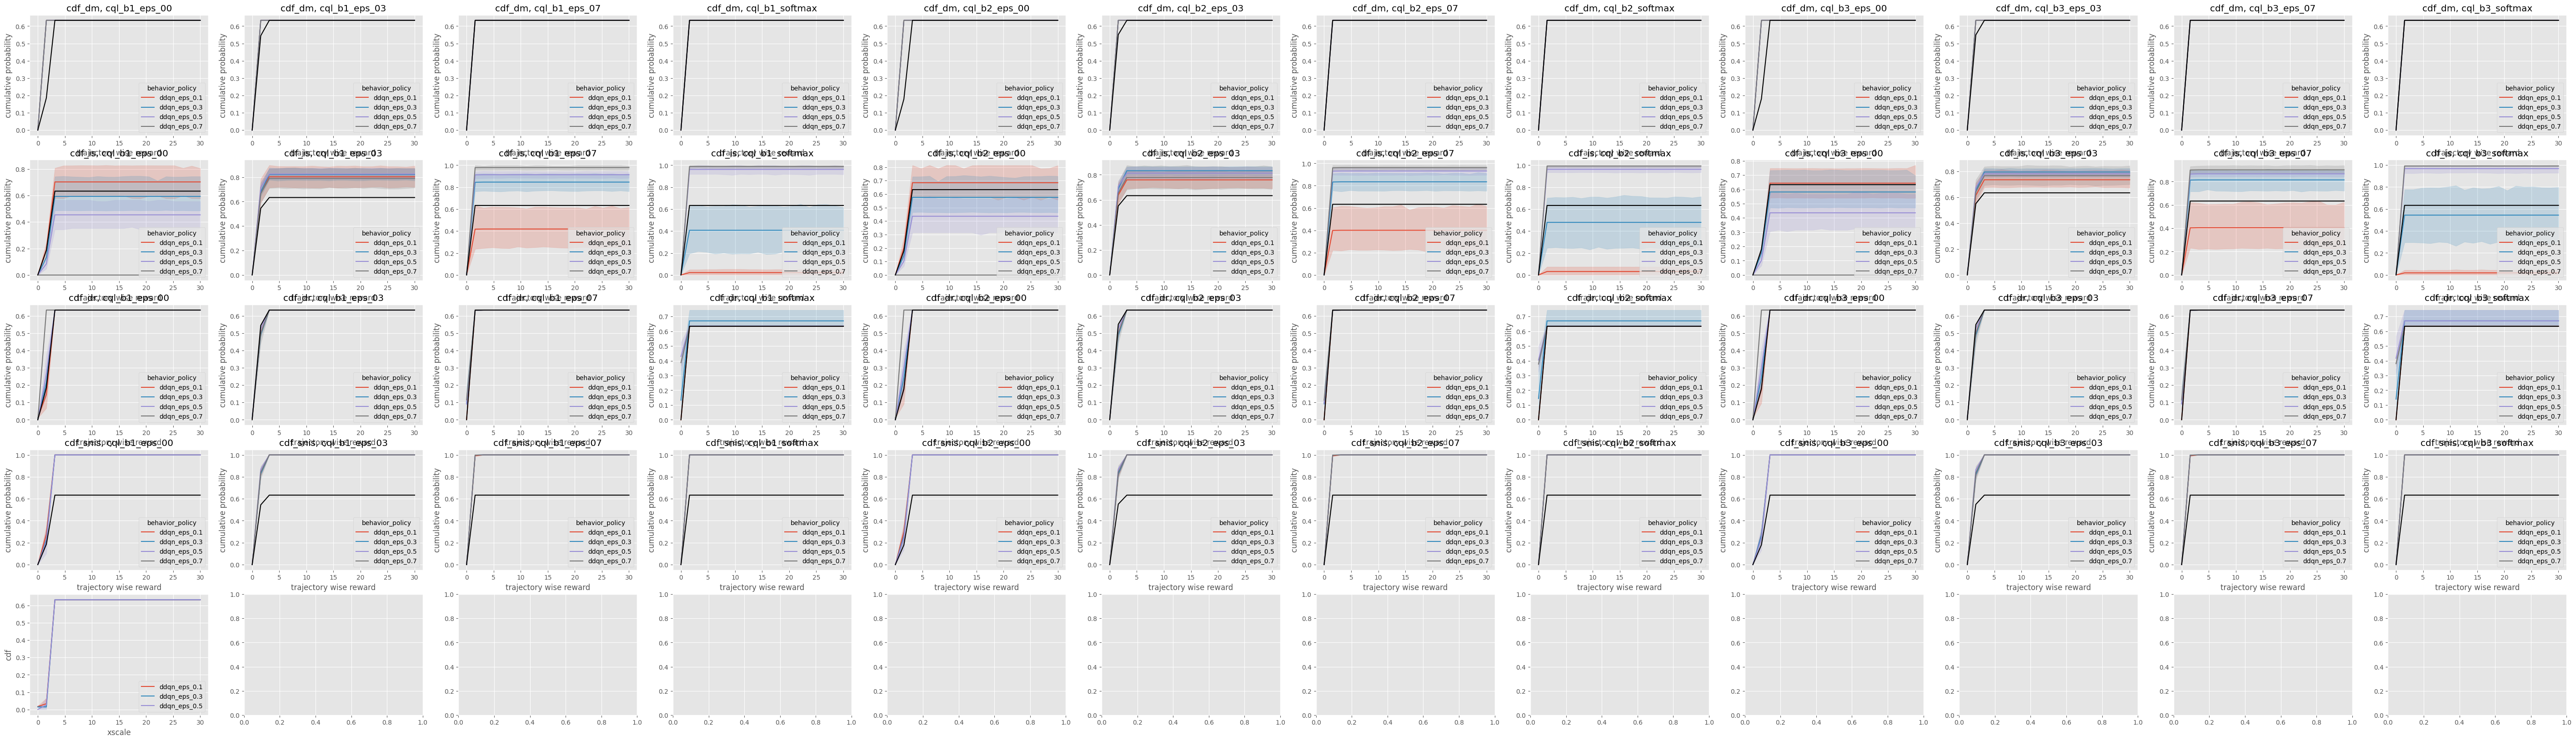

In [77]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict,
    plot_type="ci_behavior_policy",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

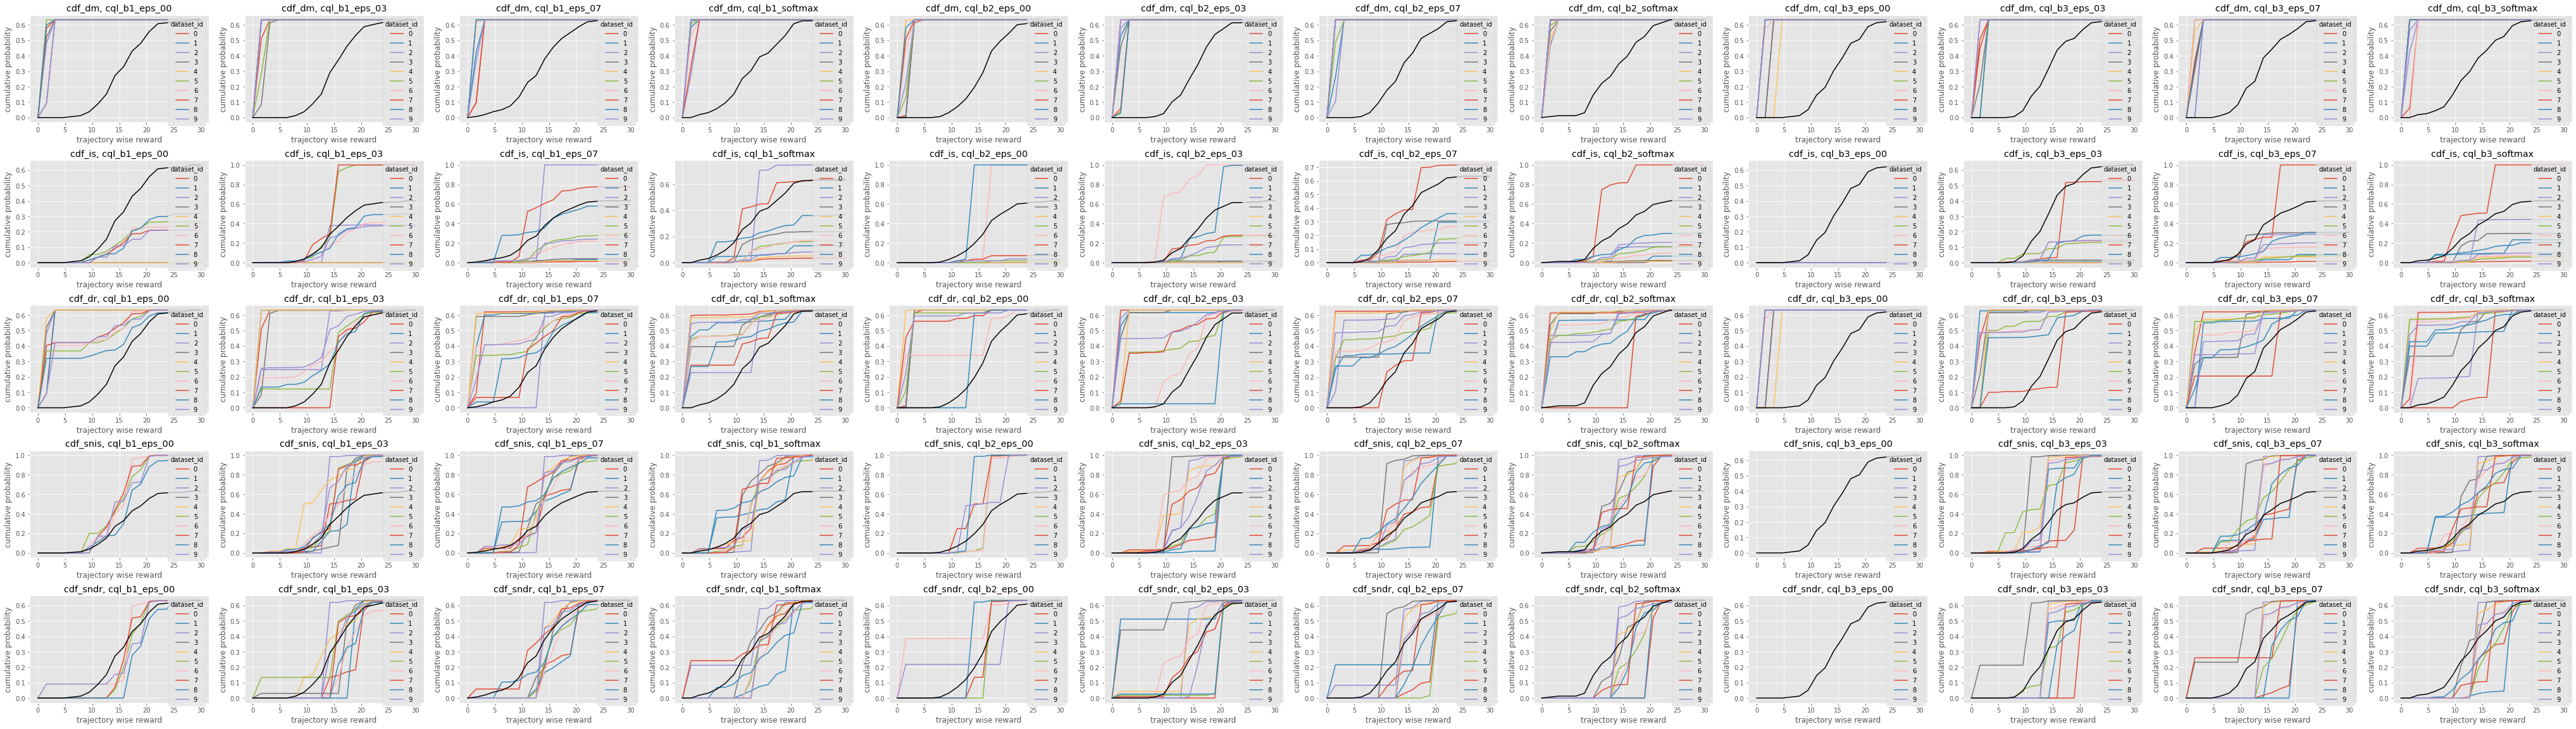

In [ ]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    behavior_policy_name="ddqn_eps_0.1",
    plot_type="enumerate",
    hue="policy",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

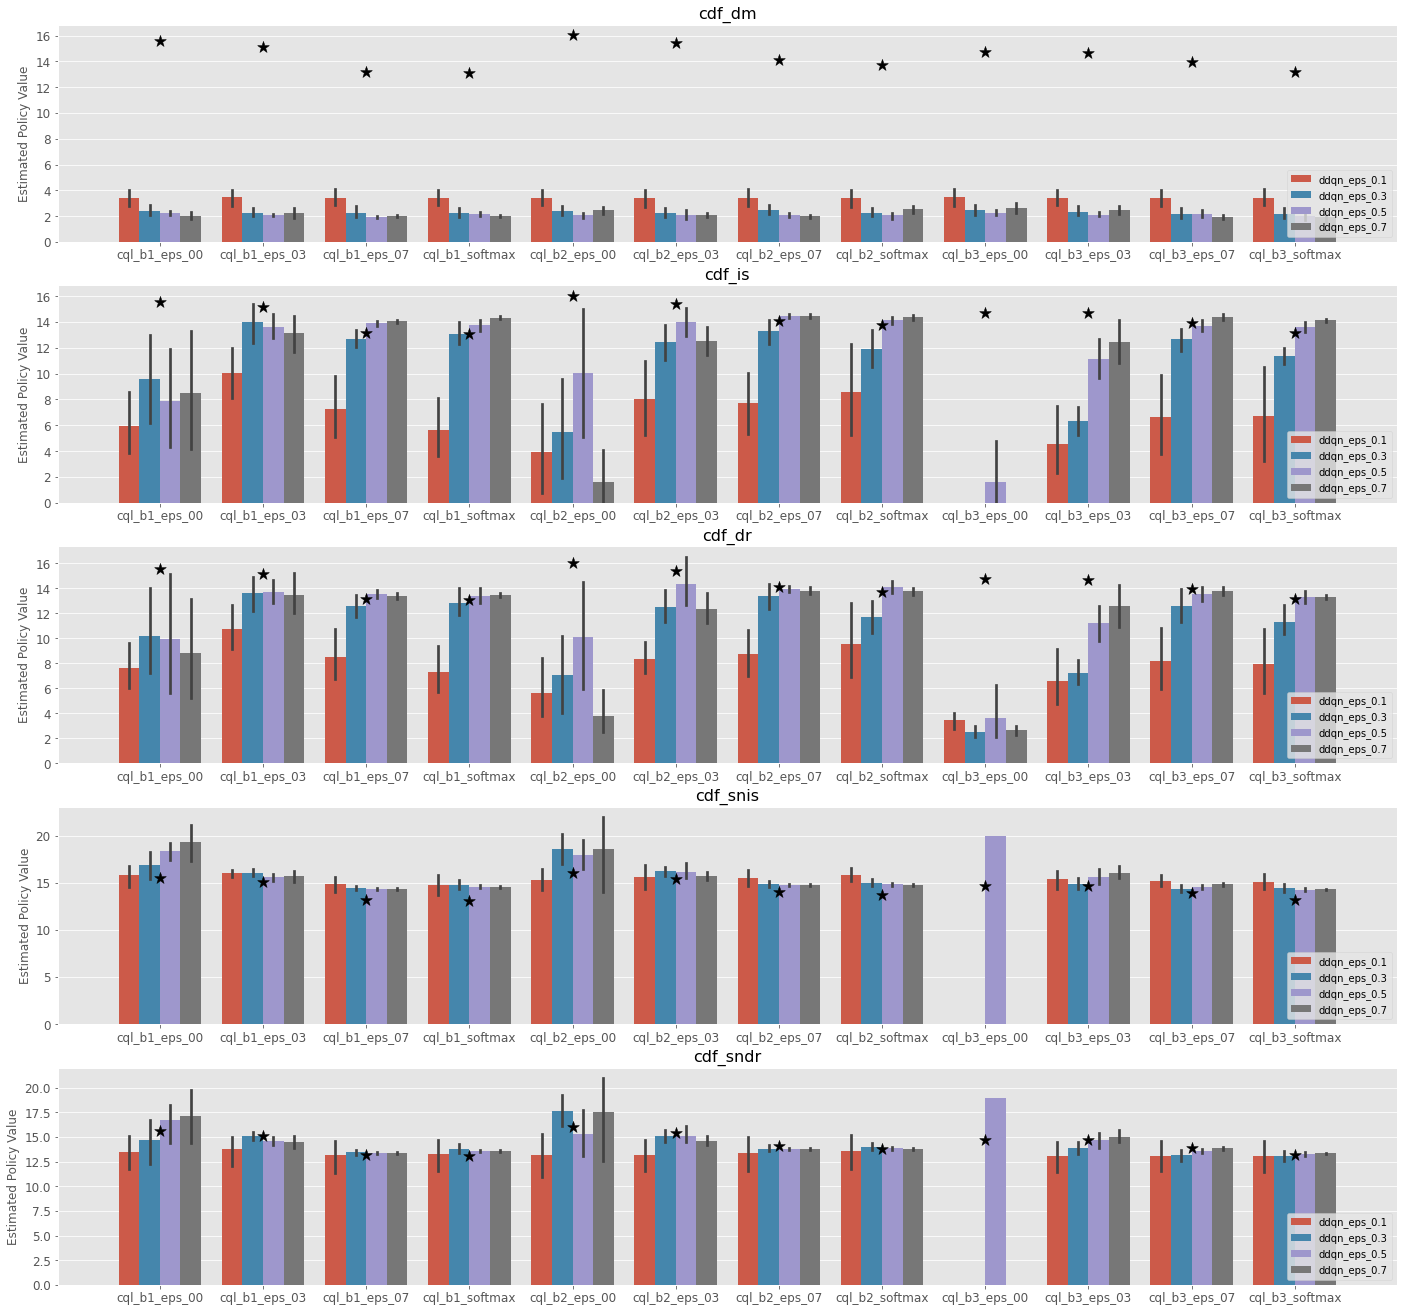

In [ ]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

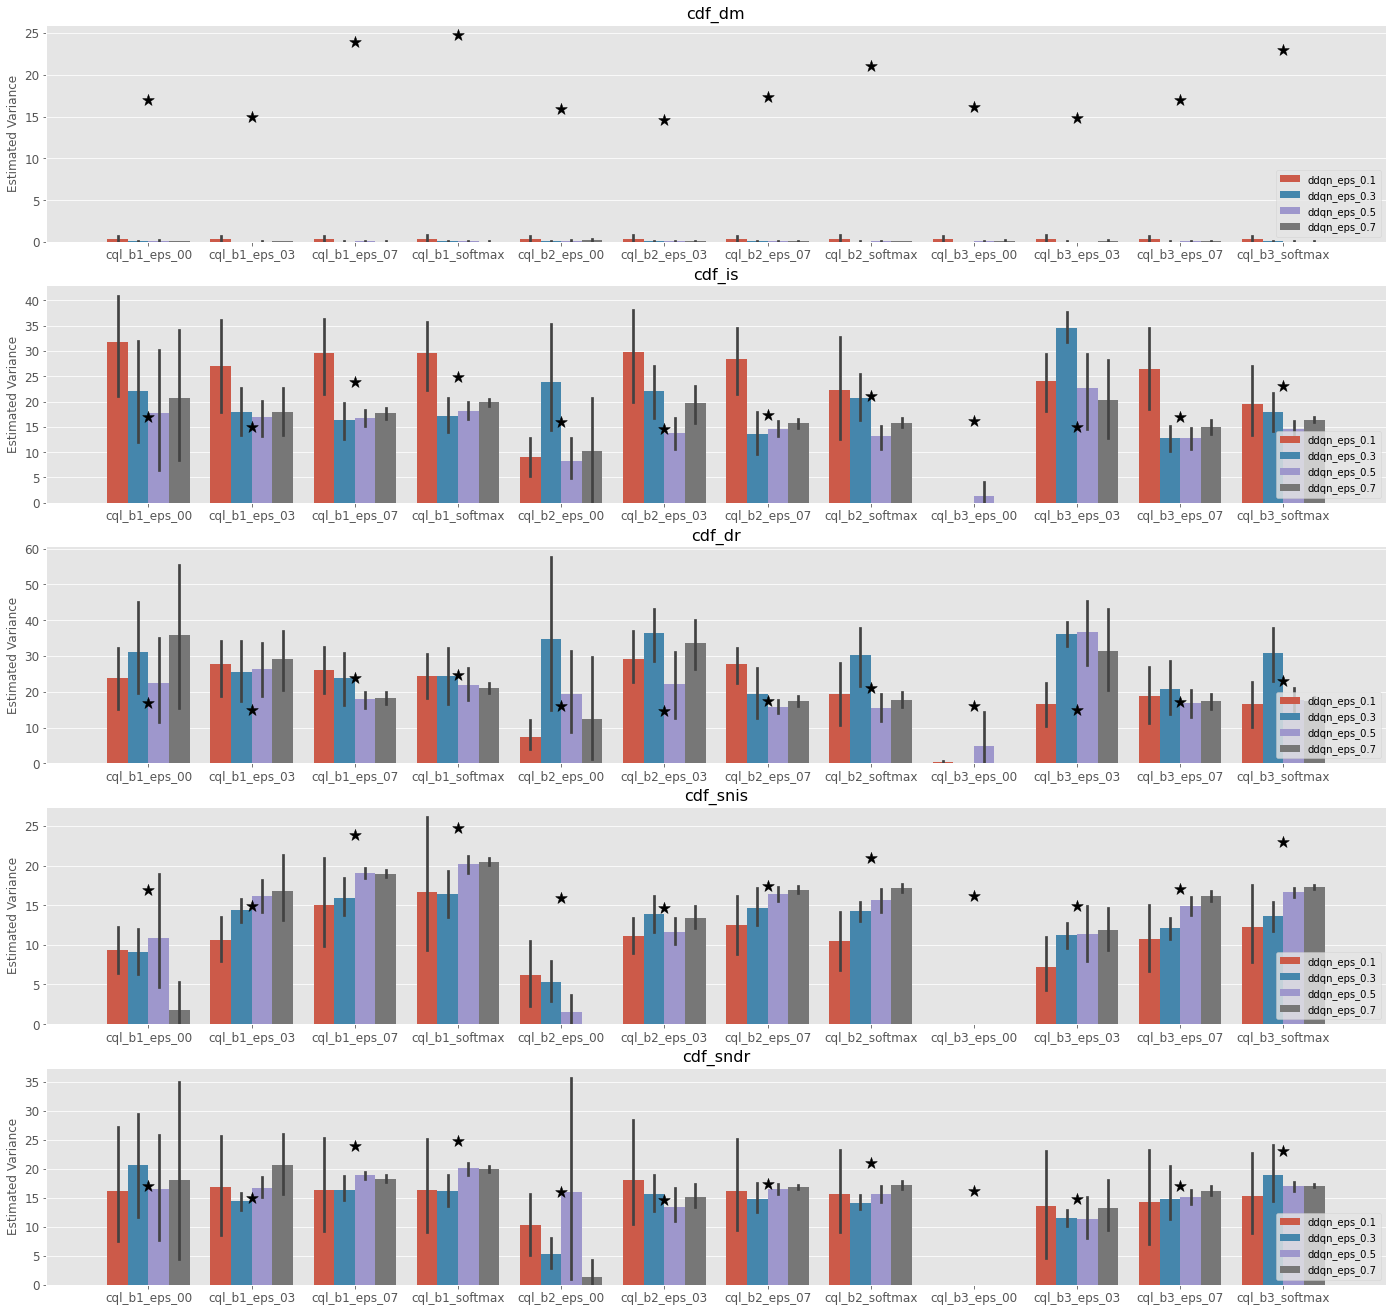

In [ ]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
)

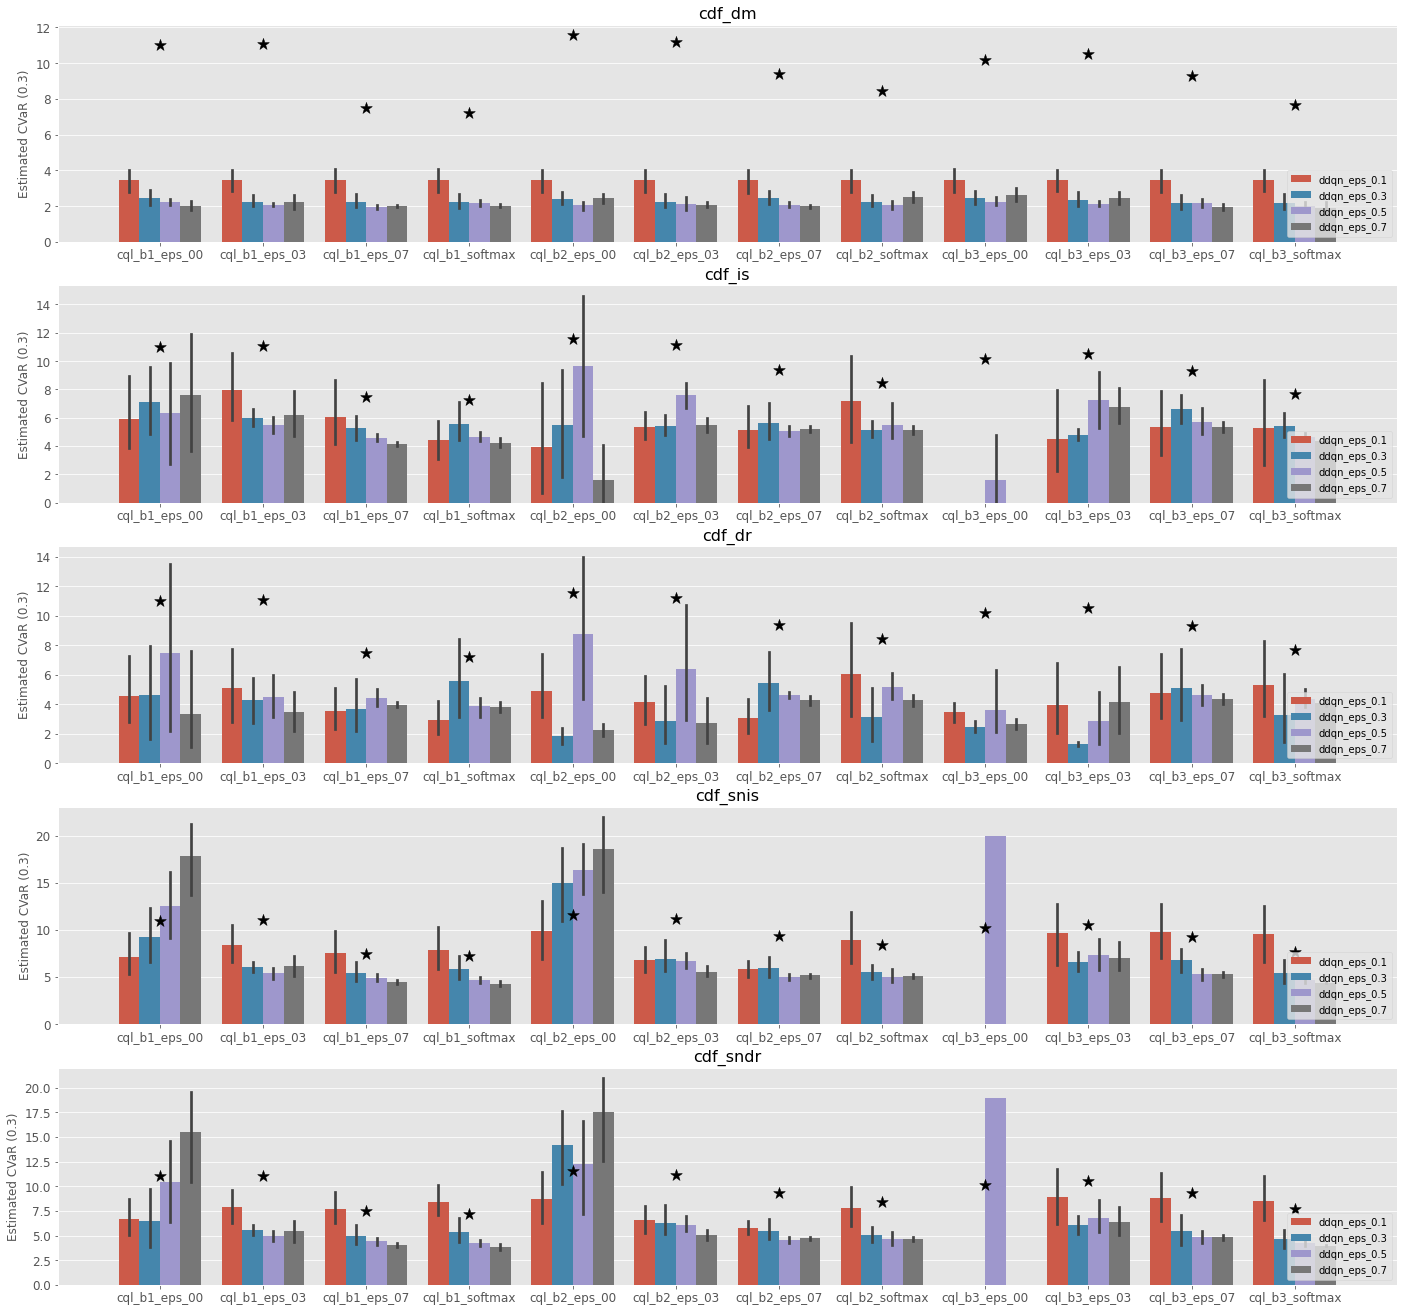

In [ ]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.3,
    plot_type="ci",
    hue="policy",
)

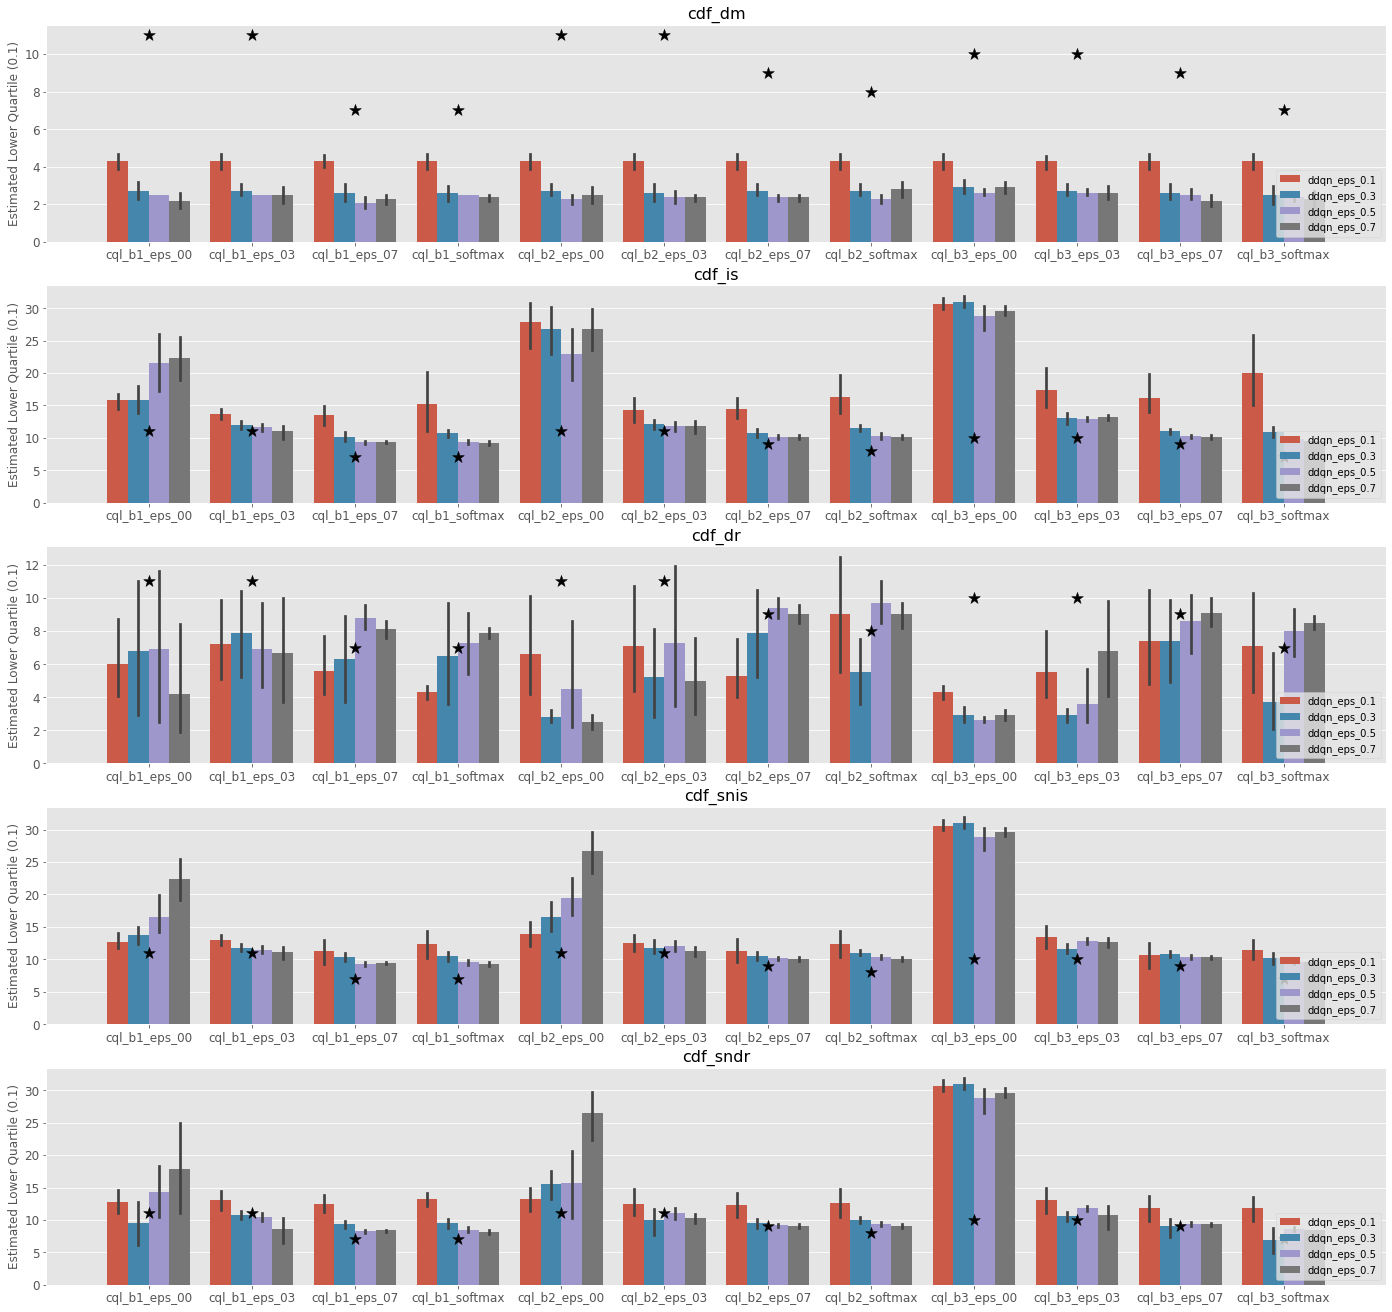

In [ ]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    alpha=0.1,
    plot_type="ci",
    hue="policy",
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [ ]:
from ofrl.ope import OffPolicySelection

In [ ]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [ ]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result["ddqn_eps_0.1"][0]

ranking  policy_value  relative_policy_value   variance  \
0    cql_b2_eps_00         16.03               1.010540  15.968788   
1    cql_b1_eps_00         15.58               0.982172  16.973333   
2    cql_b2_eps_03         15.40               0.970825  14.606061   
3    cql_b1_eps_03         15.13               0.953804  14.922323   
4    cql_b3_eps_00         14.71               0.927327  16.167576   
5    cql_b3_eps_03         14.68               0.925436  14.886465   
6    cql_b2_eps_07         14.10               0.888872  17.383838   
7    cql_b3_eps_07         13.93               0.878155  17.035455   
8   cql_b2_softmax         13.74               0.866177  21.002424   
9   cql_b3_softmax         13.17               0.830244  23.031414   
10   cql_b1_eps_07         13.16               0.829614  23.913535   
11  cql_b1_softmax         13.07               0.823940  24.752626   

   ranking_by_lower_quartile  lower_quartile  \
0              cql_b1_eps_00           10.00   
1              cql_b1_eps_03            9.95   
2              cql_b1_eps_07            9.00   
3             cql_b1_softmax            9.00   
4              cql_b2_eps_00            9.00   
5              cql_b2_eps_03            8.95   
6              cql_b2_eps_07            7.95   
7             cql_b2_softmax            7.95   
8              cql_b3_eps_00            7.95   
9              cql_b3_eps_03            5.00   
10             cql_b3_eps_07            4.95   
11            cql_b3_softmax            4.00   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                         cql_b2_eps_03                        8.4  
1                         cql_b2_eps_00                        8.2  
2                         cql_b3_eps_03                        8.0  
3                         cql_b1_eps_03                        7.8  
4                         cql_b1_eps_00                        7.6  
5                         cql_b3_eps_00                        7.2  
6                         cql_b2_eps_07                        6.8  
7                         cql_b3_eps_07                        6.6  
8                        cql_b2_softmax                        5.0  
9                        cql_b3_softmax                        3.4  
10                        cql_b1_eps_07                        3.0  
11                       cql_b1_softmax                        2.8

In [ ]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [ ]:
ranking_df["ddqn_eps_0.1"][0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0      cql_b2_eps_00                2.666641                         0.168107   
 1      cql_b1_eps_00                2.335363                         0.147223   
 2      cql_b3_eps_00                2.226492                         0.140359   
 3     cql_b3_softmax                1.788272                         0.112734   
 4      cql_b1_eps_07                1.718707                         0.108348   
 5      cql_b3_eps_07                1.538468                         0.096986   
 6      cql_b3_eps_03                1.488043                         0.093807   
 7      cql_b1_eps_03                1.384464                         0.087277   
 8     cql_b1_softmax                1.195266                         0.075350   
 9     cql_b2_softmax                1.083310                         0.068292   
 10     cql_b2_eps_07                0.958525                         0.060426   
 11     cq

In [ ]:
metric_df["ddqn_eps_0.1"][0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm          164.863367          0.286713  0.366251      0.00   
1       tis          170.170212         -0.377622  0.226206      2.29   
2      pdis           11.767858          0.209790  0.512841      2.29   
3        dr            6.637402          0.321678  0.307910      1.35   
4     sntis           21.936329          0.230769  0.470532      0.90   
5    snpdis            4.972908          0.552448  0.062511      0.45   
6      sndr            4.043637          0.559441  0.058589      0.45   

   type_i_error_rate  type_ii_error_rate  
0                0.0                 0.0  
1                0.0                 0.0  
2                0.0                 0.0  
3                0.0                 0.0  
4                0.0                 0.0  
5                0.0                 0.0  
6                0.0                 0.0

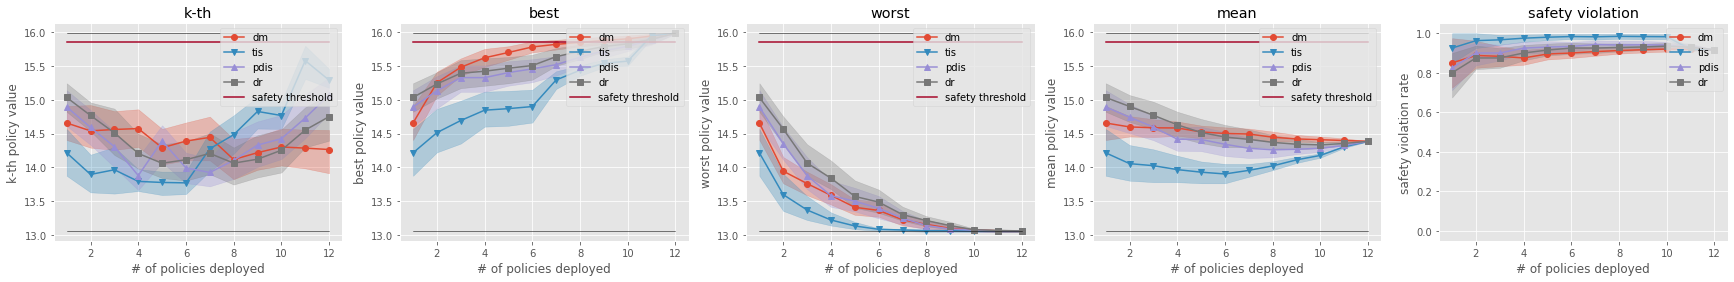

In [ ]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

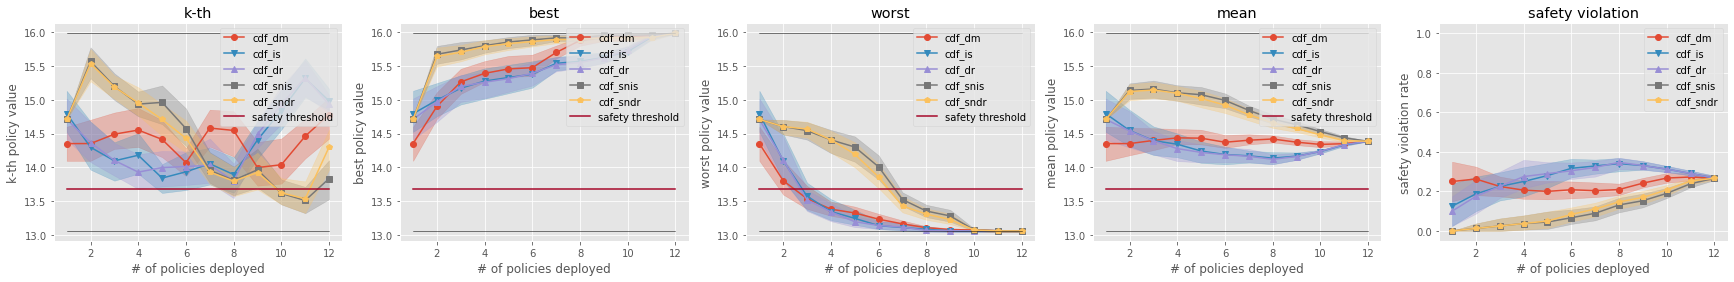

In [ ]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

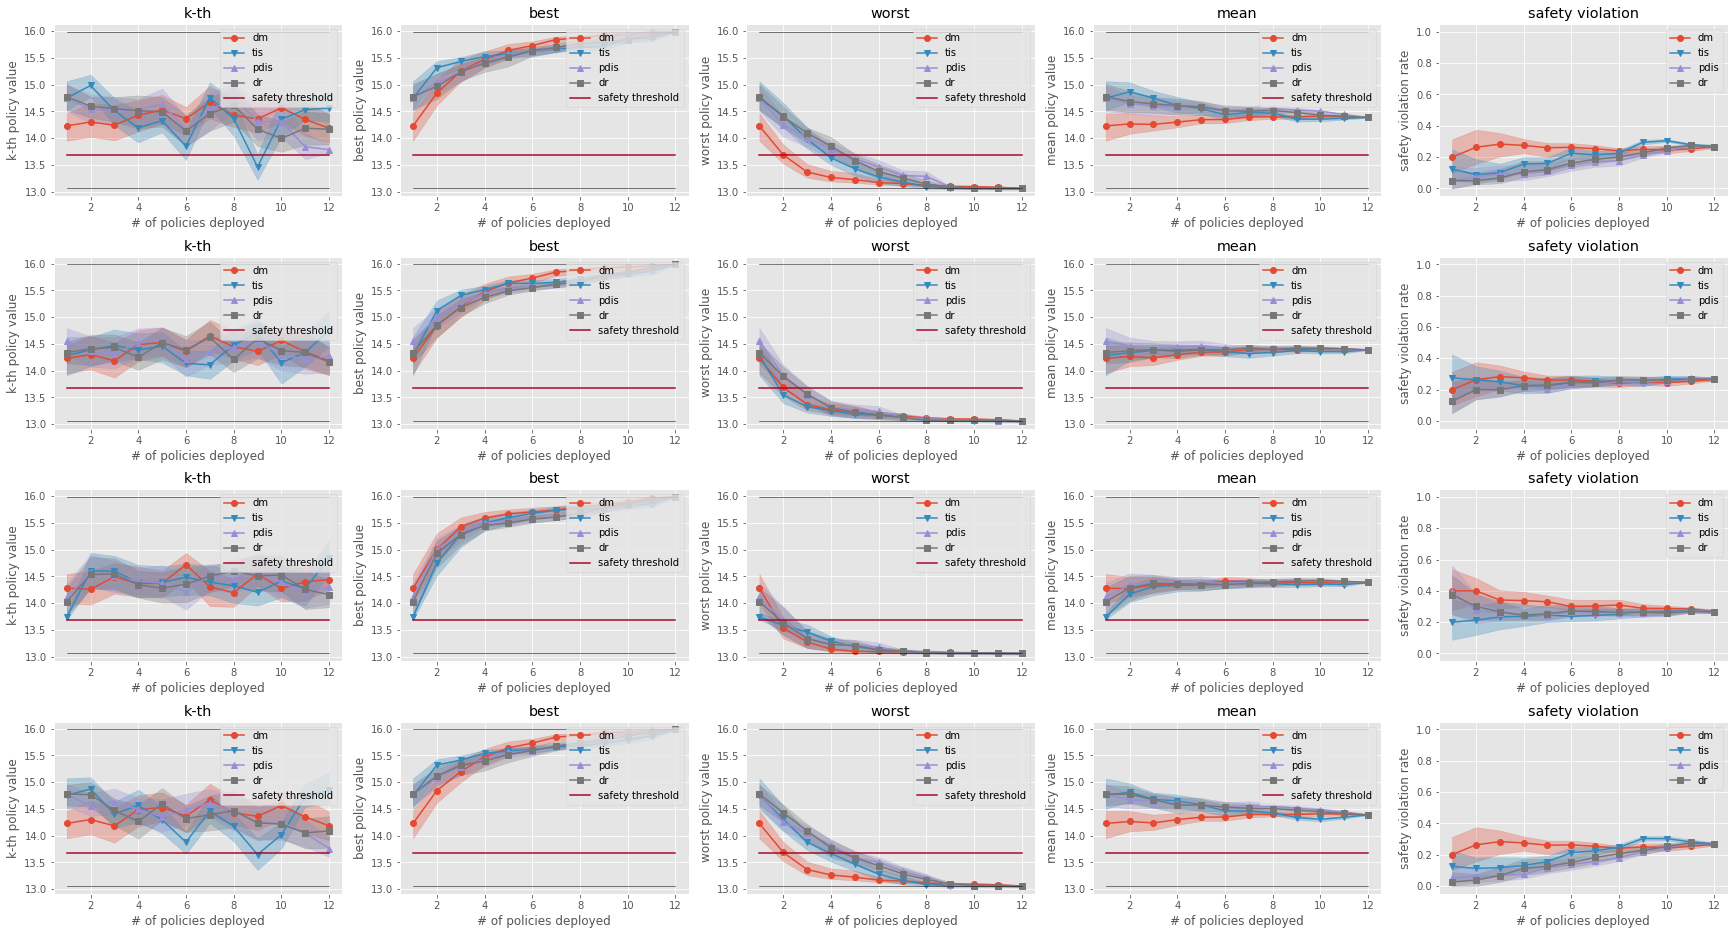

In [ ]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

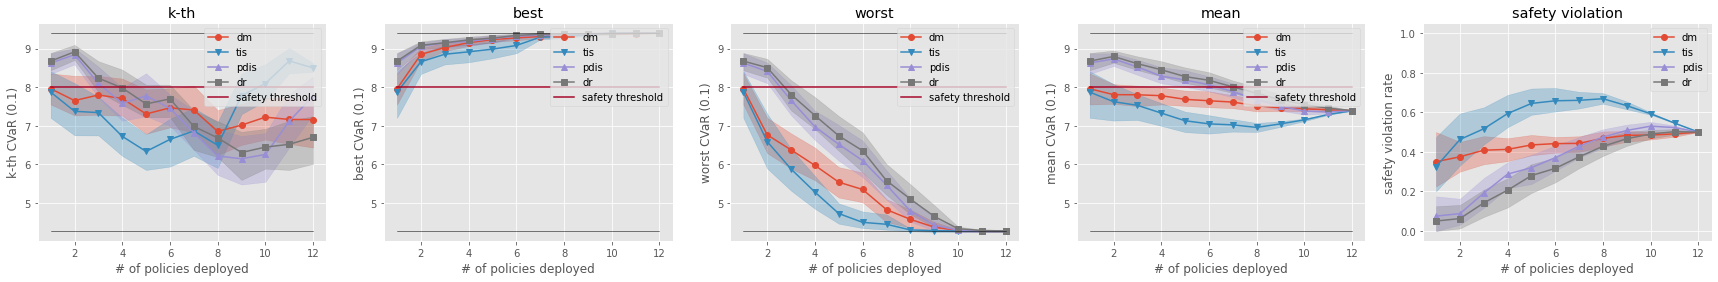

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

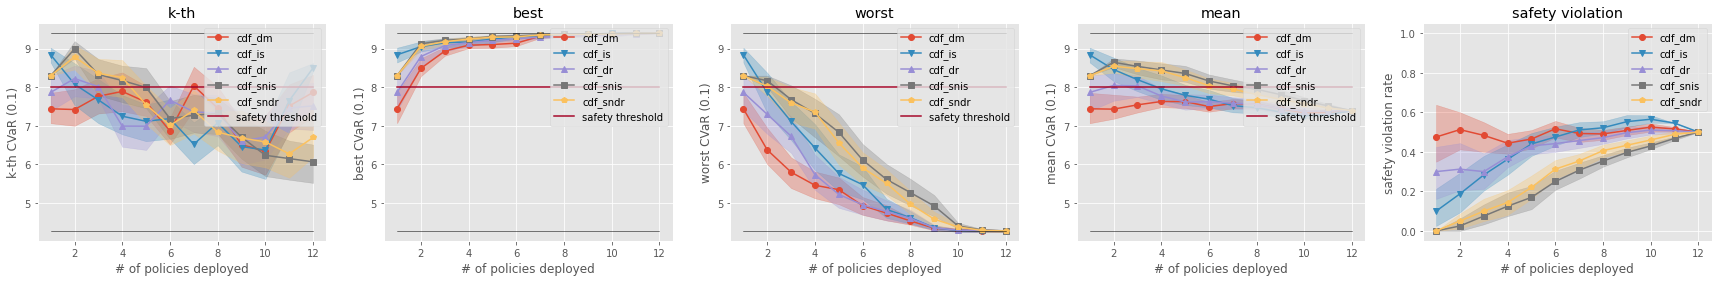

In [ ]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

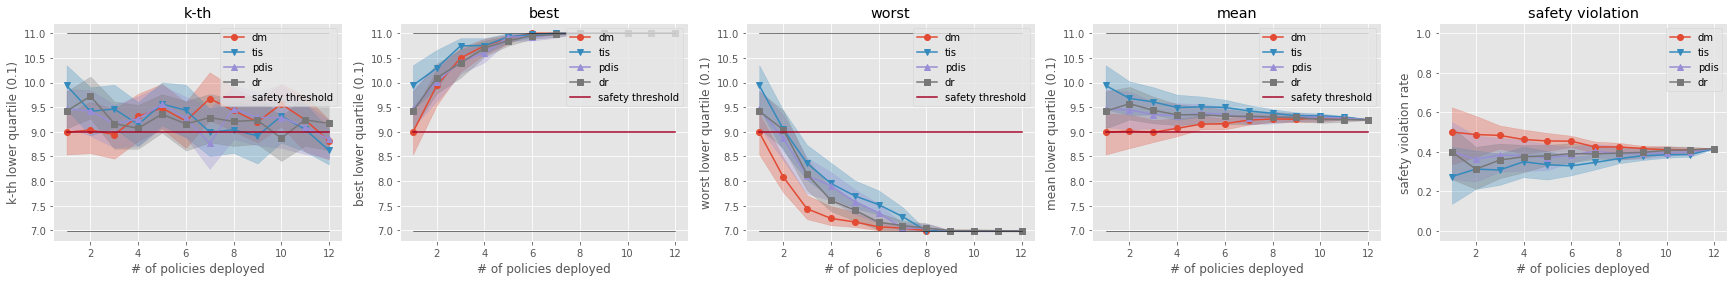

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

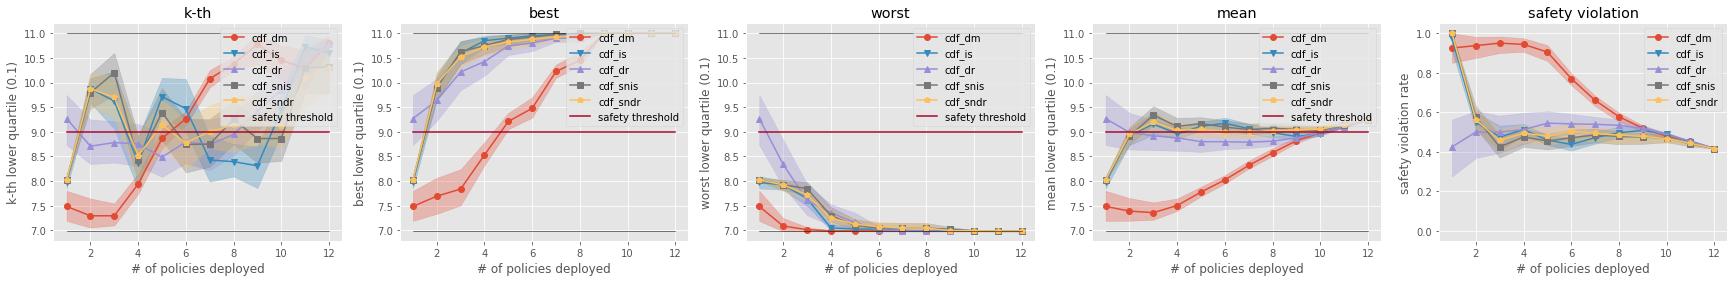

In [ ]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=9.0,
    legend=True,
    random_state=random_state,
)

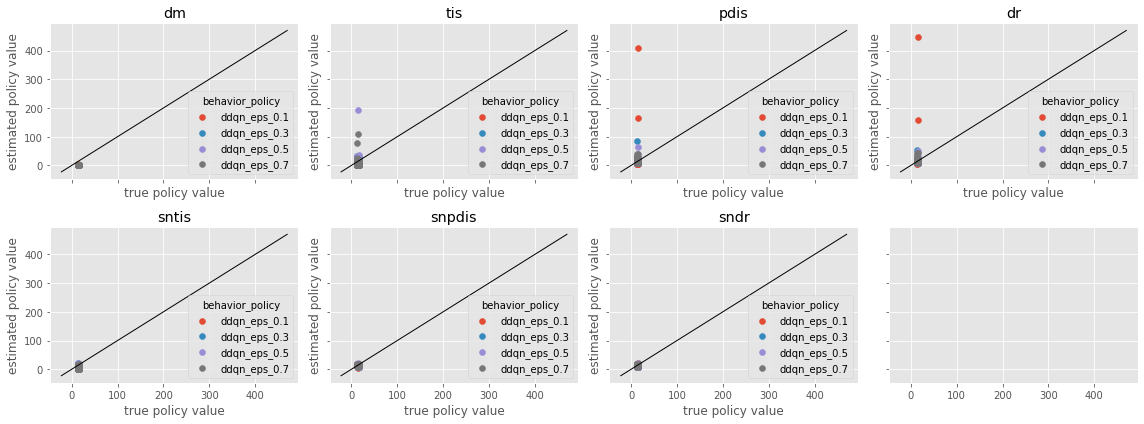

In [ ]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

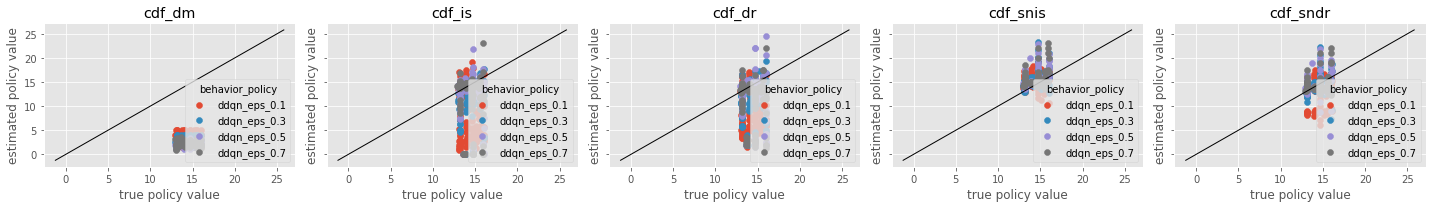

In [ ]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

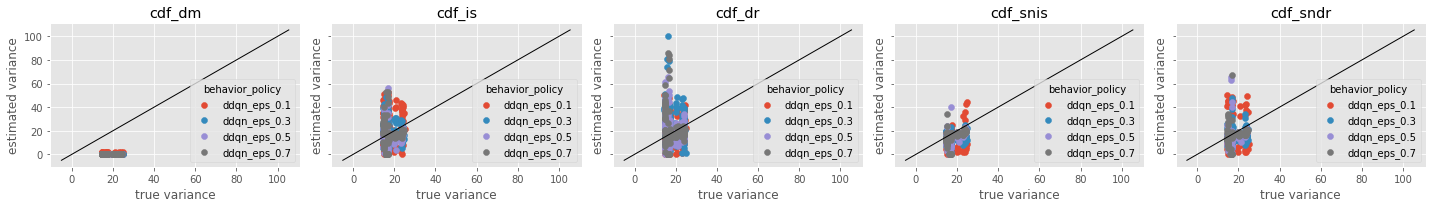

In [ ]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

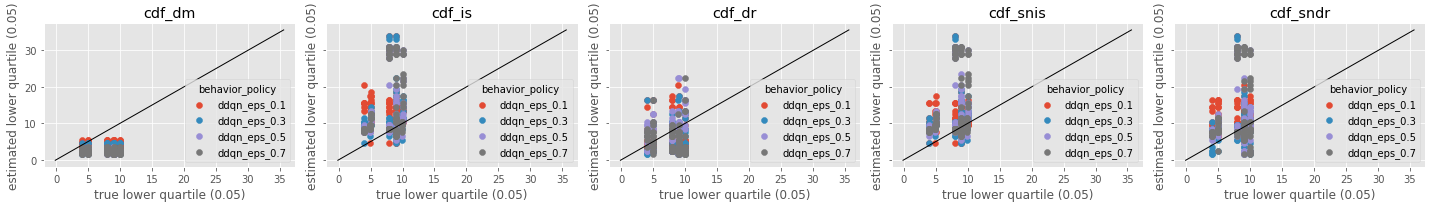

In [ ]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

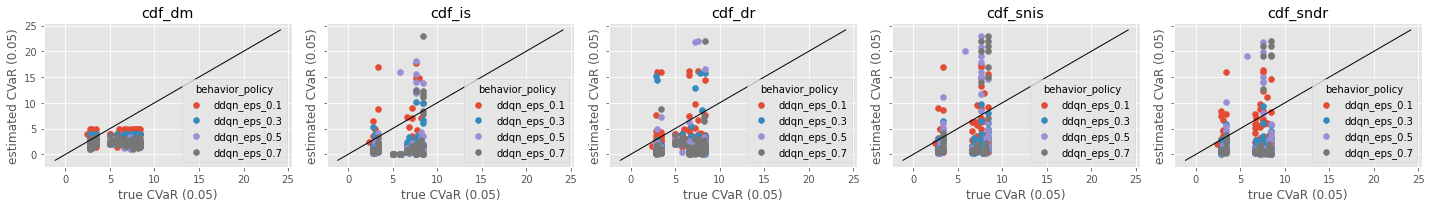

In [ ]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the continuous action space, please refer to [examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb](https://github.com/negocia-inc/rec_reinforcement_learing/blob/ope/examples/quickstart/rec_synthetic_continuous_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.